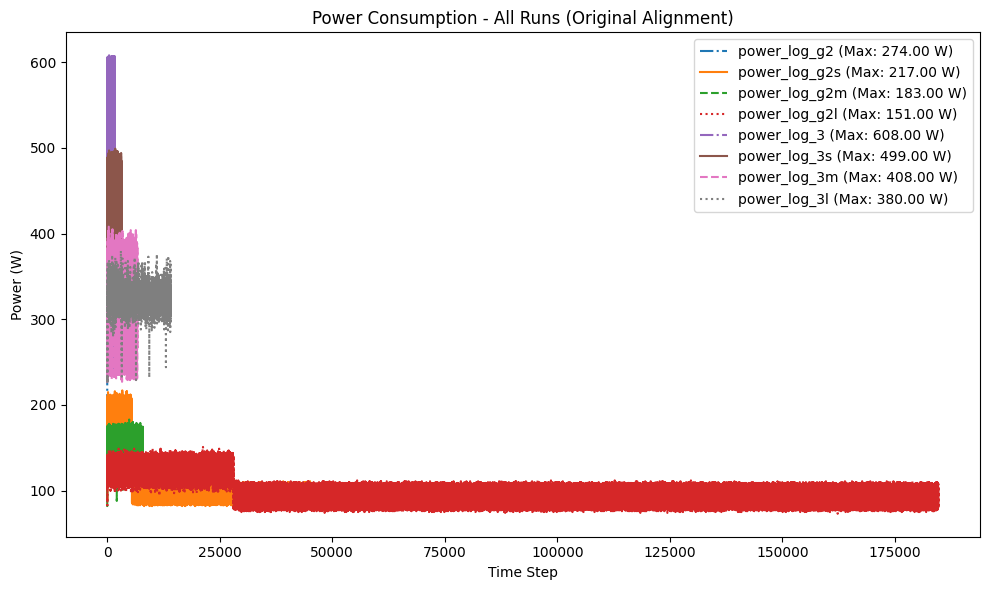

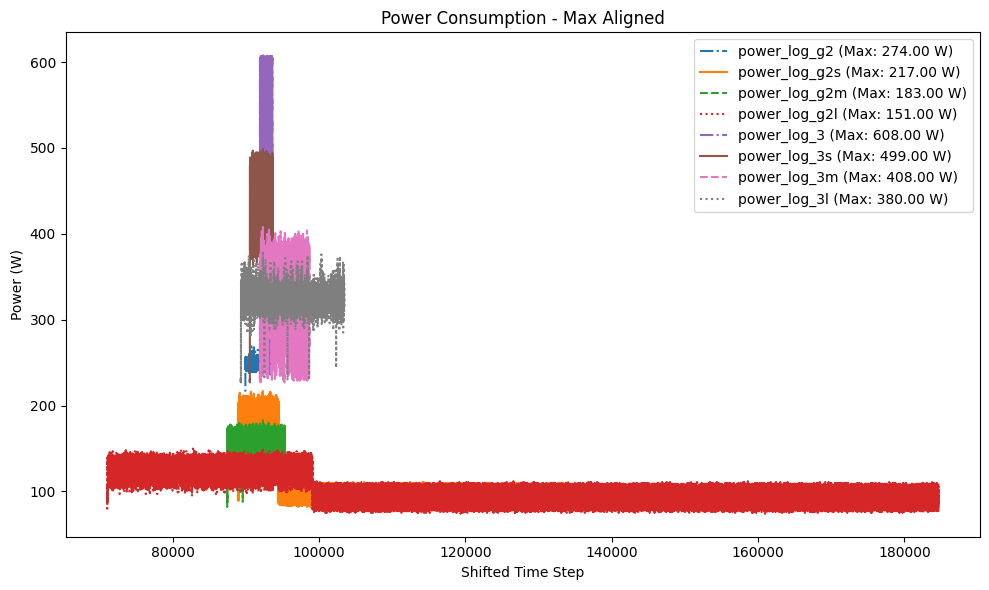

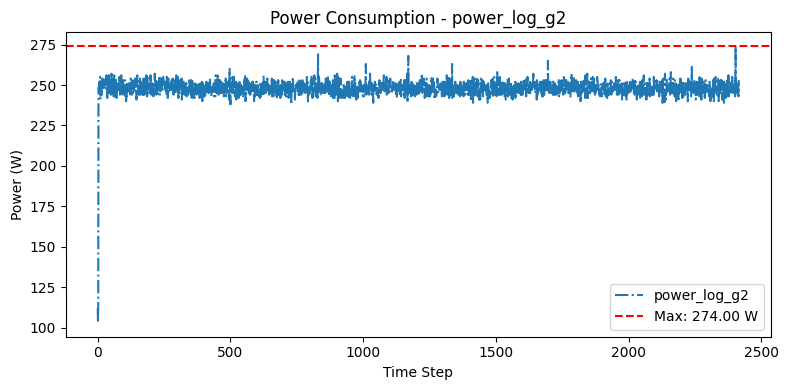

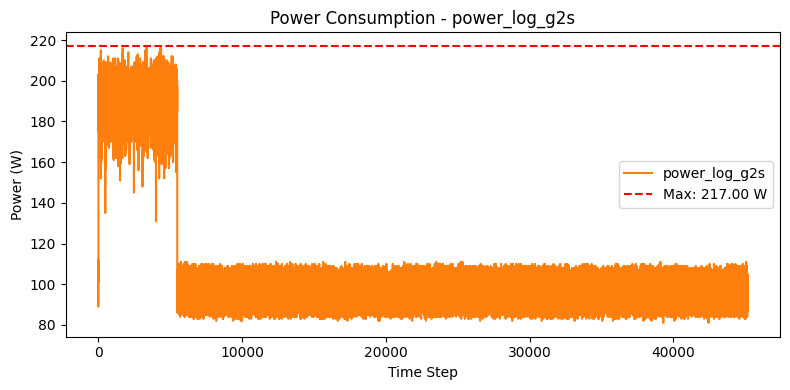

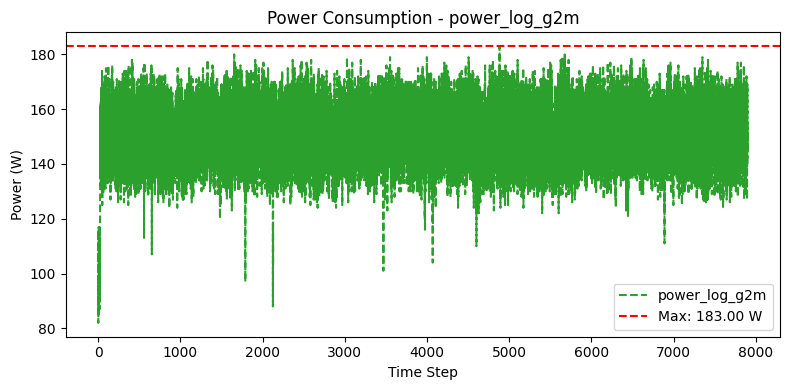

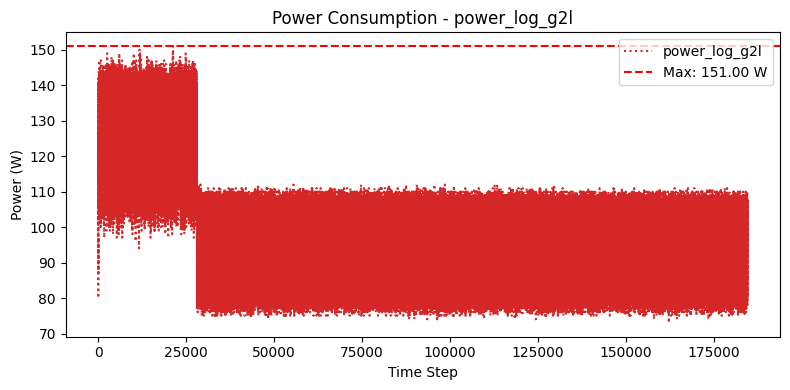

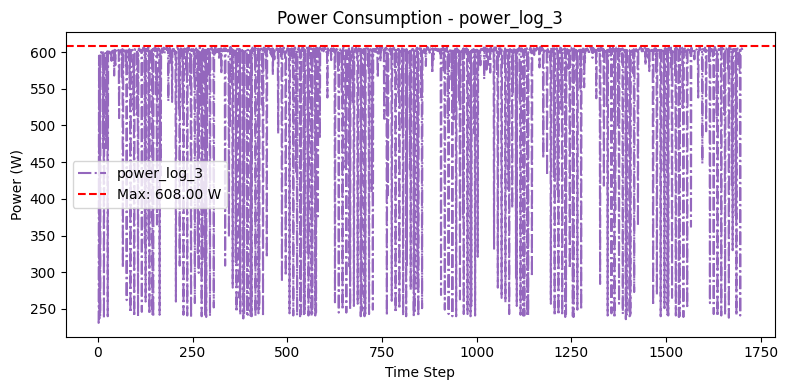

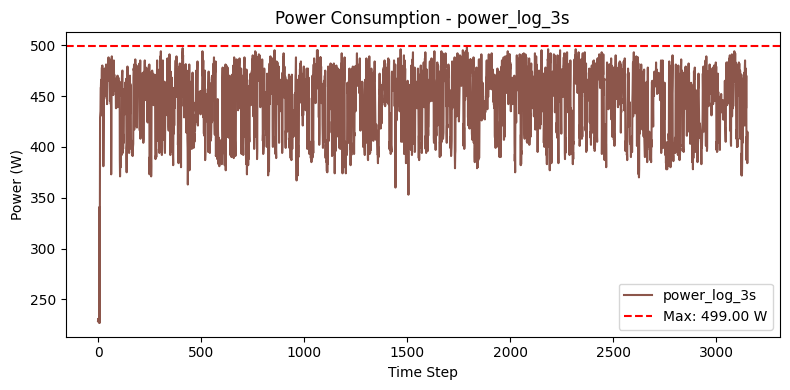

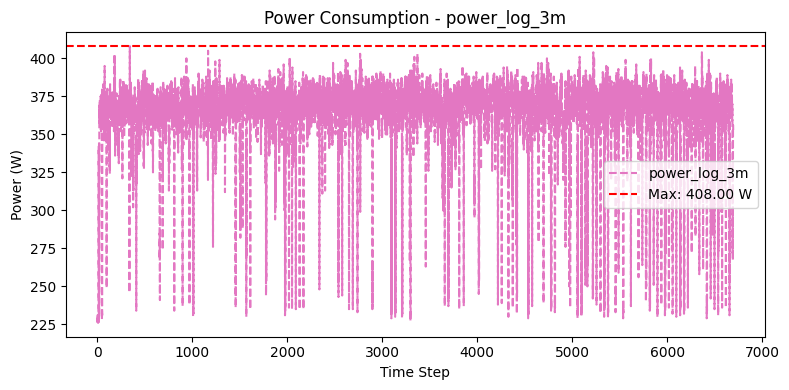

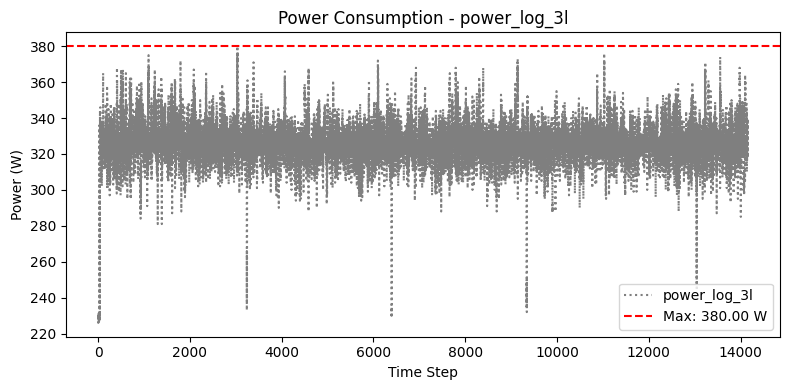


=== Max Power Consumption ===
power_log_g2: 274.00 W
power_log_g2s: 217.00 W
power_log_g2m: 183.00 W
power_log_g2l: 151.00 W
power_log_3: 608.00 W
power_log_3s: 499.00 W
power_log_3m: 408.00 W
power_log_3l: 380.00 W


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# ===== SETTINGS =====
DATA_DIR = "./power_logs"  # Change to your folder path

# Distinct colors for each config
color_map = {
    "2": "#1f77b4",    # blue
    "2s": "#ff7f0e",   # orange
    "2m": "#2ca02c",   # green
    "2l": "#d62728",   # red
    "3": "#9467bd",    # purple
    "3s": "#8c564b",   # brown
    "3m": "#e377c2",   # pink
    "3l": "#7f7f7f",   # gray
}

# Line styles
style_map = {"": "-.", "s": "-", "m": "--", "l": ":"}

# Order for plotting
plot_order = ["2", "2s", "2m", "2l", "3", "3s", "3m", "3l"]

# ===== LOAD DATA =====
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
data_dict = {}
max_values = {}
meta_info = {}

for file in csv_files:
    df = pd.read_csv(file)

    # Find power column
    power_col = None
    for col in df.columns:
        if "power" in col.lower():
            power_col = col
            break
    if power_col is None:
        print(f"⚠️ No power column found in {file}, skipping...")
        continue

    run_name = os.path.splitext(os.path.basename(file))[0]  # e.g., power_logs_g2s

    # Parse version & config
    parts = run_name.split("_")
    if len(parts) >= 2:
        version_config = parts[-1]  # e.g., 'g2', 'g2s', 'g3m'
        if version_config.startswith("g"):
            norm_cfg = version_config[1:]  # strip 'g' → '2', '2s', '3m', etc.
        else:
            norm_cfg = version_config
        gaudi_version = norm_cfg[0]  # '2' or '3'
        cfg_suffix = norm_cfg[1:]    # '', 's', 'm', 'l'
        meta_info[run_name] = (gaudi_version, cfg_suffix, norm_cfg)
    else:
        meta_info[run_name] = ("?", "?", "?")
        norm_cfg = "?"

    # Clean values
    power_values = (
        df[power_col]
        .astype(str)
        .str.strip()
        .str.replace("W", "", regex=False)
        .str.replace("w", "", regex=False)
        .astype(float)
        .dropna()
        .to_numpy()
    )

    data_dict[run_name] = power_values
    max_values[run_name] = np.max(power_values)

# ===== ALIGN FOR MAX =====
max_aligned_data = {}
max_length = max(len(v) for v in data_dict.values())

for run, values in data_dict.items():
    max_idx = np.argmax(values)
    shift = (max_length // 2) - max_idx
    aligned = np.full(max_length, np.nan)
    start = max(0, shift)
    end = min(max_length, shift + len(values))
    aligned[start:end] = values[:end - start]
    max_aligned_data[run] = aligned

# ===== SORT =====
sorted_runs = sorted(
    data_dict.keys(),
    key=lambda x: plot_order.index(meta_info[x][2]) if meta_info[x][2] in plot_order else 999
)

# ===== PLOT: ORIGINAL =====
plt.figure(figsize=(10, 6))
for run in sorted_runs:
    cfg_key = meta_info[run][2]  # normalized config like '2', '2s', etc.
    plt.plot(
        data_dict[run],
        label=f"{run} (Max: {max_values[run]:.2f} W)",
        color=color_map.get(cfg_key, "black"),
        linestyle=style_map.get(meta_info[run][1], "-")
    )
plt.title("Power Consumption - All Runs (Original Alignment)")
plt.xlabel("Time Step")
plt.ylabel("Power (W)")
plt.legend()
plt.tight_layout()
plt.show()

# ===== PLOT: MAX ALIGNED =====
plt.figure(figsize=(10, 6))
for run in sorted_runs:
    cfg_key = meta_info[run][2]
    plt.plot(
        max_aligned_data[run],
        label=f"{run} (Max: {max_values[run]:.2f} W)",
        color=color_map.get(cfg_key, "black"),
        linestyle=style_map.get(meta_info[run][1], "-")
    )
plt.title("Power Consumption - Max Aligned")
plt.xlabel("Shifted Time Step")
plt.ylabel("Power (W)")
plt.legend()
plt.tight_layout()
plt.show()

# ===== INDIVIDUAL PLOTS =====
for run in sorted_runs:
    cfg_key = meta_info[run][2]
    plt.figure(figsize=(8, 4))
    plt.plot(
        data_dict[run],
        color=color_map.get(cfg_key, "black"),
        linestyle=style_map.get(meta_info[run][1], "-"),
        label=run
    )
    plt.axhline(max_values[run], color='red', linestyle='--',
                label=f"Max: {max_values[run]:.2f} W")
    plt.title(f"Power Consumption - {run}")
    plt.xlabel("Time Step")
    plt.ylabel("Power (W)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== PRINT MAX VALUES =====
print("\n=== Max Power Consumption ===")
for run in sorted_runs:
    print(f"{run}: {max_values[run]:.2f} W")



=== Max Power Consumption ===
power_log_g2: 274.00 W
power_log_g2s: 217.00 W
power_log_g2m: 183.00 W
power_log_g2l: 151.00 W
power_log_3: 608.00 W
power_log_3s: 499.00 W
power_log_3m: 408.00 W
power_log_3l: 380.00 W


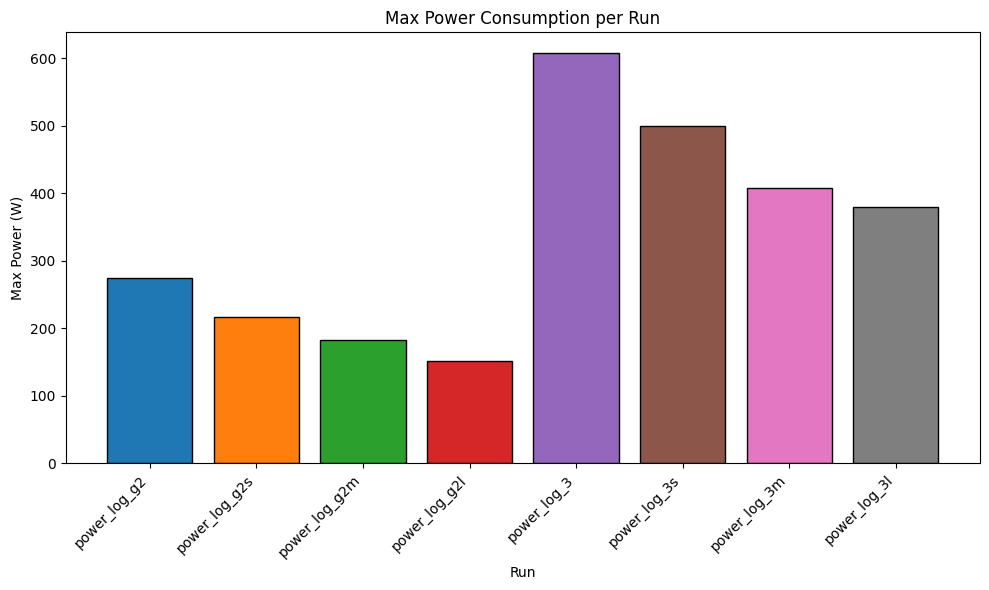

In [4]:
# ===== PRINT MAX VALUES =====
print("\n=== Max Power Consumption ===")
for run in sorted_runs:
    print(f"{run}: {max_values[run]:.2f} W")

# ===== HISTOGRAM OF MAX VALUES =====
plt.figure(figsize=(10, 6))
bars = []
labels = []
colors = []

for run in sorted_runs:
    cfg_key = meta_info[run][2]  # normalized config
    bars.append(max_values[run])
    labels.append(run)
    colors.append(color_map.get(cfg_key, "black"))

plt.bar(labels, bars, color=colors, edgecolor="black")
plt.title("Max Power Consumption per Run")
plt.xlabel("Run")
plt.ylabel("Max Power (W)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [8]:
# Example log strings
g2 = """Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 08-15 10:14:26 [__init__.py:254] Automatically detected platform hpu.
INFO 08-15 10:14:29 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-15 10:14:30 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-15 10:14:30 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-15 10:14:31 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-15 10:14:31 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 08-15 10:14:32 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-15 10:14:32 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/'}
INFO 08-15 10:14:40 [config.py:822] This model supports multiple tasks: {'embed', 'reward', 'score', 'generate', 'classify'}. Defaulting to 'generate'.
WARNING 08-15 10:14:40 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 08-15 10:14:40 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 08-15 10:14:40 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 08-15 10:14:40 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-15 10:14:40 [api_server.py:267] Started engine process with PID 3864739
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-15 10:14:43 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-15 10:14:44 [__init__.py:254] Automatically detected platform hpu.
INFO 08-15 10:14:47 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-15 10:14:47 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 08-15 10:14:47 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 08-15 10:14:47 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 08-15 10:14:47 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7df3d5815630>
INFO 08-15 10:14:48 [runtime.py:26] Environment:
INFO 08-15 10:14:48 [runtime.py:30]     hw: gaudi2
INFO 08-15 10:14:48 [runtime.py:30]     build: 1.22.0.538
INFO 08-15 10:14:48 [runtime.py:30]     engine_version: v0
INFO 08-15 10:14:48 [runtime.py:30]     bridge_mode: eager
INFO 08-15 10:14:48 [runtime.py:30]     model_type: llama
INFO 08-15 10:14:48 [runtime.py:26] Features:
INFO 08-15 10:14:48 [runtime.py:30]     fp32_alibi_biases: True
INFO 08-15 10:14:48 [runtime.py:30]     fp32_softmax: False
INFO 08-15 10:14:48 [runtime.py:30]     fused_block_softmax_adjustment: False
INFO 08-15 10:14:48 [runtime.py:30]     fused_block_softmax: False
INFO 08-15 10:14:48 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 08-15 10:14:48 [runtime.py:30]     skip_warmup: False
INFO 08-15 10:14:48 [runtime.py:30]     merged_prefill: False
INFO 08-15 10:14:48 [runtime.py:30]     use_contiguous_pa: True
INFO 08-15 10:14:48 [runtime.py:30]     use_delayed_sampling: True
INFO 08-15 10:14:48 [runtime.py:30]     use_bucketing: True
INFO 08-15 10:14:48 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 08-15 10:14:48 [runtime.py:26] User flags:
INFO 08-15 10:14:48 [runtime.py:30]     VLLM_USE_V1: False
WARNING 08-15 10:14:48 [hpu.py:135] Pin memory is not supported on HPU.
INFO 08-15 10:14:48 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-538
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 08-15 10:14:51 [parallel_state.py:1065] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.60it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.33s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.23s/it]

INFO 08-15 10:14:54 [default_loader.py:272] Loading weights took 2.68 seconds
INFO 08-15 10:14:54 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 12.55 GiB of device memory (12.56 GiB/94.62 GiB used) and 303.9 MiB of host memory (316.2 GiB/1007 GiB used)
INFO 08-15 10:14:54 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (12.56 GiB/94.62 GiB used) and -3.547 MiB of host memory (316.2 GiB/1007 GiB used)
INFO 08-15 10:14:55 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (12.56 GiB/94.62 GiB used) and -52.9 MiB of host memory (316.2 GiB/1007 GiB used)
INFO 08-15 10:14:55 [hpu_model_runner.py:1274] Loading model weights took in total 12.55 GiB of device memory (12.56 GiB/94.62 GiB used) and 303.2 MiB of host memory (316.2 GiB/1007 GiB used)
WARNING 08-15 10:14:55 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
INFO 08-15 10:14:57 [hpu_worker.py:289] Model profiling run took 476 MiB of device memory (13.02 GiB/94.62 GiB used) and 397.6 MiB of host memory (316.6 GiB/1007 GiB used)
INFO 08-15 10:14:57 [hpu_worker.py:313] Free device memory: 81.6 GiB, 73.44 GiB usable (gpu_memory_utilization=0.9), 7.344 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 66.1 GiB reserved for KV cache
INFO 08-15 10:14:57 [executor_base.py:113] # hpu blocks: 1057, # CPU blocks: 64
INFO 08-15 10:14:57 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 33.03x
INFO 08-15 10:14:57 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 08-15 10:14:57 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-15 10:14:57 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 1057, 12]
INFO 08-15 10:14:57 [common.py:117] Generated 72 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024)]
INFO 08-15 10:14:58 [hpu_worker.py:350] Initializing cache engine took 66.06 GiB of device memory (79.08 GiB/94.62 GiB used) and 4.521 GiB of host memory (321.1 GiB/1007 GiB used)
INFO 08-15 10:14:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:12 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:20 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:36 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:44 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:46 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:50 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:15:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:16:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:16:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:16:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:16:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:16:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:15.54 GiB
INFO 08-15 10:16:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/72] batch_size:256 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:16:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/72] batch_size:256 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:16:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/72] batch_size:256 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:16:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/72] batch_size:256 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:16:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/72] batch_size:256 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:16:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/72] batch_size:256 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:16:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/72] batch_size:256 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:16:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/72] batch_size:256 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:16:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/72] batch_size:128 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:16:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/72] batch_size:128 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:16:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/72] batch_size:128 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:16:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/72] batch_size:128 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:16:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/72] batch_size:128 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:16:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/72] batch_size:128 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:16:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/72] batch_size:128 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:16:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/72] batch_size:128 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:16:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/72] batch_size:64 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:16:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/72] batch_size:64 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:17:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/72] batch_size:64 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:17:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/72] batch_size:64 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:17:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/72] batch_size:64 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:17:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/72] batch_size:64 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:17:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/72] batch_size:64 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:17:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/72] batch_size:64 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:17:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/72] batch_size:32 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:17:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/72] batch_size:32 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:17:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/72] batch_size:32 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:17:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/72] batch_size:32 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:17:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/72] batch_size:32 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:17:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/72] batch_size:32 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:17:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/72] batch_size:32 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:17:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/72] batch_size:32 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:17:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/72] batch_size:16 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:17:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/72] batch_size:16 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:17:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/72] batch_size:16 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:17:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/72] batch_size:16 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:17:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/72] batch_size:16 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:18:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/72] batch_size:16 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:18:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/72] batch_size:16 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:18:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/72] batch_size:16 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:18:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/72] batch_size:8 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:18:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/72] batch_size:8 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:18:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/72] batch_size:8 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:18:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/72] batch_size:8 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:18:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/72] batch_size:8 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:18:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/72] batch_size:8 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:18:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/72] batch_size:8 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:18:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/72] batch_size:8 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:18:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/72] batch_size:4 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:18:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/72] batch_size:4 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:18:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/72] batch_size:4 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:18:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/72] batch_size:4 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:18:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/72] batch_size:4 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:18:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/72] batch_size:4 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:18:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/72] batch_size:4 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:19:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/72] batch_size:4 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:19:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/72] batch_size:2 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:19:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/72] batch_size:2 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:19:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/72] batch_size:2 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:19:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/72] batch_size:2 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:19:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/72] batch_size:2 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:19:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/72] batch_size:2 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:19:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/72] batch_size:2 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:19:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/72] batch_size:2 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:19:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/72] batch_size:1 query_len:1 num_blocks:1024 free_mem:15.54 GiB
INFO 08-15 10:19:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/72] batch_size:1 query_len:1 num_blocks:896 free_mem:15.54 GiB
INFO 08-15 10:19:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/72] batch_size:1 query_len:1 num_blocks:768 free_mem:15.54 GiB
INFO 08-15 10:19:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/72] batch_size:1 query_len:1 num_blocks:640 free_mem:15.54 GiB
INFO 08-15 10:19:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/72] batch_size:1 query_len:1 num_blocks:512 free_mem:15.54 GiB
INFO 08-15 10:19:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/72] batch_size:1 query_len:1 num_blocks:384 free_mem:15.54 GiB
INFO 08-15 10:19:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/72] batch_size:1 query_len:1 num_blocks:256 free_mem:15.54 GiB
INFO 08-15 10:20:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/72] batch_size:1 query_len:1 num_blocks:128 free_mem:15.54 GiB
INFO 08-15 10:20:04 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:31.75 KiB
INFO 08-15 10:20:04 [hpu_model_runner.py:3152] Decode captured:72 (100.0%) used_mem:0 B
INFO 08-15 10:20:04 [hpu_model_runner.py:3280] Warmup finished in 306 secs, allocated 31.75 KiB of device memory
INFO 08-15 10:20:04 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 308.79 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-15 10:20:04 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 08-15 10:20:04 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 08-15 10:20:04 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 08-15 10:20:04 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 08-15 10:20:04 [launcher.py:29] Available routes are:
INFO 08-15 10:20:04 [launcher.py:37] Route: /openapi.json, Methods: HEAD, GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /docs, Methods: HEAD, GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /redoc, Methods: HEAD, GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /health, Methods: GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /load, Methods: GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /ping, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /ping, Methods: GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /version, Methods: GET
INFO 08-15 10:20:04 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /pooling, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /classify, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /score, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /rerank, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /invocations, Methods: POST
INFO 08-15 10:20:04 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [3862924]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 08-15 11:31:45 [logger.py:43] Received request cmpl-6073fa0bc83c48c7a6ce585a020f5e2e-0: prompt: 'What is LLaMA 2 and how does it work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 365, 5661, 1529, 29871, 29906, 322, 920, 947, 372, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52590 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:31:45 [engine.py:331] Added request cmpl-6073fa0bc83c48c7a6ce585a020f5e2e-0.
INFO 08-15 11:31:45 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:31:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:31:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:31:58 [logger.py:43] Received request cmpl-da5ca3d315884f519438f00a431ef63c-0: prompt: 'Explain the architecture of a transformer model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 11258, 310, 263, 4327, 261, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56676 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:31:58 [engine.py:331] Added request cmpl-da5ca3d315884f519438f00a431ef63c-0.
INFO 08-15 11:32:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:11 [logger.py:43] Received request cmpl-03d776585068483d96ecb60c26b630b3-0: prompt: 'What are the core differences between CNN and RNN?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 7136, 12651, 1546, 29696, 322, 390, 10262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51656 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:32:11 [engine.py:331] Added request cmpl-03d776585068483d96ecb60c26b630b3-0.
INFO 08-15 11:32:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:23 [logger.py:43] Received request cmpl-9d71c9c1538c482ebe3d84571f10e5f6-0: prompt: 'Describe how attention mechanism improves translation models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 8570, 13336, 4857, 1960, 13962, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34622 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:32:23 [engine.py:331] Added request cmpl-9d71c9c1538c482ebe3d84571f10e5f6-0.
INFO 08-15 11:32:25 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:36 [logger.py:43] Received request cmpl-e7e8e2dca54c4f2c812207127c18f1ad-0: prompt: 'What is the role of positional encoding in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 2602, 284, 8025, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34596 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:32:36 [engine.py:331] Added request cmpl-e7e8e2dca54c4f2c812207127c18f1ad-0.
INFO 08-15 11:32:40 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:49 [logger.py:43] Received request cmpl-10c8ae87c47e42fb810baca52cc1f894-0: prompt: 'How does self-attention differ from cross-attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1583, 29899, 1131, 2509, 1163, 515, 4891, 29899, 1131, 2509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39978 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:32:49 [engine.py:331] Added request cmpl-10c8ae87c47e42fb810baca52cc1f894-0.
INFO 08-15 11:32:50 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:32:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:01 [logger.py:43] Received request cmpl-a18098e3590a485a9d9c7b7aa8165048-0: prompt: 'Explain the concept of tokenization in NLP.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 5993, 2133, 297, 405, 13208, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59960 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:33:01 [engine.py:331] Added request cmpl-a18098e3590a485a9d9c7b7aa8165048-0.
INFO 08-15 11:33:05 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:14 [logger.py:43] Received request cmpl-b554b947b0604978ac895e02530b312b-0: prompt: 'What is the vanishing gradient problem and how to mitigate it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 1109, 14424, 16030, 1108, 322, 920, 304, 1380, 335, 403, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38742 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:33:14 [engine.py:331] Added request cmpl-b554b947b0604978ac895e02530b312b-0.
INFO 08-15 11:33:15 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:27 [logger.py:43] Received request cmpl-b4b555c28c7244ec9413473b7d60c007-0: prompt: 'Describe how Gaudi architecture differs from NVIDIA GPUs.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 10415, 4749, 11258, 2923, 414, 515, 405, 13044, 10764, 22796, 29879, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49668 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:33:27 [engine.py:331] Added request cmpl-b4b555c28c7244ec9413473b7d60c007-0.
INFO 08-15 11:33:30 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:40 [logger.py:43] Received request cmpl-ee3d8f7fa61840ffb7940452e7c96a3f-0: prompt: 'What is model parallelism and how does it help scale large models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 8943, 1608, 322, 920, 947, 372, 1371, 6287, 2919, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54736 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:33:40 [engine.py:331] Added request cmpl-ee3d8f7fa61840ffb7940452e7c96a3f-0.
INFO 08-15 11:33:41 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:33:52 [logger.py:43] Received request cmpl-e6de2fce61d24c698fb8fb6dca9ea0c4-0: prompt: 'Explain the difference between GPT and BERT architectures.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 402, 7982, 322, 350, 20161, 6956, 1973, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59554 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:33:52 [engine.py:331] Added request cmpl-e6de2fce61d24c698fb8fb6dca9ea0c4-0.
INFO 08-15 11:33:56 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:05 [logger.py:43] Received request cmpl-58f996f894094131855a6f2eaf2f95aa-0: prompt: 'How does prompt engineering affect language model outputs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 9508, 21639, 6602, 4086, 1904, 14391, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45404 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:34:05 [engine.py:331] Added request cmpl-58f996f894094131855a6f2eaf2f95aa-0.
INFO 08-15 11:34:06 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:12 [logger.py:43] Received request cmpl-8852f0d120c44c309381f033b1599033-0: prompt: 'What is the function of layer normalization in deep networks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 7546, 4226, 2133, 297, 6483, 14379, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37462 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:34:12 [engine.py:331] Added request cmpl-8852f0d120c44c309381f033b1599033-0.
INFO 08-15 11:34:16 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:20 [logger.py:43] Received request cmpl-0a1c5f9b333a4b08a562091dc4905577-0: prompt: 'Explain causal language modeling with examples.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 3269, 284, 4086, 1904, 292, 411, 6455, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37474 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:34:20 [engine.py:331] Added request cmpl-0a1c5f9b333a4b08a562091dc4905577-0.
INFO 08-15 11:34:21 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:33 [logger.py:43] Received request cmpl-c3af1ebf02064aa094440bdcdb05ea83-0: prompt: 'What is quantization and how does it improve inference performance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 4323, 2133, 322, 920, 947, 372, 11157, 27262, 4180, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46130 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:34:33 [engine.py:331] Added request cmpl-c3af1ebf02064aa094440bdcdb05ea83-0.
INFO 08-15 11:34:36 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:46 [logger.py:43] Received request cmpl-69b5a925281d4b9f9992b9715160c33e-0: prompt: 'Describe how fine-tuning works for large language models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2691, 29899, 29873, 27964, 1736, 363, 2919, 4086, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60802 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:34:46 [engine.py:331] Added request cmpl-69b5a925281d4b9f9992b9715160c33e-0.
INFO 08-15 11:34:51 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:34:58 [logger.py:43] Received request cmpl-238da0908ebe4bc4a30e5ea88b8e5493-0: prompt: 'What are LoRA adapters and how do they help in parameter-efficient training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 4309, 4717, 594, 481, 2153, 322, 920, 437, 896, 1371, 297, 3443, 29899, 8462, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47934 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:34:58 [engine.py:331] Added request cmpl-238da0908ebe4bc4a30e5ea88b8e5493-0.
INFO 08-15 11:35:01 [metrics.py:417] Avg prompt throughput: 3.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:11 [logger.py:43] Received request cmpl-bf245cd7503a4b42974fde1bf2426600-0: prompt: 'Explain the purpose of rotary positional embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6437, 310, 5731, 653, 2602, 284, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56478 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:35:11 [engine.py:331] Added request cmpl-bf245cd7503a4b42974fde1bf2426600-0.
INFO 08-15 11:35:16 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:24 [logger.py:43] Received request cmpl-e0a00f238dc649529d97e811f63b23b0-0: prompt: 'How does DeepSpeed improve model training efficiency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 21784, 26539, 11157, 1904, 6694, 19201, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34378 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:35:24 [engine.py:331] Added request cmpl-e0a00f238dc649529d97e811f63b23b0-0.
INFO 08-15 11:35:26 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:26 [logger.py:43] Received request cmpl-a273ee91f0c3489abab76ae3aa649860-0: prompt: 'Compare data parallelism and pipeline parallelism.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 848, 8943, 1608, 322, 16439, 8943, 1608, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34390 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:35:26 [engine.py:331] Added request cmpl-a273ee91f0c3489abab76ae3aa649860-0.
INFO 08-15 11:35:31 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:39 [logger.py:43] Received request cmpl-9212a80824e342c19fc8f3aebd0d2532-0: prompt: 'What is ALiBi positional encoding?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14445, 29875, 20517, 2602, 284, 8025, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39790 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:35:39 [engine.py:331] Added request cmpl-9212a80824e342c19fc8f3aebd0d2532-0.
INFO 08-15 11:35:41 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:35:52 [logger.py:43] Received request cmpl-e7a3b5e58c1d44949034af049b816161-0: prompt: 'Describe the purpose of HF Transformers library.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6437, 310, 379, 29943, 4103, 689, 414, 3489, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57454 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:35:52 [engine.py:331] Added request cmpl-e7a3b5e58c1d44949034af049b816161-0.
INFO 08-15 11:35:56 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:04 [logger.py:43] Received request cmpl-fd3b8080bd874825a7e744e1950b1128-0: prompt: 'How do attention heads capture contextual meaning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 8570, 15883, 10446, 3030, 950, 6593, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:36:04 [engine.py:331] Added request cmpl-fd3b8080bd874825a7e744e1950b1128-0.
INFO 08-15 11:36:06 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:17 [logger.py:43] Received request cmpl-5063f3f72b4243c8b5576a5df788057e-0: prompt: 'What is dynamic batching in inference servers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 9853, 292, 297, 27262, 12424, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44608 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:36:17 [engine.py:331] Added request cmpl-5063f3f72b4243c8b5576a5df788057e-0.
INFO 08-15 11:36:21 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:30 [logger.py:43] Received request cmpl-4ae206a8866949bcaf883ef02a7231b4-0: prompt: 'Explain greedy decoding vs beam search vs sampling.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1395, 7584, 1602, 3689, 7186, 22913, 2740, 7186, 23460, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59738 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:36:30 [engine.py:331] Added request cmpl-4ae206a8866949bcaf883ef02a7231b4-0.
INFO 08-15 11:36:31 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:42 [logger.py:43] Received request cmpl-813c2f6fb4e84da4bc34e92a37ac996a-0: prompt: 'What is perplexity in language models and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 639, 10709, 537, 297, 4086, 4733, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37596 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:36:42 [engine.py:331] Added request cmpl-813c2f6fb4e84da4bc34e92a37ac996a-0.
INFO 08-15 11:36:46 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:36:55 [logger.py:43] Received request cmpl-fcce14bd134d4ad996f7b2dba19d47a9-0: prompt: 'How does mixed precision training benefit model training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 12849, 16716, 6694, 14169, 1904, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:32922 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:36:55 [engine.py:331] Added request cmpl-fcce14bd134d4ad996f7b2dba19d47a9-0.
INFO 08-15 11:36:56 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:08 [logger.py:43] Received request cmpl-7272ffe109bd420589dd04b303fcda6f-0: prompt: 'What is the function of the softmax layer in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 278, 4964, 3317, 7546, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52918 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:37:08 [engine.py:331] Added request cmpl-7272ffe109bd420589dd04b303fcda6f-0.
INFO 08-15 11:37:11 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:20 [logger.py:43] Received request cmpl-24f62ab1383d45bbb6d7b934ea18e6c5-0: prompt: "Explain embeddings and how they're used in NLP models.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 8297, 29881, 886, 322, 920, 896, 29915, 276, 1304, 297, 405, 13208, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34874 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:37:20 [engine.py:331] Added request cmpl-24f62ab1383d45bbb6d7b934ea18e6c5-0.
INFO 08-15 11:37:21 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:33 [logger.py:43] Received request cmpl-1a44f62fed374836892cb93f0dffbc0c-0: prompt: "Describe the function of the tokenizer's vocabulary.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 740, 310, 278, 5993, 3950, 29915, 29879, 7931, 370, 352, 653, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52058 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:37:33 [engine.py:331] Added request cmpl-1a44f62fed374836892cb93f0dffbc0c-0.
INFO 08-15 11:37:36 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:46 [logger.py:43] Received request cmpl-e57b2ddf57304fc7a8eb888f7c4a30dc-0: prompt: 'What is causal masking in transformer decoders?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 3269, 284, 11105, 292, 297, 4327, 261, 1602, 397, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42194 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:37:46 [engine.py:331] Added request cmpl-e57b2ddf57304fc7a8eb888f7c4a30dc-0.
INFO 08-15 11:37:46 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:37:59 [logger.py:43] Received request cmpl-74398194d51e4336b74b1a186c8b3213-0: prompt: 'How does gradient checkpointing reduce memory usage?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 16030, 1423, 3149, 292, 10032, 3370, 8744, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:32914 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:37:59 [engine.py:331] Added request cmpl-74398194d51e4336b74b1a186c8b3213-0.
INFO 08-15 11:38:01 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:06 [logger.py:43] Received request cmpl-4988e23f033e42ec9dc9e7305a0bee0d-0: prompt: 'Explain the difference between encoder-decoder and decoder-only models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 2094, 6119, 29899, 7099, 6119, 322, 1602, 6119, 29899, 6194, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39382 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:38:06 [engine.py:331] Added request cmpl-4988e23f033e42ec9dc9e7305a0bee0d-0.
INFO 08-15 11:38:11 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:19 [logger.py:43] Received request cmpl-b31980bbdf24411ea7e09bb7aba0d8cf-0: prompt: 'What is zero-shot vs few-shot vs fine-tuned inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5225, 29899, 8962, 7186, 2846, 29899, 8962, 7186, 2691, 29899, 29873, 348, 287, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52658 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:38:19 [engine.py:331] Added request cmpl-b31980bbdf24411ea7e09bb7aba0d8cf-0.
INFO 08-15 11:38:21 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:31 [logger.py:43] Received request cmpl-cde7bbe0c5c5435caccb9033e6b514b6-0: prompt: 'What are prompt templates and why do they matter?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 9508, 17475, 322, 2020, 437, 896, 4383, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47966 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:38:31 [engine.py:331] Added request cmpl-cde7bbe0c5c5435caccb9033e6b514b6-0.
INFO 08-15 11:38:36 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:44 [logger.py:43] Received request cmpl-bdf77ad5d2fe424a87ad2f9bcd53c69e-0: prompt: 'Explain the role of BOS and EOS tokens in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 350, 3267, 322, 382, 3267, 18897, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50012 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:38:44 [engine.py:331] Added request cmpl-bdf77ad5d2fe424a87ad2f9bcd53c69e-0.
INFO 08-15 11:38:46 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:38:57 [logger.py:43] Received request cmpl-e644577b2e29445c8711d55252ca0135-0: prompt: 'What is a floating-point tensor and how is it represented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 16526, 29899, 3149, 12489, 322, 920, 338, 372, 9875, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57258 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:38:57 [engine.py:331] Added request cmpl-e644577b2e29445c8711d55252ca0135-0.
INFO 08-15 11:39:01 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:09 [logger.py:43] Received request cmpl-9a434579822149c9bfe7039633684755-0: prompt: 'What are hypernetworks in neural architectures?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11266, 11618, 29879, 297, 19677, 6956, 1973, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45892 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:39:09 [engine.py:331] Added request cmpl-9a434579822149c9bfe7039633684755-0.
INFO 08-15 11:39:11 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:22 [logger.py:43] Received request cmpl-f655a3ee5351483fa45caf85d5269d22-0: prompt: 'Explain MoE (Mixture of Experts) architecture.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4546, 29923, 313, 29924, 29875, 15546, 310, 28224, 1372, 29897, 11258, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59624 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:39:22 [engine.py:331] Added request cmpl-f655a3ee5351483fa45caf85d5269d22-0.
INFO 08-15 11:39:26 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:35 [logger.py:43] Received request cmpl-7266193063ec4bfd9e42e7d31be24780-0: prompt: 'What is distillation in model compression?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1320, 453, 362, 297, 1904, 24221, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40688 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:39:35 [engine.py:331] Added request cmpl-7266193063ec4bfd9e42e7d31be24780-0.
INFO 08-15 11:39:36 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:48 [logger.py:43] Received request cmpl-247afa14db9249ecb1789712bdf53658-0: prompt: 'How do you implement top-k and top-p sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 2334, 2246, 29899, 29895, 322, 2246, 29899, 29886, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51528 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:39:48 [engine.py:331] Added request cmpl-247afa14db9249ecb1789712bdf53658-0.
INFO 08-15 11:39:51 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:39:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:00 [logger.py:43] Received request cmpl-b8a4931445884843892a2e381a3c5701-0: prompt: 'What is a vector database and how is it used with LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4608, 2566, 322, 920, 338, 372, 1304, 411, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60884 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:40:00 [engine.py:331] Added request cmpl-b8a4931445884843892a2e381a3c5701-0.
INFO 08-15 11:40:01 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:11 [logger.py:43] Received request cmpl-06c6139a5fa4491da002b85130585c8b-0: prompt: 'Describe how you would use RAG (Retrieval Augmented Generation).', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 366, 723, 671, 390, 10051, 313, 8015, 2546, 791, 22333, 358, 287, 28203, 467], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50798 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:40:11 [engine.py:331] Added request cmpl-06c6139a5fa4491da002b85130585c8b-0.
INFO 08-15 11:40:16 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:24 [logger.py:43] Received request cmpl-54d71a87ffd2465799d3aee4f9ce4c74-0: prompt: 'What is streaming inference and how is it used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 24820, 27262, 322, 920, 338, 372, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51482 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:40:24 [engine.py:331] Added request cmpl-54d71a87ffd2465799d3aee4f9ce4c74-0.
INFO 08-15 11:40:26 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:37 [logger.py:43] Received request cmpl-3e8d45a2117b4f5ab15d607a9e223d35-0: prompt: 'How does TTFT relate to user-perceived latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 323, 29911, 7818, 29279, 304, 1404, 29899, 546, 346, 2347, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43662 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:40:37 [engine.py:331] Added request cmpl-3e8d45a2117b4f5ab15d607a9e223d35-0.
INFO 08-15 11:40:41 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:49 [logger.py:43] Received request cmpl-a0e02b1e860249689f2b62edab68b041-0: prompt: 'Explain transformer decoder blocks layer-by-layer.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4327, 261, 1602, 6119, 10930, 7546, 29899, 1609, 29899, 13148, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49098 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:40:49 [engine.py:331] Added request cmpl-a0e02b1e860249689f2b62edab68b041-0.
INFO 08-15 11:40:51 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:40:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:02 [logger.py:43] Received request cmpl-eae20b28e6ff440899566e1c067cf0b3-0: prompt: 'What is a KV cache in transformer inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 476, 29963, 7090, 297, 4327, 261, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43348 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:41:02 [engine.py:331] Added request cmpl-eae20b28e6ff440899566e1c067cf0b3-0.
INFO 08-15 11:41:06 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:15 [logger.py:43] Received request cmpl-97cec31595ca42a798d634a0cb11ae1f-0: prompt: 'Describe token-by-token generation and its challenges.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 29899, 1609, 29899, 6979, 12623, 322, 967, 18066, 267, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59824 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:41:15 [engine.py:331] Added request cmpl-97cec31595ca42a798d634a0cb11ae1f-0.
INFO 08-15 11:41:16 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:27 [logger.py:43] Received request cmpl-d62f7d56e80e4b3b8177f44c20f3145f-0: prompt: 'How does LLaMA 2 compare to GPT-3.5?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 365, 5661, 1529, 29871, 29906, 7252, 304, 402, 7982, 29899, 29941, 29889, 29945, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49470 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:41:27 [engine.py:331] Added request cmpl-d62f7d56e80e4b3b8177f44c20f3145f-0.
INFO 08-15 11:41:31 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:40 [logger.py:43] Received request cmpl-4337c980cf704c9aab5616b5dcd8faa9-0: prompt: 'Explain the training data pipeline for a large model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6694, 848, 16439, 363, 263, 2919, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53898 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:41:40 [engine.py:331] Added request cmpl-4337c980cf704c9aab5616b5dcd8faa9-0.
INFO 08-15 11:41:41 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:41:53 [logger.py:43] Received request cmpl-6b575a2b952644e880d866df684b2051-0: prompt: 'What are the ethical concerns with generative models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 411, 1176, 1230, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35702 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:41:53 [engine.py:331] Added request cmpl-6b575a2b952644e880d866df684b2051-0.
INFO 08-15 11:41:56 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:05 [logger.py:43] Received request cmpl-147b6f828a3d41bd887b5085e9668f12-0: prompt: 'How do transformers process multilingual text?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 4327, 414, 1889, 1773, 6504, 950, 1426, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36698 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:42:05 [engine.py:331] Added request cmpl-147b6f828a3d41bd887b5085e9668f12-0.
INFO 08-15 11:42:06 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:18 [logger.py:43] Received request cmpl-f26e75728f9b4c9a8b0a8b6dcbefdf95-0: prompt: 'What are flash attention mechanisms?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11013, 8570, 7208, 12903, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41560 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:42:18 [engine.py:331] Added request cmpl-f26e75728f9b4c9a8b0a8b6dcbefdf95-0.
INFO 08-15 11:42:21 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:31 [logger.py:43] Received request cmpl-59a14d773bcd424dac32dc6b004c7095-0: prompt: 'Describe how memory-efficient attention works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 3370, 29899, 8462, 8570, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57322 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:42:31 [engine.py:331] Added request cmpl-59a14d773bcd424dac32dc6b004c7095-0.
INFO 08-15 11:42:31 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:36 [logger.py:43] Received request cmpl-2c83b4c719364419b9664c3b8decfce4-0: prompt: 'What is inference throughput and how is it calculated?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 1549, 649, 322, 920, 338, 372, 12833, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57330 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:42:36 [engine.py:331] Added request cmpl-2c83b4c719364419b9664c3b8decfce4-0.
INFO 08-15 11:42:36 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:48 [logger.py:43] Received request cmpl-ba1f1d51d4314a40be89e949e9b3d0c1-0: prompt: 'Explain how masked self-attention works in BERT.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 11105, 287, 1583, 29899, 1131, 2509, 1736, 297, 350, 20161, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52368 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:42:48 [engine.py:331] Added request cmpl-ba1f1d51d4314a40be89e949e9b3d0c1-0.
INFO 08-15 11:42:51 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:42:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:01 [logger.py:43] Received request cmpl-0a1744863156483b9878017e0088d8cc-0: prompt: 'How do instruction-tuned models differ from base models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 15278, 29899, 29873, 348, 287, 4733, 1163, 515, 2967, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38186 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:43:01 [engine.py:331] Added request cmpl-0a1744863156483b9878017e0088d8cc-0.
INFO 08-15 11:43:01 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:14 [logger.py:43] Received request cmpl-b4178785e4834f7994090160a271d727-0: prompt: 'Describe an RLHF (Reinforcement Learning from Human Feedback) process.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 390, 29931, 29950, 29943, 313, 1123, 262, 1454, 13561, 29257, 515, 12968, 5169, 287, 1627, 29897, 1889, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48302 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:43:14 [engine.py:331] Added request cmpl-b4178785e4834f7994090160a271d727-0.
INFO 08-15 11:43:17 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:26 [logger.py:43] Received request cmpl-ca35fecb447244068651f9c9fb06360c-0: prompt: 'What is SFT (Supervised Fine-Tuning) in LLM training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 317, 7818, 313, 19111, 11292, 28896, 29899, 29911, 27964, 29897, 297, 365, 26369, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54050 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:43:26 [engine.py:331] Added request cmpl-ca35fecb447244068651f9c9fb06360c-0.
INFO 08-15 11:43:27 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:39 [logger.py:43] Received request cmpl-1eabcf6519d345a497151d72440c01f5-0: prompt: 'Explain the role of HPU in Gaudi chips.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 379, 7056, 297, 10415, 4749, 521, 4512, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35810 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:43:39 [engine.py:331] Added request cmpl-1eabcf6519d345a497151d72440c01f5-0.
INFO 08-15 11:43:42 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:43:52 [logger.py:43] Received request cmpl-097660cb156445a8bf3ab75b9f5dd74c-0: prompt: 'What is a causal attention mask?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 3269, 284, 8570, 11105, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57398 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:43:52 [engine.py:331] Added request cmpl-097660cb156445a8bf3ab75b9f5dd74c-0.
INFO 08-15 11:43:57 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:04 [logger.py:43] Received request cmpl-11c8e7b2a7064272989b8038181af203-0: prompt: 'Describe the HF `generate()` function in Transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 379, 29943, 421, 17158, 2555, 740, 297, 4103, 689, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49464 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:44:04 [engine.py:331] Added request cmpl-11c8e7b2a7064272989b8038181af203-0.
INFO 08-15 11:44:07 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:17 [logger.py:43] Received request cmpl-2435f6c828e644b4914455c951454892-0: prompt: 'Explain differences between T5, BART, and GPT models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 12651, 1546, 323, 29945, 29892, 350, 8322, 29892, 322, 402, 7982, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39646 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:44:17 [engine.py:331] Added request cmpl-2435f6c828e644b4914455c951454892-0.
INFO 08-15 11:44:22 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:30 [logger.py:43] Received request cmpl-7f38a2f078324d97ae51ef717b5620b6-0: prompt: 'What is model checkpointing and resumption?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 1423, 3149, 292, 322, 620, 28069, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53958 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:44:30 [engine.py:331] Added request cmpl-7f38a2f078324d97ae51ef717b5620b6-0.
INFO 08-15 11:44:32 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:42 [logger.py:43] Received request cmpl-bddd5d78576f491e87088ed96f30d372-0: prompt: 'Describe how checkpoint sharding works in distributed training.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1423, 3149, 528, 20272, 1736, 297, 13235, 6694, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33312 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:44:42 [engine.py:331] Added request cmpl-bddd5d78576f491e87088ed96f30d372-0.
INFO 08-15 11:44:47 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:44:55 [logger.py:43] Received request cmpl-755e83bbea3c40ebb90b5e3d45c82f82-0: prompt: 'How are model weights stored in HuggingFace format?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 18177, 6087, 297, 379, 688, 3460, 23360, 3402, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58300 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:44:55 [engine.py:331] Added request cmpl-755e83bbea3c40ebb90b5e3d45c82f82-0.
INFO 08-15 11:44:57 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:08 [logger.py:43] Received request cmpl-23dc37b9af5f48a7bf4c4cd498c8e69c-0: prompt: 'Explain the impact of batch size on training and inference.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 10879, 310, 9853, 2159, 373, 6694, 322, 27262, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54476 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:45:08 [engine.py:331] Added request cmpl-23dc37b9af5f48a7bf4c4cd498c8e69c-0.
INFO 08-15 11:45:12 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:21 [logger.py:43] Received request cmpl-2a83e1468b0f4e96afaca1321ac063f8-0: prompt: 'What are fused kernels and why are they fast?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 285, 3880, 413, 824, 1379, 322, 2020, 526, 896, 5172, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39160 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:45:21 [engine.py:331] Added request cmpl-2a83e1468b0f4e96afaca1321ac063f8-0.
INFO 08-15 11:45:22 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:33 [logger.py:43] Received request cmpl-75be29c5cde34ce4bad6895d2dc6aec9-0: prompt: 'How does the `AutoModelForCausalLM` class work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 421, 12300, 3195, 2831, 29907, 1485, 284, 26369, 29952, 770, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49084 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:45:33 [engine.py:331] Added request cmpl-75be29c5cde34ce4bad6895d2dc6aec9-0.
INFO 08-15 11:45:37 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:46 [logger.py:43] Received request cmpl-d9531e9664d94c04b0be7ec951f19f69-0: prompt: 'What are tensor parallel and tensor slicing?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 12489, 8943, 322, 12489, 269, 506, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53980 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:45:46 [engine.py:331] Added request cmpl-d9531e9664d94c04b0be7ec951f19f69-0.
INFO 08-15 11:45:47 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:45:59 [logger.py:43] Received request cmpl-578846949d8b4010b5978167e1f10943-0: prompt: 'Describe the key steps of model serving using vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 1820, 6576, 310, 1904, 16330, 773, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38410 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:45:59 [engine.py:331] Added request cmpl-578846949d8b4010b5978167e1f10943-0.
INFO 08-15 11:46:02 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:11 [logger.py:43] Received request cmpl-1930edb7985a4f1ca527e2e03523ac94-0: prompt: 'What are inference graphs in deep learning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 27262, 18445, 297, 6483, 6509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51594 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:46:11 [engine.py:331] Added request cmpl-1930edb7985a4f1ca527e2e03523ac94-0.
INFO 08-15 11:46:12 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:24 [logger.py:43] Received request cmpl-e9d70db523384915bd2cae2f7b037807-0: prompt: 'What is a streaming response in OpenAI-style APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 2933, 297, 4673, 23869, 29899, 3293, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43652 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:46:24 [engine.py:331] Added request cmpl-e9d70db523384915bd2cae2f7b037807-0.
INFO 08-15 11:46:27 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:37 [logger.py:43] Received request cmpl-2173bac3bd764f2f8135653160e4bfe5-0: prompt: 'How does speculative decoding reduce latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1580, 28524, 1602, 3689, 10032, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34560 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:46:37 [engine.py:331] Added request cmpl-2173bac3bd764f2f8135653160e4bfe5-0.
INFO 08-15 11:46:37 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:45 [logger.py:43] Received request cmpl-79372e05fa72490c862e9c4d0a91de65-0: prompt: 'What is JAX and how is it different from PyTorch?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 435, 6604, 322, 920, 338, 372, 1422, 515, 10772, 29911, 25350, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49798 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:46:45 [engine.py:331] Added request cmpl-79372e05fa72490c862e9c4d0a91de65-0.
INFO 08-15 11:46:47 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:46:58 [logger.py:43] Received request cmpl-21a44723d56346a3955b365643f250b4-0: prompt: 'Describe lazy loading of weights in vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 17366, 8363, 310, 18177, 297, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50164 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:46:58 [engine.py:331] Added request cmpl-21a44723d56346a3955b365643f250b4-0.
INFO 08-15 11:47:02 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:11 [logger.py:43] Received request cmpl-311c92b766184373be31d9d880665c62-0: prompt: 'Explain the role of SynapseAI in Gaudi software stack.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 10829, 481, 344, 23869, 297, 10415, 4749, 7047, 5096, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38340 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:47:11 [engine.py:331] Added request cmpl-311c92b766184373be31d9d880665c62-0.
INFO 08-15 11:47:12 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:23 [logger.py:43] Received request cmpl-d97293eb7e3a4bba8b8cf4305b7fce99-0: prompt: 'What are the differences between HPU and GPU tensors?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 12651, 1546, 379, 7056, 322, 22796, 25187, 943, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59610 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:47:23 [engine.py:331] Added request cmpl-d97293eb7e3a4bba8b8cf4305b7fce99-0.
INFO 08-15 11:47:27 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:36 [logger.py:43] Received request cmpl-401ee1c83aba459f83c393dd4a1a5dd9-0: prompt: 'What are the limitations of LLaMA 2?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 27028, 310, 365, 5661, 1529, 29871, 29906, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55320 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:47:36 [engine.py:331] Added request cmpl-401ee1c83aba459f83c393dd4a1a5dd9-0.
INFO 08-15 11:47:37 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:49 [logger.py:43] Received request cmpl-91e839cb7b8b46b8b5e222a5e5be4f3e-0: prompt: 'How is multilingual performance evaluated in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 1773, 6504, 950, 4180, 19030, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47806 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:47:49 [engine.py:331] Added request cmpl-91e839cb7b8b46b8b5e222a5e5be4f3e-0.
INFO 08-15 11:47:52 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:47:55 [logger.py:43] Received request cmpl-fe4fe93a2918459f9024c5d538487664-0: prompt: 'Describe an example use of prompt tuning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 1342, 671, 310, 9508, 18515, 292, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56082 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:47:55 [engine.py:331] Added request cmpl-fe4fe93a2918459f9024c5d538487664-0.
INFO 08-15 11:47:57 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:08 [logger.py:43] Received request cmpl-bce1543268564d83ad2daa5e671908d3-0: prompt: 'What is the attention bottleneck and how to address it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 8570, 18046, 29880, 1600, 384, 322, 920, 304, 3211, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36024 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:48:08 [engine.py:331] Added request cmpl-bce1543268564d83ad2daa5e671908d3-0.
INFO 08-15 11:48:12 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:21 [logger.py:43] Received request cmpl-f4e642e4c8fc44c490500f248d352bde-0: prompt: 'How does token alignment affect downstream tasks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 22239, 6602, 1623, 5461, 9595, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40342 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:48:21 [engine.py:331] Added request cmpl-f4e642e4c8fc44c490500f248d352bde-0.
INFO 08-15 11:48:22 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:33 [logger.py:43] Received request cmpl-22dda5c55ecb4d8cbbd47f527de9972d-0: prompt: 'What are the challenges in inference on edge devices?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 18066, 267, 297, 27262, 373, 7636, 9224, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55468 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:48:33 [engine.py:331] Added request cmpl-22dda5c55ecb4d8cbbd47f527de9972d-0.
INFO 08-15 11:48:37 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:46 [logger.py:43] Received request cmpl-d7bcbbd40d6944efb5ab1d49590456e2-0: prompt: 'Explain the principle behind rotary embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 12502, 5742, 5731, 653, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56542 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:48:46 [engine.py:331] Added request cmpl-d7bcbbd40d6944efb5ab1d49590456e2-0.
INFO 08-15 11:48:47 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:48:59 [logger.py:43] Received request cmpl-ae79c78756a242f490568f2702ff4a7a-0: prompt: 'How does temperature affect language model output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 10430, 6602, 4086, 1904, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50996 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:48:59 [engine.py:331] Added request cmpl-ae79c78756a242f490568f2702ff4a7a-0.
INFO 08-15 11:49:02 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:11 [logger.py:43] Received request cmpl-02ac53bd96af480d8f857f341fe65be3-0: prompt: 'What are stop sequences in generation APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5040, 15602, 297, 12623, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53124 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:49:11 [engine.py:331] Added request cmpl-02ac53bd96af480d8f857f341fe65be3-0.
INFO 08-15 11:49:12 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:24 [logger.py:43] Received request cmpl-15587f7368314bdba9196e42bc1f005e-0: prompt: 'Describe token streaming latency optimization.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 24820, 23316, 1270, 13883, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50898 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:49:24 [engine.py:331] Added request cmpl-15587f7368314bdba9196e42bc1f005e-0.
INFO 08-15 11:49:27 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:37 [logger.py:43] Received request cmpl-04e53adb47504f3c8e627a54af84bd82-0: prompt: 'How to evaluate hallucinations in language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 12713, 1682, 262, 800, 297, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33624 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:49:37 [engine.py:331] Added request cmpl-04e53adb47504f3c8e627a54af84bd82-0.
INFO 08-15 11:49:37 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:49 [logger.py:43] Received request cmpl-dbfaea3651e143c38aeb3cb6845fe0ca-0: prompt: 'What is the purpose of `bos_token_id`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 27737, 29918, 6979, 29918, 333, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57022 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:49:49 [engine.py:331] Added request cmpl-dbfaea3651e143c38aeb3cb6845fe0ca-0.
INFO 08-15 11:49:52 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:49:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:02 [logger.py:43] Received request cmpl-f6ad0185f4e84515ba6f0e4ff6631140-0: prompt: 'How are fused attention layers implemented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 285, 3880, 8570, 15359, 8762, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41754 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:50:02 [engine.py:331] Added request cmpl-f6ad0185f4e84515ba6f0e4ff6631140-0.
INFO 08-15 11:50:02 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:15 [logger.py:43] Received request cmpl-1ae5fea82b2f42388f59239f43d8cd55-0: prompt: 'Describe a pipeline for deploying LLaMA 2 in production.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 16439, 363, 7246, 292, 365, 5661, 1529, 29871, 29906, 297, 5802, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33054 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:50:15 [engine.py:331] Added request cmpl-1ae5fea82b2f42388f59239f43d8cd55-0.
INFO 08-15 11:50:17 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:27 [logger.py:43] Received request cmpl-508d5ba9fa1e49f2a461278e9da2ec78-0: prompt: 'How does instruction following improve model usability?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 15278, 1494, 11157, 1904, 502, 3097, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52038 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:50:27 [engine.py:331] Added request cmpl-508d5ba9fa1e49f2a461278e9da2ec78-0.
INFO 08-15 11:50:32 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:40 [logger.py:43] Received request cmpl-b9d9ea47cb21476d97e6bc6355478ade-0: prompt: 'What is a sequence-to-sequence model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 5665, 29899, 517, 29899, 16506, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:32774 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:50:40 [engine.py:331] Added request cmpl-b9d9ea47cb21476d97e6bc6355478ade-0.
INFO 08-15 11:50:42 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:50:53 [logger.py:43] Received request cmpl-86dac5d2844c4287a62b810723c94e80-0: prompt: 'What is the purpose of `pad_token_id` in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 8305, 29918, 6979, 29918, 333, 29952, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56886 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:50:53 [engine.py:331] Added request cmpl-86dac5d2844c4287a62b810723c94e80-0.
INFO 08-15 11:50:57 [logger.py:43] Received request cmpl-9f219bdee4004d95a5711cec138d89f4-0: prompt: 'Explain the concept of auto-regressive generation.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 4469, 29899, 276, 3663, 573, 12623, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56890 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:50:57 [engine.py:331] Added request cmpl-9f219bdee4004d95a5711cec138d89f4-0.
INFO 08-15 11:50:57 [metrics.py:417] Avg prompt throughput: 5.8 tokens/s, Avg generation throughput: 78.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:09 [logger.py:43] Received request cmpl-e78194cfe266495184c7dfc3733695ad-0: prompt: 'How is top-p sampling different from nucleus sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 2246, 29899, 29886, 23460, 1422, 515, 22699, 375, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34134 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:51:09 [engine.py:331] Added request cmpl-e78194cfe266495184c7dfc3733695ad-0.
INFO 08-15 11:51:12 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:13 [logger.py:43] Received request cmpl-1fca105e8c6c4f8e87375e7509e0267e-0: prompt: 'What are decoding strategies for safe responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1602, 3689, 16650, 583, 363, 9109, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45430 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:51:13 [engine.py:331] Added request cmpl-1fca105e8c6c4f8e87375e7509e0267e-0.
INFO 08-15 11:51:17 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:26 [logger.py:43] Received request cmpl-927a85bca19f40d1a634f10337734430-0: prompt: 'How are model prompts structured in ChatML?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 9508, 29879, 2281, 2955, 297, 678, 271, 1988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48848 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:51:26 [engine.py:331] Added request cmpl-927a85bca19f40d1a634f10337734430-0.
INFO 08-15 11:51:27 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:39 [logger.py:43] Received request cmpl-5290558caf5447bfbef5d9e6f3144223-0: prompt: 'What is a system prompt in chat inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1788, 9508, 297, 13563, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35068 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:51:39 [engine.py:331] Added request cmpl-5290558caf5447bfbef5d9e6f3144223-0.
INFO 08-15 11:51:42 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:51 [logger.py:43] Received request cmpl-dd9706b04fb14ee6a7726a7d49b4e33b-0: prompt: 'How do you batch requests for high throughput?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 9853, 7274, 363, 1880, 1549, 649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54472 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:51:51 [engine.py:331] Added request cmpl-dd9706b04fb14ee6a7726a7d49b4e33b-0.
INFO 08-15 11:51:52 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:51:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:04 [logger.py:43] Received request cmpl-bf4333ba2ef54431ad7f938a6ab7fe10-0: prompt: 'Explain model serving with `transformers + vLLM`.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1904, 16330, 411, 421, 9067, 414, 718, 325, 2208, 29924, 1412], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45634 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:52:04 [engine.py:331] Added request cmpl-bf4333ba2ef54431ad7f938a6ab7fe10-0.
INFO 08-15 11:52:07 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:17 [logger.py:43] Received request cmpl-497d90dd1c4d4cdc95da7c124a777c82-0: prompt: 'What is Triton Inference Server?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 323, 768, 265, 512, 1659, 5656, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36990 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:52:17 [engine.py:331] Added request cmpl-497d90dd1c4d4cdc95da7c124a777c82-0.
INFO 08-15 11:52:17 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:29 [logger.py:43] Received request cmpl-a5b222dbb515465488404c78bc1413e7-0: prompt: 'Describe the significance of large context windows.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 26002, 310, 2919, 3030, 5417, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42478 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:52:29 [engine.py:331] Added request cmpl-a5b222dbb515465488404c78bc1413e7-0.
INFO 08-15 11:52:32 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:42 [logger.py:43] Received request cmpl-dbfcefc94a594877ac60ad83d7aac196-0: prompt: 'What is dynamic quantization in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 4323, 2133, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37360 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:52:42 [engine.py:331] Added request cmpl-dbfcefc94a594877ac60ad83d7aac196-0.
INFO 08-15 11:52:42 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:52:55 [logger.py:43] Received request cmpl-86692c4cb57140e7aac02c198f2a84e2-0: prompt: 'How to prevent prompt injection in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5557, 9508, 20859, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56062 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:52:55 [engine.py:331] Added request cmpl-86692c4cb57140e7aac02c198f2a84e2-0.
INFO 08-15 11:52:58 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:07 [logger.py:43] Received request cmpl-7b350dbd9849497c8c632079d3c45f56-0: prompt: 'What are attention scores and how are they computed?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 19435, 322, 920, 526, 896, 15712, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36850 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:53:07 [engine.py:331] Added request cmpl-7b350dbd9849497c8c632079d3c45f56-0.
INFO 08-15 11:53:08 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:20 [logger.py:43] Received request cmpl-5d6eb13bc8204ca7a00ed4a8be0c214b-0: prompt: 'What are residual connections in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10995, 950, 12368, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42246 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:53:20 [engine.py:331] Added request cmpl-5d6eb13bc8204ca7a00ed4a8be0c214b-0.
INFO 08-15 11:53:23 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:33 [logger.py:43] Received request cmpl-6022458a6b1c41ae96d6f436d0395177-0: prompt: 'How to handle long sequences in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1472, 15602, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49484 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:53:33 [engine.py:331] Added request cmpl-6022458a6b1c41ae96d6f436d0395177-0.
INFO 08-15 11:53:38 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:46 [logger.py:43] Received request cmpl-e8167fc72ff44bfa8d1ade6e5d6abbb7-0: prompt: 'Explain the use of flash attention v2.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 671, 310, 11013, 8570, 325, 29906, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56538 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:53:46 [engine.py:331] Added request cmpl-e8167fc72ff44bfa8d1ade6e5d6abbb7-0.
INFO 08-15 11:53:48 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:53:58 [logger.py:43] Received request cmpl-baf0ee31426944eaa873aeeb6273427a-0: prompt: 'What is a greedy search in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1395, 7584, 2740, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48930 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:53:58 [engine.py:331] Added request cmpl-baf0ee31426944eaa873aeeb6273427a-0.
INFO 08-15 11:54:03 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:11 [logger.py:43] Received request cmpl-f7de2acae5ab4485982341d6537c7189-0: prompt: 'How do checkpoints improve fault tolerance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 1423, 9748, 11157, 12570, 20341, 749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54650 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:54:11 [engine.py:331] Added request cmpl-f7de2acae5ab4485982341d6537c7189-0.
INFO 08-15 11:54:13 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:24 [logger.py:43] Received request cmpl-f7f9de5372094ec4a0ab971a45931f70-0: prompt: 'Describe how text-to-text generation works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1426, 29899, 517, 29899, 726, 12623, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48666 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:54:24 [engine.py:331] Added request cmpl-f7f9de5372094ec4a0ab971a45931f70-0.
INFO 08-15 11:54:28 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:36 [logger.py:43] Received request cmpl-0bbcc6d2588641acb184684883e1dbb5-0: prompt: 'Explain cosine similarity in embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6776, 457, 29501, 297, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56666 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:54:36 [engine.py:331] Added request cmpl-0bbcc6d2588641acb184684883e1dbb5-0.
INFO 08-15 11:54:38 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:49 [logger.py:43] Received request cmpl-de1a008c41784642982d7e5b4cd7db7d-0: prompt: 'What is token-wise parallelism?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5993, 29899, 3538, 8943, 1608, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46482 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:54:49 [engine.py:331] Added request cmpl-de1a008c41784642982d7e5b4cd7db7d-0.
INFO 08-15 11:54:53 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:54:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:02 [logger.py:43] Received request cmpl-356d0c8de17544b39f1d31c0d0732d76-0: prompt: 'How do shared embeddings help in decoder-only models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 7258, 8297, 29881, 886, 1371, 297, 1602, 6119, 29899, 6194, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54210 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:55:02 [engine.py:331] Added request cmpl-356d0c8de17544b39f1d31c0d0732d76-0.
INFO 08-15 11:55:03 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:14 [logger.py:43] Received request cmpl-5a49a321bef648e2a5ffdebdb56baef3-0: prompt: 'Explain how to measure latency in model output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 5645, 23316, 1270, 297, 1904, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56556 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:55:14 [engine.py:331] Added request cmpl-5a49a321bef648e2a5ffdebdb56baef3-0.
INFO 08-15 11:55:18 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:27 [logger.py:43] Received request cmpl-92fb699205254cb1978cfec3a0198fb6-0: prompt: 'What is the purpose of dropout during training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 5768, 449, 2645, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40796 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:55:27 [engine.py:331] Added request cmpl-92fb699205254cb1978cfec3a0198fb6-0.
INFO 08-15 11:55:28 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:40 [logger.py:43] Received request cmpl-d4dce7cfd127412b85701765dd854cc0-0: prompt: 'What is the role of GELU activation in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 402, 6670, 29965, 26229, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43504 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:55:40 [engine.py:331] Added request cmpl-d4dce7cfd127412b85701765dd854cc0-0.
INFO 08-15 11:55:43 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:52 [logger.py:43] Received request cmpl-4c1af35379ff45e19aa634f29593554c-0: prompt: 'Explain forward and backward pass in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6375, 322, 1250, 1328, 1209, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52886 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:55:52 [engine.py:331] Added request cmpl-4c1af35379ff45e19aa634f29593554c-0.
INFO 08-15 11:55:53 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:55:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:05 [logger.py:43] Received request cmpl-104390d72072487eaf78c141c3ef83cc-0: prompt: 'What is speculative decoding and how does it help?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 1602, 3689, 322, 920, 947, 372, 1371, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34066 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:56:05 [engine.py:331] Added request cmpl-104390d72072487eaf78c141c3ef83cc-0.
INFO 08-15 11:56:08 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:18 [logger.py:43] Received request cmpl-b7a003c842ed43f1a4d9a0246d3f3efe-0: prompt: 'How to optimize HPU memory usage during inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 24656, 379, 7056, 3370, 8744, 2645, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37822 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:56:18 [engine.py:331] Added request cmpl-b7a003c842ed43f1a4d9a0246d3f3efe-0.
INFO 08-15 11:56:18 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:23 [logger.py:43] Received request cmpl-77dc8d82ce2b4230be63ce7ca0b94394-0: prompt: 'Explain profiling for LLM inference performance.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 20077, 292, 363, 365, 26369, 27262, 4180, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47242 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:56:23 [engine.py:331] Added request cmpl-77dc8d82ce2b4230be63ce7ca0b94394-0.
INFO 08-15 11:56:23 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:36 [logger.py:43] Received request cmpl-45b4871004954fff9b9681056e505c5a-0: prompt: 'How to compute inter-token latency per request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1006, 29899, 6979, 23316, 1270, 639, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43942 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:56:36 [engine.py:331] Added request cmpl-45b4871004954fff9b9681056e505c5a-0.
INFO 08-15 11:56:38 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:48 [logger.py:43] Received request cmpl-734fa376222a4110b9fccf3720a71d20-0: prompt: 'What is the difference between BFloat16 and Float16?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 350, 11031, 29896, 29953, 322, 27842, 29896, 29953, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41934 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:56:48 [engine.py:331] Added request cmpl-734fa376222a4110b9fccf3720a71d20-0.
INFO 08-15 11:56:53 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:56:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:01 [logger.py:43] Received request cmpl-51852cd55d5642f88c3295f36d97a075-0: prompt: 'What are logits and how are they interpreted?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1480, 1169, 322, 920, 526, 896, 21551, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33826 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:57:01 [engine.py:331] Added request cmpl-51852cd55d5642f88c3295f36d97a075-0.
INFO 08-15 11:57:03 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:14 [logger.py:43] Received request cmpl-ad803d20c5ba4d379278e99708c1132c-0: prompt: 'What is log probability in token prediction?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1480, 6976, 297, 5993, 18988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47904 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:57:14 [engine.py:331] Added request cmpl-ad803d20c5ba4d379278e99708c1132c-0.
INFO 08-15 11:57:18 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:26 [logger.py:43] Received request cmpl-cbbc32a203dc489f8482861129a98d87-0: prompt: 'How to use `TextStreamer` for streaming output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 671, 421, 1626, 3835, 261, 29952, 363, 24820, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44822 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:57:26 [engine.py:331] Added request cmpl-cbbc32a203dc489f8482861129a98d87-0.
INFO 08-15 11:57:28 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:30 [logger.py:43] Received request cmpl-8fe0c3e6263d4b9eae0392c802b9f885-0: prompt: 'How to tokenize and detokenize a prompt manually?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5993, 675, 322, 1439, 4476, 675, 263, 9508, 7522, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44836 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:57:30 [engine.py:331] Added request cmpl-8fe0c3e6263d4b9eae0392c802b9f885-0.
INFO 08-15 11:57:33 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:42 [logger.py:43] Received request cmpl-79a0e1feca57466caf1c7e642b9c3a46-0: prompt: 'Describe how a prompt flows through the transformer layers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 263, 9508, 24536, 1549, 278, 4327, 261, 15359, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54632 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:57:42 [engine.py:331] Added request cmpl-79a0e1feca57466caf1c7e642b9c3a46-0.
INFO 08-15 11:57:43 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:55 [logger.py:43] Received request cmpl-5424f359fc354c1ea0b5883f3fe5fd91-0: prompt: 'How to handle EOS in streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 382, 3267, 297, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37300 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:57:55 [engine.py:331] Added request cmpl-5424f359fc354c1ea0b5883f3fe5fd91-0.
INFO 08-15 11:57:58 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:57:59 [logger.py:43] Received request cmpl-fb179b027a6344c19ddccef86e419e41-0: prompt: 'What is a model config JSON in HF models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1904, 2295, 4663, 297, 379, 29943, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37306 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:57:59 [engine.py:331] Added request cmpl-fb179b027a6344c19ddccef86e419e41-0.
INFO 08-15 11:58:03 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:12 [logger.py:43] Received request cmpl-95c734af02e44ba18f7fcd447e1a82a8-0: prompt: 'What is kv_cache reuse in decoder models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 10908, 29918, 8173, 24270, 297, 1602, 6119, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43498 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:58:12 [engine.py:331] Added request cmpl-95c734af02e44ba18f7fcd447e1a82a8-0.
INFO 08-15 11:58:13 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:25 [logger.py:43] Received request cmpl-ae0580d332b14079b1aec5a808df71b7-0: prompt: 'Describe a scenario of real-time chatbot streaming.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 10483, 310, 1855, 29899, 2230, 13563, 7451, 24820, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48790 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:58:25 [engine.py:331] Added request cmpl-ae0580d332b14079b1aec5a808df71b7-0.
INFO 08-15 11:58:28 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:37 [logger.py:43] Received request cmpl-22fa61ff3e8a48ba8e622f4918bf3a1c-0: prompt: 'How to compute throughput with variable prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1549, 649, 411, 2286, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52732 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:58:37 [engine.py:331] Added request cmpl-22fa61ff3e8a48ba8e622f4918bf3a1c-0.
INFO 08-15 11:58:38 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:50 [logger.py:43] Received request cmpl-46109c0d07514ba28cd4144af66d41c9-0: prompt: 'How does `max_new_tokens` differ from `max_length`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 421, 3317, 29918, 1482, 29918, 517, 12360, 29952, 1163, 515, 421, 3317, 29918, 2848, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60494 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:58:50 [engine.py:331] Added request cmpl-46109c0d07514ba28cd4144af66d41c9-0.
INFO 08-15 11:58:53 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:58:56 [logger.py:43] Received request cmpl-ca66fcad86e54d90b3d7c7ea38210443-0: prompt: 'Explain the difference between loss and perplexity.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 6410, 322, 639, 10709, 537, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44356 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:58:56 [engine.py:331] Added request cmpl-ca66fcad86e54d90b3d7c7ea38210443-0.
INFO 08-15 11:58:58 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:08 [logger.py:43] Received request cmpl-9cbff9fc4c14478b98b3d01bc2df096b-0: prompt: 'How to log benchmark results in a structured CSV?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1480, 23513, 2582, 297, 263, 2281, 2955, 16874, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44250 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:59:08 [engine.py:331] Added request cmpl-9cbff9fc4c14478b98b3d01bc2df096b-0.
INFO 08-15 11:59:13 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:21 [logger.py:43] Received request cmpl-ca8bb97141a841a0b64ca4dae2e678aa-0: prompt: 'What are attention heads and how do they specialize?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 15883, 322, 920, 437, 896, 4266, 675, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55226 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:59:21 [engine.py:331] Added request cmpl-ca8bb97141a841a0b64ca4dae2e678aa-0.
INFO 08-15 11:59:23 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:34 [logger.py:43] Received request cmpl-36b61074b13345249ce99f84837d1a78-0: prompt: 'How to ensure reproducible benchmarking?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9801, 9483, 15520, 23513, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42400 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:59:34 [engine.py:331] Added request cmpl-36b61074b13345249ce99f84837d1a78-0.
INFO 08-15 11:59:38 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:47 [logger.py:43] Received request cmpl-8a5bca59f5424418aa3d40f7eaaa6092-0: prompt: 'What are model shards and when are they used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1904, 528, 3163, 322, 746, 526, 896, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50232 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:59:47 [engine.py:331] Added request cmpl-8a5bca59f5424418aa3d40f7eaaa6092-0.
INFO 08-15 11:59:48 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 11:59:59 [logger.py:43] Received request cmpl-88c3f4bbbb4e4ab894e51066a2b327f0-0: prompt: 'Explain the relationship between prompt length and latency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 9443, 1546, 9508, 3309, 322, 23316, 1270, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33634 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 11:59:59 [engine.py:331] Added request cmpl-88c3f4bbbb4e4ab894e51066a2b327f0-0.
INFO 08-15 12:00:03 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:12 [logger.py:43] Received request cmpl-083f83797e654ee198ecb37746ee2d41-0: prompt: 'What is batch inference and why is it faster?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 9853, 27262, 322, 2020, 338, 372, 8473, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36864 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:00:12 [engine.py:331] Added request cmpl-083f83797e654ee198ecb37746ee2d41-0.
INFO 08-15 12:00:13 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:17 [logger.py:43] Received request cmpl-c2501f888aae4346aae5b1448e79d05e-0: prompt: 'What are rotary sin-cos embeddings?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5731, 653, 4457, 29899, 3944, 8297, 29881, 886, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36874 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:00:17 [engine.py:331] Added request cmpl-c2501f888aae4346aae5b1448e79d05e-0.
INFO 08-15 12:00:18 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:29 [logger.py:43] Received request cmpl-478eba74ce5c4ef59aa41fcf4a5e67da-0: prompt: "Describe HuggingFace's `AutoTokenizer` features.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 379, 688, 3460, 23360, 29915, 29879, 421, 12300, 6066, 3950, 29952, 5680, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56822 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:00:29 [engine.py:331] Added request cmpl-478eba74ce5c4ef59aa41fcf4a5e67da-0.
INFO 08-15 12:00:33 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:42 [logger.py:43] Received request cmpl-2375be0ecbb44aff83e787953cb1ea24-0: prompt: 'How does positional encoding interact with attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 2602, 284, 8025, 16254, 411, 8570, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51882 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:00:42 [engine.py:331] Added request cmpl-2375be0ecbb44aff83e787953cb1ea24-0.
INFO 08-15 12:00:43 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:55 [logger.py:43] Received request cmpl-3429026d0c3b4ccab095b782c1c66f37-0: prompt: 'What is a streaming callback in Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 6939, 297, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50866 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:00:55 [engine.py:331] Added request cmpl-3429026d0c3b4ccab095b782c1c66f37-0.
INFO 08-15 12:00:58 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:00:58 [logger.py:43] Received request cmpl-ee212344babb4ace979f34a20b0049dc-0: prompt: 'How to benchmark models using curl and Python?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 4733, 773, 11051, 322, 5132, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50872 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:00:58 [engine.py:331] Added request cmpl-ee212344babb4ace979f34a20b0049dc-0.
INFO 08-15 12:01:03 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:11 [logger.py:43] Received request cmpl-2ce652d54a36497793a5606771670e8d-0: prompt: 'How to parse streaming responses from vLLM?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 6088, 24820, 20890, 515, 325, 2208, 29924, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37586 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:01:11 [engine.py:331] Added request cmpl-2ce652d54a36497793a5606771670e8d-0.
INFO 08-15 12:01:13 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:24 [logger.py:43] Received request cmpl-215cd50a9c11464fb11fafbeff50b0c0-0: prompt: 'How does deep caching work in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 6483, 22488, 664, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38046 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:01:24 [engine.py:331] Added request cmpl-215cd50a9c11464fb11fafbeff50b0c0-0.
INFO 08-15 12:01:28 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:36 [logger.py:43] Received request cmpl-4540cb38bba946ce82a25a17298abf03-0: prompt: 'What is a prompt-truncation error?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 9508, 29899, 509, 4661, 362, 1059, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46678 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:01:36 [engine.py:331] Added request cmpl-4540cb38bba946ce82a25a17298abf03-0.
INFO 08-15 12:01:38 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:49 [logger.py:43] Received request cmpl-2716b2d68f8942cea4fadff7ad3c8586-0: prompt: 'Explain the role of tokenizer config files.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 5993, 3950, 2295, 2066, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33322 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:01:49 [engine.py:331] Added request cmpl-2716b2d68f8942cea4fadff7ad3c8586-0.
INFO 08-15 12:01:53 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:01:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:02 [logger.py:43] Received request cmpl-21c6818d40204b7c9f0f616043982679-0: prompt: 'How to batch multiple prompts into one request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9853, 2999, 9508, 29879, 964, 697, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56950 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:02:02 [engine.py:331] Added request cmpl-21c6818d40204b7c9f0f616043982679-0.
INFO 08-15 12:02:03 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:15 [logger.py:43] Received request cmpl-fb2acd3c041342d0b71df93e079ce173-0: prompt: 'What is a chat template in HuggingFace?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 13563, 4472, 297, 379, 688, 3460, 23360, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37674 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:02:15 [engine.py:331] Added request cmpl-fb2acd3c041342d0b71df93e079ce173-0.
INFO 08-15 12:02:18 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:27 [logger.py:43] Received request cmpl-0ca3b19e19c24092ad564583a1db6fa5-0: prompt: 'What is inference latency and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 23316, 1270, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54046 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:02:27 [engine.py:331] Added request cmpl-0ca3b19e19c24092ad564583a1db6fa5-0.
INFO 08-15 12:02:28 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:40 [logger.py:43] Received request cmpl-75b1c0b0ad224ad4a8e6917d09cd2fda-0: prompt: 'How to reduce memory footprint of LLaMA models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10032, 3370, 3661, 2158, 310, 365, 5661, 1529, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58432 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:02:40 [engine.py:331] Added request cmpl-75b1c0b0ad224ad4a8e6917d09cd2fda-0.
INFO 08-15 12:02:44 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:53 [logger.py:43] Received request cmpl-9a190952f3b8404a9883c73bad32817f-0: prompt: 'What is the difference between `generation_config.json` and `config.json`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 421, 4738, 362, 29918, 2917, 29889, 3126, 29952, 322, 421, 2917, 29889, 3126, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56154 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:02:53 [engine.py:331] Added request cmpl-9a190952f3b8404a9883c73bad32817f-0.
INFO 08-15 12:02:54 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 78.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:02:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:03 [logger.py:43] Received request cmpl-214ceda21b034ff088e8427f28d185d7-0: prompt: 'What is a quantized model and how is it served?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4323, 1891, 1904, 322, 920, 338, 372, 6766, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52520 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:03:03 [engine.py:331] Added request cmpl-214ceda21b034ff088e8427f28d185d7-0.
INFO 08-15 12:03:04 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:15 [logger.py:43] Received request cmpl-fd63396f19b344bc8ae318fa80216c14-0: prompt: 'How to handle prompt overflow in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 9508, 11969, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39150 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:03:15 [engine.py:331] Added request cmpl-fd63396f19b344bc8ae318fa80216c14-0.
INFO 08-15 12:03:19 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:21 [logger.py:43] Received request cmpl-ae95d8cfe2134c07a84f3f59d634eded-0: prompt: 'What is warmup time in inference pipelines?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14294, 786, 931, 297, 27262, 8450, 24210, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55592 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:03:21 [engine.py:331] Added request cmpl-ae95d8cfe2134c07a84f3f59d634eded-0.
INFO 08-15 12:03:24 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:34 [logger.py:43] Received request cmpl-07bea75237ef45ec802caacfa7657fd2-0: prompt: 'How to stream JSON tokens using curl?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4840, 4663, 18897, 773, 11051, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46276 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:03:34 [engine.py:331] Added request cmpl-07bea75237ef45ec802caacfa7657fd2-0.
INFO 08-15 12:03:34 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:46 [logger.py:43] Received request cmpl-ff346692207e4c929221d909d05e7a9b-0: prompt: 'What is a `generate_with_streaming()` wrapper?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 421, 17158, 29918, 2541, 29918, 5461, 292, 2555, 14476, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56804 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:03:46 [engine.py:331] Added request cmpl-ff346692207e4c929221d909d05e7a9b-0.
INFO 08-15 12:03:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:03:59 [logger.py:43] Received request cmpl-707ff35799ff4d1d83a0a0368ed315d9-0: prompt: 'How to evaluate TTFT and ITL for multiple prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 323, 29911, 7818, 322, 13315, 29931, 363, 2999, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59750 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:03:59 [engine.py:331] Added request cmpl-707ff35799ff4d1d83a0a0368ed315d9-0.
INFO 08-15 12:04:04 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:12 [logger.py:43] Received request cmpl-e981f19de0f546ea8d64686a631dcd3b-0: prompt: 'What are server cold starts in model serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1923, 11220, 8665, 297, 1904, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57504 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:04:12 [engine.py:331] Added request cmpl-e981f19de0f546ea8d64686a631dcd3b-0.
INFO 08-15 12:04:14 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:24 [logger.py:43] Received request cmpl-41422e50cdd348ba86f01613856e4bae-0: prompt: 'Explain how to avoid padding inefficiencies.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 4772, 7164, 297, 29872, 2416, 819, 2478, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35418 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:04:24 [engine.py:331] Added request cmpl-41422e50cdd348ba86f01613856e4bae-0.
INFO 08-15 12:04:29 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:37 [logger.py:43] Received request cmpl-4cdea4dd45ae43268b6a91c93d94dccc-0: prompt: 'How does tokenizer pre-processing affect TTFT?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 3950, 758, 29899, 19170, 6602, 323, 29911, 7818, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47588 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:04:37 [engine.py:331] Added request cmpl-4cdea4dd45ae43268b6a91c93d94dccc-0.
INFO 08-15 12:04:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:50 [logger.py:43] Received request cmpl-6de09a37f9674da0a1a9e3917ec4e38e-0: prompt: 'How to track per-prompt latency in logs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5702, 639, 29899, 14032, 415, 23316, 1270, 297, 10748, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39806 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:04:50 [engine.py:331] Added request cmpl-6de09a37f9674da0a1a9e3917ec4e38e-0.
INFO 08-15 12:04:54 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:04:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:02 [logger.py:43] Received request cmpl-d3990e99bc68463e8ce552eaa4e01460-0: prompt: 'Explain streaming benchmarks with high concurrency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 24820, 23513, 29879, 411, 1880, 3022, 10880, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41732 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:05:02 [engine.py:331] Added request cmpl-d3990e99bc68463e8ce552eaa4e01460-0.
INFO 08-15 12:05:04 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:15 [logger.py:43] Received request cmpl-37b68e3ccf444418a47d4dff9c29affd-0: prompt: 'How to calculate power usage per prompt?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 8147, 3081, 8744, 639, 9508, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52308 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:05:15 [engine.py:331] Added request cmpl-37b68e3ccf444418a47d4dff9c29affd-0.
INFO 08-15 12:05:19 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:28 [logger.py:43] Received request cmpl-c33d84e156cb4bf8b3a7b4ace27e93fc-0: prompt: 'How does the tokenizer handle emojis and symbols?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 5993, 3950, 4386, 953, 3848, 275, 322, 15072, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49742 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:05:28 [engine.py:331] Added request cmpl-c33d84e156cb4bf8b3a7b4ace27e93fc-0.
INFO 08-15 12:05:29 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:41 [logger.py:43] Received request cmpl-39344ff28b70463480a0a93530994cec-0: prompt: 'How does model size affect inference latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1904, 2159, 6602, 27262, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42860 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:05:41 [engine.py:331] Added request cmpl-39344ff28b70463480a0a93530994cec-0.
INFO 08-15 12:05:44 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:53 [logger.py:43] Received request cmpl-14d0e737a0ee4609aedc97ae88faad13-0: prompt: 'How to debug slow streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4744, 5232, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37288 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:05:53 [engine.py:331] Added request cmpl-14d0e737a0ee4609aedc97ae88faad13-0.
INFO 08-15 12:05:54 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:05:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:06 [logger.py:43] Received request cmpl-424f1558c1e842daae0760fc93d8c2ab-0: prompt: 'What causes generation to stall midway?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 9946, 12623, 304, 380, 497, 7145, 1582, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40292 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:06:06 [engine.py:331] Added request cmpl-424f1558c1e842daae0760fc93d8c2ab-0.
INFO 08-15 12:06:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:19 [logger.py:43] Received request cmpl-5d9a13e8db7741f5b5271a452b28428d-0: prompt: 'How to load a model on HPU using HF Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 2254, 263, 1904, 373, 379, 7056, 773, 379, 29943, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51528 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:06:19 [engine.py:331] Added request cmpl-5d9a13e8db7741f5b5271a452b28428d-0.
INFO 08-15 12:06:19 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:30 [logger.py:43] Received request cmpl-ca4450580e84476fbbd711c6949c0560-0: prompt: 'How to pass prompt + history into a chat model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1209, 9508, 718, 4955, 964, 263, 13563, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39442 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:06:30 [engine.py:331] Added request cmpl-ca4450580e84476fbbd711c6949c0560-0.
INFO 08-15 12:06:34 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:43 [logger.py:43] Received request cmpl-9a2f735a284243f897f1af01d76b6d69-0: prompt: 'What is an OpenAI-compatible inference API?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 385, 4673, 23869, 29899, 23712, 27262, 3450, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36966 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:06:43 [engine.py:331] Added request cmpl-9a2f735a284243f897f1af01d76b6d69-0.
INFO 08-15 12:06:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:06:55 [logger.py:43] Received request cmpl-6754da85f6b34f87a33175073a19e012-0: prompt: 'How to handle decoding errors in stream?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1602, 3689, 4436, 297, 4840, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60442 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:06:55 [engine.py:331] Added request cmpl-6754da85f6b34f87a33175073a19e012-0.
INFO 08-15 12:06:59 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:08 [logger.py:43] Received request cmpl-c16a576b63b24e69a4f652c0a3e340a9-0: prompt: 'What are temperature vs randomness in sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10430, 7186, 4036, 2264, 297, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56166 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:07:08 [engine.py:331] Added request cmpl-c16a576b63b24e69a4f652c0a3e340a9-0.
INFO 08-15 12:07:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:21 [logger.py:43] Received request cmpl-6cd1f4e2210d40799d3e5e65d0102cbb-0: prompt: 'Explain token logprobs in output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 5993, 1480, 771, 5824, 297, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43522 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:07:21 [engine.py:331] Added request cmpl-6cd1f4e2210d40799d3e5e65d0102cbb-0.
INFO 08-15 12:07:24 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:33 [logger.py:43] Received request cmpl-57f9be1123944a83ad0d2f669a2eadb1-0: prompt: 'How to measure and reduce TTFT on Gaudi?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5645, 322, 10032, 323, 29911, 7818, 373, 10415, 4749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38394 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:07:33 [engine.py:331] Added request cmpl-57f9be1123944a83ad0d2f669a2eadb1-0.
INFO 08-15 12:07:34 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:46 [logger.py:43] Received request cmpl-c812c9b8c0204f478c04ae9c34911267-0: prompt: 'Explain the internals of HF `generate()` loop.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 2836, 1338, 310, 379, 29943, 421, 17158, 2555, 2425, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39154 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:07:46 [engine.py:331] Added request cmpl-c812c9b8c0204f478c04ae9c34911267-0.
INFO 08-15 12:07:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:07:59 [logger.py:43] Received request cmpl-6deed4ef0e9847319da7c82d9847e4d1-0: prompt: 'What is speculative token generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 5993, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54470 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:07:59 [engine.py:331] Added request cmpl-6deed4ef0e9847319da7c82d9847e4d1-0.
INFO 08-15 12:07:59 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:12 [logger.py:43] Received request cmpl-922a9843119649cf95950c48df5928a1-0: prompt: 'What are possible failure points in vLLM serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1950, 10672, 3291, 297, 325, 2208, 29924, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42984 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:08:12 [engine.py:331] Added request cmpl-922a9843119649cf95950c48df5928a1-0.
INFO 08-15 12:08:14 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:24 [logger.py:43] Received request cmpl-7655b927b3c540b3bb9a816499ba3f5f-0: prompt: 'How to catch stream decoding errors gracefully?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4380, 4840, 1602, 3689, 4436, 17659, 3730, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54286 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:08:24 [engine.py:331] Added request cmpl-7655b927b3c540b3bb9a816499ba3f5f-0.
INFO 08-15 12:08:29 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:37 [logger.py:43] Received request cmpl-329d7ea6a2c54d68a547076f1bf23df4-0: prompt: 'How to enable/disable kv caching in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9025, 29914, 20472, 10908, 22488, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56130 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:08:37 [engine.py:331] Added request cmpl-329d7ea6a2c54d68a547076f1bf23df4-0.
INFO 08-15 12:08:39 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:50 [logger.py:43] Received request cmpl-fc45908b61b640ff85ca4caae0f5c07b-0: prompt: 'What are challenges of multilingual streaming inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 18066, 267, 310, 1773, 6504, 950, 24820, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53548 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:08:50 [engine.py:331] Added request cmpl-fc45908b61b640ff85ca4caae0f5c07b-0.
INFO 08-15 12:08:54 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:08:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:02 [logger.py:43] Received request cmpl-9f669fc132a148349f6a6a42ff8b6fc7-0: prompt: 'How to benchmark with different model precisions?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 411, 1422, 1904, 12132, 1080, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33236 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:09:02 [engine.py:331] Added request cmpl-9f669fc132a148349f6a6a42ff8b6fc7-0.
INFO 08-15 12:09:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:15 [logger.py:43] Received request cmpl-b64eb45ea9ea47c1a0483980a80ddbc8-0: prompt: 'What is the tradeoff between token latency and batch size?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 11302, 2696, 1546, 5993, 23316, 1270, 322, 9853, 2159, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51876 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:09:15 [engine.py:331] Added request cmpl-b64eb45ea9ea47c1a0483980a80ddbc8-0.
INFO 08-15 12:09:19 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:28 [logger.py:43] Received request cmpl-2ce342985c124d788bc72f2d66356104-0: prompt: 'Describe the advantages and limitations of transformer-based neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 25486, 322, 27028, 310, 4327, 261, 29899, 6707, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40428 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:09:28 [engine.py:331] Added request cmpl-2ce342985c124d788bc72f2d66356104-0.
INFO 08-15 12:09:29 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:40 [logger.py:43] Received request cmpl-8601713ad3d74a0ba1e538f4330ff8bf-0: prompt: 'Explain the concept of overfitting in machine learning and how to prevent it.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 975, 29888, 5367, 297, 4933, 6509, 322, 920, 304, 5557, 372, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58620 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:09:40 [engine.py:331] Added request cmpl-8601713ad3d74a0ba1e538f4330ff8bf-0.
INFO 08-15 12:09:44 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:53 [logger.py:43] Received request cmpl-296872f12eb0436d8c4ae19aea3402b6-0: prompt: 'How does the attention mechanism work in transformer models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 8570, 13336, 664, 297, 4327, 261, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60976 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:09:53 [engine.py:331] Added request cmpl-296872f12eb0436d8c4ae19aea3402b6-0.
INFO 08-15 12:09:54 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:09:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:06 [logger.py:43] Received request cmpl-d0ab321632984360b0b5b2fbcd5a08ff-0: prompt: 'Summarize the main differences between supervised and unsupervised learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 6991, 3034, 675, 278, 1667, 12651, 1546, 2428, 11292, 322, 443, 9136, 11292, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47836 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:10:06 [engine.py:331] Added request cmpl-d0ab321632984360b0b5b2fbcd5a08ff-0.
INFO 08-15 12:10:09 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:18 [logger.py:43] Received request cmpl-991e4175e33e472db035700bd242206b-0: prompt: 'What are the ethical concerns associated with deploying large language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 6942, 411, 7246, 292, 2919, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38434 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:10:18 [engine.py:331] Added request cmpl-991e4175e33e472db035700bd242206b-0.
INFO 08-15 12:10:19 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:31 [logger.py:43] Received request cmpl-4aa641e854e14422b6e0f92ba69f2ff6-0: prompt: 'Explain how gradient descent works in training deep neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 16030, 26815, 1736, 297, 6694, 6483, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39022 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:10:31 [engine.py:331] Added request cmpl-4aa641e854e14422b6e0f92ba69f2ff6-0.
INFO 08-15 12:10:34 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:44 [logger.py:43] Received request cmpl-edad3ed355104de3902776b1a53f9544-0: prompt: 'Describe the role of activation functions in deep learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6297, 310, 26229, 3168, 297, 6483, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:10:44 [engine.py:331] Added request cmpl-edad3ed355104de3902776b1a53f9544-0.
INFO 08-15 12:10:44 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:10:57 [logger.py:43] Received request cmpl-0b4f18fff63b40dba0f2612d8b0006f1-0: prompt: 'How can transfer learning improve model performance on small datasets?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 508, 6782, 6509, 11157, 1904, 4180, 373, 2319, 20035, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36524 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:10:57 [engine.py:331] Added request cmpl-0b4f18fff63b40dba0f2612d8b0006f1-0.
INFO 08-15 12:10:59 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:09 [logger.py:43] Received request cmpl-3c30562129a44e179624ec3118bd6854-0: prompt: 'Explain the concept of reinforcement learning with an example.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 15561, 1454, 13561, 6509, 411, 385, 1342, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54978 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:11:09 [engine.py:331] Added request cmpl-3c30562129a44e179624ec3118bd6854-0.
INFO 08-15 12:11:09 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:22 [logger.py:43] Received request cmpl-81bb68288af541c5a35adfd53557e470-0: prompt: 'What are the main components of a convolutional neural network (CNN)?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 1667, 7117, 310, 263, 26851, 284, 19677, 3564, 313, 29907, 10262, 6877], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53872 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:11:22 [engine.py:331] Added request cmpl-81bb68288af541c5a35adfd53557e470-0.
INFO 08-15 12:11:24 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:35 [logger.py:43] Received request cmpl-b495282ebc10403bba0543a60a2de666-0: prompt: 'Describe how large language models like GPT or LLaMA are trained and fine-tuned.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2919, 4086, 4733, 763, 402, 7982, 470, 365, 5661, 1529, 526, 16370, 322, 2691, 29899, 29873, 348, 287, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37272 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:11:35 [engine.py:331] Added request cmpl-b495282ebc10403bba0543a60a2de666-0.
INFO 08-15 12:11:39 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.8%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:47 [logger.py:43] Received request cmpl-5eb18186acb9489f970086f3e8b62014-0: prompt: 'Compare and contrast BERT and GPT in terms of architecture and use cases.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 322, 12814, 350, 20161, 322, 402, 7982, 297, 4958, 310, 11258, 322, 671, 4251, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39218 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-15 12:11:47 [engine.py:331] Added request cmpl-5eb18186acb9489f970086f3e8b62014-0.
INFO 08-15 12:11:49 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 78.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 08-15 12:11:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.9%, CPU KV cache usage: 0.0%.
INFO 08-15 12:12:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 3.9 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-15 12:12:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
Received Interrupt
INFO 08-15 12:14:24 [launcher.py:80] Shutting down FastAPI HTTP server.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
"""


In [7]:
g2_s='''
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 08-09 12:32:33 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:32:36 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:37 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:37 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:38 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:38 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 08-09 12:32:39 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:39 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/', 'tensor_parallel_size': 2}
INFO 08-09 12:32:46 [config.py:822] This model supports multiple tasks: {'score', 'reward', 'embed', 'classify', 'generate'}. Defaulting to 'generate'.
WARNING 08-09 12:32:46 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 08-09 12:32:46 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 08-09 12:32:46 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 08-09 12:32:46 [config.py:1941] Defaulting to use mp for distributed inference
INFO 08-09 12:32:46 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:46 [api_server.py:267] Started engine process with PID 13573
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 12:32:49 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 12:32:50 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:32:53 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 12:32:53 [multiproc_worker_utils.py:325] Reducing Torch parallelism from 36 threads to 1 to avoid unnecessary CPU contention. Set OMP_NUM_THREADS in the external environment to tune this value as needed.
WARNING 08-09 12:32:53 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 08-09 12:32:53 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 08-09 12:32:53 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 08-09 12:32:53 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x76087d9c56f0>
INFO 08-09 12:32:54 [runtime.py:26] Environment:
INFO 08-09 12:32:54 [runtime.py:30]     hw: gaudi2
INFO 08-09 12:32:54 [runtime.py:30]     build: 1.22.0.425
INFO 08-09 12:32:54 [runtime.py:30]     engine_version: v0
INFO 08-09 12:32:54 [runtime.py:30]     bridge_mode: eager
INFO 08-09 12:32:54 [runtime.py:30]     model_type: llama
INFO 08-09 12:32:54 [runtime.py:26] Features:
INFO 08-09 12:32:54 [runtime.py:30]     fp32_alibi_biases: True
INFO 08-09 12:32:54 [runtime.py:30]     fp32_softmax: False
INFO 08-09 12:32:54 [runtime.py:30]     fused_block_softmax_adjustment: False
INFO 08-09 12:32:54 [runtime.py:30]     fused_block_softmax: False
INFO 08-09 12:32:54 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 08-09 12:32:54 [runtime.py:30]     skip_warmup: False
INFO 08-09 12:32:54 [runtime.py:30]     merged_prefill: False
INFO 08-09 12:32:54 [runtime.py:30]     use_contiguous_pa: True
INFO 08-09 12:32:54 [runtime.py:30]     use_delayed_sampling: True
INFO 08-09 12:32:54 [runtime.py:30]     use_bucketing: True
INFO 08-09 12:32:54 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 08-09 12:32:54 [runtime.py:26] User flags:
INFO 08-09 12:32:54 [runtime.py:30]     VLLM_USE_V1: False
WARNING 08-09 12:32:54 [hpu.py:135] Pin memory is not supported on HPU.
INFO 08-09 12:32:54 [hpu.py:60] Using HPUAttention backend.
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 12:32:56 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 12:32:57 [__init__.py:254] Automatically detected platform hpu.
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:32:59 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=13653)[0;0m WARNING 08-09 12:33:00 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=13653)[0;0m WARNING 08-09 12:33:00 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=13653)[0;0m WARNING 08-09 12:33:00 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=13653)[0;0m WARNING 08-09 12:33:00 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7167b673e0b0>
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=13653)[0;0m WARNING 08-09 12:33:01 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:01 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 08-09 12:33:05 [shm_broadcast.py:289] vLLM message queue communication handle: Handle(local_reader_ranks=[1], buffer_handle=(1, 4194304, 6, 'psm_5f66510d'), local_subscribe_addr='ipc:///tmp/529ce57b-6f0a-4e65-bb22-99fc7a902eed', remote_subscribe_addr=None, remote_addr_ipv6=False)
INFO 08-09 12:33:05 [parallel_state.py:1065] rank 0 in world size 2 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:05 [parallel_state.py:1065] rank 1 in world size 2 is assigned as DP rank 0, PP rank 0, TP rank 1, EP rank 1
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  2.28it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.12it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.21it/s]

INFO 08-09 12:33:07 [default_loader.py:272] Loading weights took 1.77 seconds
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:08 [default_loader.py:272] Loading weights took 1.77 seconds
INFO 08-09 12:33:08 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 6.277 GiB of device memory (6.282 GiB/94.62 GiB used) and 131.2 MiB of host memory (238.4 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:08 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 6.277 GiB of device memory (6.282 GiB/94.62 GiB used) and 68.44 MiB of host memory (238.4 GiB/1007 GiB used)
INFO 08-09 12:33:08 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (6.282 GiB/94.62 GiB used) and -26.21 MiB of host memory (238.4 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:08 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (6.282 GiB/94.62 GiB used) and -1.984 MiB of host memory (238.4 GiB/1007 GiB used)
INFO 08-09 12:33:08 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (6.282 GiB/94.62 GiB used) and -11.99 MiB of host memory (238.4 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:09 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (6.282 GiB/94.62 GiB used) and 2.035 MiB of host memory (238.4 GiB/1007 GiB used)
INFO 08-09 12:33:09 [hpu_model_runner.py:1274] Loading model weights took in total 6.277 GiB of device memory (6.282 GiB/94.62 GiB used) and 97.79 MiB of host memory (238.4 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:09 [hpu_model_runner.py:1274] Loading model weights took in total 6.277 GiB of device memory (6.282 GiB/94.62 GiB used) and 101.9 MiB of host memory (238.4 GiB/1007 GiB used)
WARNING 08-09 12:33:09 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=13653)[0;0m WARNING 08-09 12:33:09 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
INFO 08-09 12:33:11 [hpu_worker.py:289] Model profiling run took 380 MiB of device memory (6.653 GiB/94.62 GiB used) and 162 MiB of host memory (238.5 GiB/1007 GiB used)
INFO 08-09 12:33:11 [hpu_worker.py:313] Free device memory: 87.97 GiB, 79.17 GiB usable (gpu_memory_utilization=0.9), 7.917 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 71.26 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:11 [hpu_worker.py:289] Model profiling run took 380 MiB of device memory (6.653 GiB/94.62 GiB used) and 159.3 MiB of host memory (238.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:11 [hpu_worker.py:313] Free device memory: 87.97 GiB, 79.17 GiB usable (gpu_memory_utilization=0.9), 7.917 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 71.26 GiB reserved for KV cache
INFO 08-09 12:33:11 [executor_base.py:113] # hpu blocks: 2280, # CPU blocks: 128
INFO 08-09 12:33:11 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 71.25x
INFO 08-09 12:33:11 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:11 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 08-09 12:33:11 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-09 12:33:11 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 2280, 13]
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:11 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:11 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 2280, 13]
INFO 08-09 12:33:11 [common.py:117] Generated 117 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1152), (1, 1, 1280), (1, 1, 1536), (1, 1, 1920), (1, 1, 2280), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1152), (2, 1, 1280), (2, 1, 1536), (2, 1, 1920), (2, 1, 2280), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1152), (4, 1, 1280), (4, 1, 1536), (4, 1, 1920), (4, 1, 2280), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1152), (8, 1, 1280), (8, 1, 1536), (8, 1, 1920), (8, 1, 2280), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1152), (16, 1, 1280), (16, 1, 1536), (16, 1, 1920), (16, 1, 2280), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1152), (32, 1, 1280), (32, 1, 1536), (32, 1, 1920), (32, 1, 2280), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1152), (64, 1, 1280), (64, 1, 1536), (64, 1, 1920), (64, 1, 2280), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1152), (128, 1, 1280), (128, 1, 1536), (128, 1, 1920), (128, 1, 2280), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1152), (256, 1, 1280), (256, 1, 1536), (256, 1, 1920), (256, 1, 2280)]
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:11 [common.py:117] Generated 117 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1152), (1, 1, 1280), (1, 1, 1536), (1, 1, 1920), (1, 1, 2280), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1152), (2, 1, 1280), (2, 1, 1536), (2, 1, 1920), (2, 1, 2280), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1152), (4, 1, 1280), (4, 1, 1536), (4, 1, 1920), (4, 1, 2280), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1152), (8, 1, 1280), (8, 1, 1536), (8, 1, 1920), (8, 1, 2280), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1152), (16, 1, 1280), (16, 1, 1536), (16, 1, 1920), (16, 1, 2280), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1152), (32, 1, 1280), (32, 1, 1536), (32, 1, 1920), (32, 1, 2280), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1152), (64, 1, 1280), (64, 1, 1536), (64, 1, 1920), (64, 1, 2280), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1152), (128, 1, 1280), (128, 1, 1536), (128, 1, 1920), (128, 1, 2280), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1152), (256, 1, 1280), (256, 1, 1536), (256, 1, 1920), (256, 1, 2280)]
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:13 [hpu_worker.py:350] Initializing cache engine took 71.25 GiB of device memory (77.9 GiB/94.62 GiB used) and 7.719 GiB of host memory (246.3 GiB/1007 GiB used)
INFO 08-09 12:33:13 [hpu_worker.py:350] Initializing cache engine took 71.25 GiB of device memory (77.9 GiB/94.62 GiB used) and 7.719 GiB of host memory (246.3 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:43 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:43 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:50 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:50 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:33:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:33:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:29 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:29 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:16.72 GiB
INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/117] batch_size:256 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/117] batch_size:256 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/117] batch_size:256 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/117] batch_size:256 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:34:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/117] batch_size:256 query_len:1 num_blocks:1536 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/117] batch_size:256 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:34:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/117] batch_size:256 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/117] batch_size:256 query_len:1 num_blocks:1280 free_mem:16.72 GiB
INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/117] batch_size:256 query_len:1 num_blocks:1152 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/117] batch_size:256 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:34:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/117] batch_size:256 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/117] batch_size:256 query_len:1 num_blocks:1024 free_mem:16.72 GiB
INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/117] batch_size:256 query_len:1 num_blocks:896 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/117] batch_size:256 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/117] batch_size:256 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/117] batch_size:256 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:35:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/117] batch_size:256 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/117] batch_size:256 query_len:1 num_blocks:640 free_mem:16.72 GiB
INFO 08-09 12:35:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/117] batch_size:256 query_len:1 num_blocks:512 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/117] batch_size:256 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/117] batch_size:256 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/117] batch_size:256 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/117] batch_size:256 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/117] batch_size:256 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/117] batch_size:256 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/117] batch_size:256 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:35:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/117] batch_size:128 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/117] batch_size:128 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:35:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/117] batch_size:128 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/117] batch_size:128 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:35:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/117] batch_size:128 query_len:1 num_blocks:1536 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/117] batch_size:128 query_len:1 num_blocks:1536 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/117] batch_size:128 query_len:1 num_blocks:1280 free_mem:16.72 GiB
INFO 08-09 12:35:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/117] batch_size:128 query_len:1 num_blocks:1280 free_mem:16.72 GiB
INFO 08-09 12:35:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/117] batch_size:128 query_len:1 num_blocks:1152 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/117] batch_size:128 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/117] batch_size:128 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/117] batch_size:128 query_len:1 num_blocks:1024 free_mem:16.72 GiB
INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/117] batch_size:128 query_len:1 num_blocks:896 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/117] batch_size:128 query_len:1 num_blocks:896 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/117] batch_size:128 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/117] batch_size:128 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/117] batch_size:128 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/117] batch_size:128 query_len:1 num_blocks:640 free_mem:16.72 GiB
INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/117] batch_size:128 query_len:1 num_blocks:512 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/117] batch_size:128 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:35:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/117] batch_size:128 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/117] batch_size:128 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:35:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/117] batch_size:128 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/117] batch_size:128 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:35:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/117] batch_size:128 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:35:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/117] batch_size:128 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/117] batch_size:64 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:36:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/117] batch_size:64 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:36:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/117] batch_size:64 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/117] batch_size:64 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:36:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/117] batch_size:64 query_len:1 num_blocks:1536 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/117] batch_size:64 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:36:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/117] batch_size:64 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/117] batch_size:64 query_len:1 num_blocks:1280 free_mem:16.72 GiB
INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/117] batch_size:64 query_len:1 num_blocks:1152 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/117] batch_size:64 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/117] batch_size:64 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/117] batch_size:64 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/117] batch_size:64 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/117] batch_size:64 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:36:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/117] batch_size:64 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/117] batch_size:64 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:36:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/117] batch_size:64 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/117] batch_size:64 query_len:1 num_blocks:640 free_mem:16.72 GiB
INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/117] batch_size:64 query_len:1 num_blocks:512 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/117] batch_size:64 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:36:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/117] batch_size:64 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/117] batch_size:64 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:36:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/117] batch_size:64 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/117] batch_size:64 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:36:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/117] batch_size:64 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/117] batch_size:64 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:36:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/117] batch_size:32 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/117] batch_size:32 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:36:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/117] batch_size:32 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/117] batch_size:32 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/117] batch_size:32 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:36:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/117] batch_size:32 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:36:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/117] batch_size:32 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/117] batch_size:32 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/117] batch_size:32 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/117] batch_size:32 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:37:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/117] batch_size:32 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/117] batch_size:32 query_len:1 num_blocks:1024 free_mem:16.72 GiB
INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/117] batch_size:32 query_len:1 num_blocks:896 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/117] batch_size:32 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/117] batch_size:32 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/117] batch_size:32 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/117] batch_size:32 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/117] batch_size:32 query_len:1 num_blocks:640 free_mem:16.72 GiB
INFO 08-09 12:37:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/117] batch_size:32 query_len:1 num_blocks:512 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/117] batch_size:32 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:37:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/117] batch_size:32 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/117] batch_size:32 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:37:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/117] batch_size:32 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/117] batch_size:32 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:37:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/117] batch_size:32 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/117] batch_size:32 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:37:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/117] batch_size:16 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/117] batch_size:16 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/117] batch_size:16 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:37:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/117] batch_size:16 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:37:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/117] batch_size:16 query_len:1 num_blocks:1536 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/117] batch_size:16 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:37:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/117] batch_size:16 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/117] batch_size:16 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/117] batch_size:16 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:37:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/117] batch_size:16 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:37:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/117] batch_size:16 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/117] batch_size:16 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/117] batch_size:16 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:37:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/117] batch_size:16 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:37:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/117] batch_size:16 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:37:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/117] batch_size:16 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/117] batch_size:16 query_len:1 num_blocks:640 free_mem:16.72 GiB
INFO 08-09 12:38:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/117] batch_size:16 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/117] batch_size:16 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:38:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/117] batch_size:16 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/117] batch_size:16 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/117] batch_size:16 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/117] batch_size:16 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/117] batch_size:16 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:38:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/117] batch_size:16 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/117] batch_size:16 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:38:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/117] batch_size:8 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/117] batch_size:8 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/117] batch_size:8 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/117] batch_size:8 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/117] batch_size:8 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/117] batch_size:8 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/117] batch_size:8 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/117] batch_size:8 query_len:1 num_blocks:1280 free_mem:16.72 GiB
INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/117] batch_size:8 query_len:1 num_blocks:1152 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/117] batch_size:8 query_len:1 num_blocks:1152 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/117] batch_size:8 query_len:1 num_blocks:1024 free_mem:16.72 GiB
INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/117] batch_size:8 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/117] batch_size:8 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:38:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/117] batch_size:8 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:38:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/117] batch_size:8 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/117] batch_size:8 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:38:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/117] batch_size:8 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:38:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/117] batch_size:8 query_len:1 num_blocks:640 free_mem:16.72 GiB
INFO 08-09 12:39:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/117] batch_size:8 query_len:1 num_blocks:512 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/117] batch_size:8 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:39:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/117] batch_size:8 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/117] batch_size:8 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/117] batch_size:8 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:39:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/117] batch_size:8 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:39:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/117] batch_size:8 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/117] batch_size:8 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:39:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/117] batch_size:4 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/117] batch_size:4 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:39:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/117] batch_size:4 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/117] batch_size:4 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:39:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/117] batch_size:4 query_len:1 num_blocks:1536 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/117] batch_size:4 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:39:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/117] batch_size:4 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/117] batch_size:4 query_len:1 num_blocks:1280 free_mem:16.72 GiB
INFO 08-09 12:39:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/117] batch_size:4 query_len:1 num_blocks:1152 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/117] batch_size:4 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:39:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/117] batch_size:4 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/117] batch_size:4 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/117] batch_size:4 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:39:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/117] batch_size:4 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:39:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/117] batch_size:4 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/117] batch_size:4 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:39:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/117] batch_size:4 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/117] batch_size:4 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:39:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/117] batch_size:4 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:39:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/117] batch_size:4 query_len:1 num_blocks:512 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/117] batch_size:4 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:40:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/117] batch_size:4 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:40:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/117] batch_size:4 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/117] batch_size:4 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:40:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/117] batch_size:4 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/117] batch_size:4 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:40:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/117] batch_size:2 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/117] batch_size:2 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:40:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/117] batch_size:2 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/117] batch_size:2 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/117] batch_size:2 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:40:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/117] batch_size:2 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:40:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/117] batch_size:2 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/117] batch_size:2 query_len:1 num_blocks:1280 free_mem:16.72 GiB
INFO 08-09 12:40:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/117] batch_size:2 query_len:1 num_blocks:1152 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/117] batch_size:2 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:40:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/117] batch_size:2 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/117] batch_size:2 query_len:1 num_blocks:1024 free_mem:16.72 GiB
INFO 08-09 12:40:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/117] batch_size:2 query_len:1 num_blocks:896 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/117] batch_size:2 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:40:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/117] batch_size:2 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/117] batch_size:2 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:40:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/117] batch_size:2 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/117] batch_size:2 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:40:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/117] batch_size:2 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:40:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/117] batch_size:2 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:41:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/117] batch_size:2 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/117] batch_size:2 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:41:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/117] batch_size:2 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/117] batch_size:2 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/117] batch_size:2 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/117] batch_size:2 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:41:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/117] batch_size:1 query_len:1 num_blocks:2280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/117] batch_size:1 query_len:1 num_blocks:2280 free_mem:16.72 GiB
INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/117] batch_size:1 query_len:1 num_blocks:1920 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/117] batch_size:1 query_len:1 num_blocks:1920 free_mem:16.72 GiB
INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/117] batch_size:1 query_len:1 num_blocks:1536 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/117] batch_size:1 query_len:1 num_blocks:1536 free_mem:16.72 GiB
INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/117] batch_size:1 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/117] batch_size:1 query_len:1 num_blocks:1280 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/117] batch_size:1 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/117] batch_size:1 query_len:1 num_blocks:1152 free_mem:16.72 GiB
INFO 08-09 12:41:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/117] batch_size:1 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/117] batch_size:1 query_len:1 num_blocks:1024 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/117] batch_size:1 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:41:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/117] batch_size:1 query_len:1 num_blocks:896 free_mem:16.72 GiB
INFO 08-09 12:41:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/117] batch_size:1 query_len:1 num_blocks:768 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/117] batch_size:1 query_len:1 num_blocks:768 free_mem:16.72 GiB
INFO 08-09 12:41:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/117] batch_size:1 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:41:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/117] batch_size:1 query_len:1 num_blocks:640 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:42:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/117] batch_size:1 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:42:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/117] batch_size:1 query_len:1 num_blocks:512 free_mem:16.72 GiB
INFO 08-09 12:42:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/117] batch_size:1 query_len:1 num_blocks:384 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:42:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/117] batch_size:1 query_len:1 num_blocks:384 free_mem:16.72 GiB
INFO 08-09 12:42:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/117] batch_size:1 query_len:1 num_blocks:256 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:42:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/117] batch_size:1 query_len:1 num_blocks:256 free_mem:16.72 GiB
INFO 08-09 12:42:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/117] batch_size:1 query_len:1 num_blocks:128 free_mem:16.72 GiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:42:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/117] batch_size:1 query_len:1 num_blocks:128 free_mem:16.72 GiB
INFO 08-09 12:42:21 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:42:21 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 08-09 12:42:21 [hpu_model_runner.py:3152] Decode captured:117 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:42:21 [hpu_model_runner.py:3152] Decode captured:117 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=13653)[0;0m INFO 08-09 12:42:21 [hpu_model_runner.py:3280] Warmup finished in 547 secs, allocated 0 B of device memory
INFO 08-09 12:42:21 [hpu_model_runner.py:3280] Warmup finished in 547 secs, allocated 0 B of device memory
INFO 08-09 12:42:21 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 551.83 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 12:42:21 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 08-09 12:42:21 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 08-09 12:42:21 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 08-09 12:42:21 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 08-09 12:42:21 [launcher.py:29] Available routes are:
INFO 08-09 12:42:21 [launcher.py:37] Route: /openapi.json, Methods: HEAD, GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /docs, Methods: HEAD, GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /redoc, Methods: HEAD, GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /health, Methods: GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /load, Methods: GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /ping, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /ping, Methods: GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /version, Methods: GET
INFO 08-09 12:42:21 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /pooling, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /classify, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /score, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /rerank, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /invocations, Methods: POST
INFO 08-09 12:42:21 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [13419]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 08-09 12:48:17 [logger.py:43] Received request cmpl-70e1a71abc5d4b6fb9e425962bc56f7d-0: prompt: 'What is LLaMA 2 and how does it work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 365, 5661, 1529, 29871, 29906, 322, 920, 947, 372, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57088 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:17 [engine.py:331] Added request cmpl-70e1a71abc5d4b6fb9e425962bc56f7d-0.
INFO 08-09 12:48:19 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 67.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:31 [logger.py:43] Received request cmpl-007c0f5144e24f229d8edf37929183f7-0: prompt: 'Explain the architecture of a transformer model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 11258, 310, 263, 4327, 261, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48870 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:31 [engine.py:331] Added request cmpl-007c0f5144e24f229d8edf37929183f7-0.
INFO 08-09 12:48:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:40 [logger.py:43] Received request cmpl-b2cd17a0a6774b63894e681691e71c4c-0: prompt: 'What are the core differences between CNN and RNN?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 7136, 12651, 1546, 29696, 322, 390, 10262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60786 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:40 [engine.py:331] Added request cmpl-b2cd17a0a6774b63894e681691e71c4c-0.
INFO 08-09 12:48:44 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:50 [logger.py:43] Received request cmpl-10bcd21150d64615b9894805ccab76a8-0: prompt: 'Describe how attention mechanism improves translation models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 8570, 13336, 4857, 1960, 13962, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58620 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:50 [engine.py:331] Added request cmpl-10bcd21150d64615b9894805ccab76a8-0.
INFO 08-09 12:48:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:00 [logger.py:43] Received request cmpl-43fe5976c84c4e2b8fb397288aca213b-0: prompt: 'What is the role of positional encoding in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 2602, 284, 8025, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52710 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:00 [engine.py:331] Added request cmpl-43fe5976c84c4e2b8fb397288aca213b-0.
INFO 08-09 12:49:04 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 99.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:10 [logger.py:43] Received request cmpl-fef3ddd810a54e7fb3b9db7e00541d8d-0: prompt: 'How does self-attention differ from cross-attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1583, 29899, 1131, 2509, 1163, 515, 4891, 29899, 1131, 2509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54938 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:10 [engine.py:331] Added request cmpl-fef3ddd810a54e7fb3b9db7e00541d8d-0.
INFO 08-09 12:49:14 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 98.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:17 [logger.py:43] Received request cmpl-5e4b40e4206f4b10a719fb587ff07893-0: prompt: 'Explain the concept of tokenization in NLP.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 5993, 2133, 297, 405, 13208, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36940 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:17 [engine.py:331] Added request cmpl-5e4b40e4206f4b10a719fb587ff07893-0.
INFO 08-09 12:49:19 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:28 [logger.py:43] Received request cmpl-b5b1100d2f664f37a107ff02d6de6c91-0: prompt: 'What is the vanishing gradient problem and how to mitigate it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 1109, 14424, 16030, 1108, 322, 920, 304, 1380, 335, 403, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44454 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:28 [engine.py:331] Added request cmpl-b5b1100d2f664f37a107ff02d6de6c91-0.
INFO 08-09 12:49:29 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:31 [logger.py:43] Received request cmpl-7e3eeb6c87f745579ad30f0e38e050cd-0: prompt: 'Describe how Gaudi architecture differs from NVIDIA GPUs.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 10415, 4749, 11258, 2923, 414, 515, 405, 13044, 10764, 22796, 29879, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44468 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:31 [engine.py:331] Added request cmpl-7e3eeb6c87f745579ad30f0e38e050cd-0.
INFO 08-09 12:49:34 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:36 [logger.py:43] Received request cmpl-cf7184f57eaf4b179794aa4055c67436-0: prompt: 'What is model parallelism and how does it help scale large models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 8943, 1608, 322, 920, 947, 372, 1371, 6287, 2919, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48632 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:36 [engine.py:331] Added request cmpl-cf7184f57eaf4b179794aa4055c67436-0.
INFO 08-09 12:49:39 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 101.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:46 [logger.py:43] Received request cmpl-ab58ecef3fab46f98a0fdfdbe2068a31-0: prompt: 'Explain the difference between GPT and BERT architectures.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 402, 7982, 322, 350, 20161, 6956, 1973, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42514 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:46 [engine.py:331] Added request cmpl-ab58ecef3fab46f98a0fdfdbe2068a31-0.
INFO 08-09 12:49:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:57 [logger.py:43] Received request cmpl-6ec3e31528054afcae02dc016c3cfd14-0: prompt: 'How does prompt engineering affect language model outputs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 9508, 21639, 6602, 4086, 1904, 14391, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39192 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:57 [engine.py:331] Added request cmpl-6ec3e31528054afcae02dc016c3cfd14-0.
INFO 08-09 12:49:59 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 91.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:07 [logger.py:43] Received request cmpl-1dc6b42df3374d23bcd7b5cad27e7a99-0: prompt: 'What is the function of layer normalization in deep networks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 7546, 4226, 2133, 297, 6483, 14379, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57360 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:07 [engine.py:331] Added request cmpl-1dc6b42df3374d23bcd7b5cad27e7a99-0.
INFO 08-09 12:50:09 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 103.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:17 [logger.py:43] Received request cmpl-52132161ba494061921f1f29c82ab16f-0: prompt: 'Explain causal language modeling with examples.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 3269, 284, 4086, 1904, 292, 411, 6455, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50466 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:17 [engine.py:331] Added request cmpl-52132161ba494061921f1f29c82ab16f-0.
INFO 08-09 12:50:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:27 [logger.py:43] Received request cmpl-067368a5b3304105944b8d1eca1ce466-0: prompt: 'What is quantization and how does it improve inference performance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 4323, 2133, 322, 920, 947, 372, 11157, 27262, 4180, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40306 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:27 [engine.py:331] Added request cmpl-067368a5b3304105944b8d1eca1ce466-0.
INFO 08-09 12:50:29 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 96.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:38 [logger.py:43] Received request cmpl-e4878b691c6547e2a2a6740e53538c58-0: prompt: 'Describe how fine-tuning works for large language models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2691, 29899, 29873, 27964, 1736, 363, 2919, 4086, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42292 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:38 [engine.py:331] Added request cmpl-e4878b691c6547e2a2a6740e53538c58-0.
INFO 08-09 12:50:39 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:49 [logger.py:43] Received request cmpl-6b83a13a02a94ec9a66d44234265670b-0: prompt: 'What are LoRA adapters and how do they help in parameter-efficient training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 4309, 4717, 594, 481, 2153, 322, 920, 437, 896, 1371, 297, 3443, 29899, 8462, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44578 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:49 [engine.py:331] Added request cmpl-6b83a13a02a94ec9a66d44234265670b-0.
INFO 08-09 12:50:49 [metrics.py:417] Avg prompt throughput: 3.8 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:00 [logger.py:43] Received request cmpl-f8acb40329d840dcb80b88ad6933da6b-0: prompt: 'Explain the purpose of rotary positional embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6437, 310, 5731, 653, 2602, 284, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39262 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:00 [engine.py:331] Added request cmpl-f8acb40329d840dcb80b88ad6933da6b-0.
INFO 08-09 12:51:04 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:10 [logger.py:43] Received request cmpl-ef1e4bacc7384df49985ac1f9a9f193d-0: prompt: 'How does DeepSpeed improve model training efficiency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 21784, 26539, 11157, 1904, 6694, 19201, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53908 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:10 [engine.py:331] Added request cmpl-ef1e4bacc7384df49985ac1f9a9f193d-0.
INFO 08-09 12:51:14 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 101.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:19 [logger.py:43] Received request cmpl-88d3acf08ff5487c9a3cc46c1e167d48-0: prompt: 'Compare data parallelism and pipeline parallelism.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 848, 8943, 1608, 322, 16439, 8943, 1608, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35460 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:19 [engine.py:331] Added request cmpl-88d3acf08ff5487c9a3cc46c1e167d48-0.
INFO 08-09 12:51:24 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 102.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:29 [logger.py:43] Received request cmpl-3f57baaca6b7437a868da5d3cc159005-0: prompt: 'What is ALiBi positional encoding?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14445, 29875, 20517, 2602, 284, 8025, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54704 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:29 [engine.py:331] Added request cmpl-3f57baaca6b7437a868da5d3cc159005-0.
INFO 08-09 12:51:34 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:39 [logger.py:43] Received request cmpl-64599c3b15a2425286e5a7c77ea38188-0: prompt: 'Describe the purpose of HF Transformers library.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6437, 310, 379, 29943, 4103, 689, 414, 3489, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56038 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:39 [engine.py:331] Added request cmpl-64599c3b15a2425286e5a7c77ea38188-0.
INFO 08-09 12:51:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 101.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:49 [logger.py:43] Received request cmpl-4f6c2412810d45988a432e9912527a99-0: prompt: 'How do attention heads capture contextual meaning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 8570, 15883, 10446, 3030, 950, 6593, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35734 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:49 [engine.py:331] Added request cmpl-4f6c2412810d45988a432e9912527a99-0.
INFO 08-09 12:51:49 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:59 [logger.py:43] Received request cmpl-58a95335ee7d4b499d5e591e2b7bc4ea-0: prompt: 'What is dynamic batching in inference servers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 9853, 292, 297, 27262, 12424, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43240 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:59 [engine.py:331] Added request cmpl-58a95335ee7d4b499d5e591e2b7bc4ea-0.
INFO 08-09 12:51:59 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:09 [logger.py:43] Received request cmpl-a2b9eed7aa5749eb87ca1022a78817f1-0: prompt: 'Explain greedy decoding vs beam search vs sampling.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1395, 7584, 1602, 3689, 7186, 22913, 2740, 7186, 23460, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54888 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:09 [engine.py:331] Added request cmpl-a2b9eed7aa5749eb87ca1022a78817f1-0.
INFO 08-09 12:52:14 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:19 [logger.py:43] Received request cmpl-5f2b7c22a38c4c2aae2e7898f3e7d5d1-0: prompt: 'What is perplexity in language models and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 639, 10709, 537, 297, 4086, 4733, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35482 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:19 [engine.py:331] Added request cmpl-5f2b7c22a38c4c2aae2e7898f3e7d5d1-0.
INFO 08-09 12:52:24 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 99.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:29 [logger.py:43] Received request cmpl-e8de1679c52c418da20212ee7c16707f-0: prompt: 'How does mixed precision training benefit model training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 12849, 16716, 6694, 14169, 1904, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49460 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:29 [engine.py:331] Added request cmpl-e8de1679c52c418da20212ee7c16707f-0.
INFO 08-09 12:52:34 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 102.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:39 [logger.py:43] Received request cmpl-eb2970ba43244cf39e4fd5b9f433e4af-0: prompt: 'What is the function of the softmax layer in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 278, 4964, 3317, 7546, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41714 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:39 [engine.py:331] Added request cmpl-eb2970ba43244cf39e4fd5b9f433e4af-0.
INFO 08-09 12:52:39 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 103.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:49 [logger.py:43] Received request cmpl-ff53c113b12348de91c5a636cb920c8b-0: prompt: "Explain embeddings and how they're used in NLP models.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 8297, 29881, 886, 322, 920, 896, 29915, 276, 1304, 297, 405, 13208, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60370 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:49 [engine.py:331] Added request cmpl-ff53c113b12348de91c5a636cb920c8b-0.
INFO 08-09 12:52:49 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 104.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:59 [logger.py:43] Received request cmpl-00f130e7b2924cde9fb54a2c57e19357-0: prompt: "Describe the function of the tokenizer's vocabulary.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 740, 310, 278, 5993, 3950, 29915, 29879, 7931, 370, 352, 653, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43764 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:59 [engine.py:331] Added request cmpl-00f130e7b2924cde9fb54a2c57e19357-0.
INFO 08-09 12:52:59 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:08 [logger.py:43] Received request cmpl-a20152787400400db4765669639d6690-0: prompt: 'What is causal masking in transformer decoders?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 3269, 284, 11105, 292, 297, 4327, 261, 1602, 397, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44642 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:08 [engine.py:331] Added request cmpl-a20152787400400db4765669639d6690-0.
INFO 08-09 12:53:09 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:18 [logger.py:43] Received request cmpl-69017e40100d48e887d83ad3616f77fe-0: prompt: 'How does gradient checkpointing reduce memory usage?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 16030, 1423, 3149, 292, 10032, 3370, 8744, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33932 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:18 [engine.py:331] Added request cmpl-69017e40100d48e887d83ad3616f77fe-0.
INFO 08-09 12:53:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:28 [logger.py:43] Received request cmpl-e378f248fb7e4720ba4a9b7a80a59417-0: prompt: 'Explain the difference between encoder-decoder and decoder-only models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 2094, 6119, 29899, 7099, 6119, 322, 1602, 6119, 29899, 6194, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33624 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:28 [engine.py:331] Added request cmpl-e378f248fb7e4720ba4a9b7a80a59417-0.
INFO 08-09 12:53:29 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:38 [logger.py:43] Received request cmpl-ad38709c48cc4a659cd398f6e4ac5d97-0: prompt: 'What is zero-shot vs few-shot vs fine-tuned inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5225, 29899, 8962, 7186, 2846, 29899, 8962, 7186, 2691, 29899, 29873, 348, 287, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47432 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:38 [engine.py:331] Added request cmpl-ad38709c48cc4a659cd398f6e4ac5d97-0.
INFO 08-09 12:53:39 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:49 [logger.py:43] Received request cmpl-e17bfc306395445f8db51ceae8317d01-0: prompt: 'What are prompt templates and why do they matter?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 9508, 17475, 322, 2020, 437, 896, 4383, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37524 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:49 [engine.py:331] Added request cmpl-e17bfc306395445f8db51ceae8317d01-0.
INFO 08-09 12:53:49 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:59 [logger.py:43] Received request cmpl-217be192b9e645a78dd8ac54df440b43-0: prompt: 'Explain the role of BOS and EOS tokens in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 350, 3267, 322, 382, 3267, 18897, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51326 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:59 [engine.py:331] Added request cmpl-217be192b9e645a78dd8ac54df440b43-0.
INFO 08-09 12:53:59 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:09 [logger.py:43] Received request cmpl-7d93b4da93634e3c87e5fad9bdbed66e-0: prompt: 'What is a floating-point tensor and how is it represented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 16526, 29899, 3149, 12489, 322, 920, 338, 372, 9875, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38184 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:09 [engine.py:331] Added request cmpl-7d93b4da93634e3c87e5fad9bdbed66e-0.
INFO 08-09 12:54:09 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:19 [logger.py:43] Received request cmpl-54fc40b48e284a4fb6361c8b4ec35b28-0: prompt: 'What are hypernetworks in neural architectures?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11266, 11618, 29879, 297, 19677, 6956, 1973, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35816 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:19 [engine.py:331] Added request cmpl-54fc40b48e284a4fb6361c8b4ec35b28-0.
INFO 08-09 12:54:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 100.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:29 [logger.py:43] Received request cmpl-750d0e035a614f7dabcdf976ec1ee99c-0: prompt: 'Explain MoE (Mixture of Experts) architecture.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4546, 29923, 313, 29924, 29875, 15546, 310, 28224, 1372, 29897, 11258, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50496 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:29 [engine.py:331] Added request cmpl-750d0e035a614f7dabcdf976ec1ee99c-0.
INFO 08-09 12:54:34 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:40 [logger.py:43] Received request cmpl-6c23ac41f5664f0bb1dda2fe9cd73242-0: prompt: 'What is distillation in model compression?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1320, 453, 362, 297, 1904, 24221, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38564 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:40 [engine.py:331] Added request cmpl-6c23ac41f5664f0bb1dda2fe9cd73242-0.
INFO 08-09 12:54:44 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 95.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:50 [logger.py:43] Received request cmpl-50bea6ad5d0c4d06baa4ca218a211511-0: prompt: 'How do you implement top-k and top-p sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 2334, 2246, 29899, 29895, 322, 2246, 29899, 29886, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54098 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:50 [engine.py:331] Added request cmpl-50bea6ad5d0c4d06baa4ca218a211511-0.
INFO 08-09 12:54:54 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:00 [logger.py:43] Received request cmpl-10e32c135557482fa1a1d5cef096af20-0: prompt: 'What is a vector database and how is it used with LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4608, 2566, 322, 920, 338, 372, 1304, 411, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45842 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:00 [engine.py:331] Added request cmpl-10e32c135557482fa1a1d5cef096af20-0.
INFO 08-09 12:55:04 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:10 [logger.py:43] Received request cmpl-d4f7ff1843b743a8a1cf894c6d3721d7-0: prompt: 'Describe how you would use RAG (Retrieval Augmented Generation).', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 366, 723, 671, 390, 10051, 313, 8015, 2546, 791, 22333, 358, 287, 28203, 467], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:32992 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:10 [engine.py:331] Added request cmpl-d4f7ff1843b743a8a1cf894c6d3721d7-0.
INFO 08-09 12:55:14 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:20 [logger.py:43] Received request cmpl-2c0f344378434286bd1e5c88c5aa7ba2-0: prompt: 'What is streaming inference and how is it used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 24820, 27262, 322, 920, 338, 372, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48964 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:20 [engine.py:331] Added request cmpl-2c0f344378434286bd1e5c88c5aa7ba2-0.
INFO 08-09 12:55:24 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 97.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:31 [logger.py:43] Received request cmpl-360f258837014865a6dba859dee2a3bb-0: prompt: 'How does TTFT relate to user-perceived latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 323, 29911, 7818, 29279, 304, 1404, 29899, 546, 346, 2347, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51746 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:31 [engine.py:331] Added request cmpl-360f258837014865a6dba859dee2a3bb-0.
INFO 08-09 12:55:34 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:41 [logger.py:43] Received request cmpl-71d29e60470e44c397159f614dd00fb1-0: prompt: 'Explain transformer decoder blocks layer-by-layer.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4327, 261, 1602, 6119, 10930, 7546, 29899, 1609, 29899, 13148, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48228 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:41 [engine.py:331] Added request cmpl-71d29e60470e44c397159f614dd00fb1-0.
INFO 08-09 12:55:44 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 104.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:50 [logger.py:43] Received request cmpl-f27661e079004a9eb40312f3be4c39f6-0: prompt: 'What is a KV cache in transformer inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 476, 29963, 7090, 297, 4327, 261, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57728 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:50 [engine.py:331] Added request cmpl-f27661e079004a9eb40312f3be4c39f6-0.
INFO 08-09 12:55:54 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:00 [logger.py:43] Received request cmpl-2caaf3453a1f44e6a23247ac49ae38b0-0: prompt: 'Describe token-by-token generation and its challenges.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 29899, 1609, 29899, 6979, 12623, 322, 967, 18066, 267, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60814 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:00 [engine.py:331] Added request cmpl-2caaf3453a1f44e6a23247ac49ae38b0-0.
INFO 08-09 12:56:04 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:10 [logger.py:43] Received request cmpl-d6abebebe61a4df8a91b0f349869b622-0: prompt: 'How does LLaMA 2 compare to GPT-3.5?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 365, 5661, 1529, 29871, 29906, 7252, 304, 402, 7982, 29899, 29941, 29889, 29945, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48676 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:10 [engine.py:331] Added request cmpl-d6abebebe61a4df8a91b0f349869b622-0.
INFO 08-09 12:56:14 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 99.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:20 [logger.py:43] Received request cmpl-56e5d0016fc047c48242afc273bb54fa-0: prompt: 'Explain the training data pipeline for a large model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6694, 848, 16439, 363, 263, 2919, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56406 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:20 [engine.py:331] Added request cmpl-56e5d0016fc047c48242afc273bb54fa-0.
INFO 08-09 12:56:24 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:30 [logger.py:43] Received request cmpl-d36ad9d83e3e42248454ee141e91e3ce-0: prompt: 'What are the ethical concerns with generative models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 411, 1176, 1230, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57322 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:30 [engine.py:331] Added request cmpl-d36ad9d83e3e42248454ee141e91e3ce-0.
INFO 08-09 12:56:34 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 90.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:41 [logger.py:43] Received request cmpl-03287e645eeb4f8a8d35d1ab9aa55f58-0: prompt: 'How do transformers process multilingual text?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 4327, 414, 1889, 1773, 6504, 950, 1426, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42916 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:41 [engine.py:331] Added request cmpl-03287e645eeb4f8a8d35d1ab9aa55f58-0.
INFO 08-09 12:56:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:52 [logger.py:43] Received request cmpl-bcda7f266c2e4cb48e710b9808e6baaa-0: prompt: 'What are flash attention mechanisms?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11013, 8570, 7208, 12903, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45062 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:52 [engine.py:331] Added request cmpl-bcda7f266c2e4cb48e710b9808e6baaa-0.
INFO 08-09 12:56:55 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 93.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:02 [logger.py:43] Received request cmpl-66855fa9fb14490b9414ceeea9b60f83-0: prompt: 'Describe how memory-efficient attention works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 3370, 29899, 8462, 8570, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35370 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:02 [engine.py:331] Added request cmpl-66855fa9fb14490b9414ceeea9b60f83-0.
INFO 08-09 12:57:05 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:06 [logger.py:43] Received request cmpl-2124d856bf5d4bed89048c3e50e57ade-0: prompt: 'What is inference throughput and how is it calculated?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 1549, 649, 322, 920, 338, 372, 12833, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40810 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:06 [engine.py:331] Added request cmpl-2124d856bf5d4bed89048c3e50e57ade-0.
INFO 08-09 12:57:10 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 95.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:17 [logger.py:43] Received request cmpl-f492132bc0a74514b46b50b9d5192e74-0: prompt: 'Explain how masked self-attention works in BERT.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 11105, 287, 1583, 29899, 1131, 2509, 1736, 297, 350, 20161, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38926 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:17 [engine.py:331] Added request cmpl-f492132bc0a74514b46b50b9d5192e74-0.
INFO 08-09 12:57:20 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 92.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:23 [logger.py:43] Received request cmpl-64082c1ed07a4c75817358993ca7dd86-0: prompt: 'How do instruction-tuned models differ from base models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 15278, 29899, 29873, 348, 287, 4733, 1163, 515, 2967, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44558 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:23 [engine.py:331] Added request cmpl-64082c1ed07a4c75817358993ca7dd86-0.
INFO 08-09 12:57:25 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:33 [logger.py:43] Received request cmpl-76d45b24b53c4115b5ac8089628f42df-0: prompt: 'Describe an RLHF (Reinforcement Learning from Human Feedback) process.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 390, 29931, 29950, 29943, 313, 1123, 262, 1454, 13561, 29257, 515, 12968, 5169, 287, 1627, 29897, 1889, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34204 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:33 [engine.py:331] Added request cmpl-76d45b24b53c4115b5ac8089628f42df-0.
INFO 08-09 12:57:35 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:43 [logger.py:43] Received request cmpl-dd28f40988ae4615988738485ca4eef4-0: prompt: 'What is SFT (Supervised Fine-Tuning) in LLM training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 317, 7818, 313, 19111, 11292, 28896, 29899, 29911, 27964, 29897, 297, 365, 26369, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57614 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:43 [engine.py:331] Added request cmpl-dd28f40988ae4615988738485ca4eef4-0.
INFO 08-09 12:57:45 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 102.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:51 [logger.py:43] Received request cmpl-4738c3c5fa914bee97fc03c2335a1885-0: prompt: 'Explain the role of HPU in Gaudi chips.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 379, 7056, 297, 10415, 4749, 521, 4512, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57620 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:51 [engine.py:331] Added request cmpl-4738c3c5fa914bee97fc03c2335a1885-0.
INFO 08-09 12:57:55 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:02 [logger.py:43] Received request cmpl-cf67be3a8a7f4beba4f02fab0aaeb9ab-0: prompt: 'What is a causal attention mask?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 3269, 284, 8570, 11105, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52954 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:02 [engine.py:331] Added request cmpl-cf67be3a8a7f4beba4f02fab0aaeb9ab-0.
INFO 08-09 12:58:05 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:12 [logger.py:43] Received request cmpl-1667e75d78df46f2a1740545dcdb65d5-0: prompt: 'Describe the HF `generate()` function in Transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 379, 29943, 421, 17158, 2555, 740, 297, 4103, 689, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52490 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:12 [engine.py:331] Added request cmpl-1667e75d78df46f2a1740545dcdb65d5-0.
INFO 08-09 12:58:15 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:22 [logger.py:43] Received request cmpl-69370048887445719ead2b65967612f1-0: prompt: 'Explain differences between T5, BART, and GPT models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 12651, 1546, 323, 29945, 29892, 350, 8322, 29892, 322, 402, 7982, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41148 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:22 [engine.py:331] Added request cmpl-69370048887445719ead2b65967612f1-0.
INFO 08-09 12:58:25 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 96.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:32 [logger.py:43] Received request cmpl-03da3a640f4e4c5eaf55fce3299054f6-0: prompt: 'What is model checkpointing and resumption?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 1423, 3149, 292, 322, 620, 28069, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33964 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:32 [engine.py:331] Added request cmpl-03da3a640f4e4c5eaf55fce3299054f6-0.
INFO 08-09 12:58:35 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 91.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:43 [logger.py:43] Received request cmpl-57efc602a1e54bcc856daddb6e2e04f1-0: prompt: 'Describe how checkpoint sharding works in distributed training.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1423, 3149, 528, 20272, 1736, 297, 13235, 6694, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40338 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:43 [engine.py:331] Added request cmpl-57efc602a1e54bcc856daddb6e2e04f1-0.
INFO 08-09 12:58:45 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:53 [logger.py:43] Received request cmpl-5c5de4af2f3b45eb9ba75506486eece0-0: prompt: 'How are model weights stored in HuggingFace format?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 18177, 6087, 297, 379, 688, 3460, 23360, 3402, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33372 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:53 [engine.py:331] Added request cmpl-5c5de4af2f3b45eb9ba75506486eece0-0.
INFO 08-09 12:58:55 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 101.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:03 [logger.py:43] Received request cmpl-8524f91eccb74f52aca26cabd7fdc1a5-0: prompt: 'Explain the impact of batch size on training and inference.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 10879, 310, 9853, 2159, 373, 6694, 322, 27262, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48756 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:03 [engine.py:331] Added request cmpl-8524f91eccb74f52aca26cabd7fdc1a5-0.
INFO 08-09 12:59:05 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:13 [logger.py:43] Received request cmpl-cd93dbab15164997b10d1cd7d8db38d9-0: prompt: 'What are fused kernels and why are they fast?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 285, 3880, 413, 824, 1379, 322, 2020, 526, 896, 5172, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51904 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:13 [engine.py:331] Added request cmpl-cd93dbab15164997b10d1cd7d8db38d9-0.
INFO 08-09 12:59:15 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:24 [logger.py:43] Received request cmpl-5411ed48c385419b83f958c9411e6159-0: prompt: 'How does the `AutoModelForCausalLM` class work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 421, 12300, 3195, 2831, 29907, 1485, 284, 26369, 29952, 770, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35446 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:24 [engine.py:331] Added request cmpl-5411ed48c385419b83f958c9411e6159-0.
INFO 08-09 12:59:25 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 99.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:34 [logger.py:43] Received request cmpl-4f6078023a764117baaab0e2edaf094d-0: prompt: 'What are tensor parallel and tensor slicing?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 12489, 8943, 322, 12489, 269, 506, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51060 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:34 [engine.py:331] Added request cmpl-4f6078023a764117baaab0e2edaf094d-0.
INFO 08-09 12:59:35 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:44 [logger.py:43] Received request cmpl-59f61f09340846178994f84ce4eb14ef-0: prompt: 'Describe the key steps of model serving using vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 1820, 6576, 310, 1904, 16330, 773, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36292 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:44 [engine.py:331] Added request cmpl-59f61f09340846178994f84ce4eb14ef-0.
INFO 08-09 12:59:45 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 101.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:48 [logger.py:43] Received request cmpl-d2ffa9520cd7464ea7401c81e1acacc7-0: prompt: 'What are inference graphs in deep learning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 27262, 18445, 297, 6483, 6509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36294 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:48 [engine.py:331] Added request cmpl-d2ffa9520cd7464ea7401c81e1acacc7-0.
INFO 08-09 12:59:50 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 103.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:59 [logger.py:43] Received request cmpl-aa191568447d458dafd0c6e7ccdb27af-0: prompt: 'What is a streaming response in OpenAI-style APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 2933, 297, 4673, 23869, 29899, 3293, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:59 [engine.py:331] Added request cmpl-aa191568447d458dafd0c6e7ccdb27af-0.
INFO 08-09 13:00:00 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:09 [logger.py:43] Received request cmpl-2e5a7b51e9614175bebbc9712f8390dc-0: prompt: 'How does speculative decoding reduce latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1580, 28524, 1602, 3689, 10032, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35270 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:09 [engine.py:331] Added request cmpl-2e5a7b51e9614175bebbc9712f8390dc-0.
INFO 08-09 13:00:10 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:19 [logger.py:43] Received request cmpl-d9276a03de6640369c5c07fa9975665e-0: prompt: 'What is JAX and how is it different from PyTorch?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 435, 6604, 322, 920, 338, 372, 1422, 515, 10772, 29911, 25350, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50058 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:19 [engine.py:331] Added request cmpl-d9276a03de6640369c5c07fa9975665e-0.
INFO 08-09 13:00:20 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 99.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:29 [logger.py:43] Received request cmpl-e2947ce125fd47a7b11fa138aa081570-0: prompt: 'Describe lazy loading of weights in vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 17366, 8363, 310, 18177, 297, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48370 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:29 [engine.py:331] Added request cmpl-e2947ce125fd47a7b11fa138aa081570-0.
INFO 08-09 13:00:30 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:39 [logger.py:43] Received request cmpl-7b19e2bad39b42b1bb483c0fbb740a9b-0: prompt: 'Explain the role of SynapseAI in Gaudi software stack.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 10829, 481, 344, 23869, 297, 10415, 4749, 7047, 5096, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45118 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:39 [engine.py:331] Added request cmpl-7b19e2bad39b42b1bb483c0fbb740a9b-0.
INFO 08-09 13:00:40 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:49 [logger.py:43] Received request cmpl-f8eef2b358734ee986553ee3cb06f67b-0: prompt: 'What are the differences between HPU and GPU tensors?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 12651, 1546, 379, 7056, 322, 22796, 25187, 943, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39160 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:49 [engine.py:331] Added request cmpl-f8eef2b358734ee986553ee3cb06f67b-0.
INFO 08-09 13:00:50 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:58 [logger.py:43] Received request cmpl-89e3dc83dc694df0b84854b87b661f71-0: prompt: 'What are the limitations of LLaMA 2?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 27028, 310, 365, 5661, 1529, 29871, 29906, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49922 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:58 [engine.py:331] Added request cmpl-89e3dc83dc694df0b84854b87b661f71-0.
INFO 08-09 13:01:00 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:08 [logger.py:43] Received request cmpl-4f7dd60d3c784b408b3d1e4cd2651f0f-0: prompt: 'How is multilingual performance evaluated in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 1773, 6504, 950, 4180, 19030, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39314 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:08 [engine.py:331] Added request cmpl-4f7dd60d3c784b408b3d1e4cd2651f0f-0.
INFO 08-09 13:01:10 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 98.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:18 [logger.py:43] Received request cmpl-d04009cb06f843da8f99ed26d9a30705-0: prompt: 'Describe an example use of prompt tuning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 1342, 671, 310, 9508, 18515, 292, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49874 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:18 [engine.py:331] Added request cmpl-d04009cb06f843da8f99ed26d9a30705-0.
INFO 08-09 13:01:20 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 104.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:28 [logger.py:43] Received request cmpl-d556bceecf894e9d9e472fd54746ac70-0: prompt: 'What is the attention bottleneck and how to address it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 8570, 18046, 29880, 1600, 384, 322, 920, 304, 3211, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51600 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:28 [engine.py:331] Added request cmpl-d556bceecf894e9d9e472fd54746ac70-0.
INFO 08-09 13:01:30 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:38 [logger.py:43] Received request cmpl-bca3a5fd86f744379b629996b758ad65-0: prompt: 'How does token alignment affect downstream tasks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 22239, 6602, 1623, 5461, 9595, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35382 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:38 [engine.py:331] Added request cmpl-bca3a5fd86f744379b629996b758ad65-0.
INFO 08-09 13:01:40 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 98.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:48 [logger.py:43] Received request cmpl-e5335af1830c477ba9177124863ad3b4-0: prompt: 'What are the challenges in inference on edge devices?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 18066, 267, 297, 27262, 373, 7636, 9224, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42918 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:48 [engine.py:331] Added request cmpl-e5335af1830c477ba9177124863ad3b4-0.
INFO 08-09 13:01:50 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:59 [logger.py:43] Received request cmpl-f4f90360806c4a679f35b6762002a94e-0: prompt: 'Explain the principle behind rotary embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 12502, 5742, 5731, 653, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58822 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:59 [engine.py:331] Added request cmpl-f4f90360806c4a679f35b6762002a94e-0.
INFO 08-09 13:02:00 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:09 [logger.py:43] Received request cmpl-088f8c9967a74cb6ae666320a205cade-0: prompt: 'How does temperature affect language model output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 10430, 6602, 4086, 1904, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59016 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:09 [engine.py:331] Added request cmpl-088f8c9967a74cb6ae666320a205cade-0.
INFO 08-09 13:02:10 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 97.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:19 [logger.py:43] Received request cmpl-3c2b5517e6a742149b30f0f8a0cdbfe8-0: prompt: 'What are stop sequences in generation APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5040, 15602, 297, 12623, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35948 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:19 [engine.py:331] Added request cmpl-3c2b5517e6a742149b30f0f8a0cdbfe8-0.
INFO 08-09 13:02:20 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 97.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:29 [logger.py:43] Received request cmpl-71eb90e7738746c79feab22c8ad2ad54-0: prompt: 'Describe token streaming latency optimization.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 24820, 23316, 1270, 13883, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50970 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:29 [engine.py:331] Added request cmpl-71eb90e7738746c79feab22c8ad2ad54-0.
INFO 08-09 13:02:30 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 103.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:31 [logger.py:43] Received request cmpl-1bee389f7fd8424cb48aba7542264757-0: prompt: 'How to evaluate hallucinations in language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 12713, 1682, 262, 800, 297, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50984 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:31 [engine.py:331] Added request cmpl-1bee389f7fd8424cb48aba7542264757-0.
INFO 08-09 13:02:35 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:36 [logger.py:43] Received request cmpl-9ed9927f92d040a5b9c5830b0267fd15-0: prompt: 'What is the purpose of `bos_token_id`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 27737, 29918, 6979, 29918, 333, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39720 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:36 [engine.py:331] Added request cmpl-9ed9927f92d040a5b9c5830b0267fd15-0.
INFO 08-09 13:02:40 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:46 [logger.py:43] Received request cmpl-0b3730830baf4348bf7a33d07bd77435-0: prompt: 'How are fused attention layers implemented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 285, 3880, 8570, 15359, 8762, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33088 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:46 [engine.py:331] Added request cmpl-0b3730830baf4348bf7a33d07bd77435-0.
INFO 08-09 13:02:50 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:55 [logger.py:43] Received request cmpl-0469e19887ce474cae7beb6c05e2725f-0: prompt: 'Describe a pipeline for deploying LLaMA 2 in production.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 16439, 363, 7246, 292, 365, 5661, 1529, 29871, 29906, 297, 5802, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38728 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:55 [engine.py:331] Added request cmpl-0469e19887ce474cae7beb6c05e2725f-0.
INFO 08-09 13:03:00 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 102.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:05 [logger.py:43] Received request cmpl-e1949364813d45f6aed3d0a768d935c6-0: prompt: 'How does instruction following improve model usability?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 15278, 1494, 11157, 1904, 502, 3097, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35624 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:05 [engine.py:331] Added request cmpl-e1949364813d45f6aed3d0a768d935c6-0.
INFO 08-09 13:03:05 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:10 [logger.py:43] Received request cmpl-c0134014acd24c8897863c49671aac41-0: prompt: 'What is a sequence-to-sequence model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 5665, 29899, 517, 29899, 16506, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35626 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:10 [engine.py:331] Added request cmpl-c0134014acd24c8897863c49671aac41-0.
INFO 08-09 13:03:15 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:20 [logger.py:43] Received request cmpl-b5750193470745de8d7053eec71fbb9f-0: prompt: 'What is the purpose of `pad_token_id` in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 8305, 29918, 6979, 29918, 333, 29952, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60126 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:20 [engine.py:331] Added request cmpl-b5750193470745de8d7053eec71fbb9f-0.
INFO 08-09 13:03:25 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 99.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:30 [logger.py:43] Received request cmpl-924817aaa9fb4f7b9f52cc0366289db2-0: prompt: 'Explain the concept of auto-regressive generation.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 4469, 29899, 276, 3663, 573, 12623, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49294 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:30 [engine.py:331] Added request cmpl-924817aaa9fb4f7b9f52cc0366289db2-0.
INFO 08-09 13:03:35 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 102.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:40 [logger.py:43] Received request cmpl-04d8107fa31740d8bbb31d3a3502f1ce-0: prompt: 'How is top-p sampling different from nucleus sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 2246, 29899, 29886, 23460, 1422, 515, 22699, 375, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41374 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:40 [engine.py:331] Added request cmpl-04d8107fa31740d8bbb31d3a3502f1ce-0.
INFO 08-09 13:03:44 [logger.py:43] Received request cmpl-9b2a26a21c9540b3a8cbf4c8eb77758f-0: prompt: 'What are decoding strategies for safe responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1602, 3689, 16650, 583, 363, 9109, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41364 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:44 [engine.py:331] Added request cmpl-9b2a26a21c9540b3a8cbf4c8eb77758f-0.
INFO 08-09 13:03:45 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:53 [logger.py:43] Received request cmpl-2ee8b9566a2444c4994f9358307dd9fb-0: prompt: 'How are model prompts structured in ChatML?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 9508, 29879, 2281, 2955, 297, 678, 271, 1988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55692 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:53 [engine.py:331] Added request cmpl-2ee8b9566a2444c4994f9358307dd9fb-0.
INFO 08-09 13:03:55 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 93.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:03 [logger.py:43] Received request cmpl-cde29fbcaff7460894bfd98fb01badf6-0: prompt: 'What is a system prompt in chat inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1788, 9508, 297, 13563, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59272 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:03 [engine.py:331] Added request cmpl-cde29fbcaff7460894bfd98fb01badf6-0.
INFO 08-09 13:04:05 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 97.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:14 [logger.py:43] Received request cmpl-97454117bcd3486fbc43a8d333819398-0: prompt: 'How do you batch requests for high throughput?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 9853, 7274, 363, 1880, 1549, 649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34934 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:14 [engine.py:331] Added request cmpl-97454117bcd3486fbc43a8d333819398-0.
INFO 08-09 13:04:15 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:24 [logger.py:43] Received request cmpl-c62308fc32f64dbf97a27030ee2828c6-0: prompt: 'Explain model serving with `transformers + vLLM`.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1904, 16330, 411, 421, 9067, 414, 718, 325, 2208, 29924, 1412], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43422 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:24 [engine.py:331] Added request cmpl-c62308fc32f64dbf97a27030ee2828c6-0.
INFO 08-09 13:04:25 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:34 [logger.py:43] Received request cmpl-b141940d2ea541dcaf406a762148d4bf-0: prompt: 'What is Triton Inference Server?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 323, 768, 265, 512, 1659, 5656, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47430 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:34 [engine.py:331] Added request cmpl-b141940d2ea541dcaf406a762148d4bf-0.
INFO 08-09 13:04:35 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:44 [logger.py:43] Received request cmpl-718989f9229e457cbc51faff853881cc-0: prompt: 'Describe the significance of large context windows.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 26002, 310, 2919, 3030, 5417, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42590 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:44 [engine.py:331] Added request cmpl-718989f9229e457cbc51faff853881cc-0.
INFO 08-09 13:04:45 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 98.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:54 [logger.py:43] Received request cmpl-9280d1a2991e40b38b0b418dea80e821-0: prompt: 'What is dynamic quantization in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 4323, 2133, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52716 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:54 [engine.py:331] Added request cmpl-9280d1a2991e40b38b0b418dea80e821-0.
INFO 08-09 13:04:55 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 103.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:04 [logger.py:43] Received request cmpl-e9d7994cf61e431394e23332f6b9da67-0: prompt: 'How to prevent prompt injection in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5557, 9508, 20859, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42290 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:04 [engine.py:331] Added request cmpl-e9d7994cf61e431394e23332f6b9da67-0.
INFO 08-09 13:05:05 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:15 [logger.py:43] Received request cmpl-f986893f3a654d38984893619e52f42d-0: prompt: 'What are attention scores and how are they computed?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 19435, 322, 920, 526, 896, 15712, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41744 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:15 [engine.py:331] Added request cmpl-f986893f3a654d38984893619e52f42d-0.
INFO 08-09 13:05:20 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:26 [logger.py:43] Received request cmpl-582c0468259c42e6850f43b1ee368bc9-0: prompt: 'What are residual connections in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10995, 950, 12368, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37396 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:26 [engine.py:331] Added request cmpl-582c0468259c42e6850f43b1ee368bc9-0.
INFO 08-09 13:05:30 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:36 [logger.py:43] Received request cmpl-99d967b55a104140b6e6d92795d4da4b-0: prompt: 'How to handle long sequences in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1472, 15602, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42102 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:36 [engine.py:331] Added request cmpl-99d967b55a104140b6e6d92795d4da4b-0.
INFO 08-09 13:05:40 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:46 [logger.py:43] Received request cmpl-2af9199265c44d1b934f1457afb1e17c-0: prompt: 'Explain the use of flash attention v2.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 671, 310, 11013, 8570, 325, 29906, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38754 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:46 [engine.py:331] Added request cmpl-2af9199265c44d1b934f1457afb1e17c-0.
INFO 08-09 13:05:50 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 97.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:57 [logger.py:43] Received request cmpl-870c2fc96ab94c1c850032e0084f15da-0: prompt: 'What is a greedy search in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1395, 7584, 2740, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42338 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:57 [engine.py:331] Added request cmpl-870c2fc96ab94c1c850032e0084f15da-0.
INFO 08-09 13:06:00 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 90.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:07 [logger.py:43] Received request cmpl-9b1b37e9deec4ef88d6c11a0a4532bca-0: prompt: 'How do checkpoints improve fault tolerance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 1423, 9748, 11157, 12570, 20341, 749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58002 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:07 [engine.py:331] Added request cmpl-9b1b37e9deec4ef88d6c11a0a4532bca-0.
INFO 08-09 13:06:10 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:18 [logger.py:43] Received request cmpl-f04dd5164ba04f6e8532a174e2271893-0: prompt: 'Describe how text-to-text generation works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1426, 29899, 517, 29899, 726, 12623, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55722 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:18 [engine.py:331] Added request cmpl-f04dd5164ba04f6e8532a174e2271893-0.
INFO 08-09 13:06:20 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 89.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:29 [logger.py:43] Received request cmpl-889e5b42ccae42f7baf8a86a203b3f29-0: prompt: 'Explain cosine similarity in embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6776, 457, 29501, 297, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55446 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:29 [engine.py:331] Added request cmpl-889e5b42ccae42f7baf8a86a203b3f29-0.
INFO 08-09 13:06:30 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 86.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:33 [logger.py:43] Received request cmpl-54b71a16bb034c39935081ac4bdc9ff3-0: prompt: 'What is token-wise parallelism?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5993, 29899, 3538, 8943, 1608, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40602 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:33 [engine.py:331] Added request cmpl-54b71a16bb034c39935081ac4bdc9ff3-0.
INFO 08-09 13:06:35 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 89.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:44 [logger.py:43] Received request cmpl-798657ca4d7143dc97468bb4f35e93b3-0: prompt: 'How do shared embeddings help in decoder-only models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 7258, 8297, 29881, 886, 1371, 297, 1602, 6119, 29899, 6194, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37796 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:44 [engine.py:331] Added request cmpl-798657ca4d7143dc97468bb4f35e93b3-0.
INFO 08-09 13:06:45 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 100.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:49 [logger.py:43] Received request cmpl-7c5227529d66426798ce926131e395c9-0: prompt: 'Explain how to measure latency in model output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 5645, 23316, 1270, 297, 1904, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37810 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:49 [engine.py:331] Added request cmpl-7c5227529d66426798ce926131e395c9-0.
INFO 08-09 13:06:50 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:59 [logger.py:43] Received request cmpl-7cdd2673648d4f038683342fd4866831-0: prompt: 'What is the purpose of dropout during training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 5768, 449, 2645, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50094 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:59 [engine.py:331] Added request cmpl-7cdd2673648d4f038683342fd4866831-0.
INFO 08-09 13:07:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:09 [logger.py:43] Received request cmpl-ffd8276a1ec84adc91acf39e653b5d81-0: prompt: 'What is the role of GELU activation in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 402, 6670, 29965, 26229, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33092 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:09 [engine.py:331] Added request cmpl-ffd8276a1ec84adc91acf39e653b5d81-0.
INFO 08-09 13:07:10 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 98.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:18 [logger.py:43] Received request cmpl-3e0df2829e394b45878010794c70a391-0: prompt: 'Explain forward and backward pass in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6375, 322, 1250, 1328, 1209, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55498 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:18 [engine.py:331] Added request cmpl-3e0df2829e394b45878010794c70a391-0.
INFO 08-09 13:07:20 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:28 [logger.py:43] Received request cmpl-c0ae565dbd894f25815f8ab1617b8af1-0: prompt: 'What is speculative decoding and how does it help?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 1602, 3689, 322, 920, 947, 372, 1371, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36372 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:28 [engine.py:331] Added request cmpl-c0ae565dbd894f25815f8ab1617b8af1-0.
INFO 08-09 13:07:30 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 98.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:38 [logger.py:43] Received request cmpl-1660ad3a5a8f47af8ab11a50b9f89726-0: prompt: 'How to optimize HPU memory usage during inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 24656, 379, 7056, 3370, 8744, 2645, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53828 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:38 [engine.py:331] Added request cmpl-1660ad3a5a8f47af8ab11a50b9f89726-0.
INFO 08-09 13:07:38 [logger.py:43] Received request cmpl-1bc8a291d1974e5981b69740ae68cc00-0: prompt: 'Explain profiling for LLM inference performance.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 20077, 292, 363, 365, 26369, 27262, 4180, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53830 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:38 [engine.py:331] Added request cmpl-1bc8a291d1974e5981b69740ae68cc00-0.
INFO 08-09 13:07:40 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 101.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:48 [logger.py:43] Received request cmpl-6c6d81ba3a304b1b98749eb8c277c508-0: prompt: 'How to compute inter-token latency per request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1006, 29899, 6979, 23316, 1270, 639, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51712 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:48 [engine.py:331] Added request cmpl-6c6d81ba3a304b1b98749eb8c277c508-0.
INFO 08-09 13:07:50 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:58 [logger.py:43] Received request cmpl-b2d86500f4af479892bf9efe9af9bd97-0: prompt: 'What is the difference between BFloat16 and Float16?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 350, 11031, 29896, 29953, 322, 27842, 29896, 29953, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37186 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:58 [engine.py:331] Added request cmpl-b2d86500f4af479892bf9efe9af9bd97-0.
INFO 08-09 13:08:00 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 100.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:08 [logger.py:43] Received request cmpl-500f3a1d78174d378d0cecad0f08f524-0: prompt: 'What are logits and how are they interpreted?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1480, 1169, 322, 920, 526, 896, 21551, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60514 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:08 [engine.py:331] Added request cmpl-500f3a1d78174d378d0cecad0f08f524-0.
INFO 08-09 13:08:10 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:18 [logger.py:43] Received request cmpl-e66467099dc9464eba486eff2a742a5e-0: prompt: 'What is log probability in token prediction?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1480, 6976, 297, 5993, 18988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51936 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:18 [engine.py:331] Added request cmpl-e66467099dc9464eba486eff2a742a5e-0.
INFO 08-09 13:08:20 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 98.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:28 [logger.py:43] Received request cmpl-e4df8d0db339487a862cdbd085ec7dd3-0: prompt: 'How to use `TextStreamer` for streaming output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 671, 421, 1626, 3835, 261, 29952, 363, 24820, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41296 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:28 [engine.py:331] Added request cmpl-e4df8d0db339487a862cdbd085ec7dd3-0.
INFO 08-09 13:08:30 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 101.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:38 [logger.py:43] Received request cmpl-9a9d2c91fd3d43069ea668097730e80d-0: prompt: 'How to tokenize and detokenize a prompt manually?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5993, 675, 322, 1439, 4476, 675, 263, 9508, 7522, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37744 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:38 [engine.py:331] Added request cmpl-9a9d2c91fd3d43069ea668097730e80d-0.
INFO 08-09 13:08:40 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:48 [logger.py:43] Received request cmpl-78e244196e584eb9a3e29e79324e1553-0: prompt: 'Describe how a prompt flows through the transformer layers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 263, 9508, 24536, 1549, 278, 4327, 261, 15359, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56330 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:48 [engine.py:331] Added request cmpl-78e244196e584eb9a3e29e79324e1553-0.
INFO 08-09 13:08:50 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:58 [logger.py:43] Received request cmpl-9c9128c951a346469bae493ef3ea1ea0-0: prompt: 'How to handle EOS in streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 382, 3267, 297, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49016 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:58 [engine.py:331] Added request cmpl-9c9128c951a346469bae493ef3ea1ea0-0.
INFO 08-09 13:09:00 [logger.py:43] Received request cmpl-88aea63c808c409780bfb8cf37b78ef8-0: prompt: 'What is a model config JSON in HF models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1904, 2295, 4663, 297, 379, 29943, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49022 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:00 [engine.py:331] Added request cmpl-88aea63c808c409780bfb8cf37b78ef8-0.
INFO 08-09 13:09:00 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 99.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:10 [logger.py:43] Received request cmpl-fcc7a9410a984214b1890202485baa95-0: prompt: 'What is kv_cache reuse in decoder models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 10908, 29918, 8173, 24270, 297, 1602, 6119, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34636 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:10 [engine.py:331] Added request cmpl-fcc7a9410a984214b1890202485baa95-0.
INFO 08-09 13:09:10 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:19 [logger.py:43] Received request cmpl-81b8e1e1e5a244d19cca0db8678803f2-0: prompt: 'Describe a scenario of real-time chatbot streaming.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 10483, 310, 1855, 29899, 2230, 13563, 7451, 24820, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46482 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:19 [engine.py:331] Added request cmpl-81b8e1e1e5a244d19cca0db8678803f2-0.
INFO 08-09 13:09:20 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:29 [logger.py:43] Received request cmpl-c675bb3b3fbc45389e888dd5d836a72d-0: prompt: 'How to compute throughput with variable prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1549, 649, 411, 2286, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35674 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:29 [engine.py:331] Added request cmpl-c675bb3b3fbc45389e888dd5d836a72d-0.
INFO 08-09 13:09:30 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:39 [logger.py:43] Received request cmpl-1cc7d14df8ff447c86fb291ef04bc0fb-0: prompt: 'How does `max_new_tokens` differ from `max_length`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 421, 3317, 29918, 1482, 29918, 517, 12360, 29952, 1163, 515, 421, 3317, 29918, 2848, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58664 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:39 [engine.py:331] Added request cmpl-1cc7d14df8ff447c86fb291ef04bc0fb-0.
INFO 08-09 13:09:40 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:48 [logger.py:43] Received request cmpl-46c0dbccb3ac45768c1503ee31b0e833-0: prompt: 'Explain the difference between loss and perplexity.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 6410, 322, 639, 10709, 537, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44506 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:48 [engine.py:331] Added request cmpl-46c0dbccb3ac45768c1503ee31b0e833-0.
INFO 08-09 13:09:49 [logger.py:43] Received request cmpl-e8a1e80455c74a0e9f9fcf3ffff5a792-0: prompt: 'How to log benchmark results in a structured CSV?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1480, 23513, 2582, 297, 263, 2281, 2955, 16874, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44518 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:49 [engine.py:331] Added request cmpl-e8a1e80455c74a0e9f9fcf3ffff5a792-0.
INFO 08-09 13:09:50 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:57 [logger.py:43] Received request cmpl-dec7320d9ec34304a1b742a3d3767f32-0: prompt: 'What are attention heads and how do they specialize?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 15883, 322, 920, 437, 896, 4266, 675, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36562 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:57 [engine.py:331] Added request cmpl-dec7320d9ec34304a1b742a3d3767f32-0.
INFO 08-09 13:10:00 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:07 [logger.py:43] Received request cmpl-b6f1018fd1904b379d61ac92ae999738-0: prompt: 'How to ensure reproducible benchmarking?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9801, 9483, 15520, 23513, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60390 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:07 [engine.py:331] Added request cmpl-b6f1018fd1904b379d61ac92ae999738-0.
INFO 08-09 13:10:10 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:17 [logger.py:43] Received request cmpl-6738dfb5713a40e998f5cdf217eba40a-0: prompt: 'What are model shards and when are they used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1904, 528, 3163, 322, 746, 526, 896, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49892 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:17 [engine.py:331] Added request cmpl-6738dfb5713a40e998f5cdf217eba40a-0.
INFO 08-09 13:10:20 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 100.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:27 [logger.py:43] Received request cmpl-a70d6aa90cfe469daa83d935e4341979-0: prompt: 'Explain the relationship between prompt length and latency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 9443, 1546, 9508, 3309, 322, 23316, 1270, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52512 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:27 [engine.py:331] Added request cmpl-a70d6aa90cfe469daa83d935e4341979-0.
INFO 08-09 13:10:30 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 99.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:37 [logger.py:43] Received request cmpl-2d0fba9e2d0f4453a33dcf9a913dbde5-0: prompt: 'What is batch inference and why is it faster?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 9853, 27262, 322, 2020, 338, 372, 8473, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50978 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:37 [engine.py:331] Added request cmpl-2d0fba9e2d0f4453a33dcf9a913dbde5-0.
INFO 08-09 13:10:40 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:47 [logger.py:43] Received request cmpl-9a6792af6f8f4a3eae47b4ec0b946e33-0: prompt: 'What are rotary sin-cos embeddings?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5731, 653, 4457, 29899, 3944, 8297, 29881, 886, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56594 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:47 [engine.py:331] Added request cmpl-9a6792af6f8f4a3eae47b4ec0b946e33-0.
INFO 08-09 13:10:50 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:57 [logger.py:43] Received request cmpl-85c269c0cc9241c3881eded662870cc5-0: prompt: "Describe HuggingFace's `AutoTokenizer` features.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 379, 688, 3460, 23360, 29915, 29879, 421, 12300, 6066, 3950, 29952, 5680, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51758 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:57 [engine.py:331] Added request cmpl-85c269c0cc9241c3881eded662870cc5-0.
INFO 08-09 13:11:00 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 103.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:07 [logger.py:43] Received request cmpl-5ec6544762fa4d03b202a12ee62b138c-0: prompt: 'How does positional encoding interact with attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 2602, 284, 8025, 16254, 411, 8570, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45650 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:07 [engine.py:331] Added request cmpl-5ec6544762fa4d03b202a12ee62b138c-0.
INFO 08-09 13:11:10 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 103.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:17 [logger.py:43] Received request cmpl-c17b5412ac98499aadfd21970973d478-0: prompt: 'What is a streaming callback in Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 6939, 297, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48932 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:17 [engine.py:331] Added request cmpl-c17b5412ac98499aadfd21970973d478-0.
INFO 08-09 13:11:20 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:27 [logger.py:43] Received request cmpl-11c30ff6d91e4e5bb8c6c6a370ef3bc7-0: prompt: 'How to benchmark models using curl and Python?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 4733, 773, 11051, 322, 5132, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38312 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:27 [engine.py:331] Added request cmpl-11c30ff6d91e4e5bb8c6c6a370ef3bc7-0.
INFO 08-09 13:11:30 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 98.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:32 [logger.py:43] Received request cmpl-080c6b283a324bc3b064e88112045886-0: prompt: 'How to parse streaming responses from vLLM?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 6088, 24820, 20890, 515, 325, 2208, 29924, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48632 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:32 [engine.py:331] Added request cmpl-080c6b283a324bc3b064e88112045886-0.
INFO 08-09 13:11:33 [logger.py:43] Received request cmpl-958f7e19ffc4489ea67efdd79834e9be-0: prompt: 'How does deep caching work in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 6483, 22488, 664, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48646 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:33 [engine.py:331] Added request cmpl-958f7e19ffc4489ea67efdd79834e9be-0.
INFO 08-09 13:11:35 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 99.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:44 [logger.py:43] Received request cmpl-29b709502d0248b2bddd59e82b5f8ac2-0: prompt: 'What is a prompt-truncation error?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 9508, 29899, 509, 4661, 362, 1059, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34468 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:44 [engine.py:331] Added request cmpl-29b709502d0248b2bddd59e82b5f8ac2-0.
INFO 08-09 13:11:45 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 90.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:46 [logger.py:43] Received request cmpl-fb3103f79e874030a7796fecb5288920-0: prompt: 'Explain the role of tokenizer config files.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 5993, 3950, 2295, 2066, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34478 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:46 [engine.py:331] Added request cmpl-fb3103f79e874030a7796fecb5288920-0.
INFO 08-09 13:11:50 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 96.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:56 [logger.py:43] Received request cmpl-a5c82122174b400dbacc01282f34b85c-0: prompt: 'How to batch multiple prompts into one request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9853, 2999, 9508, 29879, 964, 697, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53192 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:56 [engine.py:331] Added request cmpl-a5c82122174b400dbacc01282f34b85c-0.
INFO 08-09 13:12:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:05 [logger.py:43] Received request cmpl-58829c83501843779d2e80fe0737609b-0: prompt: 'What is a chat template in HuggingFace?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 13563, 4472, 297, 379, 688, 3460, 23360, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45006 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:05 [engine.py:331] Added request cmpl-58829c83501843779d2e80fe0737609b-0.
INFO 08-09 13:12:05 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 95.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:15 [logger.py:43] Received request cmpl-b3f899178168449d857e0a5d959e611b-0: prompt: 'What is inference latency and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 23316, 1270, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59754 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:15 [engine.py:331] Added request cmpl-b3f899178168449d857e0a5d959e611b-0.
INFO 08-09 13:12:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 97.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:20 [logger.py:43] Received request cmpl-83911b0d5fef4aa781a53635ee8fe71b-0: prompt: 'How to reduce memory footprint of LLaMA models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10032, 3370, 3661, 2158, 310, 365, 5661, 1529, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59768 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:20 [engine.py:331] Added request cmpl-83911b0d5fef4aa781a53635ee8fe71b-0.
INFO 08-09 13:12:20 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:30 [logger.py:43] Received request cmpl-b013404da03b4c63a4a44f670fa7b5af-0: prompt: 'What is the difference between `generation_config.json` and `config.json`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 421, 4738, 362, 29918, 2917, 29889, 3126, 29952, 322, 421, 2917, 29889, 3126, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60404 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:30 [engine.py:331] Added request cmpl-b013404da03b4c63a4a44f670fa7b5af-0.
INFO 08-09 13:12:30 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:33 [logger.py:43] Received request cmpl-465a3b0182ed4a93822e1aa23a771092-0: prompt: 'What is a quantized model and how is it served?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4323, 1891, 1904, 322, 920, 338, 372, 6766, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53212 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:33 [engine.py:331] Added request cmpl-465a3b0182ed4a93822e1aa23a771092-0.
INFO 08-09 13:12:35 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:43 [logger.py:43] Received request cmpl-d94351dbd3564e548dc6c270e692bb57-0: prompt: 'How to handle prompt overflow in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 9508, 11969, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51002 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:43 [engine.py:331] Added request cmpl-d94351dbd3564e548dc6c270e692bb57-0.
INFO 08-09 13:12:45 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 95.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:53 [logger.py:43] Received request cmpl-cee9a37377fc483987918b31288bf3df-0: prompt: 'What is warmup time in inference pipelines?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14294, 786, 931, 297, 27262, 8450, 24210, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46176 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:53 [engine.py:331] Added request cmpl-cee9a37377fc483987918b31288bf3df-0.
INFO 08-09 13:12:55 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:03 [logger.py:43] Received request cmpl-48b5a139f0a240c3bcf9187784798bee-0: prompt: 'How to stream JSON tokens using curl?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4840, 4663, 18897, 773, 11051, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45974 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:03 [engine.py:331] Added request cmpl-48b5a139f0a240c3bcf9187784798bee-0.
INFO 08-09 13:13:05 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 97.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:13 [logger.py:43] Received request cmpl-091b3f3c348143e6be2b7926c0aa3906-0: prompt: 'What is a `generate_with_streaming()` wrapper?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 421, 17158, 29918, 2541, 29918, 5461, 292, 2555, 14476, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42188 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:13 [engine.py:331] Added request cmpl-091b3f3c348143e6be2b7926c0aa3906-0.
INFO 08-09 13:13:16 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:24 [logger.py:43] Received request cmpl-9a19e2b67b764f698f0b0de856018bef-0: prompt: 'How to evaluate TTFT and ITL for multiple prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 323, 29911, 7818, 322, 13315, 29931, 363, 2999, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43000 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:24 [engine.py:331] Added request cmpl-9a19e2b67b764f698f0b0de856018bef-0.
INFO 08-09 13:13:26 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 92.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:26 [logger.py:43] Received request cmpl-763ff27515f148bbbd6e866bd777859e-0: prompt: 'What are server cold starts in model serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1923, 11220, 8665, 297, 1904, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43008 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:26 [engine.py:331] Added request cmpl-763ff27515f148bbbd6e866bd777859e-0.
INFO 08-09 13:13:31 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:36 [logger.py:43] Received request cmpl-a763a05fdeaa4d9d9ee97343c172d1fa-0: prompt: 'Explain how to avoid padding inefficiencies.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 4772, 7164, 297, 29872, 2416, 819, 2478, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48274 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:36 [engine.py:331] Added request cmpl-a763a05fdeaa4d9d9ee97343c172d1fa-0.
INFO 08-09 13:13:41 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 97.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:46 [logger.py:43] Received request cmpl-b86f8fe045f34653a58cabf8a0e67a32-0: prompt: 'How does tokenizer pre-processing affect TTFT?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 3950, 758, 29899, 19170, 6602, 323, 29911, 7818, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50042 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:46 [engine.py:331] Added request cmpl-b86f8fe045f34653a58cabf8a0e67a32-0.
INFO 08-09 13:13:51 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 98.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:56 [logger.py:43] Received request cmpl-9f53520042b94a6e8923d445e32bae17-0: prompt: 'How to track per-prompt latency in logs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5702, 639, 29899, 14032, 415, 23316, 1270, 297, 10748, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33866 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:56 [engine.py:331] Added request cmpl-9f53520042b94a6e8923d445e32bae17-0.
INFO 08-09 13:14:01 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 105.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:06 [logger.py:43] Received request cmpl-14faf34e1e6d4e74afb0ee6507dd87fb-0: prompt: 'Explain streaming benchmarks with high concurrency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 24820, 23513, 29879, 411, 1880, 3022, 10880, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55474 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:06 [engine.py:331] Added request cmpl-14faf34e1e6d4e74afb0ee6507dd87fb-0.
INFO 08-09 13:14:11 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 104.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:16 [logger.py:43] Received request cmpl-705c6b78395c4d838c709f4040d6e2dc-0: prompt: 'How to calculate power usage per prompt?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 8147, 3081, 8744, 639, 9508, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51944 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:16 [engine.py:331] Added request cmpl-705c6b78395c4d838c709f4040d6e2dc-0.
INFO 08-09 13:14:21 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 101.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:25 [logger.py:43] Received request cmpl-fe605b974efb4ecb8ac53c01e1d36871-0: prompt: 'How does the tokenizer handle emojis and symbols?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 5993, 3950, 4386, 953, 3848, 275, 322, 15072, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44102 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:25 [engine.py:331] Added request cmpl-fe605b974efb4ecb8ac53c01e1d36871-0.
INFO 08-09 13:14:26 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:35 [logger.py:43] Received request cmpl-7fbf62b98c184a92bc72040d83f94bfb-0: prompt: 'How does model size affect inference latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1904, 2159, 6602, 27262, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33882 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:35 [engine.py:331] Added request cmpl-7fbf62b98c184a92bc72040d83f94bfb-0.
INFO 08-09 13:14:36 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 102.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:46 [logger.py:43] Received request cmpl-e7e1aaeddc1b49a4b469e6946de2d25f-0: prompt: 'How to debug slow streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4744, 5232, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56584 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:46 [engine.py:331] Added request cmpl-e7e1aaeddc1b49a4b469e6946de2d25f-0.
INFO 08-09 13:14:51 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 99.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:56 [logger.py:43] Received request cmpl-18042e0bfa0040a0ad7d4850f82b81a6-0: prompt: 'What causes generation to stall midway?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 9946, 12623, 304, 380, 497, 7145, 1582, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38290 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:56 [engine.py:331] Added request cmpl-18042e0bfa0040a0ad7d4850f82b81a6-0.
INFO 08-09 13:15:01 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:07 [logger.py:43] Received request cmpl-9f254016142949f4b19b2aa55b8ba86f-0: prompt: 'How to load a model on HPU using HF Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 2254, 263, 1904, 373, 379, 7056, 773, 379, 29943, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42002 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:07 [engine.py:331] Added request cmpl-9f254016142949f4b19b2aa55b8ba86f-0.
INFO 08-09 13:15:11 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:11 [logger.py:43] Received request cmpl-2748e46a8e7e4bcaae88c4c472d8422c-0: prompt: 'How to pass prompt + history into a chat model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1209, 9508, 718, 4955, 964, 263, 13563, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42010 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:11 [engine.py:331] Added request cmpl-2748e46a8e7e4bcaae88c4c472d8422c-0.
INFO 08-09 13:15:16 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 91.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:22 [logger.py:43] Received request cmpl-b088395cb7f049a89fa14558f53b609e-0: prompt: 'What is an OpenAI-compatible inference API?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 385, 4673, 23869, 29899, 23712, 27262, 3450, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52908 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:22 [engine.py:331] Added request cmpl-b088395cb7f049a89fa14558f53b609e-0.
INFO 08-09 13:15:26 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:33 [logger.py:43] Received request cmpl-473354f7cee74cb6a20b0f6e846fd4de-0: prompt: 'How to handle decoding errors in stream?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1602, 3689, 4436, 297, 4840, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56570 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:33 [engine.py:331] Added request cmpl-473354f7cee74cb6a20b0f6e846fd4de-0.
INFO 08-09 13:15:36 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 103.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:37 [logger.py:43] Received request cmpl-87282dd5710845788e5874b91761a79a-0: prompt: 'What are temperature vs randomness in sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10430, 7186, 4036, 2264, 297, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56580 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:37 [engine.py:331] Added request cmpl-87282dd5710845788e5874b91761a79a-0.
INFO 08-09 13:15:41 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:47 [logger.py:43] Received request cmpl-78de08607b674a79b3fe9b1b98b65884-0: prompt: 'Explain token logprobs in output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 5993, 1480, 771, 5824, 297, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50354 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:47 [engine.py:331] Added request cmpl-78de08607b674a79b3fe9b1b98b65884-0.
INFO 08-09 13:15:51 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 101.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:57 [logger.py:43] Received request cmpl-9e273031b9e743339fe2f8abe9d19329-0: prompt: 'How to measure and reduce TTFT on Gaudi?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5645, 322, 10032, 323, 29911, 7818, 373, 10415, 4749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35140 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:57 [engine.py:331] Added request cmpl-9e273031b9e743339fe2f8abe9d19329-0.
INFO 08-09 13:16:01 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:06 [logger.py:43] Received request cmpl-d37aafdd8cbd46f7afec9f86daa5d766-0: prompt: 'Explain the internals of HF `generate()` loop.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 2836, 1338, 310, 379, 29943, 421, 17158, 2555, 2425, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36144 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:06 [engine.py:331] Added request cmpl-d37aafdd8cbd46f7afec9f86daa5d766-0.
INFO 08-09 13:16:11 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:16 [logger.py:43] Received request cmpl-6a50e6fd74014dfe81fe1f405a8a8c4a-0: prompt: 'What is speculative token generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 5993, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55112 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:16 [engine.py:331] Added request cmpl-6a50e6fd74014dfe81fe1f405a8a8c4a-0.
INFO 08-09 13:16:21 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 98.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:26 [logger.py:43] Received request cmpl-40a36a3aa4414cb9a0cf6a0dc2305035-0: prompt: 'What are possible failure points in vLLM serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1950, 10672, 3291, 297, 325, 2208, 29924, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58138 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:26 [engine.py:331] Added request cmpl-40a36a3aa4414cb9a0cf6a0dc2305035-0.
INFO 08-09 13:16:26 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:35 [logger.py:43] Received request cmpl-0865f585402240b6b6eb11aedab80398-0: prompt: 'How to catch stream decoding errors gracefully?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4380, 4840, 1602, 3689, 4436, 17659, 3730, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45830 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:35 [engine.py:331] Added request cmpl-0865f585402240b6b6eb11aedab80398-0.
INFO 08-09 13:16:36 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 103.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:46 [logger.py:43] Received request cmpl-8f72c646b15a4e199247adc0994266a6-0: prompt: 'How to enable/disable kv caching in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9025, 29914, 20472, 10908, 22488, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36910 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:46 [engine.py:331] Added request cmpl-8f72c646b15a4e199247adc0994266a6-0.
INFO 08-09 13:16:48 [logger.py:43] Received request cmpl-e7b107d8be6343cbb721044a8c22369d-0: prompt: 'What are challenges of multilingual streaming inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 18066, 267, 310, 1773, 6504, 950, 24820, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36918 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:48 [engine.py:331] Added request cmpl-e7b107d8be6343cbb721044a8c22369d-0.
INFO 08-09 13:16:51 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:52 [logger.py:43] Received request cmpl-82a021933c4247eb8e4533b320d22ea8-0: prompt: 'How to benchmark with different model precisions?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 411, 1422, 1904, 12132, 1080, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36932 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:52 [engine.py:331] Added request cmpl-82a021933c4247eb8e4533b320d22ea8-0.
INFO 08-09 13:16:56 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 99.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:02 [logger.py:43] Received request cmpl-6a9c0abb8db6466fb299c328e232afd0-0: prompt: 'What is the tradeoff between token latency and batch size?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 11302, 2696, 1546, 5993, 23316, 1270, 322, 9853, 2159, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53452 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:02 [engine.py:331] Added request cmpl-6a9c0abb8db6466fb299c328e232afd0-0.
INFO 08-09 13:17:06 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 92.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:12 [logger.py:43] Received request cmpl-c4598ab022474c3abb86d855c69e22f8-0: prompt: 'Describe the advantages and limitations of transformer-based neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 25486, 322, 27028, 310, 4327, 261, 29899, 6707, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35418 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:12 [engine.py:331] Added request cmpl-c4598ab022474c3abb86d855c69e22f8-0.
INFO 08-09 13:17:16 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:23 [logger.py:43] Received request cmpl-8230b0bf3b804d7d867ebf2d1831cc50-0: prompt: 'Explain the concept of overfitting in machine learning and how to prevent it.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 975, 29888, 5367, 297, 4933, 6509, 322, 920, 304, 5557, 372, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35966 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:23 [engine.py:331] Added request cmpl-8230b0bf3b804d7d867ebf2d1831cc50-0.
INFO 08-09 13:17:26 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:32 [logger.py:43] Received request cmpl-bb11a01c20c64bc7911670564c8ba1da-0: prompt: 'How does the attention mechanism work in transformer models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 8570, 13336, 664, 297, 4327, 261, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33260 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:32 [engine.py:331] Added request cmpl-bb11a01c20c64bc7911670564c8ba1da-0.
INFO 08-09 13:17:36 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:42 [logger.py:43] Received request cmpl-0c51600d57c240e385a1c4d8bd29a8bc-0: prompt: 'Summarize the main differences between supervised and unsupervised learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 6991, 3034, 675, 278, 1667, 12651, 1546, 2428, 11292, 322, 443, 9136, 11292, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39440 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:42 [engine.py:331] Added request cmpl-0c51600d57c240e385a1c4d8bd29a8bc-0.
INFO 08-09 13:17:46 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 100.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:46 [logger.py:43] Received request cmpl-0d533f534694484db4e8394064fb2870-0: prompt: 'What are the ethical concerns associated with deploying large language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 6942, 411, 7246, 292, 2919, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39450 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:46 [engine.py:331] Added request cmpl-0d533f534694484db4e8394064fb2870-0.
INFO 08-09 13:17:51 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:56 [logger.py:43] Received request cmpl-1f6f0b17d79741219d3495d03249d5c2-0: prompt: 'Explain how gradient descent works in training deep neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 16030, 26815, 1736, 297, 6694, 6483, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46564 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:56 [engine.py:331] Added request cmpl-1f6f0b17d79741219d3495d03249d5c2-0.
INFO 08-09 13:18:01 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:06 [logger.py:43] Received request cmpl-5992f70264e445658602aeeffcd1fc95-0: prompt: 'Describe the role of activation functions in deep learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6297, 310, 26229, 3168, 297, 6483, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44580 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:06 [engine.py:331] Added request cmpl-5992f70264e445658602aeeffcd1fc95-0.
INFO 08-09 13:18:11 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:17 [logger.py:43] Received request cmpl-c6f4ccdd233d4217af0fe71496922cf7-0: prompt: 'How can transfer learning improve model performance on small datasets?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 508, 6782, 6509, 11157, 1904, 4180, 373, 2319, 20035, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38364 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:17 [engine.py:331] Added request cmpl-c6f4ccdd233d4217af0fe71496922cf7-0.
INFO 08-09 13:18:21 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 97.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:27 [logger.py:43] Received request cmpl-7bfcf0926de74862957430fe7020ee43-0: prompt: 'Explain the concept of reinforcement learning with an example.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 15561, 1454, 13561, 6509, 411, 385, 1342, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42506 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:27 [engine.py:331] Added request cmpl-7bfcf0926de74862957430fe7020ee43-0.
INFO 08-09 13:18:31 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 97.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:37 [logger.py:43] Received request cmpl-a424129d0e674ab9896d96cced8ecae5-0: prompt: 'What are the main components of a convolutional neural network (CNN)?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 1667, 7117, 310, 263, 26851, 284, 19677, 3564, 313, 29907, 10262, 6877], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34204 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:37 [engine.py:331] Added request cmpl-a424129d0e674ab9896d96cced8ecae5-0.
INFO 08-09 13:18:41 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 103.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:46 [logger.py:43] Received request cmpl-97a641a3e03f497fbed6b920c761607a-0: prompt: 'Describe how large language models like GPT or LLaMA are trained and fine-tuned.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2919, 4086, 4733, 763, 402, 7982, 470, 365, 5661, 1529, 526, 16370, 322, 2691, 29899, 29873, 348, 287, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60954 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:46 [engine.py:331] Added request cmpl-97a641a3e03f497fbed6b920c761607a-0.
INFO 08-09 13:18:51 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:56 [logger.py:43] Received request cmpl-f81afd5cb95049709d49e7372303b510-0: prompt: 'Compare and contrast BERT and GPT in terms of architecture and use cases.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 322, 12814, 350, 20161, 322, 402, 7982, 297, 4958, 310, 11258, 322, 671, 4251, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53060 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:56 [engine.py:331] Added request cmpl-f81afd5cb95049709d49e7372303b510-0.
INFO 08-09 13:19:01 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 104.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 1.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
Received Interrupt
Received Interrupt
INFO 08-09 13:25:34 [launcher.py:80] Shutting down FastAPI HTTP server.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 8 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked shared_memory objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
'''

In [6]:
g2_m="""
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 08-09 12:32:10 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:32:13 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:13 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:14 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:14 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:14 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 08-09 12:32:15 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:15 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/', 'tensor_parallel_size': 4}
INFO 08-09 12:32:22 [config.py:822] This model supports multiple tasks: {'reward', 'score', 'generate', 'embed', 'classify'}. Defaulting to 'generate'.
WARNING 08-09 12:32:22 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 08-09 12:32:22 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 08-09 12:32:22 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 08-09 12:32:22 [config.py:1941] Defaulting to use mp for distributed inference
INFO 08-09 12:32:22 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:32:22 [api_server.py:267] Started engine process with PID 19780
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 12:32:25 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 12:32:26 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:32:29 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=4, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 12:32:29 [multiproc_worker_utils.py:325] Reducing Torch parallelism from 72 threads to 1 to avoid unnecessary CPU contention. Set OMP_NUM_THREADS in the external environment to tune this value as needed.
WARNING 08-09 12:32:29 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 08-09 12:32:29 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 08-09 12:32:29 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 08-09 12:32:29 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7ac92777cfa0>
INFO 08-09 12:32:30 [runtime.py:26] Environment:
INFO 08-09 12:32:30 [runtime.py:30]     hw: gaudi2
INFO 08-09 12:32:30 [runtime.py:30]     build: 1.22.0.425
INFO 08-09 12:32:30 [runtime.py:30]     engine_version: v0
INFO 08-09 12:32:30 [runtime.py:30]     bridge_mode: eager
INFO 08-09 12:32:30 [runtime.py:30]     model_type: llama
INFO 08-09 12:32:30 [runtime.py:26] Features:
INFO 08-09 12:32:30 [runtime.py:30]     fp32_alibi_biases: True
INFO 08-09 12:32:30 [runtime.py:30]     fp32_softmax: False
INFO 08-09 12:32:30 [runtime.py:30]     fused_block_softmax_adjustment: False
INFO 08-09 12:32:30 [runtime.py:30]     fused_block_softmax: False
INFO 08-09 12:32:30 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 08-09 12:32:30 [runtime.py:30]     skip_warmup: False
INFO 08-09 12:32:30 [runtime.py:30]     merged_prefill: False
INFO 08-09 12:32:30 [runtime.py:30]     use_contiguous_pa: True
INFO 08-09 12:32:30 [runtime.py:30]     use_delayed_sampling: True
INFO 08-09 12:32:30 [runtime.py:30]     use_bucketing: True
INFO 08-09 12:32:30 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 08-09 12:32:30 [runtime.py:26] User flags:
INFO 08-09 12:32:30 [runtime.py:30]     VLLM_USE_V1: False
WARNING 08-09 12:32:30 [hpu.py:135] Pin memory is not supported on HPU.
INFO 08-09 12:32:30 [hpu.py:60] Using HPUAttention backend.
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 12:32:32 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:32:32 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:32:32 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 12:32:33 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:32:33 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:32:33 [__init__.py:254] Automatically detected platform hpu.
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:35 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:35 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:35 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=19916)[0;0m WARNING 08-09 12:32:36 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=19916)[0;0m WARNING 08-09 12:32:36 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=19916)[0;0m WARNING 08-09 12:32:36 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=19917)[0;0m WARNING 08-09 12:32:36 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=19917)[0;0m WARNING 08-09 12:32:36 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=19917)[0;0m WARNING 08-09 12:32:36 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=19918)[0;0m WARNING 08-09 12:32:36 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=19918)[0;0m WARNING 08-09 12:32:36 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=19918)[0;0m WARNING 08-09 12:32:36 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=19916)[0;0m WARNING 08-09 12:32:36 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x743f13351cc0>
[1;36m(VllmWorkerProcess pid=19917)[0;0m WARNING 08-09 12:32:36 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7096ba341de0>
[1;36m(VllmWorkerProcess pid=19918)[0;0m WARNING 08-09 12:32:36 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x704788ef5d20>
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=19916)[0;0m WARNING 08-09 12:32:37 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:37 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=19918)[0;0m WARNING 08-09 12:32:37 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:37 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=19917)[0;0m WARNING 08-09 12:32:37 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:37 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 08-09 12:32:41 [shm_broadcast.py:289] vLLM message queue communication handle: Handle(local_reader_ranks=[1, 2, 3], buffer_handle=(3, 4194304, 6, 'psm_f03c8919'), local_subscribe_addr='ipc:///tmp/04e5a324-abee-4f01-991b-bade56a41814', remote_subscribe_addr=None, remote_addr_ipv6=False)
INFO 08-09 12:32:41 [parallel_state.py:1065] rank 0 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:41 [parallel_state.py:1065] rank 1 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 1, EP rank 1
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:41 [parallel_state.py:1065] rank 2 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 2, EP rank 2
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:41 [parallel_state.py:1065] rank 3 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 3, EP rank 3
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  3.71it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.79it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.94it/s]

INFO 08-09 12:32:43 [default_loader.py:272] Loading weights took 1.11 seconds
INFO 08-09 12:32:43 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 168.8 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:43 [default_loader.py:272] Loading weights took 1.09 seconds
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:43 [default_loader.py:272] Loading weights took 1.12 seconds
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:43 [default_loader.py:272] Loading weights took 1.10 seconds
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:43 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 132 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:43 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 137.2 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:43 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 125 MiB of host memory (418.6 GiB/1007 GiB used)
INFO 08-09 12:32:44 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.145 GiB/94.62 GiB used) and -512 KiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.145 GiB/94.62 GiB used) and -5.656 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.145 GiB/94.62 GiB used) and -6.148 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.145 GiB/94.62 GiB used) and -6.148 MiB of host memory (418.6 GiB/1007 GiB used)
INFO 08-09 12:32:44 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.145 GiB/94.62 GiB used) and -4 KiB of host memory (418.6 GiB/1007 GiB used)
INFO 08-09 12:32:44 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 160.4 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.145 GiB/94.62 GiB used) and -252 KiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.145 GiB/94.62 GiB used) and -252 KiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.145 GiB/94.62 GiB used) and -252 KiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 162.4 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 164.2 MiB of host memory (418.6 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:44 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.145 GiB/94.62 GiB used) and 161.9 MiB of host memory (418.6 GiB/1007 GiB used)
WARNING 08-09 12:32:45 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=19918)[0;0m WARNING 08-09 12:32:45 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=19917)[0;0m WARNING 08-09 12:32:45 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=19916)[0;0m WARNING 08-09 12:32:45 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:47 [hpu_worker.py:289] Model profiling run took 172 MiB of device memory (3.313 GiB/94.62 GiB used) and 321 MiB of host memory (418.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:47 [hpu_worker.py:313] Free device memory: 91.31 GiB, 82.18 GiB usable (gpu_memory_utilization=0.9), 8.218 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 73.96 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:47 [hpu_worker.py:289] Model profiling run took 172 MiB of device memory (3.313 GiB/94.62 GiB used) and 321 MiB of host memory (418.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:47 [hpu_worker.py:313] Free device memory: 91.31 GiB, 82.18 GiB usable (gpu_memory_utilization=0.9), 8.218 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 73.96 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:47 [hpu_worker.py:289] Model profiling run took 172 MiB of device memory (3.313 GiB/94.62 GiB used) and 320.3 MiB of host memory (418.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:47 [hpu_worker.py:313] Free device memory: 91.31 GiB, 82.18 GiB usable (gpu_memory_utilization=0.9), 8.218 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 73.96 GiB reserved for KV cache
INFO 08-09 12:32:47 [hpu_worker.py:289] Model profiling run took 172 MiB of device memory (3.313 GiB/94.62 GiB used) and 336.9 MiB of host memory (418.9 GiB/1007 GiB used)
INFO 08-09 12:32:47 [hpu_worker.py:313] Free device memory: 91.31 GiB, 82.18 GiB usable (gpu_memory_utilization=0.9), 8.218 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 73.96 GiB reserved for KV cache
INFO 08-09 12:32:47 [executor_base.py:113] # hpu blocks: 4733, # CPU blocks: 256
INFO 08-09 12:32:47 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 147.91x
INFO 08-09 12:32:47 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:47 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:47 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 08-09 12:32:47 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:47 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-09 12:32:47 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 4733, 14]
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:47 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:47 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 4733, 14]
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:47 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 4733, 14]
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:47 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 08-09 12:32:47 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1280), (1, 1, 1664), (1, 1, 2176), (1, 1, 2816), (1, 1, 3712), (1, 1, 4733), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1280), (2, 1, 1664), (2, 1, 2176), (2, 1, 2816), (2, 1, 3712), (2, 1, 4733), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1280), (4, 1, 1664), (4, 1, 2176), (4, 1, 2816), (4, 1, 3712), (4, 1, 4733), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1280), (8, 1, 1664), (8, 1, 2176), (8, 1, 2816), (8, 1, 3712), (8, 1, 4733), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1280), (16, 1, 1664), (16, 1, 2176), (16, 1, 2816), (16, 1, 3712), (16, 1, 4733), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1280), (32, 1, 1664), (32, 1, 2176), (32, 1, 2816), (32, 1, 3712), (32, 1, 4733), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1280), (64, 1, 1664), (64, 1, 2176), (64, 1, 2816), (64, 1, 3712), (64, 1, 4733), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1280), (128, 1, 1664), (128, 1, 2176), (128, 1, 2816), (128, 1, 3712), (128, 1, 4733), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1280), (256, 1, 1664), (256, 1, 2176), (256, 1, 2816), (256, 1, 3712), (256, 1, 4733)]
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:47 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1280), (1, 1, 1664), (1, 1, 2176), (1, 1, 2816), (1, 1, 3712), (1, 1, 4733), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1280), (2, 1, 1664), (2, 1, 2176), (2, 1, 2816), (2, 1, 3712), (2, 1, 4733), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1280), (4, 1, 1664), (4, 1, 2176), (4, 1, 2816), (4, 1, 3712), (4, 1, 4733), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1280), (8, 1, 1664), (8, 1, 2176), (8, 1, 2816), (8, 1, 3712), (8, 1, 4733), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1280), (16, 1, 1664), (16, 1, 2176), (16, 1, 2816), (16, 1, 3712), (16, 1, 4733), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1280), (32, 1, 1664), (32, 1, 2176), (32, 1, 2816), (32, 1, 3712), (32, 1, 4733), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1280), (64, 1, 1664), (64, 1, 2176), (64, 1, 2816), (64, 1, 3712), (64, 1, 4733), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1280), (128, 1, 1664), (128, 1, 2176), (128, 1, 2816), (128, 1, 3712), (128, 1, 4733), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1280), (256, 1, 1664), (256, 1, 2176), (256, 1, 2816), (256, 1, 3712), (256, 1, 4733)]
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:47 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1280), (1, 1, 1664), (1, 1, 2176), (1, 1, 2816), (1, 1, 3712), (1, 1, 4733), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1280), (2, 1, 1664), (2, 1, 2176), (2, 1, 2816), (2, 1, 3712), (2, 1, 4733), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1280), (4, 1, 1664), (4, 1, 2176), (4, 1, 2816), (4, 1, 3712), (4, 1, 4733), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1280), (8, 1, 1664), (8, 1, 2176), (8, 1, 2816), (8, 1, 3712), (8, 1, 4733), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1280), (16, 1, 1664), (16, 1, 2176), (16, 1, 2816), (16, 1, 3712), (16, 1, 4733), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1280), (32, 1, 1664), (32, 1, 2176), (32, 1, 2816), (32, 1, 3712), (32, 1, 4733), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1280), (64, 1, 1664), (64, 1, 2176), (64, 1, 2816), (64, 1, 3712), (64, 1, 4733), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1280), (128, 1, 1664), (128, 1, 2176), (128, 1, 2816), (128, 1, 3712), (128, 1, 4733), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1280), (256, 1, 1664), (256, 1, 2176), (256, 1, 2816), (256, 1, 3712), (256, 1, 4733)]
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:47 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:47 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 4733, 14]
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:47 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1280), (1, 1, 1664), (1, 1, 2176), (1, 1, 2816), (1, 1, 3712), (1, 1, 4733), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1280), (2, 1, 1664), (2, 1, 2176), (2, 1, 2816), (2, 1, 3712), (2, 1, 4733), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1280), (4, 1, 1664), (4, 1, 2176), (4, 1, 2816), (4, 1, 3712), (4, 1, 4733), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1280), (8, 1, 1664), (8, 1, 2176), (8, 1, 2816), (8, 1, 3712), (8, 1, 4733), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1280), (16, 1, 1664), (16, 1, 2176), (16, 1, 2816), (16, 1, 3712), (16, 1, 4733), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1280), (32, 1, 1664), (32, 1, 2176), (32, 1, 2816), (32, 1, 3712), (32, 1, 4733), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1280), (64, 1, 1664), (64, 1, 2176), (64, 1, 2816), (64, 1, 3712), (64, 1, 4733), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1280), (128, 1, 1664), (128, 1, 2176), (128, 1, 2816), (128, 1, 3712), (128, 1, 4733), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1280), (256, 1, 1664), (256, 1, 2176), (256, 1, 2816), (256, 1, 3712), (256, 1, 4733)]
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:49 [hpu_worker.py:350] Initializing cache engine took 73.95 GiB of device memory (77.27 GiB/94.62 GiB used) and 16.02 GiB of host memory (434.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:49 [hpu_worker.py:350] Initializing cache engine took 73.95 GiB of device memory (77.27 GiB/94.62 GiB used) and 16.02 GiB of host memory (434.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:49 [hpu_worker.py:350] Initializing cache engine took 73.95 GiB of device memory (77.27 GiB/94.62 GiB used) and 16.02 GiB of host memory (434.9 GiB/1007 GiB used)
INFO 08-09 12:32:49 [hpu_worker.py:350] Initializing cache engine took 73.95 GiB of device memory (77.27 GiB/94.62 GiB used) and 16.01 GiB of host memory (434.9 GiB/1007 GiB used)
INFO 08-09 12:32:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:32:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:32:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:32:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:32:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:32:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:32:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:32:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:20 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:20 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:20 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:20 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:32 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:33:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:33:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:33:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:33:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.36 GiB
INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:34:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:34:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1280 free_mem:17.36 GiB
INFO 08-09 12:34:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:34:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:34:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:34:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:35:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:35:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:3712 free_mem:17.36 GiB
INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:3712 free_mem:17.36 GiB
INFO 08-09 12:35:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:35:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1280 free_mem:17.36 GiB
INFO 08-09 12:35:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:35:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:35:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:35:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:35:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:35:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:35:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:35:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:35:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:3712 free_mem:17.36 GiB
INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:36:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1664 free_mem:17.36 GiB
INFO 08-09 12:36:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1664 free_mem:17.36 GiB
INFO 08-09 12:36:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:36:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:17.36 GiB
INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:36:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:36:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:36:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:36:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:36:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:36:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:3712 free_mem:17.36 GiB
INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:36:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:36:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1664 free_mem:17.36 GiB
INFO 08-09 12:36:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:36:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:36:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:36:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1280 free_mem:17.36 GiB
INFO 08-09 12:36:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:37:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:37:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:17.36 GiB
INFO 08-09 12:37:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:37:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:37:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:37:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:17.36 GiB
INFO 08-09 12:37:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:37:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:37:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:37:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1664 free_mem:17.36 GiB
INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1664 free_mem:17.36 GiB
INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:37:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:37:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:37:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:37:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:38:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:38:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:38:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:38:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:38:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:38:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:38:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:38:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:3712 free_mem:17.36 GiB
INFO 08-09 12:38:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:3712 free_mem:17.36 GiB
INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1280 free_mem:17.36 GiB
INFO 08-09 12:38:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:38:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:38:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:38:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:38:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:39:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:39:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:39:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:39:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:39:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:39:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:17.36 GiB
INFO 08-09 12:39:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:39:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:39:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:39:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1280 free_mem:17.36 GiB
INFO 08-09 12:39:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:39:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:39:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:40:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:17.36 GiB
INFO 08-09 12:40:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:40:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:40:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:40:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:40:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:40:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:17.36 GiB
INFO 08-09 12:40:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:17.36 GiB
INFO 08-09 12:40:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:40:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1664 free_mem:17.36 GiB
INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1280 free_mem:17.36 GiB
INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:17.36 GiB
INFO 08-09 12:41:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:41:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:41:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:17.36 GiB
INFO 08-09 12:41:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:41:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:41:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:17.36 GiB
INFO 08-09 12:41:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:41:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:4733 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:4733 free_mem:17.36 GiB
INFO 08-09 12:41:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:3712 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:41:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:41:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:41:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:41:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.36 GiB
INFO 08-09 12:42:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.36 GiB
INFO 08-09 12:42:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1664 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1280 free_mem:17.36 GiB
INFO 08-09 12:42:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1280 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:42:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1024 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1024 free_mem:17.36 GiB
INFO 08-09 12:42:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:42:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:17.36 GiB
INFO 08-09 12:42:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:17.36 GiB
INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:17.36 GiB
INFO 08-09 12:42:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:17.36 GiB
INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:17.36 GiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:17.36 GiB
INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
INFO 08-09 12:43:02 [hpu_model_runner.py:3280] Warmup finished in 613 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=19918)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3280] Warmup finished in 613 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=19917)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3280] Warmup finished in 613 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=19916)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3280] Warmup finished in 613 secs, allocated 0 B of device memory
INFO 08-09 12:43:02 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 617.57 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 12:43:02 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 08-09 12:43:02 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 08-09 12:43:02 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 08-09 12:43:02 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 08-09 12:43:02 [launcher.py:29] Available routes are:
INFO 08-09 12:43:02 [launcher.py:37] Route: /openapi.json, Methods: HEAD, GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /docs, Methods: HEAD, GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /redoc, Methods: HEAD, GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /health, Methods: GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /load, Methods: GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /ping, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /ping, Methods: GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /version, Methods: GET
INFO 08-09 12:43:02 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /pooling, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /classify, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /score, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /rerank, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /invocations, Methods: POST
INFO 08-09 12:43:02 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [19514]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 08-09 12:48:29 [logger.py:43] Received request cmpl-a4b51e98eab74a118324384df5b1c74f-0: prompt: 'What is LLaMA 2 and how does it work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 365, 5661, 1529, 29871, 29906, 322, 920, 947, 372, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42758 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:29 [engine.py:331] Added request cmpl-a4b51e98eab74a118324384df5b1c74f-0.
INFO 08-09 12:48:31 [metrics.py:417] Avg prompt throughput: 1.7 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 62.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:41 [logger.py:43] Received request cmpl-9296855896d64071a95c1370e8bc2ef7-0: prompt: 'Explain the architecture of a transformer model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 11258, 310, 263, 4327, 261, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59080 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:41 [engine.py:331] Added request cmpl-9296855896d64071a95c1370e8bc2ef7-0.
INFO 08-09 12:48:46 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 96.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:51 [logger.py:43] Received request cmpl-2553b633265846569f33dac7c0756b72-0: prompt: 'What are the core differences between CNN and RNN?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 7136, 12651, 1546, 29696, 322, 390, 10262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52830 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:51 [engine.py:331] Added request cmpl-2553b633265846569f33dac7c0756b72-0.
INFO 08-09 12:48:56 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 96.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:02 [logger.py:43] Received request cmpl-cbc1eb6af0fa46e4a42d12d37f900910-0: prompt: 'Describe how attention mechanism improves translation models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 8570, 13336, 4857, 1960, 13962, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44304 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:02 [engine.py:331] Added request cmpl-cbc1eb6af0fa46e4a42d12d37f900910-0.
INFO 08-09 12:49:06 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:12 [logger.py:43] Received request cmpl-c464be247ba2479f94a6523dc714700d-0: prompt: 'What is the role of positional encoding in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 2602, 284, 8025, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55028 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:12 [engine.py:331] Added request cmpl-c464be247ba2479f94a6523dc714700d-0.
INFO 08-09 12:49:16 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:23 [logger.py:43] Received request cmpl-774fa9669a2c4359ae5bb4e43e8c7bab-0: prompt: 'How does self-attention differ from cross-attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1583, 29899, 1131, 2509, 1163, 515, 4891, 29899, 1131, 2509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43164 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:23 [engine.py:331] Added request cmpl-774fa9669a2c4359ae5bb4e43e8c7bab-0.
INFO 08-09 12:49:26 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:34 [logger.py:43] Received request cmpl-6f53d82f248741f7be44ac26faf91311-0: prompt: 'Explain the concept of tokenization in NLP.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 5993, 2133, 297, 405, 13208, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60056 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:34 [engine.py:331] Added request cmpl-6f53d82f248741f7be44ac26faf91311-0.
INFO 08-09 12:49:36 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:44 [logger.py:43] Received request cmpl-f082164aa4854573a404e92391c224f4-0: prompt: 'What is the vanishing gradient problem and how to mitigate it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 1109, 14424, 16030, 1108, 322, 920, 304, 1380, 335, 403, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59266 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:44 [engine.py:331] Added request cmpl-f082164aa4854573a404e92391c224f4-0.
INFO 08-09 12:49:46 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:54 [logger.py:43] Received request cmpl-6e11fa4a7a994412befce993ddf1d322-0: prompt: 'Describe how Gaudi architecture differs from NVIDIA GPUs.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 10415, 4749, 11258, 2923, 414, 515, 405, 13044, 10764, 22796, 29879, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59960 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:54 [engine.py:331] Added request cmpl-6e11fa4a7a994412befce993ddf1d322-0.
INFO 08-09 12:49:56 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 99.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:04 [logger.py:43] Received request cmpl-be1b7bfe1cc8432b974a89f606bbb2e5-0: prompt: 'What is model parallelism and how does it help scale large models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 8943, 1608, 322, 920, 947, 372, 1371, 6287, 2919, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38818 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:04 [engine.py:331] Added request cmpl-be1b7bfe1cc8432b974a89f606bbb2e5-0.
INFO 08-09 12:50:06 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:15 [logger.py:43] Received request cmpl-c7c21fdca91245a982f9e3a67cef5fec-0: prompt: 'Explain the difference between GPT and BERT architectures.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 402, 7982, 322, 350, 20161, 6956, 1973, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45974 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:15 [engine.py:331] Added request cmpl-c7c21fdca91245a982f9e3a67cef5fec-0.
INFO 08-09 12:50:16 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 97.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:25 [logger.py:43] Received request cmpl-8195c05215a94f2c99a44ce1c97657d3-0: prompt: 'How does prompt engineering affect language model outputs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 9508, 21639, 6602, 4086, 1904, 14391, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54716 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:25 [engine.py:331] Added request cmpl-8195c05215a94f2c99a44ce1c97657d3-0.
INFO 08-09 12:50:26 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:36 [logger.py:43] Received request cmpl-1cfdb57f6a8241eebed4d5305f40b129-0: prompt: 'What is the function of layer normalization in deep networks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 7546, 4226, 2133, 297, 6483, 14379, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50552 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:36 [engine.py:331] Added request cmpl-1cfdb57f6a8241eebed4d5305f40b129-0.
INFO 08-09 12:50:36 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:47 [logger.py:43] Received request cmpl-8b1f173441254e73855fe521b8fa7e26-0: prompt: 'Explain causal language modeling with examples.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 3269, 284, 4086, 1904, 292, 411, 6455, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33942 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:47 [engine.py:331] Added request cmpl-8b1f173441254e73855fe521b8fa7e26-0.
INFO 08-09 12:50:51 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:57 [logger.py:43] Received request cmpl-a9bc89dbe00642eba0e43b413bae8472-0: prompt: 'What is quantization and how does it improve inference performance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 4323, 2133, 322, 920, 947, 372, 11157, 27262, 4180, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35656 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:57 [engine.py:331] Added request cmpl-a9bc89dbe00642eba0e43b413bae8472-0.
INFO 08-09 12:51:00 [logger.py:43] Received request cmpl-f168547eebd5482b8b542e5414834788-0: prompt: 'Describe how fine-tuning works for large language models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2691, 29899, 29873, 27964, 1736, 363, 2919, 4086, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35670 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:00 [engine.py:331] Added request cmpl-f168547eebd5482b8b542e5414834788-0.
INFO 08-09 12:51:01 [metrics.py:417] Avg prompt throughput: 5.4 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:11 [logger.py:43] Received request cmpl-a4eb6492b9ae4fd6b57c4866b2596554-0: prompt: 'What are LoRA adapters and how do they help in parameter-efficient training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 4309, 4717, 594, 481, 2153, 322, 920, 437, 896, 1371, 297, 3443, 29899, 8462, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:11 [engine.py:331] Added request cmpl-a4eb6492b9ae4fd6b57c4866b2596554-0.
INFO 08-09 12:51:11 [metrics.py:417] Avg prompt throughput: 3.8 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:21 [logger.py:43] Received request cmpl-c4a41552e3fc4d84814d9a1c0ee5c587-0: prompt: 'Explain the purpose of rotary positional embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6437, 310, 5731, 653, 2602, 284, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34078 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:21 [engine.py:331] Added request cmpl-c4a41552e3fc4d84814d9a1c0ee5c587-0.
INFO 08-09 12:51:21 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:24 [logger.py:43] Received request cmpl-a221d183ae22458f8b343a62c290020b-0: prompt: 'How does DeepSpeed improve model training efficiency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 21784, 26539, 11157, 1904, 6694, 19201, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46466 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:24 [engine.py:331] Added request cmpl-a221d183ae22458f8b343a62c290020b-0.
INFO 08-09 12:51:26 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:34 [logger.py:43] Received request cmpl-a74d5c2d702448bd80e994894aed9a38-0: prompt: 'Compare data parallelism and pipeline parallelism.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 848, 8943, 1608, 322, 16439, 8943, 1608, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38542 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:34 [engine.py:331] Added request cmpl-a74d5c2d702448bd80e994894aed9a38-0.
INFO 08-09 12:51:36 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:45 [logger.py:43] Received request cmpl-af6304cd64f445c1ab30e879426690a0-0: prompt: 'What is ALiBi positional encoding?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14445, 29875, 20517, 2602, 284, 8025, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45200 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:45 [engine.py:331] Added request cmpl-af6304cd64f445c1ab30e879426690a0-0.
INFO 08-09 12:51:46 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 84.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:56 [logger.py:43] Received request cmpl-8ccb14caebd14385b911d9e0388abf8a-0: prompt: 'Describe the purpose of HF Transformers library.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6437, 310, 379, 29943, 4103, 689, 414, 3489, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54346 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:56 [engine.py:331] Added request cmpl-8ccb14caebd14385b911d9e0388abf8a-0.
INFO 08-09 12:52:01 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 89.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:07 [logger.py:43] Received request cmpl-989f6b5124424af8b12b6cf29f36eac4-0: prompt: 'How do attention heads capture contextual meaning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 8570, 15883, 10446, 3030, 950, 6593, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54280 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:07 [engine.py:331] Added request cmpl-989f6b5124424af8b12b6cf29f36eac4-0.
INFO 08-09 12:52:11 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:13 [logger.py:43] Received request cmpl-dd34c982834b4a2c84aec132948542cd-0: prompt: 'What is dynamic batching in inference servers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 9853, 292, 297, 27262, 12424, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45904 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:13 [engine.py:331] Added request cmpl-dd34c982834b4a2c84aec132948542cd-0.
INFO 08-09 12:52:16 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 91.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:23 [logger.py:43] Received request cmpl-aef6bd05b630408db41884ea79886deb-0: prompt: 'Explain greedy decoding vs beam search vs sampling.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1395, 7584, 1602, 3689, 7186, 22913, 2740, 7186, 23460, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56246 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:23 [engine.py:331] Added request cmpl-aef6bd05b630408db41884ea79886deb-0.
INFO 08-09 12:52:26 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:34 [logger.py:43] Received request cmpl-bc3bf08be4084d7bad1e3656e72c93f5-0: prompt: 'What is perplexity in language models and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 639, 10709, 537, 297, 4086, 4733, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52070 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:34 [engine.py:331] Added request cmpl-bc3bf08be4084d7bad1e3656e72c93f5-0.
INFO 08-09 12:52:36 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:45 [logger.py:43] Received request cmpl-021824cf227149a1b6c8c96df01d66a3-0: prompt: 'How does mixed precision training benefit model training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 12849, 16716, 6694, 14169, 1904, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52880 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:45 [engine.py:331] Added request cmpl-021824cf227149a1b6c8c96df01d66a3-0.
INFO 08-09 12:52:46 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:56 [logger.py:43] Received request cmpl-759d12ccf7ff49df86dfd8853f0a3867-0: prompt: 'What is the function of the softmax layer in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 278, 4964, 3317, 7546, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49794 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:56 [engine.py:331] Added request cmpl-759d12ccf7ff49df86dfd8853f0a3867-0.
INFO 08-09 12:52:56 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 99.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:07 [logger.py:43] Received request cmpl-f0554b56ff954e13887b9a1c4c656d41-0: prompt: "Explain embeddings and how they're used in NLP models.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 8297, 29881, 886, 322, 920, 896, 29915, 276, 1304, 297, 405, 13208, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39772 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:07 [engine.py:331] Added request cmpl-f0554b56ff954e13887b9a1c4c656d41-0.
INFO 08-09 12:53:11 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:17 [logger.py:43] Received request cmpl-c9a65519ed1a4ddf88cf880215e2f703-0: prompt: "Describe the function of the tokenizer's vocabulary.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 740, 310, 278, 5993, 3950, 29915, 29879, 7931, 370, 352, 653, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37416 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:17 [engine.py:331] Added request cmpl-c9a65519ed1a4ddf88cf880215e2f703-0.
INFO 08-09 12:53:21 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:28 [logger.py:43] Received request cmpl-c466dd0117814373bfd312231a43598f-0: prompt: 'What is causal masking in transformer decoders?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 3269, 284, 11105, 292, 297, 4327, 261, 1602, 397, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47038 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:28 [engine.py:331] Added request cmpl-c466dd0117814373bfd312231a43598f-0.
INFO 08-09 12:53:31 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:38 [logger.py:43] Received request cmpl-a5d015b2415b4b4ea73e176f521c7b68-0: prompt: 'How does gradient checkpointing reduce memory usage?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 16030, 1423, 3149, 292, 10032, 3370, 8744, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53280 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:38 [engine.py:331] Added request cmpl-a5d015b2415b4b4ea73e176f521c7b68-0.
INFO 08-09 12:53:41 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:49 [logger.py:43] Received request cmpl-e367f40e016d4b248c93f82eb25abc4a-0: prompt: 'Explain the difference between encoder-decoder and decoder-only models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 2094, 6119, 29899, 7099, 6119, 322, 1602, 6119, 29899, 6194, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58004 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:49 [engine.py:331] Added request cmpl-e367f40e016d4b248c93f82eb25abc4a-0.
INFO 08-09 12:53:51 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 99.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:59 [logger.py:43] Received request cmpl-68f8145e5cc44b87827445b3b6ee6291-0: prompt: 'What is zero-shot vs few-shot vs fine-tuned inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5225, 29899, 8962, 7186, 2846, 29899, 8962, 7186, 2691, 29899, 29873, 348, 287, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49954 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:59 [engine.py:331] Added request cmpl-68f8145e5cc44b87827445b3b6ee6291-0.
INFO 08-09 12:54:01 [logger.py:43] Received request cmpl-51abaf148301466ab10f38d6831a7a9d-0: prompt: 'What are prompt templates and why do they matter?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 9508, 17475, 322, 2020, 437, 896, 4383, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49960 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:01 [engine.py:331] Added request cmpl-51abaf148301466ab10f38d6831a7a9d-0.
INFO 08-09 12:54:01 [metrics.py:417] Avg prompt throughput: 5.8 tokens/s, Avg generation throughput: 98.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:11 [logger.py:43] Received request cmpl-29bfe29d433845b9ab926b09e6dfa12b-0: prompt: 'Explain the role of BOS and EOS tokens in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 350, 3267, 322, 382, 3267, 18897, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51528 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:11 [engine.py:331] Added request cmpl-29bfe29d433845b9ab926b09e6dfa12b-0.
INFO 08-09 12:54:11 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 97.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:21 [logger.py:43] Received request cmpl-b3c56a9b3f2842f59aee23780848b370-0: prompt: 'What is a floating-point tensor and how is it represented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 16526, 29899, 3149, 12489, 322, 920, 338, 372, 9875, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51366 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:21 [engine.py:331] Added request cmpl-b3c56a9b3f2842f59aee23780848b370-0.
INFO 08-09 12:54:26 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:32 [logger.py:43] Received request cmpl-be9bc143949c4e228ed8899eeab18d31-0: prompt: 'What are hypernetworks in neural architectures?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11266, 11618, 29879, 297, 19677, 6956, 1973, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53324 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:32 [engine.py:331] Added request cmpl-be9bc143949c4e228ed8899eeab18d31-0.
INFO 08-09 12:54:36 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:42 [logger.py:43] Received request cmpl-04682a3ae2a04200a953f6c8a8f1c4e6-0: prompt: 'Explain MoE (Mixture of Experts) architecture.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4546, 29923, 313, 29924, 29875, 15546, 310, 28224, 1372, 29897, 11258, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57108 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:42 [engine.py:331] Added request cmpl-04682a3ae2a04200a953f6c8a8f1c4e6-0.
INFO 08-09 12:54:46 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 98.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:52 [logger.py:43] Received request cmpl-2cc31f36982a464b920da725c886d98d-0: prompt: 'What is distillation in model compression?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1320, 453, 362, 297, 1904, 24221, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39726 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:52 [engine.py:331] Added request cmpl-2cc31f36982a464b920da725c886d98d-0.
INFO 08-09 12:54:56 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:03 [logger.py:43] Received request cmpl-ff26e41463454b46964d9500ea105f82-0: prompt: 'How do you implement top-k and top-p sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 2334, 2246, 29899, 29895, 322, 2246, 29899, 29886, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56480 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:03 [engine.py:331] Added request cmpl-ff26e41463454b46964d9500ea105f82-0.
INFO 08-09 12:55:06 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 91.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:14 [logger.py:43] Received request cmpl-46cf30c859aa4ef0933b7aac4be1ac03-0: prompt: 'What is a vector database and how is it used with LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4608, 2566, 322, 920, 338, 372, 1304, 411, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36316 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:14 [engine.py:331] Added request cmpl-46cf30c859aa4ef0933b7aac4be1ac03-0.
INFO 08-09 12:55:16 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 87.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:24 [logger.py:43] Received request cmpl-a2f8634448f64668b352e392891fb261-0: prompt: 'Describe how you would use RAG (Retrieval Augmented Generation).', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 366, 723, 671, 390, 10051, 313, 8015, 2546, 791, 22333, 358, 287, 28203, 467], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55990 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:24 [engine.py:331] Added request cmpl-a2f8634448f64668b352e392891fb261-0.
INFO 08-09 12:55:26 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:34 [logger.py:43] Received request cmpl-1823667adb8641e59c0c8fabfecc2367-0: prompt: 'What is streaming inference and how is it used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 24820, 27262, 322, 920, 338, 372, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58426 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:34 [engine.py:331] Added request cmpl-1823667adb8641e59c0c8fabfecc2367-0.
INFO 08-09 12:55:36 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:44 [logger.py:43] Received request cmpl-8cfb2474a9694a7a8fd8de25b65b4925-0: prompt: 'How does TTFT relate to user-perceived latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 323, 29911, 7818, 29279, 304, 1404, 29899, 546, 346, 2347, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51492 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:44 [engine.py:331] Added request cmpl-8cfb2474a9694a7a8fd8de25b65b4925-0.
INFO 08-09 12:55:46 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:54 [logger.py:43] Received request cmpl-0c23d4f7559a4cef908e4e37a06c6cfa-0: prompt: 'Explain transformer decoder blocks layer-by-layer.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4327, 261, 1602, 6119, 10930, 7546, 29899, 1609, 29899, 13148, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57614 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:54 [engine.py:331] Added request cmpl-0c23d4f7559a4cef908e4e37a06c6cfa-0.
INFO 08-09 12:55:56 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:05 [logger.py:43] Received request cmpl-1a0d609b9f3641d5a034c4c292031e7a-0: prompt: 'What is a KV cache in transformer inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 476, 29963, 7090, 297, 4327, 261, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39598 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:05 [engine.py:331] Added request cmpl-1a0d609b9f3641d5a034c4c292031e7a-0.
INFO 08-09 12:56:06 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:15 [logger.py:43] Received request cmpl-b009852675b440edb536d61d6f211908-0: prompt: 'Describe token-by-token generation and its challenges.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 29899, 1609, 29899, 6979, 12623, 322, 967, 18066, 267, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57848 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:15 [engine.py:331] Added request cmpl-b009852675b440edb536d61d6f211908-0.
INFO 08-09 12:56:16 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:26 [logger.py:43] Received request cmpl-76cdfcd0cd644c3f82f243e217e3780c-0: prompt: 'How does LLaMA 2 compare to GPT-3.5?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 365, 5661, 1529, 29871, 29906, 7252, 304, 402, 7982, 29899, 29941, 29889, 29945, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57850 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:26 [engine.py:331] Added request cmpl-76cdfcd0cd644c3f82f243e217e3780c-0.
INFO 08-09 12:56:26 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 95.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:36 [logger.py:43] Received request cmpl-ea8cb7f659c848c4990118ca54bcc91c-0: prompt: 'Explain the training data pipeline for a large model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6694, 848, 16439, 363, 263, 2919, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33514 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:36 [engine.py:331] Added request cmpl-ea8cb7f659c848c4990118ca54bcc91c-0.
INFO 08-09 12:56:36 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:46 [logger.py:43] Received request cmpl-62c85a7fa4954cf9ac359a50ed36f489-0: prompt: 'What are the ethical concerns with generative models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 411, 1176, 1230, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58078 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:46 [engine.py:331] Added request cmpl-62c85a7fa4954cf9ac359a50ed36f489-0.
INFO 08-09 12:56:46 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:57 [logger.py:43] Received request cmpl-27dc7b7471f34733a24c74467e20f637-0: prompt: 'How do transformers process multilingual text?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 4327, 414, 1889, 1773, 6504, 950, 1426, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33530 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:57 [engine.py:331] Added request cmpl-27dc7b7471f34733a24c74467e20f637-0.
INFO 08-09 12:57:01 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 90.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:08 [logger.py:43] Received request cmpl-3104a82624274230bb9c1c48f955eaec-0: prompt: 'What are flash attention mechanisms?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11013, 8570, 7208, 12903, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38970 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:08 [engine.py:331] Added request cmpl-3104a82624274230bb9c1c48f955eaec-0.
INFO 08-09 12:57:11 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 94.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:18 [logger.py:43] Received request cmpl-557f6c0aff1042e4900bbb8ca20af151-0: prompt: 'Describe how memory-efficient attention works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 3370, 29899, 8462, 8570, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47452 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:18 [engine.py:331] Added request cmpl-557f6c0aff1042e4900bbb8ca20af151-0.
INFO 08-09 12:57:21 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 93.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:29 [logger.py:43] Received request cmpl-411632b16d2a419aa09904e086cd92ea-0: prompt: 'What is inference throughput and how is it calculated?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 1549, 649, 322, 920, 338, 372, 12833, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58564 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:29 [engine.py:331] Added request cmpl-411632b16d2a419aa09904e086cd92ea-0.
INFO 08-09 12:57:31 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 97.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:39 [logger.py:43] Received request cmpl-dae33c673d7f4542bbe006fa6cc2716a-0: prompt: 'Explain how masked self-attention works in BERT.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 11105, 287, 1583, 29899, 1131, 2509, 1736, 297, 350, 20161, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48362 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:39 [engine.py:331] Added request cmpl-dae33c673d7f4542bbe006fa6cc2716a-0.
INFO 08-09 12:57:41 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:50 [logger.py:43] Received request cmpl-be3e01527b8e4518a842d2eca1e5bad1-0: prompt: 'How do instruction-tuned models differ from base models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 15278, 29899, 29873, 348, 287, 4733, 1163, 515, 2967, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39376 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:50 [engine.py:331] Added request cmpl-be3e01527b8e4518a842d2eca1e5bad1-0.
INFO 08-09 12:57:51 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:01 [logger.py:43] Received request cmpl-15b840b9f4214e369cfdb070c97dad42-0: prompt: 'Describe an RLHF (Reinforcement Learning from Human Feedback) process.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 390, 29931, 29950, 29943, 313, 1123, 262, 1454, 13561, 29257, 515, 12968, 5169, 287, 1627, 29897, 1889, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46656 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:01 [engine.py:331] Added request cmpl-15b840b9f4214e369cfdb070c97dad42-0.
INFO 08-09 12:58:01 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 91.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:11 [logger.py:43] Received request cmpl-ae627cc2348748908901537ba925774c-0: prompt: 'What is SFT (Supervised Fine-Tuning) in LLM training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 317, 7818, 313, 19111, 11292, 28896, 29899, 29911, 27964, 29897, 297, 365, 26369, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46670 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:11 [engine.py:331] Added request cmpl-ae627cc2348748908901537ba925774c-0.
INFO 08-09 12:58:16 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:20 [logger.py:43] Received request cmpl-54024c92fb4447af97d304f350bd4542-0: prompt: 'Explain the role of HPU in Gaudi chips.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 379, 7056, 297, 10415, 4749, 521, 4512, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46678 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:20 [engine.py:331] Added request cmpl-54024c92fb4447af97d304f350bd4542-0.
INFO 08-09 12:58:21 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 97.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:31 [logger.py:43] Received request cmpl-aa5f22e351144484860642b56b531f5e-0: prompt: 'What is a causal attention mask?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 3269, 284, 8570, 11105, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49384 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:31 [engine.py:331] Added request cmpl-aa5f22e351144484860642b56b531f5e-0.
INFO 08-09 12:58:31 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:41 [logger.py:43] Received request cmpl-fde62bf56fef4479b2da7bd523a83f07-0: prompt: 'Describe the HF `generate()` function in Transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 379, 29943, 421, 17158, 2555, 740, 297, 4103, 689, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59744 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:41 [engine.py:331] Added request cmpl-fde62bf56fef4479b2da7bd523a83f07-0.
INFO 08-09 12:58:41 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:52 [logger.py:43] Received request cmpl-51a1eaaac43d46c48622014de8f72d2c-0: prompt: 'Explain differences between T5, BART, and GPT models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 12651, 1546, 323, 29945, 29892, 350, 8322, 29892, 322, 402, 7982, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49086 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:52 [engine.py:331] Added request cmpl-51a1eaaac43d46c48622014de8f72d2c-0.
INFO 08-09 12:58:56 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:03 [logger.py:43] Received request cmpl-0ea742935d574518a732bf4883cd1050-0: prompt: 'What is model checkpointing and resumption?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 1423, 3149, 292, 322, 620, 28069, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58270 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:03 [engine.py:331] Added request cmpl-0ea742935d574518a732bf4883cd1050-0.
INFO 08-09 12:59:07 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 96.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:13 [logger.py:43] Received request cmpl-86a586ac17bc4dbab2210a70353199ef-0: prompt: 'Describe how checkpoint sharding works in distributed training.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1423, 3149, 528, 20272, 1736, 297, 13235, 6694, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40032 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:13 [engine.py:331] Added request cmpl-86a586ac17bc4dbab2210a70353199ef-0.
INFO 08-09 12:59:17 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 97.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:24 [logger.py:43] Received request cmpl-ab7ab38ad61848978cfa9f770b24b129-0: prompt: 'How are model weights stored in HuggingFace format?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 18177, 6087, 297, 379, 688, 3460, 23360, 3402, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33902 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:24 [engine.py:331] Added request cmpl-ab7ab38ad61848978cfa9f770b24b129-0.
INFO 08-09 12:59:27 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 89.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:35 [logger.py:43] Received request cmpl-d25d8e8ddd494b9999d8d21381bc4a34-0: prompt: 'Explain the impact of batch size on training and inference.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 10879, 310, 9853, 2159, 373, 6694, 322, 27262, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45910 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:35 [engine.py:331] Added request cmpl-d25d8e8ddd494b9999d8d21381bc4a34-0.
INFO 08-09 12:59:37 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 90.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:46 [logger.py:43] Received request cmpl-2a6a976f89e94358a6ce711bb537e725-0: prompt: 'What are fused kernels and why are they fast?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 285, 3880, 413, 824, 1379, 322, 2020, 526, 896, 5172, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54180 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:46 [engine.py:331] Added request cmpl-2a6a976f89e94358a6ce711bb537e725-0.
INFO 08-09 12:59:47 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:56 [logger.py:43] Received request cmpl-bb804ce0e94e4c91bd13a36c81ac2ff1-0: prompt: 'How does the `AutoModelForCausalLM` class work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 421, 12300, 3195, 2831, 29907, 1485, 284, 26369, 29952, 770, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54434 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:56 [engine.py:331] Added request cmpl-bb804ce0e94e4c91bd13a36c81ac2ff1-0.
INFO 08-09 12:59:57 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:01 [logger.py:43] Received request cmpl-6004b417015e41f6bf16e0f14d71723b-0: prompt: 'What are tensor parallel and tensor slicing?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 12489, 8943, 322, 12489, 269, 506, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54894 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:01 [engine.py:331] Added request cmpl-6004b417015e41f6bf16e0f14d71723b-0.
INFO 08-09 13:00:02 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:12 [logger.py:43] Received request cmpl-b1c9359e2b60481381724bfe490759a1-0: prompt: 'Describe the key steps of model serving using vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 1820, 6576, 310, 1904, 16330, 773, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55838 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:12 [engine.py:331] Added request cmpl-b1c9359e2b60481381724bfe490759a1-0.
INFO 08-09 13:00:17 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:23 [logger.py:43] Received request cmpl-dfb7de4a8b6340c0bcba565d7bb25044-0: prompt: 'What are inference graphs in deep learning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 27262, 18445, 297, 6483, 6509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34766 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:23 [engine.py:331] Added request cmpl-dfb7de4a8b6340c0bcba565d7bb25044-0.
INFO 08-09 13:00:27 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 85.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:34 [logger.py:43] Received request cmpl-96c6af6f38ef4fbbb6695ce2ce060072-0: prompt: 'What is a streaming response in OpenAI-style APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 2933, 297, 4673, 23869, 29899, 3293, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46160 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:34 [engine.py:331] Added request cmpl-96c6af6f38ef4fbbb6695ce2ce060072-0.
INFO 08-09 13:00:37 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:44 [logger.py:43] Received request cmpl-fbd4d5aa9d0244f39674cba9d121c373-0: prompt: 'How does speculative decoding reduce latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1580, 28524, 1602, 3689, 10032, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54578 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:44 [engine.py:331] Added request cmpl-fbd4d5aa9d0244f39674cba9d121c373-0.
INFO 08-09 13:00:47 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:55 [logger.py:43] Received request cmpl-3907925134454ec5b3585d9d8974f7fe-0: prompt: 'What is JAX and how is it different from PyTorch?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 435, 6604, 322, 920, 338, 372, 1422, 515, 10772, 29911, 25350, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56070 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:55 [engine.py:331] Added request cmpl-3907925134454ec5b3585d9d8974f7fe-0.
INFO 08-09 13:00:57 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:05 [logger.py:43] Received request cmpl-00ca0863bdae45df808b44189b9b98d6-0: prompt: 'Describe lazy loading of weights in vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 17366, 8363, 310, 18177, 297, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54800 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:05 [engine.py:331] Added request cmpl-00ca0863bdae45df808b44189b9b98d6-0.
INFO 08-09 13:01:07 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:16 [logger.py:43] Received request cmpl-a7a38abf29724fefa6b73d58cf215794-0: prompt: 'Explain the role of SynapseAI in Gaudi software stack.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 10829, 481, 344, 23869, 297, 10415, 4749, 7047, 5096, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51118 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:16 [engine.py:331] Added request cmpl-a7a38abf29724fefa6b73d58cf215794-0.
INFO 08-09 13:01:17 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 95.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:27 [logger.py:43] Received request cmpl-65ff8cee88c24d338b176e7dec96141a-0: prompt: 'What are the differences between HPU and GPU tensors?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 12651, 1546, 379, 7056, 322, 22796, 25187, 943, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37284 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:27 [engine.py:331] Added request cmpl-65ff8cee88c24d338b176e7dec96141a-0.
INFO 08-09 13:01:32 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 97.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:37 [logger.py:43] Received request cmpl-69d3429b0a084636a5d6b139d5497d25-0: prompt: 'What are the limitations of LLaMA 2?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 27028, 310, 365, 5661, 1529, 29871, 29906, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44010 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:37 [engine.py:331] Added request cmpl-69d3429b0a084636a5d6b139d5497d25-0.
INFO 08-09 13:01:42 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:48 [logger.py:43] Received request cmpl-c711f2fc725a4d8dbd46a4b7ecac98b6-0: prompt: 'How is multilingual performance evaluated in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 1773, 6504, 950, 4180, 19030, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43392 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:48 [engine.py:331] Added request cmpl-c711f2fc725a4d8dbd46a4b7ecac98b6-0.
INFO 08-09 13:01:52 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:58 [logger.py:43] Received request cmpl-d40ef14ba34c42d6bcaf7dc0623a03a0-0: prompt: 'Describe an example use of prompt tuning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 1342, 671, 310, 9508, 18515, 292, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58192 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:58 [engine.py:331] Added request cmpl-d40ef14ba34c42d6bcaf7dc0623a03a0-0.
INFO 08-09 13:02:02 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:09 [logger.py:43] Received request cmpl-8851e737b0c447a7845e427f235c8545-0: prompt: 'What is the attention bottleneck and how to address it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 8570, 18046, 29880, 1600, 384, 322, 920, 304, 3211, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42852 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:09 [engine.py:331] Added request cmpl-8851e737b0c447a7845e427f235c8545-0.
INFO 08-09 13:02:12 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 92.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:20 [logger.py:43] Received request cmpl-c965c08be11b48d0911f2533b3c6da0f-0: prompt: 'How does token alignment affect downstream tasks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 22239, 6602, 1623, 5461, 9595, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53474 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:20 [engine.py:331] Added request cmpl-c965c08be11b48d0911f2533b3c6da0f-0.
INFO 08-09 13:02:22 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 93.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:30 [logger.py:43] Received request cmpl-77e8909b0423473e96e4250749899b67-0: prompt: 'What are the challenges in inference on edge devices?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 18066, 267, 297, 27262, 373, 7636, 9224, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53462 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:30 [engine.py:331] Added request cmpl-77e8909b0423473e96e4250749899b67-0.
INFO 08-09 13:02:32 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 96.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:33 [logger.py:43] Received request cmpl-63c19eec09ef4793b5333eee9774fcc4-0: prompt: 'Explain the principle behind rotary embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 12502, 5742, 5731, 653, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43822 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:33 [engine.py:331] Added request cmpl-63c19eec09ef4793b5333eee9774fcc4-0.
INFO 08-09 13:02:37 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 85.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:44 [logger.py:43] Received request cmpl-7bebd0579fc14ec1abff3f9c0b851e6e-0: prompt: 'How does temperature affect language model output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 10430, 6602, 4086, 1904, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41088 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:44 [engine.py:331] Added request cmpl-7bebd0579fc14ec1abff3f9c0b851e6e-0.
INFO 08-09 13:02:47 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:54 [logger.py:43] Received request cmpl-2b6b9dee8d2d4ac7a6f1a758246c1e2f-0: prompt: 'What are stop sequences in generation APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5040, 15602, 297, 12623, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34568 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:54 [engine.py:331] Added request cmpl-2b6b9dee8d2d4ac7a6f1a758246c1e2f-0.
INFO 08-09 13:02:57 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 99.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:05 [logger.py:43] Received request cmpl-ed64f31ccdb84c2b86d5fba8ba824840-0: prompt: 'Describe token streaming latency optimization.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 24820, 23316, 1270, 13883, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58954 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:05 [engine.py:331] Added request cmpl-ed64f31ccdb84c2b86d5fba8ba824840-0.
INFO 08-09 13:03:07 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:15 [logger.py:43] Received request cmpl-5a7ae8d78a444fe7b15b3e84c13cf29a-0: prompt: 'How to evaluate hallucinations in language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 12713, 1682, 262, 800, 297, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54156 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:15 [engine.py:331] Added request cmpl-5a7ae8d78a444fe7b15b3e84c13cf29a-0.
INFO 08-09 13:03:17 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 97.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:26 [logger.py:43] Received request cmpl-e9f5a28a515247dcad759ea074b78754-0: prompt: 'What is the purpose of `bos_token_id`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 27737, 29918, 6979, 29918, 333, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59384 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:26 [engine.py:331] Added request cmpl-e9f5a28a515247dcad759ea074b78754-0.
INFO 08-09 13:03:27 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:30 [logger.py:43] Received request cmpl-bfa1228607e8453780c2c7f8979e8018-0: prompt: 'How are fused attention layers implemented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 285, 3880, 8570, 15359, 8762, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59390 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:30 [engine.py:331] Added request cmpl-bfa1228607e8453780c2c7f8979e8018-0.
INFO 08-09 13:03:32 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:40 [logger.py:43] Received request cmpl-b9ad71af16ae4e1c98496670f97d9af6-0: prompt: 'Describe a pipeline for deploying LLaMA 2 in production.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 16439, 363, 7246, 292, 365, 5661, 1529, 29871, 29906, 297, 5802, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60548 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:40 [engine.py:331] Added request cmpl-b9ad71af16ae4e1c98496670f97d9af6-0.
INFO 08-09 13:03:42 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 94.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:46 [logger.py:43] Received request cmpl-c16288464031409980377a6b770a0ff7-0: prompt: 'How does instruction following improve model usability?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 15278, 1494, 11157, 1904, 502, 3097, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57876 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:46 [engine.py:331] Added request cmpl-c16288464031409980377a6b770a0ff7-0.
INFO 08-09 13:03:47 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:56 [logger.py:43] Received request cmpl-18df7a9b17c74f479e69c90126a527f4-0: prompt: 'What is a sequence-to-sequence model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 5665, 29899, 517, 29899, 16506, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54800 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:56 [engine.py:331] Added request cmpl-18df7a9b17c74f479e69c90126a527f4-0.
INFO 08-09 13:03:57 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 95.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:07 [logger.py:43] Received request cmpl-7b1db7bfc66f4eb6afca37acb0c19191-0: prompt: 'What is the purpose of `pad_token_id` in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 8305, 29918, 6979, 29918, 333, 29952, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52828 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:07 [engine.py:331] Added request cmpl-7b1db7bfc66f4eb6afca37acb0c19191-0.
INFO 08-09 13:04:11 [logger.py:43] Received request cmpl-99a5aacbd8ba463e8c4ca8a0ad0213e5-0: prompt: 'Explain the concept of auto-regressive generation.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 4469, 29899, 276, 3663, 573, 12623, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52832 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:11 [engine.py:331] Added request cmpl-99a5aacbd8ba463e8c4ca8a0ad0213e5-0.
INFO 08-09 13:04:12 [metrics.py:417] Avg prompt throughput: 5.8 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:22 [logger.py:43] Received request cmpl-e4e22e2924fe4e038717e3abcf481a3d-0: prompt: 'How is top-p sampling different from nucleus sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 2246, 29899, 29886, 23460, 1422, 515, 22699, 375, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48998 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:22 [engine.py:331] Added request cmpl-e4e22e2924fe4e038717e3abcf481a3d-0.
INFO 08-09 13:04:22 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 87.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:32 [logger.py:43] Received request cmpl-f41c1939a92b40d1b89b87840f448e4d-0: prompt: 'What are decoding strategies for safe responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1602, 3689, 16650, 583, 363, 9109, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42746 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:32 [engine.py:331] Added request cmpl-f41c1939a92b40d1b89b87840f448e4d-0.
INFO 08-09 13:04:37 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:43 [logger.py:43] Received request cmpl-76a1ce0931334658b826b9a75b0bc408-0: prompt: 'How are model prompts structured in ChatML?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 9508, 29879, 2281, 2955, 297, 678, 271, 1988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38456 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:43 [engine.py:331] Added request cmpl-76a1ce0931334658b826b9a75b0bc408-0.
INFO 08-09 13:04:47 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 93.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:53 [logger.py:43] Received request cmpl-b29fed9487f74b499020d81bad191d70-0: prompt: 'What is a system prompt in chat inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1788, 9508, 297, 13563, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38216 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:53 [engine.py:331] Added request cmpl-b29fed9487f74b499020d81bad191d70-0.
INFO 08-09 13:04:57 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:04 [logger.py:43] Received request cmpl-0763448aa5b14bb1a1429309f96278a7-0: prompt: 'How do you batch requests for high throughput?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 9853, 7274, 363, 1880, 1549, 649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48256 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:04 [engine.py:331] Added request cmpl-0763448aa5b14bb1a1429309f96278a7-0.
INFO 08-09 13:05:07 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:15 [logger.py:43] Received request cmpl-82bb9fef5dd949b39d5046bb02b23e28-0: prompt: 'Explain model serving with `transformers + vLLM`.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1904, 16330, 411, 421, 9067, 414, 718, 325, 2208, 29924, 1412], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53476 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:15 [engine.py:331] Added request cmpl-82bb9fef5dd949b39d5046bb02b23e28-0.
INFO 08-09 13:05:17 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 92.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:25 [logger.py:43] Received request cmpl-905771be84574cdaac5f74602a4c1d28-0: prompt: 'What is Triton Inference Server?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 323, 768, 265, 512, 1659, 5656, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53592 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:25 [engine.py:331] Added request cmpl-905771be84574cdaac5f74602a4c1d28-0.
INFO 08-09 13:05:27 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:36 [logger.py:43] Received request cmpl-38320c7953b44569ac6c6bb1ff7df206-0: prompt: 'Describe the significance of large context windows.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 26002, 310, 2919, 3030, 5417, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42014 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:36 [engine.py:331] Added request cmpl-38320c7953b44569ac6c6bb1ff7df206-0.
INFO 08-09 13:05:37 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:47 [logger.py:43] Received request cmpl-cb16fbe450b84f4386cda129ff374e22-0: prompt: 'What is dynamic quantization in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 4323, 2133, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34062 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:47 [engine.py:331] Added request cmpl-cb16fbe450b84f4386cda129ff374e22-0.
INFO 08-09 13:05:47 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:57 [logger.py:43] Received request cmpl-cb9419b382a9476193914fc031785372-0: prompt: 'How to prevent prompt injection in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5557, 9508, 20859, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48830 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:57 [engine.py:331] Added request cmpl-cb9419b382a9476193914fc031785372-0.
INFO 08-09 13:05:57 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:04 [logger.py:43] Received request cmpl-29887b9f99a842a1b45473f37b331b35-0: prompt: 'What are attention scores and how are they computed?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 19435, 322, 920, 526, 896, 15712, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51616 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:04 [engine.py:331] Added request cmpl-29887b9f99a842a1b45473f37b331b35-0.
INFO 08-09 13:06:07 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:14 [logger.py:43] Received request cmpl-ac7a0882f8874dbfb26626666652165b-0: prompt: 'What are residual connections in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10995, 950, 12368, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43154 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:14 [engine.py:331] Added request cmpl-ac7a0882f8874dbfb26626666652165b-0.
INFO 08-09 13:06:17 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 95.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:24 [logger.py:43] Received request cmpl-1cf23a0e61374f4b93acdc5a3052f5c3-0: prompt: 'How to handle long sequences in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1472, 15602, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41176 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:24 [engine.py:331] Added request cmpl-1cf23a0e61374f4b93acdc5a3052f5c3-0.
INFO 08-09 13:06:27 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:35 [logger.py:43] Received request cmpl-518495d406a5480e97e891aa06d8a5e6-0: prompt: 'Explain the use of flash attention v2.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 671, 310, 11013, 8570, 325, 29906, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46680 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:35 [engine.py:331] Added request cmpl-518495d406a5480e97e891aa06d8a5e6-0.
INFO 08-09 13:06:37 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:46 [logger.py:43] Received request cmpl-73c085f946c64c9e88bbe542c04664d0-0: prompt: 'What is a greedy search in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1395, 7584, 2740, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36962 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:46 [engine.py:331] Added request cmpl-73c085f946c64c9e88bbe542c04664d0-0.
INFO 08-09 13:06:47 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:57 [logger.py:43] Received request cmpl-e9763220d9714e1b81f5d4f958a88f33-0: prompt: 'How do checkpoints improve fault tolerance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 1423, 9748, 11157, 12570, 20341, 749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33516 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:57 [engine.py:331] Added request cmpl-e9763220d9714e1b81f5d4f958a88f33-0.
INFO 08-09 13:06:57 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:07 [logger.py:43] Received request cmpl-51c0277f68dd422a900070b0d70c428c-0: prompt: 'Describe how text-to-text generation works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1426, 29899, 517, 29899, 726, 12623, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36480 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:07 [engine.py:331] Added request cmpl-51c0277f68dd422a900070b0d70c428c-0.
INFO 08-09 13:07:12 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:17 [logger.py:43] Received request cmpl-864839033464469d9d3e9e0056c433fb-0: prompt: 'Explain cosine similarity in embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6776, 457, 29501, 297, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41056 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:17 [engine.py:331] Added request cmpl-864839033464469d9d3e9e0056c433fb-0.
INFO 08-09 13:07:22 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:28 [logger.py:43] Received request cmpl-51c9f4fa089a48a289a3b07f6d3d1658-0: prompt: 'What is token-wise parallelism?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5993, 29899, 3538, 8943, 1608, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60890 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:28 [engine.py:331] Added request cmpl-51c9f4fa089a48a289a3b07f6d3d1658-0.
INFO 08-09 13:07:32 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 96.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:38 [logger.py:43] Received request cmpl-adbc80c1bcf441e8adf0810a5b33ff67-0: prompt: 'How do shared embeddings help in decoder-only models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 7258, 8297, 29881, 886, 1371, 297, 1602, 6119, 29899, 6194, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52620 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:38 [engine.py:331] Added request cmpl-adbc80c1bcf441e8adf0810a5b33ff67-0.
INFO 08-09 13:07:41 [logger.py:43] Received request cmpl-03af76b5c4b44c9f972e025053937333-0: prompt: 'Explain how to measure latency in model output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 5645, 23316, 1270, 297, 1904, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43158 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:41 [engine.py:331] Added request cmpl-03af76b5c4b44c9f972e025053937333-0.
INFO 08-09 13:07:42 [metrics.py:417] Avg prompt throughput: 5.4 tokens/s, Avg generation throughput: 96.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:52 [logger.py:43] Received request cmpl-a07ed2024720495a9bc41b9d4fb0cc4e-0: prompt: 'What is the purpose of dropout during training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 5768, 449, 2645, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36332 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:52 [engine.py:331] Added request cmpl-a07ed2024720495a9bc41b9d4fb0cc4e-0.
INFO 08-09 13:07:57 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 84.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:04 [logger.py:43] Received request cmpl-b40796e1bb204dfcba574b765fe5d2cf-0: prompt: 'What is the role of GELU activation in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 402, 6670, 29965, 26229, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54736 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:04 [engine.py:331] Added request cmpl-b40796e1bb204dfcba574b765fe5d2cf-0.
INFO 08-09 13:08:07 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 91.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:15 [logger.py:43] Received request cmpl-9cb144bf8ac3449e8a3e23f8942607ea-0: prompt: 'Explain forward and backward pass in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6375, 322, 1250, 1328, 1209, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33414 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:15 [engine.py:331] Added request cmpl-9cb144bf8ac3449e8a3e23f8942607ea-0.
INFO 08-09 13:08:17 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:26 [logger.py:43] Received request cmpl-5adf7f8c484f4edea62c6cdddab07966-0: prompt: 'What is speculative decoding and how does it help?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 1602, 3689, 322, 920, 947, 372, 1371, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60628 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:26 [engine.py:331] Added request cmpl-5adf7f8c484f4edea62c6cdddab07966-0.
INFO 08-09 13:08:27 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 95.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:36 [logger.py:43] Received request cmpl-2372d43df8bd4659bf30168d1a2b8de0-0: prompt: 'How to optimize HPU memory usage during inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 24656, 379, 7056, 3370, 8744, 2645, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36688 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:36 [engine.py:331] Added request cmpl-2372d43df8bd4659bf30168d1a2b8de0-0.
INFO 08-09 13:08:37 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:42 [logger.py:43] Received request cmpl-df7e7aeb7edf4364a3531c1b38079a3a-0: prompt: 'Explain profiling for LLM inference performance.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 20077, 292, 363, 365, 26369, 27262, 4180, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34602 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:42 [engine.py:331] Added request cmpl-df7e7aeb7edf4364a3531c1b38079a3a-0.
INFO 08-09 13:08:42 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:45 [logger.py:43] Received request cmpl-63c8b91ba8c348268f273113902ad9a9-0: prompt: 'How to compute inter-token latency per request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1006, 29899, 6979, 23316, 1270, 639, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34612 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:45 [engine.py:331] Added request cmpl-63c8b91ba8c348268f273113902ad9a9-0.
INFO 08-09 13:08:47 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:55 [logger.py:43] Received request cmpl-a19a3c7e5f34427bbd96d2f7af3dee7c-0: prompt: 'What is the difference between BFloat16 and Float16?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 350, 11031, 29896, 29953, 322, 27842, 29896, 29953, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34786 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:55 [engine.py:331] Added request cmpl-a19a3c7e5f34427bbd96d2f7af3dee7c-0.
INFO 08-09 13:08:57 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 92.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:06 [logger.py:43] Received request cmpl-d77ada77511f4e45b9f415e24a530448-0: prompt: 'What are logits and how are they interpreted?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1480, 1169, 322, 920, 526, 896, 21551, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54568 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:06 [engine.py:331] Added request cmpl-d77ada77511f4e45b9f415e24a530448-0.
INFO 08-09 13:09:07 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:16 [logger.py:43] Received request cmpl-a67f1948cc304e90943d45ec20b6f758-0: prompt: 'What is log probability in token prediction?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1480, 6976, 297, 5993, 18988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35500 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:16 [engine.py:331] Added request cmpl-a67f1948cc304e90943d45ec20b6f758-0.
INFO 08-09 13:09:17 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:27 [logger.py:43] Received request cmpl-6a3bb15994c044418d37a85c388cf9c0-0: prompt: 'How to use `TextStreamer` for streaming output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 671, 421, 1626, 3835, 261, 29952, 363, 24820, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35580 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:27 [engine.py:331] Added request cmpl-6a3bb15994c044418d37a85c388cf9c0-0.
INFO 08-09 13:09:27 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:38 [logger.py:43] Received request cmpl-2bb4a5863f7b473692bf38b201020537-0: prompt: 'How to tokenize and detokenize a prompt manually?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5993, 675, 322, 1439, 4476, 675, 263, 9508, 7522, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48870 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:38 [engine.py:331] Added request cmpl-2bb4a5863f7b473692bf38b201020537-0.
INFO 08-09 13:09:42 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 85.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:49 [logger.py:43] Received request cmpl-9f66a750c9c34e64976bb9d0ebc81cb7-0: prompt: 'Describe how a prompt flows through the transformer layers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 263, 9508, 24536, 1549, 278, 4327, 261, 15359, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49766 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:49 [engine.py:331] Added request cmpl-9f66a750c9c34e64976bb9d0ebc81cb7-0.
INFO 08-09 13:09:52 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:59 [logger.py:43] Received request cmpl-86abc73ce137455da4193467fbf4759e-0: prompt: 'How to handle EOS in streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 382, 3267, 297, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49478 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:59 [engine.py:331] Added request cmpl-86abc73ce137455da4193467fbf4759e-0.
INFO 08-09 13:10:02 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:10 [logger.py:43] Received request cmpl-4a811a077a664656897d8877360307cb-0: prompt: 'What is a model config JSON in HF models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1904, 2295, 4663, 297, 379, 29943, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45738 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:10 [engine.py:331] Added request cmpl-4a811a077a664656897d8877360307cb-0.
INFO 08-09 13:10:12 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 96.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:21 [logger.py:43] Received request cmpl-ce73db6c98b24bc39a7ec02a6ffce641-0: prompt: 'What is kv_cache reuse in decoder models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 10908, 29918, 8173, 24270, 297, 1602, 6119, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52148 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:21 [engine.py:331] Added request cmpl-ce73db6c98b24bc39a7ec02a6ffce641-0.
INFO 08-09 13:10:22 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 86.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:32 [logger.py:43] Received request cmpl-40120cf91422448e995dc5c3346d830d-0: prompt: 'Describe a scenario of real-time chatbot streaming.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 10483, 310, 1855, 29899, 2230, 13563, 7451, 24820, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39278 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:32 [engine.py:331] Added request cmpl-40120cf91422448e995dc5c3346d830d-0.
INFO 08-09 13:10:32 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:43 [logger.py:43] Received request cmpl-7fc23c65ea5848379984ef3694796b9f-0: prompt: 'How to compute throughput with variable prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1549, 649, 411, 2286, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46968 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:43 [engine.py:331] Added request cmpl-7fc23c65ea5848379984ef3694796b9f-0.
INFO 08-09 13:10:47 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:51 [logger.py:43] Received request cmpl-c2b2ed1ac6714da2ae96188a055d13f9-0: prompt: 'How does `max_new_tokens` differ from `max_length`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 421, 3317, 29918, 1482, 29918, 517, 12360, 29952, 1163, 515, 421, 3317, 29918, 2848, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46972 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:51 [engine.py:331] Added request cmpl-c2b2ed1ac6714da2ae96188a055d13f9-0.
INFO 08-09 13:10:52 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:55 [logger.py:43] Received request cmpl-4922f6e6fb7c4dc38875a38ee919c6af-0: prompt: 'Explain the difference between loss and perplexity.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 6410, 322, 639, 10709, 537, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40174 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:55 [engine.py:331] Added request cmpl-4922f6e6fb7c4dc38875a38ee919c6af-0.
INFO 08-09 13:10:57 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:06 [logger.py:43] Received request cmpl-f4a980a57afc482b8195135e99d088a7-0: prompt: 'How to log benchmark results in a structured CSV?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1480, 23513, 2582, 297, 263, 2281, 2955, 16874, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45724 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:06 [engine.py:331] Added request cmpl-f4a980a57afc482b8195135e99d088a7-0.
INFO 08-09 13:11:07 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 93.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:16 [logger.py:43] Received request cmpl-cdf5188d13f247ec9ff767e39fa68103-0: prompt: 'What are attention heads and how do they specialize?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 15883, 322, 920, 437, 896, 4266, 675, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33526 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:16 [engine.py:331] Added request cmpl-cdf5188d13f247ec9ff767e39fa68103-0.
INFO 08-09 13:11:17 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:19 [logger.py:43] Received request cmpl-85780cc94d8f45aaa8555300ce45727f-0: prompt: 'How to ensure reproducible benchmarking?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9801, 9483, 15520, 23513, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33534 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:19 [engine.py:331] Added request cmpl-85780cc94d8f45aaa8555300ce45727f-0.
INFO 08-09 13:11:22 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:29 [logger.py:43] Received request cmpl-40ecf3b80601432fa064eb681674f029-0: prompt: 'What are model shards and when are they used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1904, 528, 3163, 322, 746, 526, 896, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37388 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:29 [engine.py:331] Added request cmpl-40ecf3b80601432fa064eb681674f029-0.
INFO 08-09 13:11:32 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 85.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:35 [logger.py:43] Received request cmpl-61e1fb7405fb41b6820aeec9adec5e98-0: prompt: 'Explain the relationship between prompt length and latency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 9443, 1546, 9508, 3309, 322, 23316, 1270, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42152 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:35 [engine.py:331] Added request cmpl-61e1fb7405fb41b6820aeec9adec5e98-0.
INFO 08-09 13:11:37 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 82.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:46 [logger.py:43] Received request cmpl-6703b31832784ba58ddf4791b0092a23-0: prompt: 'What is batch inference and why is it faster?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 9853, 27262, 322, 2020, 338, 372, 8473, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34260 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:46 [engine.py:331] Added request cmpl-6703b31832784ba58ddf4791b0092a23-0.
INFO 08-09 13:11:47 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:52 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:57 [logger.py:43] Received request cmpl-77f99954a335463fa01288794d7d1207-0: prompt: 'What are rotary sin-cos embeddings?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5731, 653, 4457, 29899, 3944, 8297, 29881, 886, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56770 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:57 [engine.py:331] Added request cmpl-77f99954a335463fa01288794d7d1207-0.
INFO 08-09 13:11:57 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:02 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:07 [logger.py:43] Received request cmpl-2817b7c7e800491782375e56b66fb585-0: prompt: "Describe HuggingFace's `AutoTokenizer` features.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 379, 688, 3460, 23360, 29915, 29879, 421, 12300, 6066, 3950, 29952, 5680, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55440 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:07 [engine.py:331] Added request cmpl-2817b7c7e800491782375e56b66fb585-0.
INFO 08-09 13:12:07 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:12 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:17 [logger.py:43] Received request cmpl-9953415d3f1d442aae993de01d5bdf8b-0: prompt: 'How does positional encoding interact with attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 2602, 284, 8025, 16254, 411, 8570, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60424 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:17 [engine.py:331] Added request cmpl-9953415d3f1d442aae993de01d5bdf8b-0.
INFO 08-09 13:12:17 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:22 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:27 [logger.py:43] Received request cmpl-f04bddd4a961426b87abf991d18bdd85-0: prompt: 'What is a streaming callback in Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 6939, 297, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48872 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:27 [engine.py:331] Added request cmpl-f04bddd4a961426b87abf991d18bdd85-0.
INFO 08-09 13:12:27 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:32 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:37 [logger.py:43] Received request cmpl-0db3a893f74c4620894ab7a7a7a03fd9-0: prompt: 'How to benchmark models using curl and Python?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 4733, 773, 11051, 322, 5132, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36840 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:37 [engine.py:331] Added request cmpl-0db3a893f74c4620894ab7a7a7a03fd9-0.
INFO 08-09 13:12:37 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:42 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:47 [logger.py:43] Received request cmpl-e00161509dcc488489c610a850221c6f-0: prompt: 'How to parse streaming responses from vLLM?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 6088, 24820, 20890, 515, 325, 2208, 29924, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41298 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:47 [engine.py:331] Added request cmpl-e00161509dcc488489c610a850221c6f-0.
INFO 08-09 13:12:52 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:58 [logger.py:43] Received request cmpl-a32167281bca45f7863eb1f32452ab94-0: prompt: 'How does deep caching work in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 6483, 22488, 664, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41618 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:58 [engine.py:331] Added request cmpl-a32167281bca45f7863eb1f32452ab94-0.
INFO 08-09 13:13:02 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 97.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:08 [logger.py:43] Received request cmpl-07dc1ca0048d4cd3bdb3ebb1c138a03e-0: prompt: 'What is a prompt-truncation error?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 9508, 29899, 509, 4661, 362, 1059, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43312 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:08 [engine.py:331] Added request cmpl-07dc1ca0048d4cd3bdb3ebb1c138a03e-0.
INFO 08-09 13:13:12 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:19 [logger.py:43] Received request cmpl-29a5583a2b674f2ab5d7ebf146a1508f-0: prompt: 'Explain the role of tokenizer config files.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 5993, 3950, 2295, 2066, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45110 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:19 [engine.py:331] Added request cmpl-29a5583a2b674f2ab5d7ebf146a1508f-0.
INFO 08-09 13:13:22 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:29 [logger.py:43] Received request cmpl-6b570ae565fd4d79bd20ef77803a61e7-0: prompt: 'How to batch multiple prompts into one request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9853, 2999, 9508, 29879, 964, 697, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33438 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:29 [engine.py:331] Added request cmpl-6b570ae565fd4d79bd20ef77803a61e7-0.
INFO 08-09 13:13:32 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 94.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:40 [logger.py:43] Received request cmpl-54a0ad164d6740b8a0e87b8f6c5792fd-0: prompt: 'What is a chat template in HuggingFace?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 13563, 4472, 297, 379, 688, 3460, 23360, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:40 [engine.py:331] Added request cmpl-54a0ad164d6740b8a0e87b8f6c5792fd-0.
INFO 08-09 13:13:42 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:47 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:50 [logger.py:43] Received request cmpl-e948b56da6914350970706bd0483a2bf-0: prompt: 'What is inference latency and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 23316, 1270, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60432 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:50 [engine.py:331] Added request cmpl-e948b56da6914350970706bd0483a2bf-0.
INFO 08-09 13:13:52 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:57 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:00 [logger.py:43] Received request cmpl-a65c264e4a6f424eb4b457575a20c993-0: prompt: 'How to reduce memory footprint of LLaMA models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10032, 3370, 3661, 2158, 310, 365, 5661, 1529, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52678 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:00 [engine.py:331] Added request cmpl-a65c264e4a6f424eb4b457575a20c993-0.
INFO 08-09 13:14:02 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:07 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:11 [logger.py:43] Received request cmpl-512a83cf24ae4a7f9bc9093d6c3ea789-0: prompt: 'What is the difference between `generation_config.json` and `config.json`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 421, 4738, 362, 29918, 2917, 29889, 3126, 29952, 322, 421, 2917, 29889, 3126, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46638 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:11 [engine.py:331] Added request cmpl-512a83cf24ae4a7f9bc9093d6c3ea789-0.
INFO 08-09 13:14:12 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:17 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:21 [logger.py:43] Received request cmpl-a210c923d28d47d59b67e9564e080e23-0: prompt: 'What is a quantized model and how is it served?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4323, 1891, 1904, 322, 920, 338, 372, 6766, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55508 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:21 [engine.py:331] Added request cmpl-a210c923d28d47d59b67e9564e080e23-0.
INFO 08-09 13:14:22 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 93.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:27 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:32 [logger.py:43] Received request cmpl-8a98b0f79bf7478e80b893926ccddb52-0: prompt: 'How to handle prompt overflow in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 9508, 11969, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40422 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:32 [engine.py:331] Added request cmpl-8a98b0f79bf7478e80b893926ccddb52-0.
INFO 08-09 13:14:32 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 95.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:37 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:43 [logger.py:43] Received request cmpl-28242fc28c1e49d3a0184da6b9719da8-0: prompt: 'What is warmup time in inference pipelines?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14294, 786, 931, 297, 27262, 8450, 24210, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41638 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:43 [engine.py:331] Added request cmpl-28242fc28c1e49d3a0184da6b9719da8-0.
INFO 08-09 13:14:48 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 93.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:53 [logger.py:43] Received request cmpl-f0aae6df97aa4a208cb38f99cd5f95da-0: prompt: 'How to stream JSON tokens using curl?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4840, 4663, 18897, 773, 11051, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56588 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:53 [engine.py:331] Added request cmpl-f0aae6df97aa4a208cb38f99cd5f95da-0.
INFO 08-09 13:14:58 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 93.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:59 [logger.py:43] Received request cmpl-4a3898cc77cd45798bdccf92ca85e709-0: prompt: 'What is a `generate_with_streaming()` wrapper?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 421, 17158, 29918, 2541, 29918, 5461, 292, 2555, 14476, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56590 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:59 [engine.py:331] Added request cmpl-4a3898cc77cd45798bdccf92ca85e709-0.
INFO 08-09 13:15:03 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 93.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:09 [logger.py:43] Received request cmpl-0f98f3ad5634421595fe6017929da46f-0: prompt: 'How to evaluate TTFT and ITL for multiple prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 323, 29911, 7818, 322, 13315, 29931, 363, 2999, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37674 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:09 [engine.py:331] Added request cmpl-0f98f3ad5634421595fe6017929da46f-0.
INFO 08-09 13:15:13 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 88.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:14 [logger.py:43] Received request cmpl-29f39b2b4aeb47b9a4030d3e9d29eba5-0: prompt: 'What are server cold starts in model serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1923, 11220, 8665, 297, 1904, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39780 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:14 [engine.py:331] Added request cmpl-29f39b2b4aeb47b9a4030d3e9d29eba5-0.
INFO 08-09 13:15:18 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 85.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:26 [logger.py:43] Received request cmpl-0d12ffc062dc4241abb9792a49bc2610-0: prompt: 'Explain how to avoid padding inefficiencies.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 4772, 7164, 297, 29872, 2416, 819, 2478, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36136 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:26 [engine.py:331] Added request cmpl-0d12ffc062dc4241abb9792a49bc2610-0.
INFO 08-09 13:15:28 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:36 [logger.py:43] Received request cmpl-a5d00d38b2224ef495bc7ec0d7261376-0: prompt: 'How does tokenizer pre-processing affect TTFT?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 3950, 758, 29899, 19170, 6602, 323, 29911, 7818, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41898 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:36 [engine.py:331] Added request cmpl-a5d00d38b2224ef495bc7ec0d7261376-0.
INFO 08-09 13:15:38 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 94.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:42 [logger.py:43] Received request cmpl-95ca2a16c7a944f1947d930be6ccfc3b-0: prompt: 'How to track per-prompt latency in logs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5702, 639, 29899, 14032, 415, 23316, 1270, 297, 10748, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43574 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:42 [engine.py:331] Added request cmpl-95ca2a16c7a944f1947d930be6ccfc3b-0.
INFO 08-09 13:15:43 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 97.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:53 [logger.py:43] Received request cmpl-06a47b9d2c5e445a8803e38d8b1a1d48-0: prompt: 'Explain streaming benchmarks with high concurrency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 24820, 23513, 29879, 411, 1880, 3022, 10880, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52880 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:53 [engine.py:331] Added request cmpl-06a47b9d2c5e445a8803e38d8b1a1d48-0.
INFO 08-09 13:15:58 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:03 [logger.py:43] Received request cmpl-e65949bfce234742aff80cf6325eaa9a-0: prompt: 'How to calculate power usage per prompt?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 8147, 3081, 8744, 639, 9508, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50004 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:03 [engine.py:331] Added request cmpl-e65949bfce234742aff80cf6325eaa9a-0.
INFO 08-09 13:16:08 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:14 [logger.py:43] Received request cmpl-5a499971e59d4bd9aeb90af87af840fb-0: prompt: 'How does the tokenizer handle emojis and symbols?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 5993, 3950, 4386, 953, 3848, 275, 322, 15072, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45332 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:14 [engine.py:331] Added request cmpl-5a499971e59d4bd9aeb90af87af840fb-0.
INFO 08-09 13:16:18 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 95.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:24 [logger.py:43] Received request cmpl-5ff1c75ff08b4db7a18f38cf985b6001-0: prompt: 'How does model size affect inference latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1904, 2159, 6602, 27262, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58674 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:24 [engine.py:331] Added request cmpl-5ff1c75ff08b4db7a18f38cf985b6001-0.
INFO 08-09 13:16:28 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:35 [logger.py:43] Received request cmpl-33d6008623994394b85d953fe1d21d53-0: prompt: 'How to debug slow streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4744, 5232, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47450 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:35 [engine.py:331] Added request cmpl-33d6008623994394b85d953fe1d21d53-0.
INFO 08-09 13:16:38 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:46 [logger.py:43] Received request cmpl-e9953df77eb04ebebf66f861a4fdd99d-0: prompt: 'What causes generation to stall midway?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 9946, 12623, 304, 380, 497, 7145, 1582, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60940 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:46 [engine.py:331] Added request cmpl-e9953df77eb04ebebf66f861a4fdd99d-0.
INFO 08-09 13:16:48 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:56 [logger.py:43] Received request cmpl-d81fe67a3e9b42728882209e437b46bc-0: prompt: 'How to load a model on HPU using HF Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 2254, 263, 1904, 373, 379, 7056, 773, 379, 29943, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50122 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:56 [engine.py:331] Added request cmpl-d81fe67a3e9b42728882209e437b46bc-0.
INFO 08-09 13:16:58 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 94.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:00 [logger.py:43] Received request cmpl-41481b84d051434eab5e020f68ece634-0: prompt: 'How to pass prompt + history into a chat model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1209, 9508, 718, 4955, 964, 263, 13563, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50136 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:00 [engine.py:331] Added request cmpl-41481b84d051434eab5e020f68ece634-0.
INFO 08-09 13:17:03 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 97.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:10 [logger.py:43] Received request cmpl-2144c06df4794d7694379f0c3c5ad088-0: prompt: 'What is an OpenAI-compatible inference API?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 385, 4673, 23869, 29899, 23712, 27262, 3450, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60108 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:10 [engine.py:331] Added request cmpl-2144c06df4794d7694379f0c3c5ad088-0.
INFO 08-09 13:17:13 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:21 [logger.py:43] Received request cmpl-6a0e40a87c114909b9a88e2436678f4e-0: prompt: 'How to handle decoding errors in stream?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1602, 3689, 4436, 297, 4840, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42582 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:21 [engine.py:331] Added request cmpl-6a0e40a87c114909b9a88e2436678f4e-0.
INFO 08-09 13:17:23 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 97.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:31 [logger.py:43] Received request cmpl-5c8987cfb47a4c0b94c3953c83a5386d-0: prompt: 'What are temperature vs randomness in sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10430, 7186, 4036, 2264, 297, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44198 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:31 [engine.py:331] Added request cmpl-5c8987cfb47a4c0b94c3953c83a5386d-0.
INFO 08-09 13:17:33 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:41 [logger.py:43] Received request cmpl-2192f6d0c6074f0ea03f40c07f416710-0: prompt: 'Explain token logprobs in output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 5993, 1480, 771, 5824, 297, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49616 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:41 [engine.py:331] Added request cmpl-2192f6d0c6074f0ea03f40c07f416710-0.
INFO 08-09 13:17:43 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:51 [logger.py:43] Received request cmpl-77b8aa4f84174b6486a83e227a7bc4f5-0: prompt: 'How to measure and reduce TTFT on Gaudi?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5645, 322, 10032, 323, 29911, 7818, 373, 10415, 4749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56740 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:51 [engine.py:331] Added request cmpl-77b8aa4f84174b6486a83e227a7bc4f5-0.
INFO 08-09 13:17:53 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 97.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:02 [logger.py:43] Received request cmpl-c8f869ec453a47a79e5940e9ab4bfae2-0: prompt: 'Explain the internals of HF `generate()` loop.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 2836, 1338, 310, 379, 29943, 421, 17158, 2555, 2425, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37590 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:02 [engine.py:331] Added request cmpl-c8f869ec453a47a79e5940e9ab4bfae2-0.
INFO 08-09 13:18:03 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:12 [logger.py:43] Received request cmpl-f89bcc87814240aa96d1c7f5f9fdb316-0: prompt: 'What is speculative token generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 5993, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46702 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:12 [engine.py:331] Added request cmpl-f89bcc87814240aa96d1c7f5f9fdb316-0.
INFO 08-09 13:18:13 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:23 [logger.py:43] Received request cmpl-c4c8ef489d0347db8f19a88202e67ec0-0: prompt: 'What are possible failure points in vLLM serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1950, 10672, 3291, 297, 325, 2208, 29924, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42296 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:23 [engine.py:331] Added request cmpl-c4c8ef489d0347db8f19a88202e67ec0-0.
INFO 08-09 13:18:23 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:25 [logger.py:43] Received request cmpl-502974eecc734f9dad111ca7ff6ca7a2-0: prompt: 'How to catch stream decoding errors gracefully?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4380, 4840, 1602, 3689, 4436, 17659, 3730, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42308 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:25 [engine.py:331] Added request cmpl-502974eecc734f9dad111ca7ff6ca7a2-0.
INFO 08-09 13:18:28 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 100.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:32 [logger.py:43] Received request cmpl-50bc26f1b33244eeb0c888e0b3a6a06f-0: prompt: 'How to enable/disable kv caching in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9025, 29914, 20472, 10908, 22488, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52702 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:32 [engine.py:331] Added request cmpl-50bc26f1b33244eeb0c888e0b3a6a06f-0.
INFO 08-09 13:18:33 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 100.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:42 [logger.py:43] Received request cmpl-5b36e95703144131a9bb7e9371bcb72e-0: prompt: 'What are challenges of multilingual streaming inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 18066, 267, 310, 1773, 6504, 950, 24820, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47604 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:42 [engine.py:331] Added request cmpl-5b36e95703144131a9bb7e9371bcb72e-0.
INFO 08-09 13:18:43 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 99.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:53 [logger.py:43] Received request cmpl-b98dacba4a9a4c1aaadc75072c0196ad-0: prompt: 'How to benchmark with different model precisions?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 411, 1422, 1904, 12132, 1080, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40202 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:53 [engine.py:331] Added request cmpl-b98dacba4a9a4c1aaadc75072c0196ad-0.
INFO 08-09 13:18:53 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:03 [logger.py:43] Received request cmpl-66db2f0e4f4144ae95dc63453397ce0c-0: prompt: 'What is the tradeoff between token latency and batch size?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 11302, 2696, 1546, 5993, 23316, 1270, 322, 9853, 2159, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40250 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:03 [engine.py:331] Added request cmpl-66db2f0e4f4144ae95dc63453397ce0c-0.
INFO 08-09 13:19:08 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:14 [logger.py:43] Received request cmpl-d93dca9b44a04257ace08e9433d37952-0: prompt: 'Describe the advantages and limitations of transformer-based neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 25486, 322, 27028, 310, 4327, 261, 29899, 6707, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59756 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:14 [engine.py:331] Added request cmpl-d93dca9b44a04257ace08e9433d37952-0.
INFO 08-09 13:19:18 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:25 [logger.py:43] Received request cmpl-0fcf300933d046bbab5cbb8538f399f6-0: prompt: 'Explain the concept of overfitting in machine learning and how to prevent it.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 975, 29888, 5367, 297, 4933, 6509, 322, 920, 304, 5557, 372, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53698 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:25 [engine.py:331] Added request cmpl-0fcf300933d046bbab5cbb8538f399f6-0.
INFO 08-09 13:19:28 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:35 [logger.py:43] Received request cmpl-6fec4df079454c01892bb83596b47730-0: prompt: 'How does the attention mechanism work in transformer models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 8570, 13336, 664, 297, 4327, 261, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37172 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:35 [engine.py:331] Added request cmpl-6fec4df079454c01892bb83596b47730-0.
INFO 08-09 13:19:38 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:45 [logger.py:43] Received request cmpl-46a1a59d72474096aa65f37bbffe358f-0: prompt: 'Summarize the main differences between supervised and unsupervised learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 6991, 3034, 675, 278, 1667, 12651, 1546, 2428, 11292, 322, 443, 9136, 11292, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43392 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:45 [engine.py:331] Added request cmpl-46a1a59d72474096aa65f37bbffe358f-0.
INFO 08-09 13:19:48 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 90.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:56 [logger.py:43] Received request cmpl-d8de03f355b14d28bc78d5eda8efb94d-0: prompt: 'What are the ethical concerns associated with deploying large language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 6942, 411, 7246, 292, 2919, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34548 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:56 [engine.py:331] Added request cmpl-d8de03f355b14d28bc78d5eda8efb94d-0.
INFO 08-09 13:19:58 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:07 [logger.py:43] Received request cmpl-a2c1ea03eebc4d56b334c4d8a3673086-0: prompt: 'Explain how gradient descent works in training deep neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 16030, 26815, 1736, 297, 6694, 6483, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60004 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:07 [engine.py:331] Added request cmpl-a2c1ea03eebc4d56b334c4d8a3673086-0.
INFO 08-09 13:20:08 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:18 [logger.py:43] Received request cmpl-5256edc90eda415bbcd591ff8f72363d-0: prompt: 'Describe the role of activation functions in deep learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6297, 310, 26229, 3168, 297, 6483, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44976 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:18 [engine.py:331] Added request cmpl-5256edc90eda415bbcd591ff8f72363d-0.
INFO 08-09 13:20:23 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:29 [logger.py:43] Received request cmpl-8a7657db306645d295d327c05cfc3763-0: prompt: 'How can transfer learning improve model performance on small datasets?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 508, 6782, 6509, 11157, 1904, 4180, 373, 2319, 20035, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43314 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:29 [engine.py:331] Added request cmpl-8a7657db306645d295d327c05cfc3763-0.
INFO 08-09 13:20:33 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 87.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:40 [logger.py:43] Received request cmpl-6bbf32398ff44308b9ad1e14b7b757f8-0: prompt: 'Explain the concept of reinforcement learning with an example.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 15561, 1454, 13561, 6509, 411, 385, 1342, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48352 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:40 [engine.py:331] Added request cmpl-6bbf32398ff44308b9ad1e14b7b757f8-0.
INFO 08-09 13:20:43 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 92.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:51 [logger.py:43] Received request cmpl-cf4ea96f970d45bdb24879014e32a815-0: prompt: 'What are the main components of a convolutional neural network (CNN)?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 1667, 7117, 310, 263, 26851, 284, 19677, 3564, 313, 29907, 10262, 6877], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42792 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:51 [engine.py:331] Added request cmpl-cf4ea96f970d45bdb24879014e32a815-0.
INFO 08-09 13:20:53 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 93.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:02 [logger.py:43] Received request cmpl-fc7edfea25824b2ca96e66ad227a32f3-0: prompt: 'Describe how large language models like GPT or LLaMA are trained and fine-tuned.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2919, 4086, 4733, 763, 402, 7982, 470, 365, 5661, 1529, 526, 16370, 322, 2691, 29899, 29873, 348, 287, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54188 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:21:02 [engine.py:331] Added request cmpl-fc7edfea25824b2ca96e66ad227a32f3-0.
INFO 08-09 13:21:03 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 93.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:12 [logger.py:43] Received request cmpl-6de889dc54904c3395746737109f8ea3-0: prompt: 'Compare and contrast BERT and GPT in terms of architecture and use cases.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 322, 12814, 350, 20161, 322, 402, 7982, 297, 4958, 310, 11258, 322, 671, 4251, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37048 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:21:12 [engine.py:331] Added request cmpl-6de889dc54904c3395746737109f8ea3-0.
INFO 08-09 13:21:13 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 30.5 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
Received Interrupt
Received Interrupt
Received Interrupt
Received Interrupt
INFO 08-09 13:25:26 [launcher.py:80] Shutting down FastAPI HTTP server.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 16 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked shared_memory objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
"""

In [5]:
g2_l="""
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 08-09 12:33:29 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:33 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:33:33 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:33:34 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:33:35 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:33:35 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 08-09 12:33:35 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:33:35 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/', 'tensor_parallel_size': 8}
INFO 08-09 12:33:43 [config.py:822] This model supports multiple tasks: {'embed', 'classify', 'generate', 'reward', 'score'}. Defaulting to 'generate'.
WARNING 08-09 12:33:43 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 08-09 12:33:43 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 08-09 12:33:43 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 08-09 12:33:43 [config.py:1941] Defaulting to use mp for distributed inference
INFO 08-09 12:33:43 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 12:33:43 [api_server.py:267] Started engine process with PID 54795
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 12:33:46 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 12:33:47 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:50 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 12:33:50 [multiproc_worker_utils.py:325] Reducing Torch parallelism from 80 threads to 1 to avoid unnecessary CPU contention. Set OMP_NUM_THREADS in the external environment to tune this value as needed.
WARNING 08-09 12:33:50 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 08-09 12:33:50 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 08-09 12:33:50 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 08-09 12:33:50 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7d2a118a36d0>
INFO 08-09 12:33:51 [runtime.py:26] Environment:
INFO 08-09 12:33:51 [runtime.py:30]     hw: gaudi2
INFO 08-09 12:33:51 [runtime.py:30]     build: 1.22.0.425
INFO 08-09 12:33:51 [runtime.py:30]     engine_version: v0
INFO 08-09 12:33:51 [runtime.py:30]     bridge_mode: eager
INFO 08-09 12:33:51 [runtime.py:30]     model_type: llama
INFO 08-09 12:33:51 [runtime.py:26] Features:
INFO 08-09 12:33:51 [runtime.py:30]     fp32_alibi_biases: True
INFO 08-09 12:33:51 [runtime.py:30]     fp32_softmax: False
INFO 08-09 12:33:51 [runtime.py:30]     fused_block_softmax_adjustment: False
INFO 08-09 12:33:51 [runtime.py:30]     fused_block_softmax: False
INFO 08-09 12:33:51 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 08-09 12:33:51 [runtime.py:30]     skip_warmup: False
INFO 08-09 12:33:51 [runtime.py:30]     merged_prefill: False
INFO 08-09 12:33:51 [runtime.py:30]     use_contiguous_pa: True
INFO 08-09 12:33:51 [runtime.py:30]     use_delayed_sampling: True
INFO 08-09 12:33:51 [runtime.py:30]     use_bucketing: True
INFO 08-09 12:33:51 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 08-09 12:33:51 [runtime.py:26] User flags:
INFO 08-09 12:33:51 [runtime.py:30]     VLLM_USE_V1: False
WARNING 08-09 12:33:51 [hpu.py:135] Pin memory is not supported on HPU.
INFO 08-09 12:33:51 [hpu.py:60] Using HPUAttention backend.
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 12:33:53 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:33:53 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:33:53 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:33:53 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:33:53 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:33:53 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 12:33:53 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 12:33:54 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:54 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:54 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:54 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:54 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:54 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 12:33:54 [__init__.py:254] Automatically detected platform hpu.
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:57 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:57 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:57 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:57 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:57 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:57 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=55081)[0;0m WARNING 08-09 12:33:57 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=55081)[0;0m WARNING 08-09 12:33:57 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=55081)[0;0m WARNING 08-09 12:33:57 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=55081)[0;0m WARNING 08-09 12:33:57 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x73c030568220>
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:57 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=55079)[0;0m WARNING 08-09 12:33:57 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=55079)[0;0m WARNING 08-09 12:33:57 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=55080)[0;0m WARNING 08-09 12:33:57 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=55079)[0;0m WARNING 08-09 12:33:57 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=55080)[0;0m WARNING 08-09 12:33:57 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=55080)[0;0m WARNING 08-09 12:33:57 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=55077)[0;0m WARNING 08-09 12:33:57 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=55077)[0;0m WARNING 08-09 12:33:57 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=55077)[0;0m WARNING 08-09 12:33:57 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=55079)[0;0m WARNING 08-09 12:33:57 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7ebb95e081f0>
[1;36m(VllmWorkerProcess pid=55080)[0;0m WARNING 08-09 12:33:57 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7443579000d0>
[1;36m(VllmWorkerProcess pid=55077)[0;0m WARNING 08-09 12:33:57 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7df5b22a8160>
[1;36m(VllmWorkerProcess pid=55076)[0;0m WARNING 08-09 12:33:57 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=55076)[0;0m WARNING 08-09 12:33:57 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=55076)[0;0m WARNING 08-09 12:33:57 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=55078)[0;0m WARNING 08-09 12:33:57 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=55078)[0;0m WARNING 08-09 12:33:57 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=55078)[0;0m WARNING 08-09 12:33:57 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=55076)[0;0m WARNING 08-09 12:33:57 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x71eb03044220>
[1;36m(VllmWorkerProcess pid=55078)[0;0m WARNING 08-09 12:33:57 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7febfbd6c220>
[1;36m(VllmWorkerProcess pid=55075)[0;0m WARNING 08-09 12:33:57 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=55075)[0;0m WARNING 08-09 12:33:57 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=55075)[0;0m WARNING 08-09 12:33:57 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=55075)[0;0m WARNING 08-09 12:33:57 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x78c6a7b60250>
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=55081)[0;0m WARNING 08-09 12:33:58 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:33:58 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=55080)[0;0m WARNING 08-09 12:33:58 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:33:58 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=55079)[0;0m WARNING 08-09 12:33:58 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:33:58 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=55077)[0;0m WARNING 08-09 12:33:58 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:33:58 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=55076)[0;0m WARNING 08-09 12:33:58 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:33:58 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=55078)[0;0m WARNING 08-09 12:33:58 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:33:58 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     hw: gaudi2
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=55075)[0;0m WARNING 08-09 12:33:58 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:33:58 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 08-09 12:34:03 [shm_broadcast.py:289] vLLM message queue communication handle: Handle(local_reader_ranks=[1, 2, 3, 4, 5, 6, 7], buffer_handle=(7, 4194304, 6, 'psm_69612eaf'), local_subscribe_addr='ipc:///tmp/3753ff2f-1239-44fb-ac2d-a2a573a97237', remote_subscribe_addr=None, remote_addr_ipv6=False)
INFO 08-09 12:34:03 [parallel_state.py:1065] rank 0 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:03 [parallel_state.py:1065] rank 6 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 6, EP rank 6
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:03 [parallel_state.py:1065] rank 5 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 5, EP rank 5
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:03 [parallel_state.py:1065] rank 1 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 1, EP rank 1
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:03 [parallel_state.py:1065] rank 3 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 3, EP rank 3
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:03 [parallel_state.py:1065] rank 2 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 2, EP rank 2
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:03 [parallel_state.py:1065] rank 7 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 7, EP rank 7
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:03 [parallel_state.py:1065] rank 4 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 4, EP rank 4
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  5.79it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.63it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.87it/s]

INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.78 seconds
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.75 seconds
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.76 seconds
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.76 seconds
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.77 seconds
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.76 seconds
INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 272.4 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.74 seconds
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:05 [default_loader.py:272] Loading weights took 0.80 seconds
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 263.3 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 223.5 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 251.1 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 240.7 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 224.8 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 209.7 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 209 MiB of host memory (241.7 GiB/1007 GiB used)
INFO 08-09 12:34:05 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -640 KiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -3.895 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:05 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -3.895 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -3.895 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -3.895 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -4.633 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -2.766 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.576 GiB/94.62 GiB used) and -816 KiB of host memory (241.7 GiB/1007 GiB used)
INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and 2.457 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and -4.371 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and -4.422 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and -4.422 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and -4.422 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and -4.422 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and -4.422 MiB of host memory (241.7 GiB/1007 GiB used)
INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 271.9 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.576 GiB/94.62 GiB used) and 6.598 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 280.2 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 264.5 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 287.5 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 285.2 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 280.9 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 280.2 MiB of host memory (241.7 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:06 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.576 GiB/94.62 GiB used) and 279.1 MiB of host memory (241.7 GiB/1007 GiB used)
WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55081)[0;0m WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55078)[0;0m WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55079)[0;0m WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55080)[0;0m WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55077)[0;0m WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55076)[0;0m WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55075)[0;0m WARNING 08-09 12:34:07 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 765.3 MiB of host memory (242.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 765.3 MiB of host memory (242.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 758.2 MiB of host memory (242.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 765.6 MiB of host memory (242.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 765.6 MiB of host memory (242.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 765.6 MiB of host memory (242.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 797.1 MiB of host memory (242.5 GiB/1007 GiB used)
INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:289] Model profiling run took 72 MiB of device memory (1.646 GiB/94.62 GiB used) and 765.6 MiB of host memory (242.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:09 [hpu_worker.py:313] Free device memory: 92.98 GiB, 83.68 GiB usable (gpu_memory_utilization=0.9), 8.368 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 75.31 GiB reserved for KV cache
INFO 08-09 12:34:09 [executor_base.py:113] # hpu blocks: 9639, # CPU blocks: 512
INFO 08-09 12:34:09 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 301.22x
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:09 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:09 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 9639, 15]
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:09 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 2176), (1, 1, 2816), (1, 1, 3840), (1, 1, 5248), (1, 1, 7168), (1, 1, 9639), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 2176), (2, 1, 2816), (2, 1, 3840), (2, 1, 5248), (2, 1, 7168), (2, 1, 9639), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 2176), (4, 1, 2816), (4, 1, 3840), (4, 1, 5248), (4, 1, 7168), (4, 1, 9639), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 2176), (8, 1, 2816), (8, 1, 3840), (8, 1, 5248), (8, 1, 7168), (8, 1, 9639), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 2176), (16, 1, 2816), (16, 1, 3840), (16, 1, 5248), (16, 1, 7168), (16, 1, 9639), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 2176), (32, 1, 2816), (32, 1, 3840), (32, 1, 5248), (32, 1, 7168), (32, 1, 9639), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 2176), (64, 1, 2816), (64, 1, 3840), (64, 1, 5248), (64, 1, 7168), (64, 1, 9639), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 2176), (128, 1, 2816), (128, 1, 3840), (128, 1, 5248), (128, 1, 7168), (128, 1, 9639), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 2176), (256, 1, 2816), (256, 1, 3840), (256, 1, 5248), (256, 1, 7168), (256, 1, 9639)]
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 32 GiB of host memory (274.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 32.01 GiB of host memory (274.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 31.97 GiB of host memory (274.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 31.97 GiB of host memory (274.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 31.96 GiB of host memory (274.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 31.96 GiB of host memory (274.5 GiB/1007 GiB used)
INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 31.91 GiB of host memory (274.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:11 [hpu_worker.py:350] Initializing cache engine took 75.3 GiB of device memory (76.95 GiB/94.62 GiB used) and 31.96 GiB of host memory (274.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:34:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:17.67 GiB
INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:35:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2176 free_mem:17.67 GiB
INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:17.67 GiB
INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:17.67 GiB
INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:36:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:17.67 GiB
INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:37:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:17.67 GiB
INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2176 free_mem:17.67 GiB
INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:38:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:9639 free_mem:17.67 GiB
INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:39:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2176 free_mem:17.67 GiB
INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:39:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:9639 free_mem:17.67 GiB
INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:40:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:17.67 GiB
INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:9639 free_mem:17.67 GiB
INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:41:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:17.67 GiB
INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:17.67 GiB
INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:9639 free_mem:17.67 GiB
INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:42:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:3840 free_mem:17.67 GiB
INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:896 free_mem:17.67 GiB
INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:17.67 GiB
INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:17.67 GiB
INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:43:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:17.67 GiB
INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:9639 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:7168 free_mem:17.67 GiB
INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:5248 free_mem:17.67 GiB
INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:3840 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:2816 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2176 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1536 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1152 free_mem:17.67 GiB
INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:896 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:44:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:17.67 GiB
INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:17.67 GiB
INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:17.67 GiB
INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:17.67 GiB
INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:17.67 GiB
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=55078)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=55077)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
INFO 08-09 12:45:30 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=55079)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=55081)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=55080)[0;0m INFO 08-09 12:45:30 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=55076)[0;0m INFO 08-09 12:45:31 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=55075)[0;0m INFO 08-09 12:45:31 [hpu_model_runner.py:3280] Warmup finished in 680 secs, allocated 0 B of device memory
INFO 08-09 12:45:31 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 684.16 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 12:45:31 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 08-09 12:45:31 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 08-09 12:45:31 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 08-09 12:45:31 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 08-09 12:45:31 [launcher.py:29] Available routes are:
INFO 08-09 12:45:31 [launcher.py:37] Route: /openapi.json, Methods: HEAD, GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /docs, Methods: HEAD, GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /redoc, Methods: HEAD, GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /health, Methods: GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /load, Methods: GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /ping, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /ping, Methods: GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /version, Methods: GET
INFO 08-09 12:45:31 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /pooling, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /classify, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /score, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /rerank, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /invocations, Methods: POST
INFO 08-09 12:45:31 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [54097]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 08-09 12:48:36 [logger.py:43] Received request cmpl-c6be26dcf3fb4704a81a32ba28cc3ae5-0: prompt: 'What is LLaMA 2 and how does it work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 365, 5661, 1529, 29871, 29906, 322, 920, 947, 372, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60158 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:36 [engine.py:331] Added request cmpl-c6be26dcf3fb4704a81a32ba28cc3ae5-0.
INFO 08-09 12:48:38 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 52.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 82.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:51 [logger.py:43] Received request cmpl-67941c218aa34ae1bd5c42754d0bcb6d-0: prompt: 'Explain the architecture of a transformer model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 11258, 310, 263, 4327, 261, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34346 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:48:51 [engine.py:331] Added request cmpl-67941c218aa34ae1bd5c42754d0bcb6d-0.
INFO 08-09 12:48:53 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:48:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:03 [logger.py:43] Received request cmpl-af57cee2dbf943cfb1e4b90a80412eee-0: prompt: 'What are the core differences between CNN and RNN?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 7136, 12651, 1546, 29696, 322, 390, 10262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59370 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:03 [engine.py:331] Added request cmpl-af57cee2dbf943cfb1e4b90a80412eee-0.
INFO 08-09 12:49:08 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 85.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:11 [logger.py:43] Received request cmpl-b85a4f1f7d374bb3a69baeaaf5078c9f-0: prompt: 'Describe how attention mechanism improves translation models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 8570, 13336, 4857, 1960, 13962, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52536 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:11 [engine.py:331] Added request cmpl-b85a4f1f7d374bb3a69baeaaf5078c9f-0.
INFO 08-09 12:49:13 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:23 [logger.py:43] Received request cmpl-ac22711a96c9469e8f62a680ef1dd365-0: prompt: 'What is the role of positional encoding in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 2602, 284, 8025, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43828 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:23 [engine.py:331] Added request cmpl-ac22711a96c9469e8f62a680ef1dd365-0.
INFO 08-09 12:49:23 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:34 [logger.py:43] Received request cmpl-37f3457906ac45559e66062a6da571e1-0: prompt: 'How does self-attention differ from cross-attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1583, 29899, 1131, 2509, 1163, 515, 4891, 29899, 1131, 2509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57410 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:34 [engine.py:331] Added request cmpl-37f3457906ac45559e66062a6da571e1-0.
INFO 08-09 12:49:38 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:45 [logger.py:43] Received request cmpl-6efc5424443849a8b5411e478b6c4020-0: prompt: 'Explain the concept of tokenization in NLP.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 5993, 2133, 297, 405, 13208, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55970 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:45 [engine.py:331] Added request cmpl-6efc5424443849a8b5411e478b6c4020-0.
INFO 08-09 12:49:48 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:49:57 [logger.py:43] Received request cmpl-fbc530e0df9f45adb62cd42390d3b8e1-0: prompt: 'What is the vanishing gradient problem and how to mitigate it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 1109, 14424, 16030, 1108, 322, 920, 304, 1380, 335, 403, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53442 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:49:57 [engine.py:331] Added request cmpl-fbc530e0df9f45adb62cd42390d3b8e1-0.
INFO 08-09 12:49:58 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 84.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:08 [logger.py:43] Received request cmpl-6f0369141f054329817a536d668ce061-0: prompt: 'Describe how Gaudi architecture differs from NVIDIA GPUs.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 10415, 4749, 11258, 2923, 414, 515, 405, 13044, 10764, 22796, 29879, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57102 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:08 [engine.py:331] Added request cmpl-6f0369141f054329817a536d668ce061-0.
INFO 08-09 12:50:11 [logger.py:43] Received request cmpl-6e973395d60e44979a65ac958971fb40-0: prompt: 'What is model parallelism and how does it help scale large models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 8943, 1608, 322, 920, 947, 372, 1371, 6287, 2919, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57112 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:11 [engine.py:331] Added request cmpl-6e973395d60e44979a65ac958971fb40-0.
INFO 08-09 12:50:13 [metrics.py:417] Avg prompt throughput: 6.2 tokens/s, Avg generation throughput: 82.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:22 [logger.py:43] Received request cmpl-ff8e665aa2b445c79c330f83ac15dfbf-0: prompt: 'Explain the difference between GPT and BERT architectures.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 402, 7982, 322, 350, 20161, 6956, 1973, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33698 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:22 [engine.py:331] Added request cmpl-ff8e665aa2b445c79c330f83ac15dfbf-0.
INFO 08-09 12:50:23 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 89.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:33 [logger.py:43] Received request cmpl-0e87a90827ec45bba63d7fd438710152-0: prompt: 'How does prompt engineering affect language model outputs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 9508, 21639, 6602, 4086, 1904, 14391, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56424 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:33 [engine.py:331] Added request cmpl-0e87a90827ec45bba63d7fd438710152-0.
INFO 08-09 12:50:36 [logger.py:43] Received request cmpl-9febf406de1c4db39a01023f026e527d-0: prompt: 'What is the function of layer normalization in deep networks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 7546, 4226, 2133, 297, 6483, 14379, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56430 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:36 [engine.py:331] Added request cmpl-9febf406de1c4db39a01023f026e527d-0.
INFO 08-09 12:50:38 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 86.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:47 [logger.py:43] Received request cmpl-8af69996a8c54291ac595c8e6976443b-0: prompt: 'Explain causal language modeling with examples.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 3269, 284, 4086, 1904, 292, 411, 6455, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60920 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:47 [engine.py:331] Added request cmpl-8af69996a8c54291ac595c8e6976443b-0.
INFO 08-09 12:50:48 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 84.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:50:58 [logger.py:43] Received request cmpl-438cfe6b45c8417197920f6a9dd6cc66-0: prompt: 'What is quantization and how does it improve inference performance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 4323, 2133, 322, 920, 947, 372, 11157, 27262, 4180, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42874 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:50:58 [engine.py:331] Added request cmpl-438cfe6b45c8417197920f6a9dd6cc66-0.
INFO 08-09 12:51:03 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 84.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:10 [logger.py:43] Received request cmpl-2750a7a11f21416ea9995323b9a41d0f-0: prompt: 'Describe how fine-tuning works for large language models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2691, 29899, 29873, 27964, 1736, 363, 2919, 4086, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52810 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:10 [engine.py:331] Added request cmpl-2750a7a11f21416ea9995323b9a41d0f-0.
INFO 08-09 12:51:13 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:21 [logger.py:43] Received request cmpl-5facee23415744bf96a50cdfa3d53b6a-0: prompt: 'What are LoRA adapters and how do they help in parameter-efficient training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 4309, 4717, 594, 481, 2153, 322, 920, 437, 896, 1371, 297, 3443, 29899, 8462, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60094 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:21 [engine.py:331] Added request cmpl-5facee23415744bf96a50cdfa3d53b6a-0.
INFO 08-09 12:51:23 [metrics.py:417] Avg prompt throughput: 3.8 tokens/s, Avg generation throughput: 85.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:32 [logger.py:43] Received request cmpl-60276d2f5ad2411fbf7276e201812cee-0: prompt: 'Explain the purpose of rotary positional embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6437, 310, 5731, 653, 2602, 284, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39428 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:32 [engine.py:331] Added request cmpl-60276d2f5ad2411fbf7276e201812cee-0.
INFO 08-09 12:51:33 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 86.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:44 [logger.py:43] Received request cmpl-27a5294d0b7b402a8429e36745a15537-0: prompt: 'How does DeepSpeed improve model training efficiency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 21784, 26539, 11157, 1904, 6694, 19201, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38046 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:44 [engine.py:331] Added request cmpl-27a5294d0b7b402a8429e36745a15537-0.
INFO 08-09 12:51:48 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 85.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:51:55 [logger.py:43] Received request cmpl-2a816ebc3dde4603b7d3e0e6abe971fd-0: prompt: 'Compare data parallelism and pipeline parallelism.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 848, 8943, 1608, 322, 16439, 8943, 1608, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58114 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:51:55 [engine.py:331] Added request cmpl-2a816ebc3dde4603b7d3e0e6abe971fd-0.
INFO 08-09 12:51:58 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:06 [logger.py:43] Received request cmpl-dc50f2981b6c48ad9f8a260617356bce-0: prompt: 'What is ALiBi positional encoding?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14445, 29875, 20517, 2602, 284, 8025, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34170 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:06 [engine.py:331] Added request cmpl-dc50f2981b6c48ad9f8a260617356bce-0.
INFO 08-09 12:52:08 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 82.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:18 [logger.py:43] Received request cmpl-e4ff18fd73ff4c72b2e2aed187e3b46f-0: prompt: 'Describe the purpose of HF Transformers library.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6437, 310, 379, 29943, 4103, 689, 414, 3489, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50486 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:18 [engine.py:331] Added request cmpl-e4ff18fd73ff4c72b2e2aed187e3b46f-0.
INFO 08-09 12:52:23 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 87.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:30 [logger.py:43] Received request cmpl-5a52c177ef3d44959c36184f921b903d-0: prompt: 'How do attention heads capture contextual meaning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 8570, 15883, 10446, 3030, 950, 6593, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51394 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:30 [engine.py:331] Added request cmpl-5a52c177ef3d44959c36184f921b903d-0.
INFO 08-09 12:52:33 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:41 [logger.py:43] Received request cmpl-99402dee76f34d149cf920015e3b6dda-0: prompt: 'What is dynamic batching in inference servers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 9853, 292, 297, 27262, 12424, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36652 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:41 [engine.py:331] Added request cmpl-99402dee76f34d149cf920015e3b6dda-0.
INFO 08-09 12:52:43 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:52 [logger.py:43] Received request cmpl-9a475d69d15f4eb1895aadb12881f882-0: prompt: 'Explain greedy decoding vs beam search vs sampling.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1395, 7584, 1602, 3689, 7186, 22913, 2740, 7186, 23460, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47102 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:52:52 [engine.py:331] Added request cmpl-9a475d69d15f4eb1895aadb12881f882-0.
INFO 08-09 12:52:53 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 87.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:52:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:03 [logger.py:43] Received request cmpl-771d1ccc93a748b6b7736855db1f55b6-0: prompt: 'What is perplexity in language models and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 639, 10709, 537, 297, 4086, 4733, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44432 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:03 [engine.py:331] Added request cmpl-771d1ccc93a748b6b7736855db1f55b6-0.
INFO 08-09 12:53:08 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 87.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:15 [logger.py:43] Received request cmpl-faa4795ba4734208b181ba29e9955ccc-0: prompt: 'How does mixed precision training benefit model training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 12849, 16716, 6694, 14169, 1904, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51890 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:15 [engine.py:331] Added request cmpl-faa4795ba4734208b181ba29e9955ccc-0.
INFO 08-09 12:53:18 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 85.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:27 [logger.py:43] Received request cmpl-80c08a56ea5f4211a727823023486bf2-0: prompt: 'What is the function of the softmax layer in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 278, 4964, 3317, 7546, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:27 [engine.py:331] Added request cmpl-80c08a56ea5f4211a727823023486bf2-0.
INFO 08-09 12:53:28 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 82.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:32 [logger.py:43] Received request cmpl-9ed0d131276d4a79af0ff2529627f07d-0: prompt: "Explain embeddings and how they're used in NLP models.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 8297, 29881, 886, 322, 920, 896, 29915, 276, 1304, 297, 405, 13208, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43846 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:32 [engine.py:331] Added request cmpl-9ed0d131276d4a79af0ff2529627f07d-0.
INFO 08-09 12:53:33 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 85.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:36 [logger.py:43] Received request cmpl-092b92eab9e6499dad13e640d3ddb513-0: prompt: "Describe the function of the tokenizer's vocabulary.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 740, 310, 278, 5993, 3950, 29915, 29879, 7931, 370, 352, 653, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43860 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:36 [engine.py:331] Added request cmpl-092b92eab9e6499dad13e640d3ddb513-0.
INFO 08-09 12:53:38 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 86.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:47 [logger.py:43] Received request cmpl-7450880557704520aa2ce4bc472c0192-0: prompt: 'What is causal masking in transformer decoders?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 3269, 284, 11105, 292, 297, 4327, 261, 1602, 397, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37648 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:47 [engine.py:331] Added request cmpl-7450880557704520aa2ce4bc472c0192-0.
INFO 08-09 12:53:48 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:53:53 [logger.py:43] Received request cmpl-f648d5b2f8214002bcb612ed77441140-0: prompt: 'How does gradient checkpointing reduce memory usage?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 16030, 1423, 3149, 292, 10032, 3370, 8744, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37652 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:53:53 [engine.py:331] Added request cmpl-f648d5b2f8214002bcb612ed77441140-0.
INFO 08-09 12:53:58 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 91.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:05 [logger.py:43] Received request cmpl-013d135a25ec490faaaab0dfc42f94c3-0: prompt: 'Explain the difference between encoder-decoder and decoder-only models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 2094, 6119, 29899, 7099, 6119, 322, 1602, 6119, 29899, 6194, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57938 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:05 [engine.py:331] Added request cmpl-013d135a25ec490faaaab0dfc42f94c3-0.
INFO 08-09 12:54:08 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 86.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:16 [logger.py:43] Received request cmpl-77bcd1ab6e284b4ca04f6208e1e9a4a5-0: prompt: 'What is zero-shot vs few-shot vs fine-tuned inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5225, 29899, 8962, 7186, 2846, 29899, 8962, 7186, 2691, 29899, 29873, 348, 287, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:16 [engine.py:331] Added request cmpl-77bcd1ab6e284b4ca04f6208e1e9a4a5-0.
INFO 08-09 12:54:18 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 84.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:28 [logger.py:43] Received request cmpl-3cad28fd7518412caebd19a854af879f-0: prompt: 'What are prompt templates and why do they matter?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 9508, 17475, 322, 2020, 437, 896, 4383, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53970 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:28 [engine.py:331] Added request cmpl-3cad28fd7518412caebd19a854af879f-0.
INFO 08-09 12:54:28 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:39 [logger.py:43] Received request cmpl-4adbf9ff3caf475fb8c94dd11e642ea8-0: prompt: 'Explain the role of BOS and EOS tokens in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 350, 3267, 322, 382, 3267, 18897, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41034 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:39 [engine.py:331] Added request cmpl-4adbf9ff3caf475fb8c94dd11e642ea8-0.
INFO 08-09 12:54:43 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 89.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:50 [logger.py:43] Received request cmpl-3a3ce5672df14ed6b05c36101a325bed-0: prompt: 'What is a floating-point tensor and how is it represented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 16526, 29899, 3149, 12489, 322, 920, 338, 372, 9875, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40750 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:54:50 [engine.py:331] Added request cmpl-3a3ce5672df14ed6b05c36101a325bed-0.
INFO 08-09 12:54:53 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 89.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:54:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:01 [logger.py:43] Received request cmpl-f77ff116915e4c8cb7fc9fa5c041a9ef-0: prompt: 'What are hypernetworks in neural architectures?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11266, 11618, 29879, 297, 19677, 6956, 1973, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49172 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:01 [engine.py:331] Added request cmpl-f77ff116915e4c8cb7fc9fa5c041a9ef-0.
INFO 08-09 12:55:03 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:12 [logger.py:43] Received request cmpl-5067f842e64a41ad9162ed6dd9f9a376-0: prompt: 'Explain MoE (Mixture of Experts) architecture.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4546, 29923, 313, 29924, 29875, 15546, 310, 28224, 1372, 29897, 11258, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36788 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:12 [engine.py:331] Added request cmpl-5067f842e64a41ad9162ed6dd9f9a376-0.
INFO 08-09 12:55:13 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:24 [logger.py:43] Received request cmpl-89585e2fe484459c84e6e1c1bc5d3ca7-0: prompt: 'What is distillation in model compression?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1320, 453, 362, 297, 1904, 24221, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39874 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:24 [engine.py:331] Added request cmpl-89585e2fe484459c84e6e1c1bc5d3ca7-0.
INFO 08-09 12:55:28 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 86.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:36 [logger.py:43] Received request cmpl-86bf853e9ea4448aa6418681d4befb9a-0: prompt: 'How do you implement top-k and top-p sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 2334, 2246, 29899, 29895, 322, 2246, 29899, 29886, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42504 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:36 [engine.py:331] Added request cmpl-86bf853e9ea4448aa6418681d4befb9a-0.
INFO 08-09 12:55:38 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 86.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:47 [logger.py:43] Received request cmpl-c8c5288b2fdd4bf8a9e4ada7ca35b991-0: prompt: 'What is a vector database and how is it used with LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4608, 2566, 322, 920, 338, 372, 1304, 411, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57238 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:47 [engine.py:331] Added request cmpl-c8c5288b2fdd4bf8a9e4ada7ca35b991-0.
INFO 08-09 12:55:48 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 85.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:53 [logger.py:43] Received request cmpl-f3a483796028425395a5e7eaa260b9e4-0: prompt: 'Describe how you would use RAG (Retrieval Augmented Generation).', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 366, 723, 671, 390, 10051, 313, 8015, 2546, 791, 22333, 358, 287, 28203, 467], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57242 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:55:53 [engine.py:331] Added request cmpl-f3a483796028425395a5e7eaa260b9e4-0.
INFO 08-09 12:55:53 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 85.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:55:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:05 [logger.py:43] Received request cmpl-921b4b8b490047a0a3453002c0a74c63-0: prompt: 'What is streaming inference and how is it used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 24820, 27262, 322, 920, 338, 372, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41152 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:05 [engine.py:331] Added request cmpl-921b4b8b490047a0a3453002c0a74c63-0.
INFO 08-09 12:56:08 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:16 [logger.py:43] Received request cmpl-515047e28db243f0aba317017026dd56-0: prompt: 'How does TTFT relate to user-perceived latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 323, 29911, 7818, 29279, 304, 1404, 29899, 546, 346, 2347, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51460 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:16 [engine.py:331] Added request cmpl-515047e28db243f0aba317017026dd56-0.
INFO 08-09 12:56:18 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 88.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:25 [logger.py:43] Received request cmpl-53af94e1e79c41b781303349ce0825c9-0: prompt: 'Explain transformer decoder blocks layer-by-layer.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4327, 261, 1602, 6119, 10930, 7546, 29899, 1609, 29899, 13148, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47844 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:25 [engine.py:331] Added request cmpl-53af94e1e79c41b781303349ce0825c9-0.
INFO 08-09 12:56:28 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 83.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:37 [logger.py:43] Received request cmpl-c755d3ad114b408cb3cf2a9db2ed09ca-0: prompt: 'What is a KV cache in transformer inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 476, 29963, 7090, 297, 4327, 261, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35396 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:37 [engine.py:331] Added request cmpl-c755d3ad114b408cb3cf2a9db2ed09ca-0.
INFO 08-09 12:56:38 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 86.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 81.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:49 [logger.py:43] Received request cmpl-ee6d40a95cf64624b1d2f1c9982cf003-0: prompt: 'Describe token-by-token generation and its challenges.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 29899, 1609, 29899, 6979, 12623, 322, 967, 18066, 267, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45364 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:56:49 [engine.py:331] Added request cmpl-ee6d40a95cf64624b1d2f1c9982cf003-0.
INFO 08-09 12:56:53 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 85.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:56:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:00 [logger.py:43] Received request cmpl-a9dbf59abfa048dfb3ea2927075abffd-0: prompt: 'How does LLaMA 2 compare to GPT-3.5?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 365, 5661, 1529, 29871, 29906, 7252, 304, 402, 7982, 29899, 29941, 29889, 29945, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34980 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:00 [engine.py:331] Added request cmpl-a9dbf59abfa048dfb3ea2927075abffd-0.
INFO 08-09 12:57:03 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 89.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:11 [logger.py:43] Received request cmpl-26f213724abd40a692f09d5edd623304-0: prompt: 'Explain the training data pipeline for a large model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6694, 848, 16439, 363, 263, 2919, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55556 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:11 [engine.py:331] Added request cmpl-26f213724abd40a692f09d5edd623304-0.
INFO 08-09 12:57:13 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:22 [logger.py:43] Received request cmpl-92091cdcceb94a0dbc41ce9dc32d21c5-0: prompt: 'What are the ethical concerns with generative models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 411, 1176, 1230, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49772 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:22 [engine.py:331] Added request cmpl-92091cdcceb94a0dbc41ce9dc32d21c5-0.
INFO 08-09 12:57:23 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:33 [logger.py:43] Received request cmpl-5b812d2137e146cba87634c68437aa86-0: prompt: 'How do transformers process multilingual text?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 4327, 414, 1889, 1773, 6504, 950, 1426, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47390 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:33 [engine.py:331] Added request cmpl-5b812d2137e146cba87634c68437aa86-0.
INFO 08-09 12:57:33 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 91.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:44 [logger.py:43] Received request cmpl-aa1c6783078b4ea79ed3fad39bda9964-0: prompt: 'What are flash attention mechanisms?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11013, 8570, 7208, 12903, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48696 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:44 [engine.py:331] Added request cmpl-aa1c6783078b4ea79ed3fad39bda9964-0.
INFO 08-09 12:57:48 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 89.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:57:55 [logger.py:43] Received request cmpl-125022a27a5247e496a40890b30297c0-0: prompt: 'Describe how memory-efficient attention works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 3370, 29899, 8462, 8570, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34672 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:57:55 [engine.py:331] Added request cmpl-125022a27a5247e496a40890b30297c0-0.
INFO 08-09 12:57:58 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 87.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:07 [logger.py:43] Received request cmpl-c6292714a8d94eeebfbcac621d3ea647-0: prompt: 'What is inference throughput and how is it calculated?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 1549, 649, 322, 920, 338, 372, 12833, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48192 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:07 [engine.py:331] Added request cmpl-c6292714a8d94eeebfbcac621d3ea647-0.
INFO 08-09 12:58:08 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 89.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:18 [logger.py:43] Received request cmpl-776336119200433f8ccf9845b6583cce-0: prompt: 'Explain how masked self-attention works in BERT.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 11105, 287, 1583, 29899, 1131, 2509, 1736, 297, 350, 20161, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51352 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:18 [engine.py:331] Added request cmpl-776336119200433f8ccf9845b6583cce-0.
INFO 08-09 12:58:18 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 85.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:30 [logger.py:43] Received request cmpl-8dc7f579b66c45f184238e8eb514d7a1-0: prompt: 'How do instruction-tuned models differ from base models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 15278, 29899, 29873, 348, 287, 4733, 1163, 515, 2967, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55490 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:30 [engine.py:331] Added request cmpl-8dc7f579b66c45f184238e8eb514d7a1-0.
INFO 08-09 12:58:34 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 84.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:42 [logger.py:43] Received request cmpl-37e66ffa0bbc4a04bf0b82ce442a5d8c-0: prompt: 'Describe an RLHF (Reinforcement Learning from Human Feedback) process.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 390, 29931, 29950, 29943, 313, 1123, 262, 1454, 13561, 29257, 515, 12968, 5169, 287, 1627, 29897, 1889, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51858 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:42 [engine.py:331] Added request cmpl-37e66ffa0bbc4a04bf0b82ce442a5d8c-0.
INFO 08-09 12:58:44 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 86.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:53 [logger.py:43] Received request cmpl-9603c4d38fc1422fa6fe30f67d6414e9-0: prompt: 'What is SFT (Supervised Fine-Tuning) in LLM training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 317, 7818, 313, 19111, 11292, 28896, 29899, 29911, 27964, 29897, 297, 365, 26369, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60094 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:58:53 [engine.py:331] Added request cmpl-9603c4d38fc1422fa6fe30f67d6414e9-0.
INFO 08-09 12:58:54 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:58:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:03 [logger.py:43] Received request cmpl-a7dafe6edfb946f09249c7abaffac86f-0: prompt: 'Explain the role of HPU in Gaudi chips.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 379, 7056, 297, 10415, 4749, 521, 4512, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49078 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:03 [engine.py:331] Added request cmpl-a7dafe6edfb946f09249c7abaffac86f-0.
INFO 08-09 12:59:04 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:15 [logger.py:43] Received request cmpl-3ec4d81e23ce429e9fcdae4a3a1e0164-0: prompt: 'What is a causal attention mask?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 3269, 284, 8570, 11105, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59842 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:15 [engine.py:331] Added request cmpl-3ec4d81e23ce429e9fcdae4a3a1e0164-0.
INFO 08-09 12:59:19 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:26 [logger.py:43] Received request cmpl-dcf0103246f34ebd9d49bad8b44b4648-0: prompt: 'Describe the HF `generate()` function in Transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 379, 29943, 421, 17158, 2555, 740, 297, 4103, 689, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40258 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:26 [engine.py:331] Added request cmpl-dcf0103246f34ebd9d49bad8b44b4648-0.
INFO 08-09 12:59:29 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 91.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:37 [logger.py:43] Received request cmpl-7538bffbc4a8477e8c7f65732dc65f85-0: prompt: 'Explain differences between T5, BART, and GPT models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 12651, 1546, 323, 29945, 29892, 350, 8322, 29892, 322, 402, 7982, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46740 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:37 [engine.py:331] Added request cmpl-7538bffbc4a8477e8c7f65732dc65f85-0.
INFO 08-09 12:59:39 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 88.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:48 [logger.py:43] Received request cmpl-2b39e8c017eb4cc2a8283db556ce3694-0: prompt: 'What is model checkpointing and resumption?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 1423, 3149, 292, 322, 620, 28069, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49560 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 12:59:48 [engine.py:331] Added request cmpl-2b39e8c017eb4cc2a8283db556ce3694-0.
INFO 08-09 12:59:49 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 83.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 12:59:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:00 [logger.py:43] Received request cmpl-5fa7a7146aec4f1a86f30f81f3ac1b6e-0: prompt: 'Describe how checkpoint sharding works in distributed training.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1423, 3149, 528, 20272, 1736, 297, 13235, 6694, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45118 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:00 [engine.py:331] Added request cmpl-5fa7a7146aec4f1a86f30f81f3ac1b6e-0.
INFO 08-09 13:00:04 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 86.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:11 [logger.py:43] Received request cmpl-c586f923848d4cda94129dd396586821-0: prompt: 'How are model weights stored in HuggingFace format?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 18177, 6087, 297, 379, 688, 3460, 23360, 3402, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51350 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:11 [engine.py:331] Added request cmpl-c586f923848d4cda94129dd396586821-0.
INFO 08-09 13:00:14 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 88.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:15 [logger.py:43] Received request cmpl-86caf8139bcc41bbb68691931f8d2215-0: prompt: 'Explain the impact of batch size on training and inference.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 10879, 310, 9853, 2159, 373, 6694, 322, 27262, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51366 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:15 [engine.py:331] Added request cmpl-86caf8139bcc41bbb68691931f8d2215-0.
INFO 08-09 13:00:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 85.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:26 [logger.py:43] Received request cmpl-d9ee07b85da842748bfd070039ef71e9-0: prompt: 'What are fused kernels and why are they fast?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 285, 3880, 413, 824, 1379, 322, 2020, 526, 896, 5172, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52062 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:26 [engine.py:331] Added request cmpl-d9ee07b85da842748bfd070039ef71e9-0.
INFO 08-09 13:00:29 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 86.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:38 [logger.py:43] Received request cmpl-08f436eb3e60438c9b027551db80580e-0: prompt: 'How does the `AutoModelForCausalLM` class work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 421, 12300, 3195, 2831, 29907, 1485, 284, 26369, 29952, 770, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34572 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:38 [engine.py:331] Added request cmpl-08f436eb3e60438c9b027551db80580e-0.
INFO 08-09 13:00:39 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 85.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 82.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:50 [logger.py:43] Received request cmpl-7d6d57bcb49943019589473c73a164d8-0: prompt: 'What are tensor parallel and tensor slicing?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 12489, 8943, 322, 12489, 269, 506, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46832 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:00:50 [engine.py:331] Added request cmpl-7d6d57bcb49943019589473c73a164d8-0.
INFO 08-09 13:00:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 86.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:00:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:01 [logger.py:43] Received request cmpl-4c26a995d5d7427cbd8b1ab9081fcab7-0: prompt: 'Describe the key steps of model serving using vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 1820, 6576, 310, 1904, 16330, 773, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38336 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:01 [engine.py:331] Added request cmpl-4c26a995d5d7427cbd8b1ab9081fcab7-0.
INFO 08-09 13:01:04 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 89.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:12 [logger.py:43] Received request cmpl-b85f7fe0003d4c7787ff672160cddbb2-0: prompt: 'What are inference graphs in deep learning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 27262, 18445, 297, 6483, 6509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59480 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:12 [engine.py:331] Added request cmpl-b85f7fe0003d4c7787ff672160cddbb2-0.
INFO 08-09 13:01:14 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 91.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:23 [logger.py:43] Received request cmpl-46afba0e28e44346a324fe778f2b8977-0: prompt: 'What is a streaming response in OpenAI-style APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 2933, 297, 4673, 23869, 29899, 3293, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34840 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:23 [engine.py:331] Added request cmpl-46afba0e28e44346a324fe778f2b8977-0.
INFO 08-09 13:01:24 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:34 [logger.py:43] Received request cmpl-4340df84432142fbbfff122ee931a76b-0: prompt: 'How does speculative decoding reduce latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1580, 28524, 1602, 3689, 10032, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43780 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:34 [engine.py:331] Added request cmpl-4340df84432142fbbfff122ee931a76b-0.
INFO 08-09 13:01:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:44 [logger.py:43] Received request cmpl-c8e04ebbff1242278c6d27e670b21ea0-0: prompt: 'What is JAX and how is it different from PyTorch?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 435, 6604, 322, 920, 338, 372, 1422, 515, 10772, 29911, 25350, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:44 [engine.py:331] Added request cmpl-c8e04ebbff1242278c6d27e670b21ea0-0.
INFO 08-09 13:01:49 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:01:56 [logger.py:43] Received request cmpl-2ab4164d03e8403fb07c1a41544670f6-0: prompt: 'Describe lazy loading of weights in vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 17366, 8363, 310, 18177, 297, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49718 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:01:56 [engine.py:331] Added request cmpl-2ab4164d03e8403fb07c1a41544670f6-0.
INFO 08-09 13:01:59 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 84.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 79.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:08 [logger.py:43] Received request cmpl-b1d8bd2c235d48a298b2aaec4291a497-0: prompt: 'Explain the role of SynapseAI in Gaudi software stack.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 10829, 481, 344, 23869, 297, 10415, 4749, 7047, 5096, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55766 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:08 [engine.py:331] Added request cmpl-b1d8bd2c235d48a298b2aaec4291a497-0.
INFO 08-09 13:02:09 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 84.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:19 [logger.py:43] Received request cmpl-de92f673f0fc4900bef2a6ed68dfa881-0: prompt: 'What are the differences between HPU and GPU tensors?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 12651, 1546, 379, 7056, 322, 22796, 25187, 943, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40056 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:19 [engine.py:331] Added request cmpl-de92f673f0fc4900bef2a6ed68dfa881-0.
INFO 08-09 13:02:24 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 89.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:30 [logger.py:43] Received request cmpl-bc7a8f59aad24b02bfebfa2b852777c7-0: prompt: 'What are the limitations of LLaMA 2?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 27028, 310, 365, 5661, 1529, 29871, 29906, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42944 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:30 [engine.py:331] Added request cmpl-bc7a8f59aad24b02bfebfa2b852777c7-0.
INFO 08-09 13:02:34 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 87.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:42 [logger.py:43] Received request cmpl-31ceb3b5d51a4e50aa2a10861753e053-0: prompt: 'How is multilingual performance evaluated in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 1773, 6504, 950, 4180, 19030, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60472 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:42 [engine.py:331] Added request cmpl-31ceb3b5d51a4e50aa2a10861753e053-0.
INFO 08-09 13:02:44 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:53 [logger.py:43] Received request cmpl-5620c01d5add4b3cb5bf22c9489a6990-0: prompt: 'Describe an example use of prompt tuning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 1342, 671, 310, 9508, 18515, 292, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44684 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:02:54 [engine.py:331] Added request cmpl-5620c01d5add4b3cb5bf22c9489a6990-0.
INFO 08-09 13:02:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 86.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:02:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:05 [logger.py:43] Received request cmpl-8c3fd8ff1e284bd6a14c48a552c0505f-0: prompt: 'What is the attention bottleneck and how to address it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 8570, 18046, 29880, 1600, 384, 322, 920, 304, 3211, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45464 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:05 [engine.py:331] Added request cmpl-8c3fd8ff1e284bd6a14c48a552c0505f-0.
INFO 08-09 13:03:09 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 84.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:16 [logger.py:43] Received request cmpl-901506e695b44975bea42e19adb00b89-0: prompt: 'How does token alignment affect downstream tasks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 22239, 6602, 1623, 5461, 9595, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38446 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:16 [engine.py:331] Added request cmpl-901506e695b44975bea42e19adb00b89-0.
INFO 08-09 13:03:19 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 90.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:28 [logger.py:43] Received request cmpl-5252ff51240c4d88a48c512a6f99ab53-0: prompt: 'What are the challenges in inference on edge devices?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 18066, 267, 297, 27262, 373, 7636, 9224, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55156 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:28 [engine.py:331] Added request cmpl-5252ff51240c4d88a48c512a6f99ab53-0.
INFO 08-09 13:03:29 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 85.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:40 [logger.py:43] Received request cmpl-2edeb891f5944ad788cb85751f3c46d3-0: prompt: 'Explain the principle behind rotary embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 12502, 5742, 5731, 653, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56580 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:40 [engine.py:331] Added request cmpl-2edeb891f5944ad788cb85751f3c46d3-0.
INFO 08-09 13:03:43 [logger.py:43] Received request cmpl-ccbe3f5b14504771a008ab275f5594c0-0: prompt: 'How does temperature affect language model output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 10430, 6602, 4086, 1904, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56582 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:43 [engine.py:331] Added request cmpl-ccbe3f5b14504771a008ab275f5594c0-0.
INFO 08-09 13:03:44 [metrics.py:417] Avg prompt throughput: 4.2 tokens/s, Avg generation throughput: 81.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:03:55 [logger.py:43] Received request cmpl-0c8247c617a34ea59fedc12dc69ec4b2-0: prompt: 'What are stop sequences in generation APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5040, 15602, 297, 12623, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47114 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:03:55 [engine.py:331] Added request cmpl-0c8247c617a34ea59fedc12dc69ec4b2-0.
INFO 08-09 13:03:59 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 91.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:06 [logger.py:43] Received request cmpl-10c6114dcf4644dc8a25ca546bf69f98-0: prompt: 'Describe token streaming latency optimization.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 24820, 23316, 1270, 13883, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57236 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:06 [engine.py:331] Added request cmpl-10c6114dcf4644dc8a25ca546bf69f98-0.
INFO 08-09 13:04:09 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:17 [logger.py:43] Received request cmpl-2579c73cdb9042eb9f26e8b1c112bdda-0: prompt: 'How to evaluate hallucinations in language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 12713, 1682, 262, 800, 297, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34060 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:17 [engine.py:331] Added request cmpl-2579c73cdb9042eb9f26e8b1c112bdda-0.
INFO 08-09 13:04:19 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:28 [logger.py:43] Received request cmpl-b909223c446d47038df3c05f86cddf23-0: prompt: 'What is the purpose of `bos_token_id`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 27737, 29918, 6979, 29918, 333, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33782 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:28 [engine.py:331] Added request cmpl-b909223c446d47038df3c05f86cddf23-0.
INFO 08-09 13:04:29 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 89.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:31 [logger.py:43] Received request cmpl-7e6e15cc03e74b4f88317f63ca15be56-0: prompt: 'How are fused attention layers implemented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 285, 3880, 8570, 15359, 8762, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33788 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:31 [engine.py:331] Added request cmpl-7e6e15cc03e74b4f88317f63ca15be56-0.
INFO 08-09 13:04:34 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 83.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:40 [logger.py:43] Received request cmpl-b9803f3ca8e64aa88ebbca663d0c56d7-0: prompt: 'Describe a pipeline for deploying LLaMA 2 in production.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 16439, 363, 7246, 292, 365, 5661, 1529, 29871, 29906, 297, 5802, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54806 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:40 [engine.py:331] Added request cmpl-b9803f3ca8e64aa88ebbca663d0c56d7-0.
INFO 08-09 13:04:44 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 87.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:51 [logger.py:43] Received request cmpl-7fbb7ee9437c4929a34ed78d275efa6d-0: prompt: 'How does instruction following improve model usability?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 15278, 1494, 11157, 1904, 502, 3097, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46548 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:04:51 [engine.py:331] Added request cmpl-7fbb7ee9437c4929a34ed78d275efa6d-0.
INFO 08-09 13:04:54 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 88.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:04:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:03 [logger.py:43] Received request cmpl-120954bf4ac2461a8ffe03d60f9a1976-0: prompt: 'What is a sequence-to-sequence model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 5665, 29899, 517, 29899, 16506, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42472 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:03 [engine.py:331] Added request cmpl-120954bf4ac2461a8ffe03d60f9a1976-0.
INFO 08-09 13:05:04 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 92.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:14 [logger.py:43] Received request cmpl-e8edff24052744959c141144d9e4e2ea-0: prompt: 'What is the purpose of `pad_token_id` in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 8305, 29918, 6979, 29918, 333, 29952, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41316 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:14 [engine.py:331] Added request cmpl-e8edff24052744959c141144d9e4e2ea-0.
INFO 08-09 13:05:14 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 89.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:18 [logger.py:43] Received request cmpl-a717d977e8ed46cf919fb465b249794b-0: prompt: 'Explain the concept of auto-regressive generation.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 4469, 29899, 276, 3663, 573, 12623, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54138 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:18 [engine.py:331] Added request cmpl-a717d977e8ed46cf919fb465b249794b-0.
INFO 08-09 13:05:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 89.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:29 [logger.py:43] Received request cmpl-92f24675df684e9487eb6f89e5dde192-0: prompt: 'How is top-p sampling different from nucleus sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 2246, 29899, 29886, 23460, 1422, 515, 22699, 375, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51384 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:29 [engine.py:331] Added request cmpl-92f24675df684e9487eb6f89e5dde192-0.
INFO 08-09 13:05:29 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 86.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:41 [logger.py:43] Received request cmpl-45dfd4621244479e8abaed3f9babcbda-0: prompt: 'What are decoding strategies for safe responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1602, 3689, 16650, 583, 363, 9109, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33860 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:41 [engine.py:331] Added request cmpl-45dfd4621244479e8abaed3f9babcbda-0.
INFO 08-09 13:05:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:52 [logger.py:43] Received request cmpl-e3dc5bd8cb2f47f988b7e4d2ad5ab7e4-0: prompt: 'How are model prompts structured in ChatML?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 9508, 29879, 2281, 2955, 297, 678, 271, 1988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53098 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:05:52 [engine.py:331] Added request cmpl-e3dc5bd8cb2f47f988b7e4d2ad5ab7e4-0.
INFO 08-09 13:05:54 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:05:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:03 [logger.py:43] Received request cmpl-2d43da058e3542e7b094fdcce55b5fb2-0: prompt: 'What is a system prompt in chat inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1788, 9508, 297, 13563, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46748 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:03 [engine.py:331] Added request cmpl-2d43da058e3542e7b094fdcce55b5fb2-0.
INFO 08-09 13:06:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 88.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:14 [logger.py:43] Received request cmpl-f673473637404c128713f0bf437c39bd-0: prompt: 'How do you batch requests for high throughput?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 9853, 7274, 363, 1880, 1549, 649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48414 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:14 [engine.py:331] Added request cmpl-f673473637404c128713f0bf437c39bd-0.
INFO 08-09 13:06:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 86.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:25 [logger.py:43] Received request cmpl-badedcf4acca495e81e1a0e99270a6b4-0: prompt: 'Explain model serving with `transformers + vLLM`.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1904, 16330, 411, 421, 9067, 414, 718, 325, 2208, 29924, 1412], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34610 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:25 [engine.py:331] Added request cmpl-badedcf4acca495e81e1a0e99270a6b4-0.
INFO 08-09 13:06:29 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:37 [logger.py:43] Received request cmpl-af0ea98d066d4c1a98a921e0c66238ff-0: prompt: 'What is Triton Inference Server?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 323, 768, 265, 512, 1659, 5656, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34302 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:37 [engine.py:331] Added request cmpl-af0ea98d066d4c1a98a921e0c66238ff-0.
INFO 08-09 13:06:39 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 88.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:48 [logger.py:43] Received request cmpl-67036561ca9f46c4aac02cd30fa06a1d-0: prompt: 'Describe the significance of large context windows.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 26002, 310, 2919, 3030, 5417, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58500 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:48 [engine.py:331] Added request cmpl-67036561ca9f46c4aac02cd30fa06a1d-0.
INFO 08-09 13:06:49 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 82.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:50 [logger.py:43] Received request cmpl-7b9ba2bde6694b268129e53174d83585-0: prompt: 'What is dynamic quantization in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 4323, 2133, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58516 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:06:50 [engine.py:331] Added request cmpl-7b9ba2bde6694b268129e53174d83585-0.
INFO 08-09 13:06:54 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 84.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:06:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:01 [logger.py:43] Received request cmpl-21b26a6d56864790a19c88e5e32a4fe3-0: prompt: 'How to prevent prompt injection in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5557, 9508, 20859, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39954 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:01 [engine.py:331] Added request cmpl-21b26a6d56864790a19c88e5e32a4fe3-0.
INFO 08-09 13:07:04 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 90.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:12 [logger.py:43] Received request cmpl-59528cb1795544ea8d9aac126e4d67ec-0: prompt: 'What are attention scores and how are they computed?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 19435, 322, 920, 526, 896, 15712, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50282 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:12 [engine.py:331] Added request cmpl-59528cb1795544ea8d9aac126e4d67ec-0.
INFO 08-09 13:07:14 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 85.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:24 [logger.py:43] Received request cmpl-fc0a82320efe46568f4f253c6c2e637b-0: prompt: 'What are residual connections in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10995, 950, 12368, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58796 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:24 [engine.py:331] Added request cmpl-fc0a82320efe46568f4f253c6c2e637b-0.
INFO 08-09 13:07:24 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 88.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:35 [logger.py:43] Received request cmpl-6d046d0bf843425d836457fc2dc7d816-0: prompt: 'How to handle long sequences in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1472, 15602, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45034 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:35 [engine.py:331] Added request cmpl-6d046d0bf843425d836457fc2dc7d816-0.
INFO 08-09 13:07:39 [logger.py:43] Received request cmpl-3ca89a281b174213941539f12c71005b-0: prompt: 'Explain the use of flash attention v2.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 671, 310, 11013, 8570, 325, 29906, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37142 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:39 [engine.py:331] Added request cmpl-3ca89a281b174213941539f12c71005b-0.
INFO 08-09 13:07:39 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 88.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:49 [logger.py:43] Received request cmpl-0c0098578e474429894133fd08f89412-0: prompt: 'What is a greedy search in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1395, 7584, 2740, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49808 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:07:49 [engine.py:331] Added request cmpl-0c0098578e474429894133fd08f89412-0.
INFO 08-09 13:07:54 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 84.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:07:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:01 [logger.py:43] Received request cmpl-413ad32e15bc4d479ae394baad2f16dc-0: prompt: 'How do checkpoints improve fault tolerance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 1423, 9748, 11157, 12570, 20341, 749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35574 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:01 [engine.py:331] Added request cmpl-413ad32e15bc4d479ae394baad2f16dc-0.
INFO 08-09 13:08:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 81.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:13 [logger.py:43] Received request cmpl-74b9df89a669478c86d21d7da0268764-0: prompt: 'Describe how text-to-text generation works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1426, 29899, 517, 29899, 726, 12623, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39576 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:13 [engine.py:331] Added request cmpl-74b9df89a669478c86d21d7da0268764-0.
INFO 08-09 13:08:14 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 85.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:24 [logger.py:43] Received request cmpl-6c54ab51c68948bf8aa879e117aa6876-0: prompt: 'Explain cosine similarity in embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6776, 457, 29501, 297, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33384 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:24 [engine.py:331] Added request cmpl-6c54ab51c68948bf8aa879e117aa6876-0.
INFO 08-09 13:08:29 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:36 [logger.py:43] Received request cmpl-e391afc00b2b4c50afb95d324488b519-0: prompt: 'What is token-wise parallelism?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5993, 29899, 3538, 8943, 1608, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41914 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:36 [engine.py:331] Added request cmpl-e391afc00b2b4c50afb95d324488b519-0.
INFO 08-09 13:08:39 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 87.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:47 [logger.py:43] Received request cmpl-5cfec7ec3f0f4c1e8c870e7972afd71f-0: prompt: 'How do shared embeddings help in decoder-only models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 7258, 8297, 29881, 886, 1371, 297, 1602, 6119, 29899, 6194, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52128 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:47 [engine.py:331] Added request cmpl-5cfec7ec3f0f4c1e8c870e7972afd71f-0.
INFO 08-09 13:08:49 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:08:57 [logger.py:43] Received request cmpl-6bc877660f9240f18e9e044cb659a066-0: prompt: 'Explain how to measure latency in model output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 5645, 23316, 1270, 297, 1904, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41518 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:08:57 [engine.py:331] Added request cmpl-6bc877660f9240f18e9e044cb659a066-0.
INFO 08-09 13:08:59 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 89.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:08 [logger.py:43] Received request cmpl-c98337853c564899a996f57e3d7967d1-0: prompt: 'What is the purpose of dropout during training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 5768, 449, 2645, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53304 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:08 [engine.py:331] Added request cmpl-c98337853c564899a996f57e3d7967d1-0.
INFO 08-09 13:09:09 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 93.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:19 [logger.py:43] Received request cmpl-2c800529d7a74cb9955e511b15396c22-0: prompt: 'What is the role of GELU activation in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 402, 6670, 29965, 26229, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45830 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:19 [engine.py:331] Added request cmpl-2c800529d7a74cb9955e511b15396c22-0.
INFO 08-09 13:09:19 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 91.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:24 [logger.py:43] Received request cmpl-986b6921f8e348ee874abad523099fa3-0: prompt: 'Explain forward and backward pass in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6375, 322, 1250, 1328, 1209, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:24 [engine.py:331] Added request cmpl-986b6921f8e348ee874abad523099fa3-0.
INFO 08-09 13:09:29 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:35 [logger.py:43] Received request cmpl-f5792b4ceb9c405fbd69f770f0a8fe38-0: prompt: 'What is speculative decoding and how does it help?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 1602, 3689, 322, 920, 947, 372, 1371, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54552 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:35 [engine.py:331] Added request cmpl-f5792b4ceb9c405fbd69f770f0a8fe38-0.
INFO 08-09 13:09:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 90.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:47 [logger.py:43] Received request cmpl-a584ea02cdcf40b4a73b27b9c9f43e91-0: prompt: 'How to optimize HPU memory usage during inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 24656, 379, 7056, 3370, 8744, 2645, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42590 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:47 [engine.py:331] Added request cmpl-a584ea02cdcf40b4a73b27b9c9f43e91-0.
INFO 08-09 13:09:49 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 90.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:09:58 [logger.py:43] Received request cmpl-7878628c793d48c5909e08877f1ffb9f-0: prompt: 'Explain profiling for LLM inference performance.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 20077, 292, 363, 365, 26369, 27262, 4180, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56518 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:09:58 [engine.py:331] Added request cmpl-7878628c793d48c5909e08877f1ffb9f-0.
INFO 08-09 13:09:59 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:09 [logger.py:43] Received request cmpl-a5f16bbf277947a2b95d0c19362e7b3c-0: prompt: 'How to compute inter-token latency per request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1006, 29899, 6979, 23316, 1270, 639, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47056 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:09 [engine.py:331] Added request cmpl-a5f16bbf277947a2b95d0c19362e7b3c-0.
INFO 08-09 13:10:09 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 87.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:20 [logger.py:43] Received request cmpl-41dfbdd05d084bd98149be3f66744d3d-0: prompt: 'What is the difference between BFloat16 and Float16?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 350, 11031, 29896, 29953, 322, 27842, 29896, 29953, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33650 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:20 [engine.py:331] Added request cmpl-41dfbdd05d084bd98149be3f66744d3d-0.
INFO 08-09 13:10:24 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 87.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:31 [logger.py:43] Received request cmpl-c078e6c281864a809a8771c21fa88e85-0: prompt: 'What are logits and how are they interpreted?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1480, 1169, 322, 920, 526, 896, 21551, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34234 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:31 [engine.py:331] Added request cmpl-c078e6c281864a809a8771c21fa88e85-0.
INFO 08-09 13:10:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 82.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:43 [logger.py:43] Received request cmpl-4c7ddbd401394bbd9fb7f6de9ab374b5-0: prompt: 'What is log probability in token prediction?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1480, 6976, 297, 5993, 18988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58534 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:43 [engine.py:331] Added request cmpl-4c7ddbd401394bbd9fb7f6de9ab374b5-0.
INFO 08-09 13:10:44 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 85.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:10:54 [logger.py:43] Received request cmpl-f3f7f5ab93bc45f1909c52022c6e020b-0: prompt: 'How to use `TextStreamer` for streaming output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 671, 421, 1626, 3835, 261, 29952, 363, 24820, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43060 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:54 [engine.py:331] Added request cmpl-f3f7f5ab93bc45f1909c52022c6e020b-0.
INFO 08-09 13:10:59 [logger.py:43] Received request cmpl-d18b4058cd384dee848eb8d4c28b4730-0: prompt: 'How to tokenize and detokenize a prompt manually?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5993, 675, 322, 1439, 4476, 675, 263, 9508, 7522, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59260 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:10:59 [engine.py:331] Added request cmpl-d18b4058cd384dee848eb8d4c28b4730-0.
INFO 08-09 13:10:59 [metrics.py:417] Avg prompt throughput: 5.2 tokens/s, Avg generation throughput: 86.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:10 [logger.py:43] Received request cmpl-2df9f65131434ebabb01c99641e89189-0: prompt: 'Describe how a prompt flows through the transformer layers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 263, 9508, 24536, 1549, 278, 4327, 261, 15359, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33896 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:10 [engine.py:331] Added request cmpl-2df9f65131434ebabb01c99641e89189-0.
INFO 08-09 13:11:14 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 89.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:21 [logger.py:43] Received request cmpl-a5a79215c0ba495786856f7f496c4fc5-0: prompt: 'How to handle EOS in streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 382, 3267, 297, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44460 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:21 [engine.py:331] Added request cmpl-a5a79215c0ba495786856f7f496c4fc5-0.
INFO 08-09 13:11:24 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:32 [logger.py:43] Received request cmpl-a6ff1a11bf594a7d86f2a6488377985e-0: prompt: 'What is a model config JSON in HF models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1904, 2295, 4663, 297, 379, 29943, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53414 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:32 [engine.py:331] Added request cmpl-a6ff1a11bf594a7d86f2a6488377985e-0.
INFO 08-09 13:11:34 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 88.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:43 [logger.py:43] Received request cmpl-e59127adb0504b12945cc12bac042bfa-0: prompt: 'What is kv_cache reuse in decoder models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 10908, 29918, 8173, 24270, 297, 1602, 6119, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33972 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:43 [engine.py:331] Added request cmpl-e59127adb0504b12945cc12bac042bfa-0.
INFO 08-09 13:11:44 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 87.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:11:55 [logger.py:43] Received request cmpl-69237b117e8f49cb8089d6ed8caeea3d-0: prompt: 'Describe a scenario of real-time chatbot streaming.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 10483, 310, 1855, 29899, 2230, 13563, 7451, 24820, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43124 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:11:55 [engine.py:331] Added request cmpl-69237b117e8f49cb8089d6ed8caeea3d-0.
INFO 08-09 13:11:59 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 85.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:06 [logger.py:43] Received request cmpl-c8d349b6e8d74fd183bf248a9e10f5ac-0: prompt: 'How to compute throughput with variable prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1549, 649, 411, 2286, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46122 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:06 [engine.py:331] Added request cmpl-c8d349b6e8d74fd183bf248a9e10f5ac-0.
INFO 08-09 13:12:09 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 90.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:17 [logger.py:43] Received request cmpl-e099f9b5f474412db8e3a127ac0b0973-0: prompt: 'How does `max_new_tokens` differ from `max_length`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 421, 3317, 29918, 1482, 29918, 517, 12360, 29952, 1163, 515, 421, 3317, 29918, 2848, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57426 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:17 [engine.py:331] Added request cmpl-e099f9b5f474412db8e3a127ac0b0973-0.
INFO 08-09 13:12:19 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:21 [logger.py:43] Received request cmpl-f4b9542de47347f5b4705a73c9519ac8-0: prompt: 'Explain the difference between loss and perplexity.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 6410, 322, 639, 10709, 537, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57442 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:21 [engine.py:331] Added request cmpl-f4b9542de47347f5b4705a73c9519ac8-0.
INFO 08-09 13:12:24 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 90.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:32 [logger.py:43] Received request cmpl-b2b903282a61455b8ee835a65e1db37f-0: prompt: 'How to log benchmark results in a structured CSV?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1480, 23513, 2582, 297, 263, 2281, 2955, 16874, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:32 [engine.py:331] Added request cmpl-b2b903282a61455b8ee835a65e1db37f-0.
INFO 08-09 13:12:34 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 87.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:43 [logger.py:43] Received request cmpl-36a8e4f4375f40f09e6738a3ed3a2093-0: prompt: 'What are attention heads and how do they specialize?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 15883, 322, 920, 437, 896, 4266, 675, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59678 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:43 [engine.py:331] Added request cmpl-36a8e4f4375f40f09e6738a3ed3a2093-0.
INFO 08-09 13:12:45 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:12:54 [logger.py:43] Received request cmpl-adb6675783f145a7821fc1a768c40284-0: prompt: 'How to ensure reproducible benchmarking?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9801, 9483, 15520, 23513, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50892 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:12:54 [engine.py:331] Added request cmpl-adb6675783f145a7821fc1a768c40284-0.
INFO 08-09 13:12:55 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:05 [logger.py:43] Received request cmpl-c2a63bc7c8da4ff6852c7b84703bfa9f-0: prompt: 'What are model shards and when are they used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1904, 528, 3163, 322, 746, 526, 896, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41556 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:05 [engine.py:331] Added request cmpl-c2a63bc7c8da4ff6852c7b84703bfa9f-0.
INFO 08-09 13:13:10 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:12 [logger.py:43] Received request cmpl-e2f3565c7f4148b68a157526719dd135-0: prompt: 'Explain the relationship between prompt length and latency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 9443, 1546, 9508, 3309, 322, 23316, 1270, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55542 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:12 [engine.py:331] Added request cmpl-e2f3565c7f4148b68a157526719dd135-0.
INFO 08-09 13:13:12 [logger.py:43] Received request cmpl-ab5930b9b1e049a9ba3729cf1ab566e3-0: prompt: 'What is batch inference and why is it faster?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 9853, 27262, 322, 2020, 338, 372, 8473, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55554 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:12 [engine.py:331] Added request cmpl-ab5930b9b1e049a9ba3729cf1ab566e3-0.
INFO 08-09 13:13:15 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 88.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:23 [logger.py:43] Received request cmpl-9368afeea29a42cbb5cf2bdc82688786-0: prompt: 'What are rotary sin-cos embeddings?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5731, 653, 4457, 29899, 3944, 8297, 29881, 886, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58198 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:23 [engine.py:331] Added request cmpl-9368afeea29a42cbb5cf2bdc82688786-0.
INFO 08-09 13:13:25 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 89.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:35 [logger.py:43] Received request cmpl-0112c679e2504a959360bbd4ea1a0957-0: prompt: "Describe HuggingFace's `AutoTokenizer` features.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 379, 688, 3460, 23360, 29915, 29879, 421, 12300, 6066, 3950, 29952, 5680, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36950 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:35 [engine.py:331] Added request cmpl-0112c679e2504a959360bbd4ea1a0957-0.
INFO 08-09 13:13:35 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 89.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:46 [logger.py:43] Received request cmpl-5dca82eef0dc4ddb8019368f854eb550-0: prompt: 'How does positional encoding interact with attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 2602, 284, 8025, 16254, 411, 8570, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56978 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:46 [engine.py:331] Added request cmpl-5dca82eef0dc4ddb8019368f854eb550-0.
INFO 08-09 13:13:50 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 88.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:13:57 [logger.py:43] Received request cmpl-d557966b67ff45b687990cc529f1c0a2-0: prompt: 'What is a streaming callback in Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 6939, 297, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47450 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:13:57 [engine.py:331] Added request cmpl-d557966b67ff45b687990cc529f1c0a2-0.
INFO 08-09 13:14:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:09 [logger.py:43] Received request cmpl-46ac8d426412400eaf84d7e3cab83bef-0: prompt: 'How to benchmark models using curl and Python?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 4733, 773, 11051, 322, 5132, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60940 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:09 [engine.py:331] Added request cmpl-46ac8d426412400eaf84d7e3cab83bef-0.
INFO 08-09 13:14:10 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 79.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 78.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 80.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:21 [logger.py:43] Received request cmpl-4efc042df72347959329e183a7dbb4de-0: prompt: 'How to parse streaming responses from vLLM?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 6088, 24820, 20890, 515, 325, 2208, 29924, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34844 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:21 [engine.py:331] Added request cmpl-4efc042df72347959329e183a7dbb4de-0.
INFO 08-09 13:14:25 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 86.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 82.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:33 [logger.py:43] Received request cmpl-586207779d0644ca8a83643ee729ac0e-0: prompt: 'How does deep caching work in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 6483, 22488, 664, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54272 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:33 [engine.py:331] Added request cmpl-586207779d0644ca8a83643ee729ac0e-0.
INFO 08-09 13:14:35 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:44 [logger.py:43] Received request cmpl-b7b308486a7346fba5efe8fa3500f5c0-0: prompt: 'What is a prompt-truncation error?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 9508, 29899, 509, 4661, 362, 1059, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39856 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:44 [engine.py:331] Added request cmpl-b7b308486a7346fba5efe8fa3500f5c0-0.
INFO 08-09 13:14:45 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 84.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:14:56 [logger.py:43] Received request cmpl-3c7802f9183f448fb157987f55980cf7-0: prompt: 'Explain the role of tokenizer config files.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 5993, 3950, 2295, 2066, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58648 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:14:56 [engine.py:331] Added request cmpl-3c7802f9183f448fb157987f55980cf7-0.
INFO 08-09 13:15:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 90.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:07 [logger.py:43] Received request cmpl-854a0bc0765844d5a1051c722ced4637-0: prompt: 'How to batch multiple prompts into one request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9853, 2999, 9508, 29879, 964, 697, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33422 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:07 [engine.py:331] Added request cmpl-854a0bc0765844d5a1051c722ced4637-0.
INFO 08-09 13:15:10 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 87.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:18 [logger.py:43] Received request cmpl-f74f0c8938c34cdd91d1dd88206a2df6-0: prompt: 'What is a chat template in HuggingFace?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 13563, 4472, 297, 379, 688, 3460, 23360, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53630 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:18 [engine.py:331] Added request cmpl-f74f0c8938c34cdd91d1dd88206a2df6-0.
INFO 08-09 13:15:20 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 88.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:29 [logger.py:43] Received request cmpl-716db08f552b4a2da8bf175674ab373f-0: prompt: 'What is inference latency and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 23316, 1270, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48504 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:29 [engine.py:331] Added request cmpl-716db08f552b4a2da8bf175674ab373f-0.
INFO 08-09 13:15:30 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 92.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:40 [logger.py:43] Received request cmpl-ed62ad2182004ad19787a227b18d0f1b-0: prompt: 'How to reduce memory footprint of LLaMA models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10032, 3370, 3661, 2158, 310, 365, 5661, 1529, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51506 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:40 [engine.py:331] Added request cmpl-ed62ad2182004ad19787a227b18d0f1b-0.
INFO 08-09 13:15:45 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 91.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:52 [logger.py:43] Received request cmpl-3393457202b146a698d592f86351d261-0: prompt: 'What is the difference between `generation_config.json` and `config.json`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 421, 4738, 362, 29918, 2917, 29889, 3126, 29952, 322, 421, 2917, 29889, 3126, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51112 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:52 [engine.py:331] Added request cmpl-3393457202b146a698d592f86351d261-0.
INFO 08-09 13:15:55 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 88.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:15:56 [logger.py:43] Received request cmpl-a9b9553fae9a446d85aa13843cf1264e-0: prompt: 'What is a quantized model and how is it served?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4323, 1891, 1904, 322, 920, 338, 372, 6766, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51116 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:15:56 [engine.py:331] Added request cmpl-a9b9553fae9a446d85aa13843cf1264e-0.
INFO 08-09 13:16:00 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 79.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:00 [logger.py:43] Received request cmpl-222e14a426464f678c127e504e5bde8a-0: prompt: 'How to handle prompt overflow in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 9508, 11969, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38420 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:00 [engine.py:331] Added request cmpl-222e14a426464f678c127e504e5bde8a-0.
INFO 08-09 13:16:05 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 80.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 82.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:12 [logger.py:43] Received request cmpl-a02ab4077ce74913abe063ba110f14dc-0: prompt: 'What is warmup time in inference pipelines?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14294, 786, 931, 297, 27262, 8450, 24210, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49682 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:12 [engine.py:331] Added request cmpl-a02ab4077ce74913abe063ba110f14dc-0.
INFO 08-09 13:16:15 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 85.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:23 [logger.py:43] Received request cmpl-a19100df030a4ebd82c1e168e4dc78ef-0: prompt: 'How to stream JSON tokens using curl?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4840, 4663, 18897, 773, 11051, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51926 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:23 [engine.py:331] Added request cmpl-a19100df030a4ebd82c1e168e4dc78ef-0.
INFO 08-09 13:16:25 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:34 [logger.py:43] Received request cmpl-300c88a2d2854c39b708367f49b7a24e-0: prompt: 'What is a `generate_with_streaming()` wrapper?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 421, 17158, 29918, 2541, 29918, 5461, 292, 2555, 14476, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59992 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:34 [engine.py:331] Added request cmpl-300c88a2d2854c39b708367f49b7a24e-0.
INFO 08-09 13:16:35 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 89.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:39 [logger.py:43] Received request cmpl-cd8faa999d8445adb43d7ed76ae1ad40-0: prompt: 'How to evaluate TTFT and ITL for multiple prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 323, 29911, 7818, 322, 13315, 29931, 363, 2999, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51474 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:39 [engine.py:331] Added request cmpl-cd8faa999d8445adb43d7ed76ae1ad40-0.
INFO 08-09 13:16:40 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:16:50 [logger.py:43] Received request cmpl-d91338eb61a143e5b8e02524aebb6a6f-0: prompt: 'What are server cold starts in model serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1923, 11220, 8665, 297, 1904, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:16:50 [engine.py:331] Added request cmpl-d91338eb61a143e5b8e02524aebb6a6f-0.
INFO 08-09 13:16:55 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 86.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:02 [logger.py:43] Received request cmpl-129f1b5443a54de1a393af2e096b8f8a-0: prompt: 'Explain how to avoid padding inefficiencies.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 4772, 7164, 297, 29872, 2416, 819, 2478, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59846 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:02 [engine.py:331] Added request cmpl-129f1b5443a54de1a393af2e096b8f8a-0.
INFO 08-09 13:17:04 [logger.py:43] Received request cmpl-266413a780a845d4833a7ff795e40e5d-0: prompt: 'How does tokenizer pre-processing affect TTFT?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 3950, 758, 29899, 19170, 6602, 323, 29911, 7818, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59862 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:04 [engine.py:331] Added request cmpl-266413a780a845d4833a7ff795e40e5d-0.
INFO 08-09 13:17:05 [metrics.py:417] Avg prompt throughput: 5.2 tokens/s, Avg generation throughput: 88.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:16 [logger.py:43] Received request cmpl-b1f128d3849e475a8db337609221adc6-0: prompt: 'How to track per-prompt latency in logs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5702, 639, 29899, 14032, 415, 23316, 1270, 297, 10748, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52612 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:16 [engine.py:331] Added request cmpl-b1f128d3849e475a8db337609221adc6-0.
INFO 08-09 13:17:20 [logger.py:43] Received request cmpl-16e5c7c70d2f447a81ac0c3499acf9fd-0: prompt: 'Explain streaming benchmarks with high concurrency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 24820, 23513, 29879, 411, 1880, 3022, 10880, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53092 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:20 [engine.py:331] Added request cmpl-16e5c7c70d2f447a81ac0c3499acf9fd-0.
INFO 08-09 13:17:20 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 86.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:31 [logger.py:43] Received request cmpl-b28701e88ad64cf0a524682f7867574d-0: prompt: 'How to calculate power usage per prompt?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 8147, 3081, 8744, 639, 9508, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39066 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:31 [engine.py:331] Added request cmpl-b28701e88ad64cf0a524682f7867574d-0.
INFO 08-09 13:17:35 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 90.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:42 [logger.py:43] Received request cmpl-6431ae8ae3f04c50b605a2dee2a8b3c5-0: prompt: 'How does the tokenizer handle emojis and symbols?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 5993, 3950, 4386, 953, 3848, 275, 322, 15072, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45066 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:42 [engine.py:331] Added request cmpl-6431ae8ae3f04c50b605a2dee2a8b3c5-0.
INFO 08-09 13:17:45 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 91.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:17:53 [logger.py:43] Received request cmpl-fb9a773f4d2646db95bf2b3ca3895820-0: prompt: 'How does model size affect inference latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1904, 2159, 6602, 27262, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60158 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:17:53 [engine.py:331] Added request cmpl-fb9a773f4d2646db95bf2b3ca3895820-0.
INFO 08-09 13:17:55 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 90.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:04 [logger.py:43] Received request cmpl-c91962e1bde342a78a7b147166967557-0: prompt: 'How to debug slow streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4744, 5232, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53258 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:04 [engine.py:331] Added request cmpl-c91962e1bde342a78a7b147166967557-0.
INFO 08-09 13:18:05 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 82.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:16 [logger.py:43] Received request cmpl-daa5def4789f4b1cb3ccf7a0f919c349-0: prompt: 'What causes generation to stall midway?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 9946, 12623, 304, 380, 497, 7145, 1582, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34054 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:16 [engine.py:331] Added request cmpl-daa5def4789f4b1cb3ccf7a0f919c349-0.
INFO 08-09 13:18:20 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 83.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:27 [logger.py:43] Received request cmpl-79865956bcab43c3b1a480dd16d9630f-0: prompt: 'How to load a model on HPU using HF Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 2254, 263, 1904, 373, 379, 7056, 773, 379, 29943, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58710 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:27 [engine.py:331] Added request cmpl-79865956bcab43c3b1a480dd16d9630f-0.
INFO 08-09 13:18:30 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 82.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:39 [logger.py:43] Received request cmpl-4eb131e67aa64338bc0907c6b7253680-0: prompt: 'How to pass prompt + history into a chat model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1209, 9508, 718, 4955, 964, 263, 13563, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35018 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:39 [engine.py:331] Added request cmpl-4eb131e67aa64338bc0907c6b7253680-0.
INFO 08-09 13:18:40 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 89.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:18:51 [logger.py:43] Received request cmpl-eadec38b1b144d189ec16103397a9dd6-0: prompt: 'What is an OpenAI-compatible inference API?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 385, 4673, 23869, 29899, 23712, 27262, 3450, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34822 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:18:51 [engine.py:331] Added request cmpl-eadec38b1b144d189ec16103397a9dd6-0.
INFO 08-09 13:18:55 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 89.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:02 [logger.py:43] Received request cmpl-ea90a2ce4738482ea8aa821f8d80e5a6-0: prompt: 'How to handle decoding errors in stream?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1602, 3689, 4436, 297, 4840, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:32974 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:02 [engine.py:331] Added request cmpl-ea90a2ce4738482ea8aa821f8d80e5a6-0.
INFO 08-09 13:19:05 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 89.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:13 [logger.py:43] Received request cmpl-cad40d06db10460e9c7ce5b134847e67-0: prompt: 'What are temperature vs randomness in sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10430, 7186, 4036, 2264, 297, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35358 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:13 [engine.py:331] Added request cmpl-cad40d06db10460e9c7ce5b134847e67-0.
INFO 08-09 13:19:15 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 90.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:25 [logger.py:43] Received request cmpl-6872592f50ec4aaa92bfcd9aa98d096c-0: prompt: 'Explain token logprobs in output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 5993, 1480, 771, 5824, 297, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43440 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:25 [engine.py:331] Added request cmpl-6872592f50ec4aaa92bfcd9aa98d096c-0.
INFO 08-09 13:19:25 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 83.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:36 [logger.py:43] Received request cmpl-e020c94e9c2e43c3987ae32d116ea336-0: prompt: 'How to measure and reduce TTFT on Gaudi?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5645, 322, 10032, 323, 29911, 7818, 373, 10415, 4749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51662 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:36 [engine.py:331] Added request cmpl-e020c94e9c2e43c3987ae32d116ea336-0.
INFO 08-09 13:19:40 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 88.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:48 [logger.py:43] Received request cmpl-7a8d1e6229034218a19069203b6564a0-0: prompt: 'Explain the internals of HF `generate()` loop.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 2836, 1338, 310, 379, 29943, 421, 17158, 2555, 2425, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36482 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:48 [engine.py:331] Added request cmpl-7a8d1e6229034218a19069203b6564a0-0.
INFO 08-09 13:19:50 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 89.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:19:59 [logger.py:43] Received request cmpl-5df9c80f2eb04e05a7d084d521f5aefc-0: prompt: 'What is speculative token generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 5993, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33564 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:19:59 [engine.py:331] Added request cmpl-5df9c80f2eb04e05a7d084d521f5aefc-0.
INFO 08-09 13:20:00 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 83.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:10 [logger.py:43] Received request cmpl-20609bd67c274af29a65a57405a231bc-0: prompt: 'What are possible failure points in vLLM serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1950, 10672, 3291, 297, 325, 2208, 29924, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46570 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:10 [engine.py:331] Added request cmpl-20609bd67c274af29a65a57405a231bc-0.
INFO 08-09 13:20:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 90.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:21 [logger.py:43] Received request cmpl-555e42f3a7ba41c39214a4d78f0399c3-0: prompt: 'How to catch stream decoding errors gracefully?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4380, 4840, 1602, 3689, 4436, 17659, 3730, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56968 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:21 [engine.py:331] Added request cmpl-555e42f3a7ba41c39214a4d78f0399c3-0.
INFO 08-09 13:20:25 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 88.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:27 [logger.py:43] Received request cmpl-95d654b0609245fba9078fcfedf08058-0: prompt: 'How to enable/disable kv caching in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9025, 29914, 20472, 10908, 22488, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57758 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:27 [engine.py:331] Added request cmpl-95d654b0609245fba9078fcfedf08058-0.
INFO 08-09 13:20:30 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 88.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:34 [logger.py:43] Received request cmpl-3931c2eb40214810a9e4833365f59323-0: prompt: 'What are challenges of multilingual streaming inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 18066, 267, 310, 1773, 6504, 950, 24820, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57768 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:34 [engine.py:331] Added request cmpl-3931c2eb40214810a9e4833365f59323-0.
INFO 08-09 13:20:35 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 88.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:45 [logger.py:43] Received request cmpl-2a9f03fe681347919dff59c71b0362bb-0: prompt: 'How to benchmark with different model precisions?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 411, 1422, 1904, 12132, 1080, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42024 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:45 [engine.py:331] Added request cmpl-2a9f03fe681347919dff59c71b0362bb-0.
INFO 08-09 13:20:50 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 89.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:20:56 [logger.py:43] Received request cmpl-618a299fc92d4452a1ade4bae9b3185d-0: prompt: 'What is the tradeoff between token latency and batch size?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 11302, 2696, 1546, 5993, 23316, 1270, 322, 9853, 2159, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51824 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:20:56 [engine.py:331] Added request cmpl-618a299fc92d4452a1ade4bae9b3185d-0.
INFO 08-09 13:21:00 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 89.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 86.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:08 [logger.py:43] Received request cmpl-d0215b80adfe4c869f7c843e818a7f13-0: prompt: 'Describe the advantages and limitations of transformer-based neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 25486, 322, 27028, 310, 4327, 261, 29899, 6707, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48186 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:21:08 [engine.py:331] Added request cmpl-d0215b80adfe4c869f7c843e818a7f13-0.
INFO 08-09 13:21:10 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 85.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:20 [logger.py:43] Received request cmpl-e913ccb50c5448629d61f9ac0d66f4e3-0: prompt: 'Explain the concept of overfitting in machine learning and how to prevent it.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 975, 29888, 5367, 297, 4933, 6509, 322, 920, 304, 5557, 372, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54134 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:21:20 [engine.py:331] Added request cmpl-e913ccb50c5448629d61f9ac0d66f4e3-0.
INFO 08-09 13:21:20 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 84.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 83.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:25 [logger.py:43] Received request cmpl-5a2f1aa605794812b096e80c8130c25f-0: prompt: 'How does the attention mechanism work in transformer models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 8570, 13336, 664, 297, 4327, 261, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54146 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:21:25 [engine.py:331] Added request cmpl-5a2f1aa605794812b096e80c8130c25f-0.
INFO 08-09 13:21:30 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 85.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 89.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:37 [logger.py:43] Received request cmpl-4c26e75ec98b4371a1f646f1e06868ba-0: prompt: 'Summarize the main differences between supervised and unsupervised learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 6991, 3034, 675, 278, 1667, 12651, 1546, 2428, 11292, 322, 443, 9136, 11292, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54228 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:21:37 [engine.py:331] Added request cmpl-4c26e75ec98b4371a1f646f1e06868ba-0.
INFO 08-09 13:21:40 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 88.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:48 [logger.py:43] Received request cmpl-143eee5eed0a44848c9c3dfba2880896-0: prompt: 'What are the ethical concerns associated with deploying large language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 6942, 411, 7246, 292, 2919, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40664 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:21:48 [engine.py:331] Added request cmpl-143eee5eed0a44848c9c3dfba2880896-0.
INFO 08-09 13:21:50 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 85.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:21:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:00 [logger.py:43] Received request cmpl-2520c2bd9e7e4e15a4098df74fa60915-0: prompt: 'Explain how gradient descent works in training deep neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 16030, 26815, 1736, 297, 6694, 6483, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53376 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:22:00 [engine.py:331] Added request cmpl-2520c2bd9e7e4e15a4098df74fa60915-0.
INFO 08-09 13:22:00 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 85.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 87.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 85.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:11 [logger.py:43] Received request cmpl-6c9c88fb59f648899f361efe77e0266a-0: prompt: 'Describe the role of activation functions in deep learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6297, 310, 26229, 3168, 297, 6483, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60292 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:22:11 [engine.py:331] Added request cmpl-6c9c88fb59f648899f361efe77e0266a-0.
INFO 08-09 13:22:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 90.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:22 [logger.py:43] Received request cmpl-6b871384a83c47eabd854aba7cd6a12d-0: prompt: 'How can transfer learning improve model performance on small datasets?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 508, 6782, 6509, 11157, 1904, 4180, 373, 2319, 20035, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54528 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:22:22 [engine.py:331] Added request cmpl-6b871384a83c47eabd854aba7cd6a12d-0.
INFO 08-09 13:22:25 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 87.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:33 [logger.py:43] Received request cmpl-d6dcd66b5abc427482f6abfac49309d5-0: prompt: 'Explain the concept of reinforcement learning with an example.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 15561, 1454, 13561, 6509, 411, 385, 1342, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35802 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:22:33 [engine.py:331] Added request cmpl-d6dcd66b5abc427482f6abfac49309d5-0.
INFO 08-09 13:22:35 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:45 [logger.py:43] Received request cmpl-1ec31effefff492b9d0f00631bfed1f1-0: prompt: 'What are the main components of a convolutional neural network (CNN)?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 1667, 7117, 310, 263, 26851, 284, 19677, 3564, 313, 29907, 10262, 6877], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49008 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:22:45 [engine.py:331] Added request cmpl-1ec31effefff492b9d0f00631bfed1f1-0.
INFO 08-09 13:22:45 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 88.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:22:56 [logger.py:43] Received request cmpl-f31dbf324d42470d8d0b5c809eac49d0-0: prompt: 'Describe how large language models like GPT or LLaMA are trained and fine-tuned.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2919, 4086, 4733, 763, 402, 7982, 470, 365, 5661, 1529, 526, 16370, 322, 2691, 29899, 29873, 348, 287, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44946 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:22:56 [engine.py:331] Added request cmpl-f31dbf324d42470d8d0b5c809eac49d0-0.
INFO 08-09 13:23:00 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 92.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:23:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 88.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:23:07 [logger.py:43] Received request cmpl-879ba437aab548018c16ea9bb03d5a03-0: prompt: 'Compare and contrast BERT and GPT in terms of architecture and use cases.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 322, 12814, 350, 20161, 322, 402, 7982, 297, 4958, 310, 11258, 322, 671, 4251, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45772 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 13:23:07 [engine.py:331] Added request cmpl-879ba437aab548018c16ea9bb03d5a03-0.
INFO 08-09 13:23:10 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 90.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:23:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 91.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 13:23:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 18.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 13:23:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
Received Interrupt
Received Interrupt
Received Interrupt
Received Interrupt
Received Interrupt
Received Interrupt
Received Interrupt
Received Interrupt
INFO 08-09 13:25:40 [launcher.py:80] Shutting down FastAPI HTTP server.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 32 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked shared_memory objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
"""

In [4]:
g3='''
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 07-30 19:05:19 [__init__.py:254] Automatically detected platform hpu.
INFO 07-30 19:05:21 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 07-30 19:05:22 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 07-30 19:05:22 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 07-30 19:05:23 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 07-30 19:05:23 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 07-30 19:05:23 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 07-30 19:05:23 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/'}
INFO 07-30 19:05:32 [config.py:822] This model supports multiple tasks: {'classify', 'score', 'embed', 'reward', 'generate'}. Defaulting to 'generate'.
WARNING 07-30 19:05:32 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 07-30 19:05:32 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 07-30 19:05:32 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 07-30 19:05:32 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 07-30 19:05:32 [api_server.py:267] Started engine process with PID 3434439
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 07-30 19:05:35 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 07-30 19:05:35 [__init__.py:254] Automatically detected platform hpu.
INFO 07-30 19:05:37 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 07-30 19:05:38 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 07-30 19:05:38 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 07-30 19:05:38 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 07-30 19:05:38 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f445a751de0>
INFO 07-30 19:05:39 [runtime.py:26] Environment:
INFO 07-30 19:05:39 [runtime.py:30]     hw: gaudi3
INFO 07-30 19:05:39 [runtime.py:30]     build: 1.22.0.538
INFO 07-30 19:05:39 [runtime.py:30]     engine_version: v0
INFO 07-30 19:05:39 [runtime.py:30]     bridge_mode: eager
INFO 07-30 19:05:39 [runtime.py:30]     model_type: llama
INFO 07-30 19:05:39 [runtime.py:26] Features:
INFO 07-30 19:05:39 [runtime.py:30]     fp32_alibi_biases: True
INFO 07-30 19:05:39 [runtime.py:30]     fp32_softmax: False
INFO 07-30 19:05:39 [runtime.py:30]     fused_block_softmax_adjustment: True
INFO 07-30 19:05:39 [runtime.py:30]     fused_block_softmax: False
INFO 07-30 19:05:39 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 07-30 19:05:39 [runtime.py:30]     skip_warmup: False
INFO 07-30 19:05:39 [runtime.py:30]     merged_prefill: False
INFO 07-30 19:05:39 [runtime.py:30]     use_contiguous_pa: True
INFO 07-30 19:05:39 [runtime.py:30]     use_delayed_sampling: True
INFO 07-30 19:05:39 [runtime.py:30]     use_bucketing: True
INFO 07-30 19:05:39 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 07-30 19:05:39 [runtime.py:26] User flags:
INFO 07-30 19:05:39 [runtime.py:30]     VLLM_USE_V1: False
WARNING 07-30 19:05:39 [hpu.py:135] Pin memory is not supported on HPU.
INFO 07-30 19:05:39 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-538
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 07-30 19:05:39 [parallel_state.py:1065] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.51it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.36s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.26s/it]

INFO 07-30 19:05:43 [default_loader.py:272] Loading weights took 2.92 seconds
INFO 07-30 19:05:43 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 12.55 GiB of device memory (12.56 GiB/126.5 GiB used) and 9.574 MiB of host memory (150.7 GiB/1007 GiB used)
INFO 07-30 19:05:43 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (12.56 GiB/126.5 GiB used) and 32 KiB of host memory (150.7 GiB/1007 GiB used)
INFO 07-30 19:05:43 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (12.56 GiB/126.5 GiB used) and 0 B of host memory (150.7 GiB/1007 GiB used)
INFO 07-30 19:05:43 [hpu_model_runner.py:1274] Loading model weights took in total 12.55 GiB of device memory (12.56 GiB/126.5 GiB used) and 8.543 MiB of host memory (150.7 GiB/1007 GiB used)
WARNING 07-30 19:05:44 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
INFO 07-30 19:05:45 [hpu_worker.py:289] Model profiling run took 440 MiB of device memory (12.99 GiB/126.5 GiB used) and -361.8 MiB of host memory (150.3 GiB/1007 GiB used)
INFO 07-30 19:05:45 [hpu_worker.py:313] Free device memory: 113.6 GiB, 102.2 GiB usable (gpu_memory_utilization=0.9), 10.22 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 91.98 GiB reserved for KV cache
INFO 07-30 19:05:46 [executor_base.py:113] # hpu blocks: 1471, # CPU blocks: 64
INFO 07-30 19:05:46 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 45.97x
INFO 07-30 19:05:46 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 07-30 19:05:46 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 07-30 19:05:46 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 1471, 12]
INFO 07-30 19:05:46 [common.py:117] Generated 108 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1152), (1, 1, 1280), (1, 1, 1408), (1, 1, 1471), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1152), (2, 1, 1280), (2, 1, 1408), (2, 1, 1471), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1152), (4, 1, 1280), (4, 1, 1408), (4, 1, 1471), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1152), (8, 1, 1280), (8, 1, 1408), (8, 1, 1471), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1152), (16, 1, 1280), (16, 1, 1408), (16, 1, 1471), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1152), (32, 1, 1280), (32, 1, 1408), (32, 1, 1471), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1152), (64, 1, 1280), (64, 1, 1408), (64, 1, 1471), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1152), (128, 1, 1280), (128, 1, 1408), (128, 1, 1471), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1152), (256, 1, 1280), (256, 1, 1408), (256, 1, 1471)]
INFO 07-30 19:05:47 [hpu_worker.py:350] Initializing cache engine took 91.94 GiB of device memory (104.9 GiB/126.5 GiB used) and 3.98 GiB of host memory (154.3 GiB/1007 GiB used)
INFO 07-30 19:05:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:50 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:05:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:26 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:21.61 GiB
INFO 07-30 19:06:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/108] batch_size:256 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/108] batch_size:256 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:06:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/108] batch_size:256 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:06:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/108] batch_size:256 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:06:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/108] batch_size:256 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:06:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/108] batch_size:256 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:06:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/108] batch_size:256 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:07:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/108] batch_size:256 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:07:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/108] batch_size:256 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:07:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/108] batch_size:256 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:07:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/108] batch_size:256 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:07:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/108] batch_size:256 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:07:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/108] batch_size:128 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:07:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/108] batch_size:128 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:07:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/108] batch_size:128 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:07:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/108] batch_size:128 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:07:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/108] batch_size:128 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:07:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/108] batch_size:128 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:07:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/108] batch_size:128 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:07:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/108] batch_size:128 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:07:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/108] batch_size:128 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:07:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/108] batch_size:128 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:07:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/108] batch_size:128 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:07:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/108] batch_size:128 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/108] batch_size:64 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:07:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/108] batch_size:64 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:07:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/108] batch_size:64 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/108] batch_size:64 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:07:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/108] batch_size:64 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:07:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/108] batch_size:64 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/108] batch_size:64 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:07:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/108] batch_size:64 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:07:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/108] batch_size:64 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:07:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/108] batch_size:64 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:08:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/108] batch_size:64 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:08:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/108] batch_size:64 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:08:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/108] batch_size:32 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:08:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/108] batch_size:32 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:08:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/108] batch_size:32 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:08:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/108] batch_size:32 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:08:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/108] batch_size:32 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/108] batch_size:32 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:08:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/108] batch_size:32 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:08:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/108] batch_size:32 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:08:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/108] batch_size:32 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:08:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/108] batch_size:32 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:08:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/108] batch_size:32 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:08:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/108] batch_size:32 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:08:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/108] batch_size:16 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:08:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/108] batch_size:16 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:08:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/108] batch_size:16 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/108] batch_size:16 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:08:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/108] batch_size:16 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:08:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/108] batch_size:16 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/108] batch_size:16 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:08:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/108] batch_size:16 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:09:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/108] batch_size:16 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:09:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/108] batch_size:16 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:09:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/108] batch_size:16 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/108] batch_size:16 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:09:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/108] batch_size:8 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:09:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/108] batch_size:8 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:09:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/108] batch_size:8 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:09:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/108] batch_size:8 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/108] batch_size:8 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:09:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/108] batch_size:8 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:09:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/108] batch_size:8 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:09:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/108] batch_size:8 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:09:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/108] batch_size:8 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:09:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/108] batch_size:8 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:09:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/108] batch_size:8 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:09:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/108] batch_size:8 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:09:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/108] batch_size:4 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:09:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/108] batch_size:4 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:09:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/108] batch_size:4 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:09:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/108] batch_size:4 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:10:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/108] batch_size:4 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:10:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/108] batch_size:4 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:10:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/108] batch_size:4 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:10:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/108] batch_size:4 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:10:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/108] batch_size:4 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:10:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/108] batch_size:4 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:10:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/108] batch_size:4 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:10:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/108] batch_size:4 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:10:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/108] batch_size:2 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:10:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/108] batch_size:2 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:10:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/108] batch_size:2 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:10:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/108] batch_size:2 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:10:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/108] batch_size:2 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:10:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/108] batch_size:2 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:10:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/108] batch_size:2 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:10:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/108] batch_size:2 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:10:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/108] batch_size:2 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:10:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/108] batch_size:2 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:11:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/108] batch_size:2 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:11:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/108] batch_size:2 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:11:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/108] batch_size:1 query_len:1 num_blocks:1471 free_mem:21.61 GiB
INFO 07-30 19:11:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/108] batch_size:1 query_len:1 num_blocks:1408 free_mem:21.61 GiB
INFO 07-30 19:11:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/108] batch_size:1 query_len:1 num_blocks:1280 free_mem:21.61 GiB
INFO 07-30 19:11:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/108] batch_size:1 query_len:1 num_blocks:1152 free_mem:21.61 GiB
INFO 07-30 19:11:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/108] batch_size:1 query_len:1 num_blocks:1024 free_mem:21.61 GiB
INFO 07-30 19:11:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/108] batch_size:1 query_len:1 num_blocks:896 free_mem:21.61 GiB
INFO 07-30 19:11:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/108] batch_size:1 query_len:1 num_blocks:768 free_mem:21.61 GiB
INFO 07-30 19:11:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/108] batch_size:1 query_len:1 num_blocks:640 free_mem:21.61 GiB
INFO 07-30 19:11:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/108] batch_size:1 query_len:1 num_blocks:512 free_mem:21.61 GiB
INFO 07-30 19:11:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/108] batch_size:1 query_len:1 num_blocks:384 free_mem:21.61 GiB
INFO 07-30 19:11:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/108] batch_size:1 query_len:1 num_blocks:256 free_mem:21.61 GiB
INFO 07-30 19:11:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/108] batch_size:1 query_len:1 num_blocks:128 free_mem:21.61 GiB
INFO 07-30 19:11:54 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 07-30 19:11:54 [hpu_model_runner.py:3152] Decode captured:108 (100.0%) used_mem:0 B
INFO 07-30 19:11:54 [hpu_model_runner.py:3280] Warmup finished in 367 secs, allocated 0 B of device memory
INFO 07-30 19:11:54 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 370.46 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 07-30 19:11:54 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 07-30 19:11:54 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 07-30 19:11:54 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 07-30 19:11:54 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 07-30 19:11:54 [launcher.py:29] Available routes are:
INFO 07-30 19:11:54 [launcher.py:37] Route: /openapi.json, Methods: HEAD, GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /docs, Methods: HEAD, GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /redoc, Methods: HEAD, GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /health, Methods: GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /load, Methods: GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /ping, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /ping, Methods: GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /version, Methods: GET
INFO 07-30 19:11:54 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /pooling, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /classify, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /score, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /rerank, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /invocations, Methods: POST
INFO 07-30 19:11:54 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [3433681]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 07-30 19:17:51 [logger.py:43] Received request cmpl-92ea11ec7e07493f9b11c348af2ca73c-0: prompt: 'You are llama2, a large-language model and AI assistant created by Facebook.\nDescribe what is LLaMA model and its architecture in detail.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 887, 526, 11148, 3304, 29906, 29892, 263, 2919, 29899, 11675, 1904, 322, 319, 29902, 20255, 2825, 491, 13327, 29889, 13, 4002, 29581, 825, 338, 365, 5661, 1529, 1904, 322, 967, 11258, 297, 9493, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO 07-30 19:17:51 [engine.py:331] Added request cmpl-92ea11ec7e07493f9b11c348af2ca73c-0.
INFO 07-30 19:17:51 [metrics.py:417] Avg prompt throughput: 5.1 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 07-30 19:17:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO:     127.0.0.1:52404 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 07-30 19:18:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 30.9 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 07-30 19:18:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
Received Interrupt
INFO 07-30 19:23:18 [launcher.py:80] Shutting down FastAPI HTTP server.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
'''

In [3]:
g3_s='''
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 08-09 13:50:58 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:51:00 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:51:01 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:51:01 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:51:02 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:51:02 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 08-09 13:51:02 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:51:02 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/', 'tensor_parallel_size': 2}
INFO 08-09 13:51:12 [config.py:822] This model supports multiple tasks: {'score', 'reward', 'embed', 'generate', 'classify'}. Defaulting to 'generate'.
WARNING 08-09 13:51:12 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 08-09 13:51:12 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 08-09 13:51:12 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 08-09 13:51:12 [config.py:1941] Defaulting to use mp for distributed inference
INFO 08-09 13:51:12 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:51:12 [api_server.py:267] Started engine process with PID 8834
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 13:51:14 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 13:51:15 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:51:17 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 13:51:17 [multiproc_worker_utils.py:325] Reducing Torch parallelism from 52 threads to 1 to avoid unnecessary CPU contention. Set OMP_NUM_THREADS in the external environment to tune this value as needed.
WARNING 08-09 13:51:17 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 08-09 13:51:17 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 08-09 13:51:17 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 08-09 13:51:17 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x79b692017e20>
INFO 08-09 13:51:18 [runtime.py:26] Environment:
INFO 08-09 13:51:18 [runtime.py:30]     hw: gaudi3
INFO 08-09 13:51:18 [runtime.py:30]     build: 1.22.0.425
INFO 08-09 13:51:18 [runtime.py:30]     engine_version: v0
INFO 08-09 13:51:18 [runtime.py:30]     bridge_mode: eager
INFO 08-09 13:51:18 [runtime.py:30]     model_type: llama
INFO 08-09 13:51:18 [runtime.py:26] Features:
INFO 08-09 13:51:18 [runtime.py:30]     fp32_alibi_biases: True
INFO 08-09 13:51:18 [runtime.py:30]     fp32_softmax: False
INFO 08-09 13:51:18 [runtime.py:30]     fused_block_softmax_adjustment: False
INFO 08-09 13:51:18 [runtime.py:30]     fused_block_softmax: False
INFO 08-09 13:51:18 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 08-09 13:51:18 [runtime.py:30]     skip_warmup: False
INFO 08-09 13:51:18 [runtime.py:30]     merged_prefill: False
INFO 08-09 13:51:18 [runtime.py:30]     use_contiguous_pa: True
INFO 08-09 13:51:18 [runtime.py:30]     use_delayed_sampling: True
INFO 08-09 13:51:18 [runtime.py:30]     use_bucketing: True
INFO 08-09 13:51:18 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 08-09 13:51:18 [runtime.py:26] User flags:
INFO 08-09 13:51:18 [runtime.py:30]     VLLM_USE_V1: False
WARNING 08-09 13:51:18 [hpu.py:135] Pin memory is not supported on HPU.
INFO 08-09 13:51:18 [hpu.py:60] Using HPUAttention backend.
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 13:51:19 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 13:51:20 [__init__.py:254] Automatically detected platform hpu.
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:22 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=8946)[0;0m WARNING 08-09 13:51:23 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=8946)[0;0m WARNING 08-09 13:51:23 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=8946)[0;0m WARNING 08-09 13:51:23 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=8946)[0;0m WARNING 08-09 13:51:23 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x77ec21285360>
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=8946)[0;0m WARNING 08-09 13:51:23 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:23 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 08-09 13:51:24 [shm_broadcast.py:289] vLLM message queue communication handle: Handle(local_reader_ranks=[1], buffer_handle=(1, 4194304, 6, 'psm_4caee60a'), local_subscribe_addr='ipc:///tmp/aae49329-508c-479e-84cb-1ab770c59d1c', remote_subscribe_addr=None, remote_addr_ipv6=False)
INFO 08-09 13:51:24 [parallel_state.py:1065] rank 0 in world size 2 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:24 [parallel_state.py:1065] rank 1 in world size 2 is assigned as DP rank 0, PP rank 0, TP rank 1, EP rank 1
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  2.21it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.14it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.22it/s]

INFO 08-09 13:51:27 [default_loader.py:272] Loading weights took 1.72 seconds
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:27 [default_loader.py:272] Loading weights took 1.68 seconds
INFO 08-09 13:51:27 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 6.277 GiB of device memory (6.284 GiB/126.5 GiB used) and 49.47 MiB of host memory (150.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:27 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 6.277 GiB of device memory (6.284 GiB/126.5 GiB used) and -17.49 MiB of host memory (150.1 GiB/1007 GiB used)
INFO 08-09 13:51:27 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (6.284 GiB/126.5 GiB used) and -4.73 MiB of host memory (150.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:27 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (6.284 GiB/126.5 GiB used) and -5.875 MiB of host memory (150.1 GiB/1007 GiB used)
INFO 08-09 13:51:28 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (6.284 GiB/126.5 GiB used) and -6.941 MiB of host memory (150.1 GiB/1007 GiB used)
INFO 08-09 13:51:28 [hpu_model_runner.py:1274] Loading model weights took in total 6.277 GiB of device memory (6.284 GiB/126.5 GiB used) and 31.75 MiB of host memory (150.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:28 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (6.284 GiB/126.5 GiB used) and -4.547 MiB of host memory (150.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:28 [hpu_model_runner.py:1274] Loading model weights took in total 6.277 GiB of device memory (6.284 GiB/126.5 GiB used) and 29.71 MiB of host memory (150.1 GiB/1007 GiB used)
WARNING 08-09 13:51:28 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=8946)[0;0m WARNING 08-09 13:51:28 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:30 [hpu_worker.py:289] Model profiling run took 300 MiB of device memory (6.577 GiB/126.5 GiB used) and -53.05 MiB of host memory (150.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:30 [hpu_worker.py:313] Free device memory: 120 GiB, 108 GiB usable (gpu_memory_utilization=0.9), 10.8 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 97.17 GiB reserved for KV cache
INFO 08-09 13:51:30 [hpu_worker.py:289] Model profiling run took 300 MiB of device memory (6.577 GiB/126.5 GiB used) and 15.94 MiB of host memory (150.1 GiB/1007 GiB used)
INFO 08-09 13:51:30 [hpu_worker.py:313] Free device memory: 120 GiB, 108 GiB usable (gpu_memory_utilization=0.9), 10.8 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 97.17 GiB reserved for KV cache
INFO 08-09 13:51:31 [executor_base.py:113] # hpu blocks: 3109, # CPU blocks: 128
INFO 08-09 13:51:31 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 97.16x
INFO 08-09 13:51:31 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:31 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 08-09 13:51:31 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-09 13:51:31 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 3109, 13]
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:31 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:31 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 3109, 13]
INFO 08-09 13:51:31 [common.py:117] Generated 117 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1152), (1, 1, 1408), (1, 1, 1920), (1, 1, 2432), (1, 1, 3109), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1152), (2, 1, 1408), (2, 1, 1920), (2, 1, 2432), (2, 1, 3109), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1152), (4, 1, 1408), (4, 1, 1920), (4, 1, 2432), (4, 1, 3109), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1152), (8, 1, 1408), (8, 1, 1920), (8, 1, 2432), (8, 1, 3109), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1152), (16, 1, 1408), (16, 1, 1920), (16, 1, 2432), (16, 1, 3109), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1152), (32, 1, 1408), (32, 1, 1920), (32, 1, 2432), (32, 1, 3109), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1152), (64, 1, 1408), (64, 1, 1920), (64, 1, 2432), (64, 1, 3109), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1152), (128, 1, 1408), (128, 1, 1920), (128, 1, 2432), (128, 1, 3109), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1152), (256, 1, 1408), (256, 1, 1920), (256, 1, 2432), (256, 1, 3109)]
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:31 [common.py:117] Generated 117 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1024), (1, 1, 1152), (1, 1, 1408), (1, 1, 1920), (1, 1, 2432), (1, 1, 3109), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1024), (2, 1, 1152), (2, 1, 1408), (2, 1, 1920), (2, 1, 2432), (2, 1, 3109), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1024), (4, 1, 1152), (4, 1, 1408), (4, 1, 1920), (4, 1, 2432), (4, 1, 3109), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1024), (8, 1, 1152), (8, 1, 1408), (8, 1, 1920), (8, 1, 2432), (8, 1, 3109), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1024), (16, 1, 1152), (16, 1, 1408), (16, 1, 1920), (16, 1, 2432), (16, 1, 3109), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1024), (32, 1, 1152), (32, 1, 1408), (32, 1, 1920), (32, 1, 2432), (32, 1, 3109), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1024), (64, 1, 1152), (64, 1, 1408), (64, 1, 1920), (64, 1, 2432), (64, 1, 3109), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1024), (128, 1, 1152), (128, 1, 1408), (128, 1, 1920), (128, 1, 2432), (128, 1, 3109), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1024), (256, 1, 1152), (256, 1, 1408), (256, 1, 1920), (256, 1, 2432), (256, 1, 3109)]
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:33 [hpu_worker.py:350] Initializing cache engine took 97.16 GiB of device memory (103.7 GiB/126.5 GiB used) and 7.989 GiB of host memory (158.1 GiB/1007 GiB used)
INFO 08-09 13:51:33 [hpu_worker.py:350] Initializing cache engine took 97.16 GiB of device memory (103.7 GiB/126.5 GiB used) and 7.97 GiB of host memory (158.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:43 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:43 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:44 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:44 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:46 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:46 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:51:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:51:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:12 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:12 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:23 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:23 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:40 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:43 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:43 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:47 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:50 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:50 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:22.81 GiB
INFO 08-09 13:52:55 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:52:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/117] batch_size:256 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:52:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/117] batch_size:256 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:53:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/117] batch_size:256 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/117] batch_size:256 query_len:1 num_blocks:2432 free_mem:22.81 GiB
INFO 08-09 13:53:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/117] batch_size:256 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/117] batch_size:256 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/117] batch_size:256 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 13:53:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/117] batch_size:256 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 13:53:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/117] batch_size:256 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/117] batch_size:256 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:53:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/117] batch_size:256 query_len:1 num_blocks:1024 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/117] batch_size:256 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:53:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/117] batch_size:256 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/117] batch_size:256 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/117] batch_size:256 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:53:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/117] batch_size:256 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/117] batch_size:256 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:53:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/117] batch_size:256 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:53:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/117] batch_size:256 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/117] batch_size:256 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:53:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/117] batch_size:256 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/117] batch_size:256 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 13:53:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/117] batch_size:256 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/117] batch_size:256 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:53:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/117] batch_size:256 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/117] batch_size:256 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:53:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/117] batch_size:128 query_len:1 num_blocks:3109 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/117] batch_size:128 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:53:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/117] batch_size:128 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/117] batch_size:128 query_len:1 num_blocks:2432 free_mem:22.81 GiB
INFO 08-09 13:53:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/117] batch_size:128 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/117] batch_size:128 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:53:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/117] batch_size:128 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/117] batch_size:128 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 13:53:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/117] batch_size:128 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/117] batch_size:128 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:53:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/117] batch_size:128 query_len:1 num_blocks:1024 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/117] batch_size:128 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:53:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/117] batch_size:128 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/117] batch_size:128 query_len:1 num_blocks:896 free_mem:22.81 GiB
INFO 08-09 13:53:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/117] batch_size:128 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/117] batch_size:128 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:53:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/117] batch_size:128 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:53:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/117] batch_size:128 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/117] batch_size:128 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:54:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/117] batch_size:128 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:54:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/117] batch_size:128 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/117] batch_size:128 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 13:54:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/117] batch_size:128 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/117] batch_size:128 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:54:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/117] batch_size:128 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/117] batch_size:128 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:54:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/117] batch_size:64 query_len:1 num_blocks:3109 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/117] batch_size:64 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:54:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/117] batch_size:64 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/117] batch_size:64 query_len:1 num_blocks:2432 free_mem:22.81 GiB
INFO 08-09 13:54:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/117] batch_size:64 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/117] batch_size:64 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:54:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/117] batch_size:64 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:25 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/117] batch_size:64 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/117] batch_size:64 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:54:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/117] batch_size:64 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/117] batch_size:64 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:54:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/117] batch_size:64 query_len:1 num_blocks:1024 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/117] batch_size:64 query_len:1 num_blocks:896 free_mem:22.81 GiB
INFO 08-09 13:54:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/117] batch_size:64 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/117] batch_size:64 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:54:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/117] batch_size:64 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:54:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/117] batch_size:64 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/117] batch_size:64 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:54:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/117] batch_size:64 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/117] batch_size:64 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:54:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/117] batch_size:64 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/117] batch_size:64 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/117] batch_size:64 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:54:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/117] batch_size:64 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:54:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/117] batch_size:64 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:54:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/117] batch_size:64 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:55:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/117] batch_size:32 query_len:1 num_blocks:3109 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/117] batch_size:32 query_len:1 num_blocks:3109 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/117] batch_size:32 query_len:1 num_blocks:2432 free_mem:22.81 GiB
INFO 08-09 13:55:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/117] batch_size:32 query_len:1 num_blocks:2432 free_mem:22.81 GiB
INFO 08-09 13:55:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/117] batch_size:32 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/117] batch_size:32 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/117] batch_size:32 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 13:55:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/117] batch_size:32 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/117] batch_size:32 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:55:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/117] batch_size:32 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/117] batch_size:32 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:55:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/117] batch_size:32 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:55:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/117] batch_size:32 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/117] batch_size:32 query_len:1 num_blocks:896 free_mem:22.81 GiB
INFO 08-09 13:55:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/117] batch_size:32 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/117] batch_size:32 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/117] batch_size:32 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:55:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/117] batch_size:32 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:55:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/117] batch_size:32 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/117] batch_size:32 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:55:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/117] batch_size:32 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/117] batch_size:32 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 13:55:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/117] batch_size:32 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/117] batch_size:32 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/117] batch_size:32 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/117] batch_size:32 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/117] batch_size:16 query_len:1 num_blocks:3109 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/117] batch_size:16 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/117] batch_size:16 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/117] batch_size:16 query_len:1 num_blocks:2432 free_mem:22.81 GiB
INFO 08-09 13:55:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/117] batch_size:16 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:55:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/117] batch_size:16 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/117] batch_size:16 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/117] batch_size:16 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 13:56:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/117] batch_size:16 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/117] batch_size:16 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/117] batch_size:16 query_len:1 num_blocks:1024 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/117] batch_size:16 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:56:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/117] batch_size:16 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/117] batch_size:16 query_len:1 num_blocks:896 free_mem:22.81 GiB
INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/117] batch_size:16 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/117] batch_size:16 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:56:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/117] batch_size:16 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/117] batch_size:16 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/117] batch_size:16 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:56:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/117] batch_size:16 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:56:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/117] batch_size:16 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/117] batch_size:16 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/117] batch_size:16 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/117] batch_size:16 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:56:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/117] batch_size:16 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/117] batch_size:16 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/117] batch_size:8 query_len:1 num_blocks:3109 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/117] batch_size:8 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:56:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/117] batch_size:8 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/117] batch_size:8 query_len:1 num_blocks:2432 free_mem:22.81 GiB
INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/117] batch_size:8 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/117] batch_size:8 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:56:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/117] batch_size:8 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:56:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/117] batch_size:8 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/117] batch_size:8 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/117] batch_size:8 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/117] batch_size:8 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:57:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/117] batch_size:8 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:57:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/117] batch_size:8 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/117] batch_size:8 query_len:1 num_blocks:896 free_mem:22.81 GiB
INFO 08-09 13:57:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/117] batch_size:8 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/117] batch_size:8 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:57:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/117] batch_size:8 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/117] batch_size:8 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/117] batch_size:8 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:57:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/117] batch_size:8 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/117] batch_size:8 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/117] batch_size:8 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/117] batch_size:8 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/117] batch_size:8 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:57:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/117] batch_size:8 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/117] batch_size:8 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:57:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/117] batch_size:4 query_len:1 num_blocks:3109 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/117] batch_size:4 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:57:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/117] batch_size:4 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/117] batch_size:4 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/117] batch_size:4 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/117] batch_size:4 query_len:1 num_blocks:1920 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/117] batch_size:4 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/117] batch_size:4 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:57:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/117] batch_size:4 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:57:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/117] batch_size:4 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/117] batch_size:4 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 13:58:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/117] batch_size:4 query_len:1 num_blocks:1024 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/117] batch_size:4 query_len:1 num_blocks:896 free_mem:22.81 GiB
INFO 08-09 13:58:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/117] batch_size:4 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/117] batch_size:4 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:58:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/117] batch_size:4 query_len:1 num_blocks:768 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/117] batch_size:4 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/117] batch_size:4 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:58:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/117] batch_size:4 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/117] batch_size:4 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/117] batch_size:4 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 13:58:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/117] batch_size:4 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 13:58:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/117] batch_size:4 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/117] batch_size:4 query_len:1 num_blocks:256 free_mem:22.81 GiB
INFO 08-09 13:58:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/117] batch_size:4 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/117] batch_size:4 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/117] batch_size:2 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:58:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/117] batch_size:2 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/117] batch_size:2 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/117] batch_size:2 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/117] batch_size:2 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/117] batch_size:2 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:58:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/117] batch_size:2 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:58:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/117] batch_size:2 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/117] batch_size:2 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:59:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/117] batch_size:2 query_len:1 num_blocks:1152 free_mem:22.81 GiB
INFO 08-09 13:59:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/117] batch_size:2 query_len:1 num_blocks:1024 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/117] batch_size:2 query_len:1 num_blocks:1024 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/117] batch_size:2 query_len:1 num_blocks:896 free_mem:22.81 GiB
INFO 08-09 13:59:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/117] batch_size:2 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/117] batch_size:2 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:59:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/117] batch_size:2 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 13:59:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/117] batch_size:2 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/117] batch_size:2 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 13:59:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/117] batch_size:2 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/117] batch_size:2 query_len:1 num_blocks:512 free_mem:22.81 GiB
INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/117] batch_size:2 query_len:1 num_blocks:384 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/117] batch_size:2 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/117] batch_size:2 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/117] batch_size:2 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/117] batch_size:2 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/117] batch_size:2 query_len:1 num_blocks:128 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/117] batch_size:1 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:59:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/117] batch_size:1 query_len:1 num_blocks:3109 free_mem:22.81 GiB
INFO 08-09 13:59:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/117] batch_size:1 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/117] batch_size:1 query_len:1 num_blocks:2432 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 13:59:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/117] batch_size:1 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 13:59:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/117] batch_size:1 query_len:1 num_blocks:1920 free_mem:22.81 GiB
INFO 08-09 14:00:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/117] batch_size:1 query_len:1 num_blocks:1408 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/117] batch_size:1 query_len:1 num_blocks:1408 free_mem:22.81 GiB
INFO 08-09 14:00:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/117] batch_size:1 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/117] batch_size:1 query_len:1 num_blocks:1152 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/117] batch_size:1 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 14:00:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/117] batch_size:1 query_len:1 num_blocks:1024 free_mem:22.81 GiB
INFO 08-09 14:00:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/117] batch_size:1 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/117] batch_size:1 query_len:1 num_blocks:896 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/117] batch_size:1 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 14:00:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/117] batch_size:1 query_len:1 num_blocks:768 free_mem:22.81 GiB
INFO 08-09 14:00:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/117] batch_size:1 query_len:1 num_blocks:640 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/117] batch_size:1 query_len:1 num_blocks:640 free_mem:22.81 GiB
INFO 08-09 14:00:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/117] batch_size:1 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/117] batch_size:1 query_len:1 num_blocks:512 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/117] batch_size:1 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/117] batch_size:1 query_len:1 num_blocks:384 free_mem:22.81 GiB
INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/117] batch_size:1 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/117] batch_size:1 query_len:1 num_blocks:256 free_mem:22.81 GiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/117] batch_size:1 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 14:00:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/117] batch_size:1 query_len:1 num_blocks:128 free_mem:22.81 GiB
INFO 08-09 14:00:58 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 08-09 14:00:58 [hpu_model_runner.py:3152] Decode captured:117 (100.0%) used_mem:4 KiB
INFO 08-09 14:00:58 [hpu_model_runner.py:3280] Warmup finished in 566 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3152] Decode captured:117 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=8946)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3280] Warmup finished in 566 secs, allocated 0 B of device memory
INFO 08-09 14:00:58 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 570.24 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 14:00:58 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 08-09 14:00:58 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 08-09 14:00:58 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 08-09 14:00:58 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 08-09 14:00:58 [launcher.py:29] Available routes are:
INFO 08-09 14:00:58 [launcher.py:37] Route: /openapi.json, Methods: GET, HEAD
INFO 08-09 14:00:58 [launcher.py:37] Route: /docs, Methods: GET, HEAD
INFO 08-09 14:00:58 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: GET, HEAD
INFO 08-09 14:00:58 [launcher.py:37] Route: /redoc, Methods: GET, HEAD
INFO 08-09 14:00:58 [launcher.py:37] Route: /health, Methods: GET
INFO 08-09 14:00:58 [launcher.py:37] Route: /load, Methods: GET
INFO 08-09 14:00:58 [launcher.py:37] Route: /ping, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /ping, Methods: GET
INFO 08-09 14:00:58 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 08-09 14:00:58 [launcher.py:37] Route: /version, Methods: GET
INFO 08-09 14:00:58 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /pooling, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /classify, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /score, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /rerank, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /invocations, Methods: POST
INFO 08-09 14:00:58 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [8616]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 08-09 14:05:21 [logger.py:43] Received request cmpl-cddc6a9d2f5f42c48f580e9cb43f5365-0: prompt: 'What is LLaMA 2 and how does it work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 365, 5661, 1529, 29871, 29906, 322, 920, 947, 372, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50078 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:05:21 [engine.py:331] Added request cmpl-cddc6a9d2f5f42c48f580e9cb43f5365-0.
INFO 08-09 14:05:23 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 3.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:05:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:05:31 [logger.py:43] Received request cmpl-d53ef2a8e525406692eb69fb94d2c2b3-0: prompt: 'Explain the architecture of a transformer model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 11258, 310, 263, 4327, 261, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34732 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:05:31 [engine.py:331] Added request cmpl-d53ef2a8e525406692eb69fb94d2c2b3-0.
INFO 08-09 14:05:33 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 124.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:05:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 127.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:05:39 [logger.py:43] Received request cmpl-2d60b97e6aff4e6ca6eea187fefd8adf-0: prompt: 'What are the core differences between CNN and RNN?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 7136, 12651, 1546, 29696, 322, 390, 10262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46794 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:05:39 [engine.py:331] Added request cmpl-2d60b97e6aff4e6ca6eea187fefd8adf-0.
INFO 08-09 14:05:43 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 129.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:05:47 [logger.py:43] Received request cmpl-f02c3f9f985a4954a766f8dbd1eb152e-0: prompt: 'Describe how attention mechanism improves translation models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 8570, 13336, 4857, 1960, 13962, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52030 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:05:47 [engine.py:331] Added request cmpl-f02c3f9f985a4954a766f8dbd1eb152e-0.
INFO 08-09 14:05:48 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 128.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:05:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 124.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:05:55 [logger.py:43] Received request cmpl-064f16773211467692a1a13c5c67822d-0: prompt: 'What is the role of positional encoding in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 2602, 284, 8025, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52032 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:05:55 [engine.py:331] Added request cmpl-064f16773211467692a1a13c5c67822d-0.
INFO 08-09 14:05:58 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 130.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:03 [logger.py:43] Received request cmpl-28c8e618d9344105bc97849ef8148872-0: prompt: 'How does self-attention differ from cross-attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1583, 29899, 1131, 2509, 1163, 515, 4891, 29899, 1131, 2509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52554 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:06:03 [engine.py:331] Added request cmpl-28c8e618d9344105bc97849ef8148872-0.
INFO 08-09 14:06:03 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 126.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:11 [logger.py:43] Received request cmpl-3a0622dde6924b72a7c5684f1a6820bc-0: prompt: 'Explain the concept of tokenization in NLP.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 5993, 2133, 297, 405, 13208, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47798 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:06:11 [engine.py:331] Added request cmpl-3a0622dde6924b72a7c5684f1a6820bc-0.
INFO 08-09 14:06:13 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:20 [logger.py:43] Received request cmpl-27fd3427df234f9eaf9848e97989b092-0: prompt: 'What is the vanishing gradient problem and how to mitigate it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 1109, 14424, 16030, 1108, 322, 920, 304, 1380, 335, 403, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55420 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:06:20 [engine.py:331] Added request cmpl-27fd3427df234f9eaf9848e97989b092-0.
INFO 08-09 14:06:23 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 109.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:29 [logger.py:43] Received request cmpl-82c39127a86e4e0d82986aa54a393c5d-0: prompt: 'Describe how Gaudi architecture differs from NVIDIA GPUs.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 10415, 4749, 11258, 2923, 414, 515, 405, 13044, 10764, 22796, 29879, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46932 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:06:29 [engine.py:331] Added request cmpl-82c39127a86e4e0d82986aa54a393c5d-0.
INFO 08-09 14:06:33 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 118.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:37 [logger.py:43] Received request cmpl-7ddf2caf34424f159e82ff1126893ebb-0: prompt: 'What is model parallelism and how does it help scale large models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 8943, 1608, 322, 920, 947, 372, 1371, 6287, 2919, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34526 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:06:37 [engine.py:331] Added request cmpl-7ddf2caf34424f159e82ff1126893ebb-0.
INFO 08-09 14:06:39 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 119.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:47 [logger.py:43] Received request cmpl-86e3e9f36bd0448da36be1bd61c902a3-0: prompt: 'Explain the difference between GPT and BERT architectures.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 402, 7982, 322, 350, 20161, 6956, 1973, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57048 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:06:47 [engine.py:331] Added request cmpl-86e3e9f36bd0448da36be1bd61c902a3-0.
INFO 08-09 14:06:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 122.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 120.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:06:55 [logger.py:43] Received request cmpl-6d92966321c740adbd6b3b64e67bf6b0-0: prompt: 'How does prompt engineering affect language model outputs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 9508, 21639, 6602, 4086, 1904, 14391, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57050 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:06:55 [engine.py:331] Added request cmpl-6d92966321c740adbd6b3b64e67bf6b0-0.
INFO 08-09 14:06:59 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 129.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:00 [logger.py:43] Received request cmpl-28e94acff8e84a8da194ac56fc37b063-0: prompt: 'What is the function of layer normalization in deep networks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 7546, 4226, 2133, 297, 6483, 14379, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57244 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:00 [engine.py:331] Added request cmpl-28e94acff8e84a8da194ac56fc37b063-0.
INFO 08-09 14:07:04 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 116.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 125.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:09 [logger.py:43] Received request cmpl-0677faee69a34e26a78aa92586d5fc88-0: prompt: 'Explain causal language modeling with examples.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 3269, 284, 4086, 1904, 292, 411, 6455, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45712 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:09 [engine.py:331] Added request cmpl-0677faee69a34e26a78aa92586d5fc88-0.
INFO 08-09 14:07:14 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 125.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:15 [logger.py:43] Received request cmpl-1fdbf12472754a92a5e3a21bc7a644cd-0: prompt: 'What is quantization and how does it improve inference performance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 4323, 2133, 322, 920, 947, 372, 11157, 27262, 4180, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45726 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:15 [engine.py:331] Added request cmpl-1fdbf12472754a92a5e3a21bc7a644cd-0.
INFO 08-09 14:07:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 131.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:22 [logger.py:43] Received request cmpl-fba06d3f38c445a0a3f18ee0e2ad6bfe-0: prompt: 'Describe how fine-tuning works for large language models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2691, 29899, 29873, 27964, 1736, 363, 2919, 4086, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49480 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:22 [engine.py:331] Added request cmpl-fba06d3f38c445a0a3f18ee0e2ad6bfe-0.
INFO 08-09 14:07:24 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 123.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:31 [logger.py:43] Received request cmpl-37d301e3415c40e9a710655a4e8db991-0: prompt: 'What are LoRA adapters and how do they help in parameter-efficient training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 4309, 4717, 594, 481, 2153, 322, 920, 437, 896, 1371, 297, 3443, 29899, 8462, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38924 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:31 [engine.py:331] Added request cmpl-37d301e3415c40e9a710655a4e8db991-0.
INFO 08-09 14:07:34 [metrics.py:417] Avg prompt throughput: 3.8 tokens/s, Avg generation throughput: 124.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:40 [logger.py:43] Received request cmpl-7ae6201852694d18ae2dcda8f9debcce-0: prompt: 'Explain the purpose of rotary positional embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6437, 310, 5731, 653, 2602, 284, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34778 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:40 [engine.py:331] Added request cmpl-7ae6201852694d18ae2dcda8f9debcce-0.
INFO 08-09 14:07:44 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:49 [logger.py:43] Received request cmpl-8d65242d93104d02b8dbd9bf106f4690-0: prompt: 'How does DeepSpeed improve model training efficiency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 21784, 26539, 11157, 1904, 6694, 19201, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50016 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:49 [engine.py:331] Added request cmpl-8d65242d93104d02b8dbd9bf106f4690-0.
INFO 08-09 14:07:54 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 119.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:07:58 [logger.py:43] Received request cmpl-02bd73b9a9094c8086603af64bd2ca98-0: prompt: 'Compare data parallelism and pipeline parallelism.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 848, 8943, 1608, 322, 16439, 8943, 1608, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53172 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:07:58 [engine.py:331] Added request cmpl-02bd73b9a9094c8086603af64bd2ca98-0.
INFO 08-09 14:07:59 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 115.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:06 [logger.py:43] Received request cmpl-86bb51454eb04213be4ea130abf870ad-0: prompt: 'What is ALiBi positional encoding?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14445, 29875, 20517, 2602, 284, 8025, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52508 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:06 [engine.py:331] Added request cmpl-86bb51454eb04213be4ea130abf870ad-0.
INFO 08-09 14:08:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 120.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:15 [logger.py:43] Received request cmpl-a219e80797874fc880ab026b70bd9dbc-0: prompt: 'Describe the purpose of HF Transformers library.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6437, 310, 379, 29943, 4103, 689, 414, 3489, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52510 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:15 [engine.py:331] Added request cmpl-a219e80797874fc880ab026b70bd9dbc-0.
INFO 08-09 14:08:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 110.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:24 [logger.py:43] Received request cmpl-a671025e61494a1592349ec7dc5c53f7-0: prompt: 'How do attention heads capture contextual meaning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 8570, 15883, 10446, 3030, 950, 6593, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50068 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:24 [engine.py:331] Added request cmpl-a671025e61494a1592349ec7dc5c53f7-0.
INFO 08-09 14:08:29 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 124.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:32 [logger.py:43] Received request cmpl-5f7c503ed2184d96bb3989befc783b31-0: prompt: 'What is dynamic batching in inference servers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 9853, 292, 297, 27262, 12424, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57842 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:32 [engine.py:331] Added request cmpl-5f7c503ed2184d96bb3989befc783b31-0.
INFO 08-09 14:08:34 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 117.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:37 [logger.py:43] Received request cmpl-1978198185c645cfb4a463c82cb2d6ab-0: prompt: 'Explain greedy decoding vs beam search vs sampling.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1395, 7584, 1602, 3689, 7186, 22913, 2740, 7186, 23460, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47384 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:37 [engine.py:331] Added request cmpl-1978198185c645cfb4a463c82cb2d6ab-0.
INFO 08-09 14:08:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 123.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:41 [logger.py:43] Received request cmpl-9f5b6527aaea4752a103a95a5e5b1463-0: prompt: 'What is perplexity in language models and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 639, 10709, 537, 297, 4086, 4733, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47394 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:41 [engine.py:331] Added request cmpl-9f5b6527aaea4752a103a95a5e5b1463-0.
INFO 08-09 14:08:44 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 124.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:48 [logger.py:43] Received request cmpl-38cc775715b34cddb1daa66bf4c94c6f-0: prompt: 'How does mixed precision training benefit model training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 12849, 16716, 6694, 14169, 1904, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39522 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:48 [engine.py:331] Added request cmpl-38cc775715b34cddb1daa66bf4c94c6f-0.
INFO 08-09 14:08:49 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 126.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 122.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:08:57 [logger.py:43] Received request cmpl-1934c774f0804eb49fd8769f31682e10-0: prompt: 'What is the function of the softmax layer in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 278, 4964, 3317, 7546, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49894 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:08:57 [engine.py:331] Added request cmpl-1934c774f0804eb49fd8769f31682e10-0.
INFO 08-09 14:08:59 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 116.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:06 [logger.py:43] Received request cmpl-0fae5cacde0140658454fb9d65a3324a-0: prompt: "Explain embeddings and how they're used in NLP models.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 8297, 29881, 886, 322, 920, 896, 29915, 276, 1304, 297, 405, 13208, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50036 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:06 [engine.py:331] Added request cmpl-0fae5cacde0140658454fb9d65a3324a-0.
INFO 08-09 14:09:09 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:15 [logger.py:43] Received request cmpl-986afe06a6244f088019adc761314d7d-0: prompt: "Describe the function of the tokenizer's vocabulary.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 740, 310, 278, 5993, 3950, 29915, 29879, 7931, 370, 352, 653, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50042 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:15 [engine.py:331] Added request cmpl-986afe06a6244f088019adc761314d7d-0.
INFO 08-09 14:09:18 [logger.py:43] Received request cmpl-d99cbb417329466fbeca356c1da804c6-0: prompt: 'What is causal masking in transformer decoders?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 3269, 284, 11105, 292, 297, 4327, 261, 1602, 397, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43448 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:18 [engine.py:331] Added request cmpl-d99cbb417329466fbeca356c1da804c6-0.
INFO 08-09 14:09:19 [metrics.py:417] Avg prompt throughput: 6.0 tokens/s, Avg generation throughput: 120.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:26 [logger.py:43] Received request cmpl-409b2ea5668d479dbc0cb79d335ec70d-0: prompt: 'How does gradient checkpointing reduce memory usage?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 16030, 1423, 3149, 292, 10032, 3370, 8744, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42264 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:26 [engine.py:331] Added request cmpl-409b2ea5668d479dbc0cb79d335ec70d-0.
INFO 08-09 14:09:29 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 117.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 125.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:34 [logger.py:43] Received request cmpl-b0a32a7cf4fb401396972a6815be388a-0: prompt: 'Explain the difference between encoder-decoder and decoder-only models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 2094, 6119, 29899, 7099, 6119, 322, 1602, 6119, 29899, 6194, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42278 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:34 [engine.py:331] Added request cmpl-b0a32a7cf4fb401396972a6815be388a-0.
INFO 08-09 14:09:39 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 112.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:43 [logger.py:43] Received request cmpl-a2122c5bf1194196ae0175fb3283c919-0: prompt: 'What is zero-shot vs few-shot vs fine-tuned inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5225, 29899, 8962, 7186, 2846, 29899, 8962, 7186, 2691, 29899, 29873, 348, 287, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50916 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:43 [engine.py:331] Added request cmpl-a2122c5bf1194196ae0175fb3283c919-0.
INFO 08-09 14:09:44 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 112.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:52 [logger.py:43] Received request cmpl-e29eaa1b3f1049c5a6c0d80d8794dbee-0: prompt: 'What are prompt templates and why do they matter?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 9508, 17475, 322, 2020, 437, 896, 4383, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52600 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:52 [engine.py:331] Added request cmpl-e29eaa1b3f1049c5a6c0d80d8794dbee-0.
INFO 08-09 14:09:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 104.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 121.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:00 [logger.py:43] Received request cmpl-03c261c91ba5480a899cbc90c59ace74-0: prompt: 'Explain the role of BOS and EOS tokens in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 350, 3267, 322, 382, 3267, 18897, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52382 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:00 [engine.py:331] Added request cmpl-03c261c91ba5480a899cbc90c59ace74-0.
INFO 08-09 14:10:04 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 125.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:10 [logger.py:43] Received request cmpl-61c2f4267577440daac7b5466402783c-0: prompt: 'What is a floating-point tensor and how is it represented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 16526, 29899, 3149, 12489, 322, 920, 338, 372, 9875, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37576 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:10 [engine.py:331] Added request cmpl-61c2f4267577440daac7b5466402783c-0.
INFO 08-09 14:10:14 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 92.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:20 [logger.py:43] Received request cmpl-d15b3dedfe9f4375bc3f2644f4af0907-0: prompt: 'What are hypernetworks in neural architectures?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11266, 11618, 29879, 297, 19677, 6956, 1973, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43600 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:20 [engine.py:331] Added request cmpl-d15b3dedfe9f4375bc3f2644f4af0907-0.
INFO 08-09 14:10:24 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:29 [logger.py:43] Received request cmpl-0047344dbbd644838a36f64079c7323e-0: prompt: 'Explain MoE (Mixture of Experts) architecture.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4546, 29923, 313, 29924, 29875, 15546, 310, 28224, 1372, 29897, 11258, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40558 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:29 [engine.py:331] Added request cmpl-0047344dbbd644838a36f64079c7323e-0.
INFO 08-09 14:10:29 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 118.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:37 [logger.py:43] Received request cmpl-3fddf01937614dbe9bc34d03b7d00f98-0: prompt: 'What is distillation in model compression?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1320, 453, 362, 297, 1904, 24221, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55872 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:37 [engine.py:331] Added request cmpl-3fddf01937614dbe9bc34d03b7d00f98-0.
INFO 08-09 14:10:39 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 112.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:46 [logger.py:43] Received request cmpl-f1db9ce38b7b4d77b70b3c259065aa3b-0: prompt: 'How do you implement top-k and top-p sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 2334, 2246, 29899, 29895, 322, 2246, 29899, 29886, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54314 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:46 [engine.py:331] Added request cmpl-f1db9ce38b7b4d77b70b3c259065aa3b-0.
INFO 08-09 14:10:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 115.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:55 [logger.py:43] Received request cmpl-9b81ba330a0049cca501478814862ab0-0: prompt: 'What is a vector database and how is it used with LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4608, 2566, 322, 920, 338, 372, 1304, 411, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54316 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:55 [engine.py:331] Added request cmpl-9b81ba330a0049cca501478814862ab0-0.
INFO 08-09 14:10:59 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 125.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:03 [logger.py:43] Received request cmpl-c54832a4abb54e05b2db831984d572ed-0: prompt: 'Describe how you would use RAG (Retrieval Augmented Generation).', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 366, 723, 671, 390, 10051, 313, 8015, 2546, 791, 22333, 358, 287, 28203, 467], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43960 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:03 [engine.py:331] Added request cmpl-c54832a4abb54e05b2db831984d572ed-0.
INFO 08-09 14:11:04 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 129.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:12 [logger.py:43] Received request cmpl-28ff50ef2665417b8d599fd86c8770e2-0: prompt: 'What is streaming inference and how is it used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 24820, 27262, 322, 920, 338, 372, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50258 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:12 [engine.py:331] Added request cmpl-28ff50ef2665417b8d599fd86c8770e2-0.
INFO 08-09 14:11:14 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:21 [logger.py:43] Received request cmpl-fbdeac6fb8e04d9cabdc9e4ebeedeffd-0: prompt: 'How does TTFT relate to user-perceived latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 323, 29911, 7818, 29279, 304, 1404, 29899, 546, 346, 2347, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44778 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:21 [engine.py:331] Added request cmpl-fbdeac6fb8e04d9cabdc9e4ebeedeffd-0.
INFO 08-09 14:11:24 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 89.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:30 [logger.py:43] Received request cmpl-1418a0639fa248f5a8e2c304d9a18077-0: prompt: 'Explain transformer decoder blocks layer-by-layer.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4327, 261, 1602, 6119, 10930, 7546, 29899, 1609, 29899, 13148, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40762 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:30 [engine.py:331] Added request cmpl-1418a0639fa248f5a8e2c304d9a18077-0.
INFO 08-09 14:11:34 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 129.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:36 [logger.py:43] Received request cmpl-f2c6049a88254fcc8003c670258a9941-0: prompt: 'What is a KV cache in transformer inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 476, 29963, 7090, 297, 4327, 261, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42872 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:36 [engine.py:331] Added request cmpl-f2c6049a88254fcc8003c670258a9941-0.
INFO 08-09 14:11:39 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 117.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 125.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:45 [logger.py:43] Received request cmpl-e6b98d8b956d488f8d8939917f3d3e9f-0: prompt: 'Describe token-by-token generation and its challenges.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 29899, 1609, 29899, 6979, 12623, 322, 967, 18066, 267, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42878 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:45 [engine.py:331] Added request cmpl-e6b98d8b956d488f8d8939917f3d3e9f-0.
INFO 08-09 14:11:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 128.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:52 [logger.py:43] Received request cmpl-a7b287ff97b64305942aeb8272e1e894-0: prompt: 'How does LLaMA 2 compare to GPT-3.5?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 365, 5661, 1529, 29871, 29906, 7252, 304, 402, 7982, 29899, 29941, 29889, 29945, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46588 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:52 [engine.py:331] Added request cmpl-a7b287ff97b64305942aeb8272e1e894-0.
INFO 08-09 14:11:54 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 128.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:01 [logger.py:43] Received request cmpl-2cfeb05db91e40ae9111ee97090256ed-0: prompt: 'Explain the training data pipeline for a large model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6694, 848, 16439, 363, 263, 2919, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33986 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:01 [engine.py:331] Added request cmpl-2cfeb05db91e40ae9111ee97090256ed-0.
INFO 08-09 14:12:04 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:10 [logger.py:43] Received request cmpl-ef36a0bdecc34c1d9c2aa8681822625d-0: prompt: 'What are the ethical concerns with generative models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 411, 1176, 1230, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37862 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:10 [engine.py:331] Added request cmpl-ef36a0bdecc34c1d9c2aa8681822625d-0.
INFO 08-09 14:12:14 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:19 [logger.py:43] Received request cmpl-930cfa04121e4c16bf2fe23c4b1044be-0: prompt: 'How do transformers process multilingual text?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 4327, 414, 1889, 1773, 6504, 950, 1426, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37470 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:19 [engine.py:331] Added request cmpl-930cfa04121e4c16bf2fe23c4b1044be-0.
INFO 08-09 14:12:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 127.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 126.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:26 [logger.py:43] Received request cmpl-a425f641da1c4710a7f11dac2a8778c4-0: prompt: 'What are flash attention mechanisms?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11013, 8570, 7208, 12903, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41576 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:26 [engine.py:331] Added request cmpl-a425f641da1c4710a7f11dac2a8778c4-0.
INFO 08-09 14:12:29 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 123.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:35 [logger.py:43] Received request cmpl-2b159289bd1b4f4f993ef7536bfb54db-0: prompt: 'Describe how memory-efficient attention works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 3370, 29899, 8462, 8570, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41586 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:35 [engine.py:331] Added request cmpl-2b159289bd1b4f4f993ef7536bfb54db-0.
INFO 08-09 14:12:39 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 126.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:43 [logger.py:43] Received request cmpl-c4952006474f45c8a742d6f5997362f1-0: prompt: 'What is inference throughput and how is it calculated?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 1549, 649, 322, 920, 338, 372, 12833, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58682 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:43 [engine.py:331] Added request cmpl-c4952006474f45c8a742d6f5997362f1-0.
INFO 08-09 14:12:44 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 120.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:51 [logger.py:43] Received request cmpl-33a371f31d374766b7f0bed63500e80f-0: prompt: 'Explain how masked self-attention works in BERT.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 11105, 287, 1583, 29899, 1131, 2509, 1736, 297, 350, 20161, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60836 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:51 [engine.py:331] Added request cmpl-33a371f31d374766b7f0bed63500e80f-0.
INFO 08-09 14:12:54 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 126.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:58 [logger.py:43] Received request cmpl-12c51d3eb4d5474c813497a39fa4c87c-0: prompt: 'How do instruction-tuned models differ from base models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 15278, 29899, 29873, 348, 287, 4733, 1163, 515, 2967, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55228 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:58 [engine.py:331] Added request cmpl-12c51d3eb4d5474c813497a39fa4c87c-0.
INFO 08-09 14:12:59 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 109.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:07 [logger.py:43] Received request cmpl-dc67d2d2cce041f8850c803b8b8f0598-0: prompt: 'Describe an RLHF (Reinforcement Learning from Human Feedback) process.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 390, 29931, 29950, 29943, 313, 1123, 262, 1454, 13561, 29257, 515, 12968, 5169, 287, 1627, 29897, 1889, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38284 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:07 [engine.py:331] Added request cmpl-dc67d2d2cce041f8850c803b8b8f0598-0.
INFO 08-09 14:13:09 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:17 [logger.py:43] Received request cmpl-5f13832d146c442db13a965f00abab41-0: prompt: 'What is SFT (Supervised Fine-Tuning) in LLM training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 317, 7818, 313, 19111, 11292, 28896, 29899, 29911, 27964, 29897, 297, 365, 26369, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45312 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:17 [engine.py:331] Added request cmpl-5f13832d146c442db13a965f00abab41-0.
INFO 08-09 14:13:19 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 115.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:26 [logger.py:43] Received request cmpl-d14518a841ad45d0a59fd884522f3c9e-0: prompt: 'Explain the role of HPU in Gaudi chips.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 379, 7056, 297, 10415, 4749, 521, 4512, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45388 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:26 [engine.py:331] Added request cmpl-d14518a841ad45d0a59fd884522f3c9e-0.
INFO 08-09 14:13:29 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 112.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 128.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:34 [logger.py:43] Received request cmpl-23665dcb5c754eecbad8531c6d172ac1-0: prompt: 'What is a causal attention mask?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 3269, 284, 8570, 11105, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45398 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:34 [engine.py:331] Added request cmpl-23665dcb5c754eecbad8531c6d172ac1-0.
INFO 08-09 14:13:39 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 120.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:42 [logger.py:43] Received request cmpl-4525f6755e574326ba2ca130b101572c-0: prompt: 'Describe the HF `generate()` function in Transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 379, 29943, 421, 17158, 2555, 740, 297, 4103, 689, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55040 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:42 [engine.py:331] Added request cmpl-4525f6755e574326ba2ca130b101572c-0.
INFO 08-09 14:13:44 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 115.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:51 [logger.py:43] Received request cmpl-b6369034c0194b0eadc2927e78972680-0: prompt: 'Explain differences between T5, BART, and GPT models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 12651, 1546, 323, 29945, 29892, 350, 8322, 29892, 322, 402, 7982, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47812 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:51 [engine.py:331] Added request cmpl-b6369034c0194b0eadc2927e78972680-0.
INFO 08-09 14:13:54 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 108.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:01 [logger.py:43] Received request cmpl-ca8cccb89c4e423f86cac988b5429239-0: prompt: 'What is model checkpointing and resumption?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 1423, 3149, 292, 322, 620, 28069, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54972 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:01 [engine.py:331] Added request cmpl-ca8cccb89c4e423f86cac988b5429239-0.
INFO 08-09 14:14:04 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 116.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 124.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:09 [logger.py:43] Received request cmpl-7eca194b7f8e44888a30962563ac7d8f-0: prompt: 'Describe how checkpoint sharding works in distributed training.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1423, 3149, 528, 20272, 1736, 297, 13235, 6694, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38244 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:09 [engine.py:331] Added request cmpl-7eca194b7f8e44888a30962563ac7d8f-0.
INFO 08-09 14:14:14 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 133.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:17 [logger.py:43] Received request cmpl-65904d9315db4a8b817f0fd14722e4cc-0: prompt: 'How are model weights stored in HuggingFace format?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 18177, 6087, 297, 379, 688, 3460, 23360, 3402, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41108 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:17 [engine.py:331] Added request cmpl-65904d9315db4a8b817f0fd14722e4cc-0.
INFO 08-09 14:14:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 117.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 122.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:26 [logger.py:43] Received request cmpl-36c682c52d364524a8e63b8f08fa2877-0: prompt: 'Explain the impact of batch size on training and inference.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 10879, 310, 9853, 2159, 373, 6694, 322, 27262, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41120 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:26 [engine.py:331] Added request cmpl-36c682c52d364524a8e63b8f08fa2877-0.
INFO 08-09 14:14:29 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 104.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:36 [logger.py:43] Received request cmpl-cb6b97f5b81448b2b516518255840ca4-0: prompt: 'What are fused kernels and why are they fast?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 285, 3880, 413, 824, 1379, 322, 2020, 526, 896, 5172, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38762 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:36 [engine.py:331] Added request cmpl-cb6b97f5b81448b2b516518255840ca4-0.
INFO 08-09 14:14:39 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 106.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:44 [logger.py:43] Received request cmpl-c177a16560004702be8294060c415588-0: prompt: 'How does the `AutoModelForCausalLM` class work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 421, 12300, 3195, 2831, 29907, 1485, 284, 26369, 29952, 770, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38778 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:44 [engine.py:331] Added request cmpl-c177a16560004702be8294060c415588-0.
INFO 08-09 14:14:49 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 111.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:53 [logger.py:43] Received request cmpl-91771ae6880a4511812ee530a3936e8d-0: prompt: 'What are tensor parallel and tensor slicing?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 12489, 8943, 322, 12489, 269, 506, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50192 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:53 [engine.py:331] Added request cmpl-91771ae6880a4511812ee530a3936e8d-0.
INFO 08-09 14:14:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 113.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:02 [logger.py:43] Received request cmpl-062c3080879d4d878a0995c3d7cdacf9-0: prompt: 'Describe the key steps of model serving using vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 1820, 6576, 310, 1904, 16330, 773, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42270 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:02 [engine.py:331] Added request cmpl-062c3080879d4d878a0995c3d7cdacf9-0.
INFO 08-09 14:15:04 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 115.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:09 [logger.py:43] Received request cmpl-59d6d39fca3749a99c0b2778f7b36eac-0: prompt: 'What are inference graphs in deep learning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 27262, 18445, 297, 6483, 6509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48952 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:09 [engine.py:331] Added request cmpl-59d6d39fca3749a99c0b2778f7b36eac-0.
INFO 08-09 14:15:14 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 114.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:18 [logger.py:43] Received request cmpl-dea4f95e4b994ca098bf1a5f77639806-0: prompt: 'What is a streaming response in OpenAI-style APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 2933, 297, 4673, 23869, 29899, 3293, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36564 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:18 [engine.py:331] Added request cmpl-dea4f95e4b994ca098bf1a5f77639806-0.
INFO 08-09 14:15:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 112.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 97.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:27 [logger.py:43] Received request cmpl-46826c7d48b04a71afe831d6fafb973c-0: prompt: 'How does speculative decoding reduce latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1580, 28524, 1602, 3689, 10032, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49648 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:27 [engine.py:331] Added request cmpl-46826c7d48b04a71afe831d6fafb973c-0.
INFO 08-09 14:15:29 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 116.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:36 [logger.py:43] Received request cmpl-61365b5bebf44514bc75ae3b1cba2868-0: prompt: 'What is JAX and how is it different from PyTorch?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 435, 6604, 322, 920, 338, 372, 1422, 515, 10772, 29911, 25350, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48360 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:36 [engine.py:331] Added request cmpl-61365b5bebf44514bc75ae3b1cba2868-0.
INFO 08-09 14:15:39 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 126.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:44 [logger.py:43] Received request cmpl-9f675a19a1ae4d68982135952e0e288e-0: prompt: 'Describe lazy loading of weights in vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 17366, 8363, 310, 18177, 297, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48366 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:44 [engine.py:331] Added request cmpl-9f675a19a1ae4d68982135952e0e288e-0.
INFO 08-09 14:15:49 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 131.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:52 [logger.py:43] Received request cmpl-8d2c86f57ce840eb826e749964e4b0b5-0: prompt: 'Explain the role of SynapseAI in Gaudi software stack.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 10829, 481, 344, 23869, 297, 10415, 4749, 7047, 5096, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39438 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:52 [engine.py:331] Added request cmpl-8d2c86f57ce840eb826e749964e4b0b5-0.
INFO 08-09 14:15:54 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 128.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:00 [logger.py:43] Received request cmpl-4724671a0a944d35b3fd791ea575b3c4-0: prompt: 'What are the differences between HPU and GPU tensors?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 12651, 1546, 379, 7056, 322, 22796, 25187, 943, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50814 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:00 [engine.py:331] Added request cmpl-4724671a0a944d35b3fd791ea575b3c4-0.
INFO 08-09 14:16:04 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 112.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:07 [logger.py:43] Received request cmpl-b4ec579006984d4da1adba1e6280ad3c-0: prompt: 'What are the limitations of LLaMA 2?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 27028, 310, 365, 5661, 1529, 29871, 29906, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51124 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:07 [engine.py:331] Added request cmpl-b4ec579006984d4da1adba1e6280ad3c-0.
INFO 08-09 14:16:09 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:16 [logger.py:43] Received request cmpl-48d52db930f045f1baf9885bc88a0a8c-0: prompt: 'How is multilingual performance evaluated in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 1773, 6504, 950, 4180, 19030, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42660 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:16 [engine.py:331] Added request cmpl-48d52db930f045f1baf9885bc88a0a8c-0.
INFO 08-09 14:16:17 [logger.py:43] Received request cmpl-8a44cd11303e49f5bcb14115d442bda9-0: prompt: 'Describe an example use of prompt tuning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 1342, 671, 310, 9508, 18515, 292, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42662 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:17 [engine.py:331] Added request cmpl-8a44cd11303e49f5bcb14115d442bda9-0.
INFO 08-09 14:16:19 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 114.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:26 [logger.py:43] Received request cmpl-62288da8feff46e9b310d1330114c15f-0: prompt: 'What is the attention bottleneck and how to address it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 8570, 18046, 29880, 1600, 384, 322, 920, 304, 3211, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44032 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:26 [engine.py:331] Added request cmpl-62288da8feff46e9b310d1330114c15f-0.
INFO 08-09 14:16:29 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 123.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:35 [logger.py:43] Received request cmpl-ceaae7bd4685486e80b841b0d31d76ca-0: prompt: 'How does token alignment affect downstream tasks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 22239, 6602, 1623, 5461, 9595, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44046 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:35 [engine.py:331] Added request cmpl-ceaae7bd4685486e80b841b0d31d76ca-0.
INFO 08-09 14:16:39 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:44 [logger.py:43] Received request cmpl-08e5f6f90e1c4bbbaac3805cf1a7ea0e-0: prompt: 'What are the challenges in inference on edge devices?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 18066, 267, 297, 27262, 373, 7636, 9224, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54094 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:44 [engine.py:331] Added request cmpl-08e5f6f90e1c4bbbaac3805cf1a7ea0e-0.
INFO 08-09 14:16:49 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 116.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:53 [logger.py:43] Received request cmpl-8ded552b4558493190c4ec4beacd74d0-0: prompt: 'Explain the principle behind rotary embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 12502, 5742, 5731, 653, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39076 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:53 [engine.py:331] Added request cmpl-8ded552b4558493190c4ec4beacd74d0-0.
INFO 08-09 14:16:53 [logger.py:43] Received request cmpl-1bbc8cc3192c496382b48ef0b6f679fe-0: prompt: 'How does temperature affect language model output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 10430, 6602, 4086, 1904, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39090 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:53 [engine.py:331] Added request cmpl-1bbc8cc3192c496382b48ef0b6f679fe-0.
INFO 08-09 14:16:54 [metrics.py:417] Avg prompt throughput: 4.2 tokens/s, Avg generation throughput: 124.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 125.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:01 [logger.py:43] Received request cmpl-078e95340a174862abe9f1df613ea8ef-0: prompt: 'What are stop sequences in generation APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5040, 15602, 297, 12623, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40492 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:01 [engine.py:331] Added request cmpl-078e95340a174862abe9f1df613ea8ef-0.
INFO 08-09 14:17:04 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 125.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:11 [logger.py:43] Received request cmpl-a95a0842b16a4d7bb42341c8dcb95684-0: prompt: 'Describe token streaming latency optimization.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 24820, 23316, 1270, 13883, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34542 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:11 [engine.py:331] Added request cmpl-a95a0842b16a4d7bb42341c8dcb95684-0.
INFO 08-09 14:17:14 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 114.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:19 [logger.py:43] Received request cmpl-36cd03cc73a844708c74a4ec2f6f7138-0: prompt: 'How to evaluate hallucinations in language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 12713, 1682, 262, 800, 297, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57624 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:19 [engine.py:331] Added request cmpl-36cd03cc73a844708c74a4ec2f6f7138-0.
INFO 08-09 14:17:19 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 128.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:27 [logger.py:43] Received request cmpl-de4a334c59144f4aa171cf184fb4ec6f-0: prompt: 'What is the purpose of `bos_token_id`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 27737, 29918, 6979, 29918, 333, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39232 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:27 [engine.py:331] Added request cmpl-de4a334c59144f4aa171cf184fb4ec6f-0.
INFO 08-09 14:17:29 [logger.py:43] Received request cmpl-6640a81e96de4b0abf40a69beb9d4cca-0: prompt: 'How are fused attention layers implemented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 285, 3880, 8570, 15359, 8762, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39234 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:29 [engine.py:331] Added request cmpl-6640a81e96de4b0abf40a69beb9d4cca-0.
INFO 08-09 14:17:29 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 120.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 133.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:36 [logger.py:43] Received request cmpl-44c9f8edc1404e6b8a3047abbd419046-0: prompt: 'Describe a pipeline for deploying LLaMA 2 in production.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 16439, 363, 7246, 292, 365, 5661, 1529, 29871, 29906, 297, 5802, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56736 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:36 [engine.py:331] Added request cmpl-44c9f8edc1404e6b8a3047abbd419046-0.
INFO 08-09 14:17:39 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 113.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:42 [logger.py:43] Received request cmpl-af0c50d021cb4b95ae25ac619b6ab835-0: prompt: 'How does instruction following improve model usability?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 15278, 1494, 11157, 1904, 502, 3097, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56742 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:42 [engine.py:331] Added request cmpl-af0c50d021cb4b95ae25ac619b6ab835-0.
INFO 08-09 14:17:44 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 118.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:52 [logger.py:43] Received request cmpl-149d3616375440b79107ffa63938474a-0: prompt: 'What is a sequence-to-sequence model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 5665, 29899, 517, 29899, 16506, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:52 [engine.py:331] Added request cmpl-149d3616375440b79107ffa63938474a-0.
INFO 08-09 14:17:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 110.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:01 [logger.py:43] Received request cmpl-d226bab2484b4f8896dc72c7921423a6-0: prompt: 'What is the purpose of `pad_token_id` in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 8305, 29918, 6979, 29918, 333, 29952, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57644 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:01 [engine.py:331] Added request cmpl-d226bab2484b4f8896dc72c7921423a6-0.
INFO 08-09 14:18:03 [logger.py:43] Received request cmpl-833260a9a17b4b2bba85cae2eb67fce4-0: prompt: 'Explain the concept of auto-regressive generation.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 4469, 29899, 276, 3663, 573, 12623, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57658 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:03 [engine.py:331] Added request cmpl-833260a9a17b4b2bba85cae2eb67fce4-0.
INFO 08-09 14:18:04 [logger.py:43] Received request cmpl-a5c1d5e7af974d259ce5088f4f143329-0: prompt: 'How is top-p sampling different from nucleus sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 2246, 29899, 29886, 23460, 1422, 515, 22699, 375, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57662 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:04 [engine.py:331] Added request cmpl-a5c1d5e7af974d259ce5088f4f143329-0.
INFO 08-09 14:18:04 [metrics.py:417] Avg prompt throughput: 8.4 tokens/s, Avg generation throughput: 120.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:13 [logger.py:43] Received request cmpl-a50e6a0b9aeb4a9b9f6004ec7aa19707-0: prompt: 'What are decoding strategies for safe responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1602, 3689, 16650, 583, 363, 9109, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39372 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:13 [engine.py:331] Added request cmpl-a50e6a0b9aeb4a9b9f6004ec7aa19707-0.
INFO 08-09 14:18:14 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 123.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:21 [logger.py:43] Received request cmpl-e03b91418c71411b967905fba7eb9fab-0: prompt: 'How are model prompts structured in ChatML?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 9508, 29879, 2281, 2955, 297, 678, 271, 1988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35284 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:21 [engine.py:331] Added request cmpl-e03b91418c71411b967905fba7eb9fab-0.
INFO 08-09 14:18:24 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 112.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:30 [logger.py:43] Received request cmpl-4095e52872d549949510aa2443ccc3e7-0: prompt: 'What is a system prompt in chat inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1788, 9508, 297, 13563, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40594 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:30 [engine.py:331] Added request cmpl-4095e52872d549949510aa2443ccc3e7-0.
INFO 08-09 14:18:34 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 116.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:39 [logger.py:43] Received request cmpl-a43a26bbb93e4c479fd8efc7a2579a75-0: prompt: 'How do you batch requests for high throughput?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 9853, 7274, 363, 1880, 1549, 649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36014 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:39 [engine.py:331] Added request cmpl-a43a26bbb93e4c479fd8efc7a2579a75-0.
INFO 08-09 14:18:39 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 113.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:47 [logger.py:43] Received request cmpl-944060c8f3034161bfeaf90607eeec4a-0: prompt: 'Explain model serving with `transformers + vLLM`.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1904, 16330, 411, 421, 9067, 414, 718, 325, 2208, 29924, 1412], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40222 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:47 [engine.py:331] Added request cmpl-944060c8f3034161bfeaf90607eeec4a-0.
INFO 08-09 14:18:49 [logger.py:43] Received request cmpl-95195458b3bd49b0bee26fc041a86270-0: prompt: 'What is Triton Inference Server?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 323, 768, 265, 512, 1659, 5656, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40238 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:49 [engine.py:331] Added request cmpl-95195458b3bd49b0bee26fc041a86270-0.
INFO 08-09 14:18:49 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 128.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:57 [logger.py:43] Received request cmpl-ff198258a7e649c0b1284064a70c5ef6-0: prompt: 'Describe the significance of large context windows.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 26002, 310, 2919, 3030, 5417, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47838 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:57 [engine.py:331] Added request cmpl-ff198258a7e649c0b1284064a70c5ef6-0.
INFO 08-09 14:18:59 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 116.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 122.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:06 [logger.py:43] Received request cmpl-3abec35cc2854e638788c6ddb31e6e51-0: prompt: 'What is dynamic quantization in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 4323, 2133, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56654 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:06 [engine.py:331] Added request cmpl-3abec35cc2854e638788c6ddb31e6e51-0.
INFO 08-09 14:19:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 112.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:15 [logger.py:43] Received request cmpl-e945861309b04b2ea1e94fc8bc79c881-0: prompt: 'How to prevent prompt injection in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5557, 9508, 20859, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56660 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:15 [engine.py:331] Added request cmpl-e945861309b04b2ea1e94fc8bc79c881-0.
INFO 08-09 14:19:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 120.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:23 [logger.py:43] Received request cmpl-f7b6be2052d745d69a3a667c8766e503-0: prompt: 'What are attention scores and how are they computed?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 19435, 322, 920, 526, 896, 15712, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36850 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:23 [engine.py:331] Added request cmpl-f7b6be2052d745d69a3a667c8766e503-0.
INFO 08-09 14:19:24 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 128.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:31 [logger.py:43] Received request cmpl-782b7e6a6955429ca9bdd70cc7051aa1-0: prompt: 'What are residual connections in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10995, 950, 12368, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46240 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:31 [engine.py:331] Added request cmpl-782b7e6a6955429ca9bdd70cc7051aa1-0.
INFO 08-09 14:19:34 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 115.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:40 [logger.py:43] Received request cmpl-66ba711c46f94d6ea869b0230d3ad1a8-0: prompt: 'How to handle long sequences in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1472, 15602, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55040 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:40 [engine.py:331] Added request cmpl-66ba711c46f94d6ea869b0230d3ad1a8-0.
INFO 08-09 14:19:44 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 127.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:49 [logger.py:43] Received request cmpl-3ff5dbfadd5249e8bc5e0908fb97c8ae-0: prompt: 'Explain the use of flash attention v2.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 671, 310, 11013, 8570, 325, 29906, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39630 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:49 [engine.py:331] Added request cmpl-3ff5dbfadd5249e8bc5e0908fb97c8ae-0.
INFO 08-09 14:19:49 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 116.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 129.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:57 [logger.py:43] Received request cmpl-e71b98d6abae4f269f8f5b956f98e07b-0: prompt: 'What is a greedy search in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1395, 7584, 2740, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46346 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:57 [engine.py:331] Added request cmpl-e71b98d6abae4f269f8f5b956f98e07b-0.
INFO 08-09 14:19:59 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 129.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:04 [logger.py:43] Received request cmpl-a012d0fa3831451e948d076d75be9ec9-0: prompt: 'How do checkpoints improve fault tolerance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 1423, 9748, 11157, 12570, 20341, 749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46362 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:04 [engine.py:331] Added request cmpl-a012d0fa3831451e948d076d75be9ec9-0.
INFO 08-09 14:20:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 131.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:13 [logger.py:43] Received request cmpl-240340a040974f8fbcc797379b5ac0d9-0: prompt: 'Describe how text-to-text generation works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1426, 29899, 517, 29899, 726, 12623, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51114 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:13 [engine.py:331] Added request cmpl-240340a040974f8fbcc797379b5ac0d9-0.
INFO 08-09 14:20:13 [logger.py:43] Received request cmpl-68e30a99f0f842df953301e4f1b47bd7-0: prompt: 'Explain cosine similarity in embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6776, 457, 29501, 297, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51130 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:13 [engine.py:331] Added request cmpl-68e30a99f0f842df953301e4f1b47bd7-0.
INFO 08-09 14:20:14 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 123.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:17 [logger.py:43] Received request cmpl-081c416f7d93463fb6315010c7f9f01f-0: prompt: 'What is token-wise parallelism?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5993, 29899, 3538, 8943, 1608, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47258 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:17 [engine.py:331] Added request cmpl-081c416f7d93463fb6315010c7f9f01f-0.
INFO 08-09 14:20:19 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 131.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 122.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:25 [logger.py:43] Received request cmpl-9bf2f806febc4c109fd7d54f5169c33d-0: prompt: 'How do shared embeddings help in decoder-only models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 7258, 8297, 29881, 886, 1371, 297, 1602, 6119, 29899, 6194, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47270 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:25 [engine.py:331] Added request cmpl-9bf2f806febc4c109fd7d54f5169c33d-0.
INFO 08-09 14:20:29 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 113.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:34 [logger.py:43] Received request cmpl-2877ba4475154b27ad4904156c9ee85a-0: prompt: 'Explain how to measure latency in model output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 5645, 23316, 1270, 297, 1904, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39976 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:34 [engine.py:331] Added request cmpl-2877ba4475154b27ad4904156c9ee85a-0.
INFO 08-09 14:20:34 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 99.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:43 [logger.py:43] Received request cmpl-4f8be1b2616d4edcaf77cc0b6d28f928-0: prompt: 'What is the purpose of dropout during training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 5768, 449, 2645, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48716 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:43 [engine.py:331] Added request cmpl-4f8be1b2616d4edcaf77cc0b6d28f928-0.
INFO 08-09 14:20:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 122.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:52 [logger.py:43] Received request cmpl-cbe33f4fcf594d8f8b2d468f3fd35c23-0: prompt: 'What is the role of GELU activation in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 402, 6670, 29965, 26229, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56440 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:52 [engine.py:331] Added request cmpl-cbe33f4fcf594d8f8b2d468f3fd35c23-0.
INFO 08-09 14:20:54 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 114.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:01 [logger.py:43] Received request cmpl-99a81903505641e9906a1cd19c790108-0: prompt: 'Explain forward and backward pass in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6375, 322, 1250, 1328, 1209, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53850 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:01 [engine.py:331] Added request cmpl-99a81903505641e9906a1cd19c790108-0.
INFO 08-09 14:21:04 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 128.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:08 [logger.py:43] Received request cmpl-e5500e4a8b874768a883cc251a4f83cc-0: prompt: 'What is speculative decoding and how does it help?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 1602, 3689, 322, 920, 947, 372, 1371, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36296 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:08 [engine.py:331] Added request cmpl-e5500e4a8b874768a883cc251a4f83cc-0.
INFO 08-09 14:21:09 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 132.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 132.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:16 [logger.py:43] Received request cmpl-5d9666784353457e8c8dcf412da153d1-0: prompt: 'How to optimize HPU memory usage during inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 24656, 379, 7056, 3370, 8744, 2645, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42744 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:16 [engine.py:331] Added request cmpl-5d9666784353457e8c8dcf412da153d1-0.
INFO 08-09 14:21:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 124.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:25 [logger.py:43] Received request cmpl-11f5f52848854dda8bdbf2fc13af4781-0: prompt: 'Explain profiling for LLM inference performance.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 20077, 292, 363, 365, 26369, 27262, 4180, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42748 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:25 [engine.py:331] Added request cmpl-11f5f52848854dda8bdbf2fc13af4781-0.
INFO 08-09 14:21:29 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 120.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:33 [logger.py:43] Received request cmpl-3660aca217a34b51b3a4a199a57cdd41-0: prompt: 'How to compute inter-token latency per request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1006, 29899, 6979, 23316, 1270, 639, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47928 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:33 [engine.py:331] Added request cmpl-3660aca217a34b51b3a4a199a57cdd41-0.
INFO 08-09 14:21:34 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 116.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 124.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:41 [logger.py:43] Received request cmpl-b7f7ea2cb3c24087b53e275b44b36664-0: prompt: 'What is the difference between BFloat16 and Float16?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 350, 11031, 29896, 29953, 322, 27842, 29896, 29953, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54184 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:41 [engine.py:331] Added request cmpl-b7f7ea2cb3c24087b53e275b44b36664-0.
INFO 08-09 14:21:44 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 113.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:48 [logger.py:43] Received request cmpl-d5225f19f2df49d8bf25bbff885d3462-0: prompt: 'What are logits and how are they interpreted?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1480, 1169, 322, 920, 526, 896, 21551, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50956 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:48 [engine.py:331] Added request cmpl-d5225f19f2df49d8bf25bbff885d3462-0.
INFO 08-09 14:21:49 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 127.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 130.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:56 [logger.py:43] Received request cmpl-4b5c7137d011465ab9c2f4ce3171c2f9-0: prompt: 'What is log probability in token prediction?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1480, 6976, 297, 5993, 18988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55664 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:56 [engine.py:331] Added request cmpl-4b5c7137d011465ab9c2f4ce3171c2f9-0.
INFO 08-09 14:21:59 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 130.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:04 [logger.py:43] Received request cmpl-e2350a6cd0cc4784b5390b0e5072fbd3-0: prompt: 'How to use `TextStreamer` for streaming output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 671, 421, 1626, 3835, 261, 29952, 363, 24820, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55670 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:04 [engine.py:331] Added request cmpl-e2350a6cd0cc4784b5390b0e5072fbd3-0.
INFO 08-09 14:22:04 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 122.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:07 [logger.py:43] Received request cmpl-5c4b655092724f30af0a96f12b6e4633-0: prompt: 'How to tokenize and detokenize a prompt manually?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5993, 675, 322, 1439, 4476, 675, 263, 9508, 7522, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41184 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:07 [engine.py:331] Added request cmpl-5c4b655092724f30af0a96f12b6e4633-0.
INFO 08-09 14:22:09 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 120.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:11 [logger.py:43] Received request cmpl-e02e7b16d3b34c24a906508ac321b4b8-0: prompt: 'Describe how a prompt flows through the transformer layers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 263, 9508, 24536, 1549, 278, 4327, 261, 15359, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41188 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:11 [engine.py:331] Added request cmpl-e02e7b16d3b34c24a906508ac321b4b8-0.
INFO 08-09 14:22:14 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:19 [logger.py:43] Received request cmpl-c8cdbff41fc64a639c4a9f458f8c2d6b-0: prompt: 'How to handle EOS in streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 382, 3267, 297, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53654 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:19 [engine.py:331] Added request cmpl-c8cdbff41fc64a639c4a9f458f8c2d6b-0.
INFO 08-09 14:22:19 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 128.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 125.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:28 [logger.py:43] Received request cmpl-20904ab7effb461fac7ccd9d89bc176a-0: prompt: 'What is a model config JSON in HF models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1904, 2295, 4663, 297, 379, 29943, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37860 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:28 [engine.py:331] Added request cmpl-20904ab7effb461fac7ccd9d89bc176a-0.
INFO 08-09 14:22:29 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 109.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 129.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:35 [logger.py:43] Received request cmpl-dacab8c0514c40a382c56ec98684752d-0: prompt: 'What is kv_cache reuse in decoder models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 10908, 29918, 8173, 24270, 297, 1602, 6119, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37868 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:35 [engine.py:331] Added request cmpl-dacab8c0514c40a382c56ec98684752d-0.
INFO 08-09 14:22:39 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 128.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:44 [logger.py:43] Received request cmpl-aea92e63851546b286c3b62cc947a851-0: prompt: 'Describe a scenario of real-time chatbot streaming.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 10483, 310, 1855, 29899, 2230, 13563, 7451, 24820, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49062 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:44 [engine.py:331] Added request cmpl-aea92e63851546b286c3b62cc947a851-0.
INFO 08-09 14:22:44 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 112.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:53 [logger.py:43] Received request cmpl-39198be59c5342d8b4e1a6dbfcd72b78-0: prompt: 'How to compute throughput with variable prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1549, 649, 411, 2286, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36342 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:53 [engine.py:331] Added request cmpl-39198be59c5342d8b4e1a6dbfcd72b78-0.
INFO 08-09 14:22:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 117.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 124.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:01 [logger.py:43] Received request cmpl-369367f888f8484a8b6c89b7a8423a06-0: prompt: 'How does `max_new_tokens` differ from `max_length`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 421, 3317, 29918, 1482, 29918, 517, 12360, 29952, 1163, 515, 421, 3317, 29918, 2848, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45148 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:01 [engine.py:331] Added request cmpl-369367f888f8484a8b6c89b7a8423a06-0.
INFO 08-09 14:23:04 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 121.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:09 [logger.py:43] Received request cmpl-21cb41aca5e24dd69076c064006f38a6-0: prompt: 'Explain the difference between loss and perplexity.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 6410, 322, 639, 10709, 537, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35854 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:09 [engine.py:331] Added request cmpl-21cb41aca5e24dd69076c064006f38a6-0.
INFO 08-09 14:23:09 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 117.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:17 [logger.py:43] Received request cmpl-93533cbc40ba4a4598ea0a0dbdd4be6e-0: prompt: 'How to log benchmark results in a structured CSV?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1480, 23513, 2582, 297, 263, 2281, 2955, 16874, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58550 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:17 [engine.py:331] Added request cmpl-93533cbc40ba4a4598ea0a0dbdd4be6e-0.
INFO 08-09 14:23:19 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 124.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:26 [logger.py:43] Received request cmpl-42bd9ac1c07d4739b8c080e6fa73cb37-0: prompt: 'What are attention heads and how do they specialize?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 15883, 322, 920, 437, 896, 4266, 675, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41646 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:26 [engine.py:331] Added request cmpl-42bd9ac1c07d4739b8c080e6fa73cb37-0.
INFO 08-09 14:23:29 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 120.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:34 [logger.py:43] Received request cmpl-ff9db8a955654d76bb3eae770f54e8e5-0: prompt: 'How to ensure reproducible benchmarking?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9801, 9483, 15520, 23513, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41650 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:34 [engine.py:331] Added request cmpl-ff9db8a955654d76bb3eae770f54e8e5-0.
INFO 08-09 14:23:34 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 125.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:43 [logger.py:43] Received request cmpl-c8afec3e9bfb409cb9096101b94c3caf-0: prompt: 'What are model shards and when are they used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1904, 528, 3163, 322, 746, 526, 896, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54514 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:43 [engine.py:331] Added request cmpl-c8afec3e9bfb409cb9096101b94c3caf-0.
INFO 08-09 14:23:44 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 123.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 129.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:51 [logger.py:43] Received request cmpl-c260a07f8376461ebe41ab8c166b2dc0-0: prompt: 'Explain the relationship between prompt length and latency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 9443, 1546, 9508, 3309, 322, 23316, 1270, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50678 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:51 [engine.py:331] Added request cmpl-c260a07f8376461ebe41ab8c166b2dc0-0.
INFO 08-09 14:23:54 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 120.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:59 [logger.py:43] Received request cmpl-4006e878e1114f6fb8e168629c0c7e78-0: prompt: 'What is batch inference and why is it faster?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 9853, 27262, 322, 2020, 338, 372, 8473, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60040 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:59 [engine.py:331] Added request cmpl-4006e878e1114f6fb8e168629c0c7e78-0.
INFO 08-09 14:23:59 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 132.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:02 [logger.py:43] Received request cmpl-bf545f6c9a6443d19170eafef8e1b235-0: prompt: 'What are rotary sin-cos embeddings?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5731, 653, 4457, 29899, 3944, 8297, 29881, 886, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60052 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:02 [engine.py:331] Added request cmpl-bf545f6c9a6443d19170eafef8e1b235-0.
INFO 08-09 14:24:04 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 119.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:09 [logger.py:43] Received request cmpl-25a16fc7623e41f482f9f87b2d0d5821-0: prompt: "Describe HuggingFace's `AutoTokenizer` features.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 379, 688, 3460, 23360, 29915, 29879, 421, 12300, 6066, 3950, 29952, 5680, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55640 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:09 [engine.py:331] Added request cmpl-25a16fc7623e41f482f9f87b2d0d5821-0.
INFO 08-09 14:24:09 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 132.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:18 [logger.py:43] Received request cmpl-c5476ce1bbde4528bdd818b8e5077d90-0: prompt: 'How does positional encoding interact with attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 2602, 284, 8025, 16254, 411, 8570, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51126 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:18 [engine.py:331] Added request cmpl-c5476ce1bbde4528bdd818b8e5077d90-0.
INFO 08-09 14:24:19 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 121.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:27 [logger.py:43] Received request cmpl-15c6d8b4d4e548e4abfe1ee929cb5240-0: prompt: 'What is a streaming callback in Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 6939, 297, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38470 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:27 [engine.py:331] Added request cmpl-15c6d8b4d4e548e4abfe1ee929cb5240-0.
INFO 08-09 14:24:29 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 118.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:36 [logger.py:43] Received request cmpl-0d67613740a04f0f9ce1bcadd7240b52-0: prompt: 'How to benchmark models using curl and Python?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 4733, 773, 11051, 322, 5132, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43862 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:36 [engine.py:331] Added request cmpl-0d67613740a04f0f9ce1bcadd7240b52-0.
INFO 08-09 14:24:40 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 134.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:43 [logger.py:43] Received request cmpl-4a19050cf2514c50b2ba29bc284a5405-0: prompt: 'How to parse streaming responses from vLLM?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 6088, 24820, 20890, 515, 325, 2208, 29924, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43872 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:43 [engine.py:331] Added request cmpl-4a19050cf2514c50b2ba29bc284a5405-0.
INFO 08-09 14:24:45 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 133.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:51 [logger.py:43] Received request cmpl-581dcee916f743b8b839d9d984fbeb20-0: prompt: 'How does deep caching work in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 6483, 22488, 664, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56938 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:51 [engine.py:331] Added request cmpl-581dcee916f743b8b839d9d984fbeb20-0.
INFO 08-09 14:24:55 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 110.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:55 [logger.py:43] Received request cmpl-567c27a4edce4114ae8806be226b0f58-0: prompt: 'What is a prompt-truncation error?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 9508, 29899, 509, 4661, 362, 1059, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56944 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:55 [engine.py:331] Added request cmpl-567c27a4edce4114ae8806be226b0f58-0.
INFO 08-09 14:25:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 133.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:03 [logger.py:43] Received request cmpl-11d5897211c9443baeef07159d7ec7c3-0: prompt: 'Explain the role of tokenizer config files.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 5993, 3950, 2295, 2066, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38816 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:03 [engine.py:331] Added request cmpl-11d5897211c9443baeef07159d7ec7c3-0.
INFO 08-09 14:25:05 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 114.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 120.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:12 [logger.py:43] Received request cmpl-776382fd2f51435dbeec1d2f21b43247-0: prompt: 'How to batch multiple prompts into one request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9853, 2999, 9508, 29879, 964, 697, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55020 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:12 [engine.py:331] Added request cmpl-776382fd2f51435dbeec1d2f21b43247-0.
INFO 08-09 14:25:15 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 118.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 120.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:20 [logger.py:43] Received request cmpl-c4b06ea3abbe4d48a1ee3301cbe2f24f-0: prompt: 'What is a chat template in HuggingFace?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 13563, 4472, 297, 379, 688, 3460, 23360, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53234 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:20 [engine.py:331] Added request cmpl-c4b06ea3abbe4d48a1ee3301cbe2f24f-0.
INFO 08-09 14:25:25 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 115.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:29 [logger.py:43] Received request cmpl-ea15b34c483944469958fefea95fafbe-0: prompt: 'What is inference latency and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 23316, 1270, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42852 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:29 [engine.py:331] Added request cmpl-ea15b34c483944469958fefea95fafbe-0.
INFO 08-09 14:25:30 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 110.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 131.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:37 [logger.py:43] Received request cmpl-8e9abe5abc4a4d078ddd3360b58920bd-0: prompt: 'How to reduce memory footprint of LLaMA models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10032, 3370, 3661, 2158, 310, 365, 5661, 1529, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58888 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:37 [engine.py:331] Added request cmpl-8e9abe5abc4a4d078ddd3360b58920bd-0.
INFO 08-09 14:25:40 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 135.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:44 [logger.py:43] Received request cmpl-c277db91252e46f88d0623527b5c631b-0: prompt: 'What is the difference between `generation_config.json` and `config.json`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 421, 4738, 362, 29918, 2917, 29889, 3126, 29952, 322, 421, 2917, 29889, 3126, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58892 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:44 [engine.py:331] Added request cmpl-c277db91252e46f88d0623527b5c631b-0.
INFO 08-09 14:25:45 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 131.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:54 [logger.py:43] Received request cmpl-3a5951c078724ee1bc5bb8a42102448a-0: prompt: 'What is a quantized model and how is it served?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4323, 1891, 1904, 322, 920, 338, 372, 6766, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39442 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:54 [engine.py:331] Added request cmpl-3a5951c078724ee1bc5bb8a42102448a-0.
INFO 08-09 14:25:55 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 111.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 126.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:01 [logger.py:43] Received request cmpl-4122f5dad36a4d509ee0e946af272e03-0: prompt: 'How to handle prompt overflow in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 9508, 11969, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54552 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:01 [engine.py:331] Added request cmpl-4122f5dad36a4d509ee0e946af272e03-0.
INFO 08-09 14:26:05 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 127.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:09 [logger.py:43] Received request cmpl-d579e14cd8ce49098eff21971e361492-0: prompt: 'What is warmup time in inference pipelines?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14294, 786, 931, 297, 27262, 8450, 24210, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51702 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:09 [engine.py:331] Added request cmpl-d579e14cd8ce49098eff21971e361492-0.
INFO 08-09 14:26:10 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 123.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:18 [logger.py:43] Received request cmpl-26365746a48544c989fa1c352245bde5-0: prompt: 'How to stream JSON tokens using curl?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4840, 4663, 18897, 773, 11051, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42002 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:18 [engine.py:331] Added request cmpl-26365746a48544c989fa1c352245bde5-0.
INFO 08-09 14:26:20 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 126.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:26 [logger.py:43] Received request cmpl-ec06be62413e47fd88a5ab2b34268b3a-0: prompt: 'What is a `generate_with_streaming()` wrapper?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 421, 17158, 29918, 2541, 29918, 5461, 292, 2555, 14476, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33356 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:26 [engine.py:331] Added request cmpl-ec06be62413e47fd88a5ab2b34268b3a-0.
INFO 08-09 14:26:28 [logger.py:43] Received request cmpl-901a71fc06f54f82a63024ec4940bd1b-0: prompt: 'How to evaluate TTFT and ITL for multiple prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 323, 29911, 7818, 322, 13315, 29931, 363, 2999, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33366 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:28 [engine.py:331] Added request cmpl-901a71fc06f54f82a63024ec4940bd1b-0.
INFO 08-09 14:26:30 [metrics.py:417] Avg prompt throughput: 5.8 tokens/s, Avg generation throughput: 124.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 128.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:36 [logger.py:43] Received request cmpl-39ccc47ff41b42d7a3495265a1a1c40c-0: prompt: 'What are server cold starts in model serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1923, 11220, 8665, 297, 1904, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41700 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:36 [engine.py:331] Added request cmpl-39ccc47ff41b42d7a3495265a1a1c40c-0.
INFO 08-09 14:26:40 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 116.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:45 [logger.py:43] Received request cmpl-527b5452a52e43498a6c7083b7f480a1-0: prompt: 'Explain how to avoid padding inefficiencies.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 4772, 7164, 297, 29872, 2416, 819, 2478, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41702 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:45 [engine.py:331] Added request cmpl-527b5452a52e43498a6c7083b7f480a1-0.
INFO 08-09 14:26:50 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 114.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:55 [logger.py:43] Received request cmpl-c4037ed18c2346edb46238d1416673fc-0: prompt: 'How does tokenizer pre-processing affect TTFT?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 3950, 758, 29899, 19170, 6602, 323, 29911, 7818, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37338 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:55 [engine.py:331] Added request cmpl-c4037ed18c2346edb46238d1416673fc-0.
INFO 08-09 14:27:00 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 125.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:03 [logger.py:43] Received request cmpl-d7cef1e07a8f42e3ab7f4d74a50aa182-0: prompt: 'How to track per-prompt latency in logs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5702, 639, 29899, 14032, 415, 23316, 1270, 297, 10748, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36744 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:03 [engine.py:331] Added request cmpl-d7cef1e07a8f42e3ab7f4d74a50aa182-0.
INFO 08-09 14:27:05 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 123.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 124.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:12 [logger.py:43] Received request cmpl-a29d82c429584a6a80a8ce570862b9bd-0: prompt: 'Explain streaming benchmarks with high concurrency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 24820, 23513, 29879, 411, 1880, 3022, 10880, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:12 [engine.py:331] Added request cmpl-a29d82c429584a6a80a8ce570862b9bd-0.
INFO 08-09 14:27:15 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 111.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 125.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:20 [logger.py:43] Received request cmpl-f553ce5138b34de4b7bf15e77cb60c4a-0: prompt: 'How to calculate power usage per prompt?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 8147, 3081, 8744, 639, 9508, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54226 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:20 [engine.py:331] Added request cmpl-f553ce5138b34de4b7bf15e77cb60c4a-0.
INFO 08-09 14:27:25 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 115.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:29 [logger.py:43] Received request cmpl-05ef757499cd46a4b646efcbf476f50f-0: prompt: 'How does the tokenizer handle emojis and symbols?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 5993, 3950, 4386, 953, 3848, 275, 322, 15072, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56458 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:29 [engine.py:331] Added request cmpl-05ef757499cd46a4b646efcbf476f50f-0.
INFO 08-09 14:27:30 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 108.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:39 [logger.py:43] Received request cmpl-e4896cba68094614beb3072739f909d9-0: prompt: 'How does model size affect inference latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1904, 2159, 6602, 27262, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44998 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:39 [engine.py:331] Added request cmpl-e4896cba68094614beb3072739f909d9-0.
INFO 08-09 14:27:40 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 94.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:48 [logger.py:43] Received request cmpl-e4c4521ac978430d950361b1dbb572df-0: prompt: 'How to debug slow streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4744, 5232, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40582 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:48 [engine.py:331] Added request cmpl-e4c4521ac978430d950361b1dbb572df-0.
INFO 08-09 14:27:50 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 125.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 130.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:55 [logger.py:43] Received request cmpl-e891d27f97464181948c2dc125f84373-0: prompt: 'What causes generation to stall midway?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 9946, 12623, 304, 380, 497, 7145, 1582, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40598 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:55 [engine.py:331] Added request cmpl-e891d27f97464181948c2dc125f84373-0.
INFO 08-09 14:28:00 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 129.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:03 [logger.py:43] Received request cmpl-7d7b7c75605b44d5a2541d5e0c8c3047-0: prompt: 'How to load a model on HPU using HF Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 2254, 263, 1904, 373, 379, 7056, 773, 379, 29943, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38124 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:03 [engine.py:331] Added request cmpl-7d7b7c75605b44d5a2541d5e0c8c3047-0.
INFO 08-09 14:28:05 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 125.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:12 [logger.py:43] Received request cmpl-a797c93ac0e349679a301eadd2ab83fd-0: prompt: 'How to pass prompt + history into a chat model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1209, 9508, 718, 4955, 964, 263, 13563, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54116 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:12 [engine.py:331] Added request cmpl-a797c93ac0e349679a301eadd2ab83fd-0.
INFO 08-09 14:28:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 112.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 93.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:22 [logger.py:43] Received request cmpl-0eaeb9fde56e4a43a16e376e5c8a2d9a-0: prompt: 'What is an OpenAI-compatible inference API?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 385, 4673, 23869, 29899, 23712, 27262, 3450, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60140 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:22 [engine.py:331] Added request cmpl-0eaeb9fde56e4a43a16e376e5c8a2d9a-0.
INFO 08-09 14:28:25 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 100.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:31 [logger.py:43] Received request cmpl-366421e16d074b7399e16cf20cbf05bc-0: prompt: 'How to handle decoding errors in stream?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1602, 3689, 4436, 297, 4840, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44832 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:31 [engine.py:331] Added request cmpl-366421e16d074b7399e16cf20cbf05bc-0.
INFO 08-09 14:28:35 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 113.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:36 [logger.py:43] Received request cmpl-0773a722f77b42e3bfa3fc4d69da8886-0: prompt: 'What are temperature vs randomness in sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10430, 7186, 4036, 2264, 297, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49606 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:36 [engine.py:331] Added request cmpl-0773a722f77b42e3bfa3fc4d69da8886-0.
INFO 08-09 14:28:40 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 92.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:44 [logger.py:43] Received request cmpl-e5c086354b1442aca42a34d2078efba6-0: prompt: 'Explain token logprobs in output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 5993, 1480, 771, 5824, 297, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49614 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:44 [engine.py:331] Added request cmpl-e5c086354b1442aca42a34d2078efba6-0.
INFO 08-09 14:28:45 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 120.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:47 [logger.py:43] Received request cmpl-3b8e40f2b820477da0eb6f7b4edf102e-0: prompt: 'How to measure and reduce TTFT on Gaudi?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5645, 322, 10032, 323, 29911, 7818, 373, 10415, 4749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53010 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:47 [engine.py:331] Added request cmpl-3b8e40f2b820477da0eb6f7b4edf102e-0.
INFO 08-09 14:28:50 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 112.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:56 [logger.py:43] Received request cmpl-fd0a6a8efb6a40448493e33a97a958cb-0: prompt: 'Explain the internals of HF `generate()` loop.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 2836, 1338, 310, 379, 29943, 421, 17158, 2555, 2425, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54744 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:56 [engine.py:331] Added request cmpl-fd0a6a8efb6a40448493e33a97a958cb-0.
INFO 08-09 14:29:00 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 110.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:05 [logger.py:43] Received request cmpl-5e1db96fb5a5488ab8ea61b7278b4a2c-0: prompt: 'What is speculative token generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 5993, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54758 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:05 [engine.py:331] Added request cmpl-5e1db96fb5a5488ab8ea61b7278b4a2c-0.
INFO 08-09 14:29:10 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 125.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:13 [logger.py:43] Received request cmpl-a4e5c0a25b9c470b882d17e35b6b4bcc-0: prompt: 'What are possible failure points in vLLM serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1950, 10672, 3291, 297, 325, 2208, 29924, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44958 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:13 [engine.py:331] Added request cmpl-a4e5c0a25b9c470b882d17e35b6b4bcc-0.
INFO 08-09 14:29:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 118.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:23 [logger.py:43] Received request cmpl-1b0832876b0a44498e9c202d0cf94e4b-0: prompt: 'How to catch stream decoding errors gracefully?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4380, 4840, 1602, 3689, 4436, 17659, 3730, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57538 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:23 [engine.py:331] Added request cmpl-1b0832876b0a44498e9c202d0cf94e4b-0.
INFO 08-09 14:29:25 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 98.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:32 [logger.py:43] Received request cmpl-921e92487fe6464d8823148cbfb85fd5-0: prompt: 'How to enable/disable kv caching in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9025, 29914, 20472, 10908, 22488, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46796 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:32 [engine.py:331] Added request cmpl-921e92487fe6464d8823148cbfb85fd5-0.
INFO 08-09 14:29:34 [logger.py:43] Received request cmpl-be7f7c55b44f4c44af2f83a85b371ac3-0: prompt: 'What are challenges of multilingual streaming inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 18066, 267, 310, 1773, 6504, 950, 24820, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46798 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:34 [engine.py:331] Added request cmpl-be7f7c55b44f4c44af2f83a85b371ac3-0.
INFO 08-09 14:29:35 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 100.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:43 [logger.py:43] Received request cmpl-937146dad377484499e168a9e42d03ef-0: prompt: 'How to benchmark with different model precisions?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 411, 1422, 1904, 12132, 1080, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52778 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:43 [engine.py:331] Added request cmpl-937146dad377484499e168a9e42d03ef-0.
INFO 08-09 14:29:45 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 102.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:52 [logger.py:43] Received request cmpl-dec36630f3eb40bda69fa2e65cd94371-0: prompt: 'What is the tradeoff between token latency and batch size?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 11302, 2696, 1546, 5993, 23316, 1270, 322, 9853, 2159, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48632 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:52 [engine.py:331] Added request cmpl-dec36630f3eb40bda69fa2e65cd94371-0.
INFO 08-09 14:29:54 [logger.py:43] Received request cmpl-a560e2bb9d1f4b9bb441e7d6937fb67c-0: prompt: 'Describe the advantages and limitations of transformer-based neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 25486, 322, 27028, 310, 4327, 261, 29899, 6707, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48644 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:54 [engine.py:331] Added request cmpl-a560e2bb9d1f4b9bb441e7d6937fb67c-0.
INFO 08-09 14:29:55 [metrics.py:417] Avg prompt throughput: 5.8 tokens/s, Avg generation throughput: 123.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 122.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:02 [logger.py:43] Received request cmpl-1cb593c8e2a74bc3b6bbed93d9b2db32-0: prompt: 'Explain the concept of overfitting in machine learning and how to prevent it.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 975, 29888, 5367, 297, 4933, 6509, 322, 920, 304, 5557, 372, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54032 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:02 [engine.py:331] Added request cmpl-1cb593c8e2a74bc3b6bbed93d9b2db32-0.
INFO 08-09 14:30:05 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 126.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 124.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:10 [logger.py:43] Received request cmpl-788a6b3364e74732b297b00b8ba9435d-0: prompt: 'How does the attention mechanism work in transformer models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 8570, 13336, 664, 297, 4327, 261, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40414 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:10 [engine.py:331] Added request cmpl-788a6b3364e74732b297b00b8ba9435d-0.
INFO 08-09 14:30:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 127.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:18 [logger.py:43] Received request cmpl-0627779ee80543fead6425ca7ac2e4c8-0: prompt: 'Summarize the main differences between supervised and unsupervised learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 6991, 3034, 675, 278, 1667, 12651, 1546, 2428, 11292, 322, 443, 9136, 11292, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55742 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:18 [engine.py:331] Added request cmpl-0627779ee80543fead6425ca7ac2e4c8-0.
INFO 08-09 14:30:20 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 120.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:27 [logger.py:43] Received request cmpl-343f85a7418340f688187fae7f0b8f1a-0: prompt: 'What are the ethical concerns associated with deploying large language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 6942, 411, 7246, 292, 2919, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35746 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:27 [engine.py:331] Added request cmpl-343f85a7418340f688187fae7f0b8f1a-0.
INFO 08-09 14:30:30 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 107.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:36 [logger.py:43] Received request cmpl-a40c2f7e398d4716beb7eab68eeb944c-0: prompt: 'Explain how gradient descent works in training deep neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 16030, 26815, 1736, 297, 6694, 6483, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55138 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:36 [engine.py:331] Added request cmpl-a40c2f7e398d4716beb7eab68eeb944c-0.
INFO 08-09 14:30:40 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 112.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 120.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:45 [logger.py:43] Received request cmpl-eafd4d1d76424715b190a37f0b928ef7-0: prompt: 'Describe the role of activation functions in deep learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6297, 310, 26229, 3168, 297, 6483, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55154 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:45 [engine.py:331] Added request cmpl-eafd4d1d76424715b190a37f0b928ef7-0.
INFO 08-09 14:30:50 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 126.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:53 [logger.py:43] Received request cmpl-18b0cb09701a4863aaebbab9981ae164-0: prompt: 'How can transfer learning improve model performance on small datasets?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 508, 6782, 6509, 11157, 1904, 4180, 373, 2319, 20035, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52052 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:53 [engine.py:331] Added request cmpl-18b0cb09701a4863aaebbab9981ae164-0.
INFO 08-09 14:30:55 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 123.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:01 [logger.py:43] Received request cmpl-809fc201c03b4eb592f55e40e52201da-0: prompt: 'Explain the concept of reinforcement learning with an example.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 15561, 1454, 13561, 6509, 411, 385, 1342, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36560 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:01 [engine.py:331] Added request cmpl-809fc201c03b4eb592f55e40e52201da-0.
INFO 08-09 14:31:05 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 130.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:09 [logger.py:43] Received request cmpl-0d70e408b08d420580360f343a5cb25e-0: prompt: 'What are the main components of a convolutional neural network (CNN)?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 1667, 7117, 310, 263, 26851, 284, 19677, 3564, 313, 29907, 10262, 6877], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54352 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:09 [engine.py:331] Added request cmpl-0d70e408b08d420580360f343a5cb25e-0.
INFO 08-09 14:31:10 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 117.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:17 [logger.py:43] Received request cmpl-f58ba2aa7cf1431cad48f12697c51753-0: prompt: 'Describe how large language models like GPT or LLaMA are trained and fine-tuned.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2919, 4086, 4733, 763, 402, 7982, 470, 365, 5661, 1529, 526, 16370, 322, 2691, 29899, 29873, 348, 287, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42708 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:17 [engine.py:331] Added request cmpl-f58ba2aa7cf1431cad48f12697c51753-0.
INFO 08-09 14:31:20 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 120.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:26 [logger.py:43] Received request cmpl-b875b2038cdb4f4e87d72fee0348a973-0: prompt: 'Compare and contrast BERT and GPT in terms of architecture and use cases.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 322, 12814, 350, 20161, 322, 402, 7982, 297, 4958, 310, 11258, 322, 671, 4251, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46172 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:26 [engine.py:331] Added request cmpl-b875b2038cdb4f4e87d72fee0348a973-0.
INFO 08-09 14:31:30 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 124.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.2%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 1.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
'''

In [2]:
g3_m='''

Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 08-09 13:53:25 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:53:28 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:53:28 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:53:29 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:53:29 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:53:29 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 08-09 13:53:30 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:53:30 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/', 'tensor_parallel_size': 4}
INFO 08-09 13:53:39 [config.py:822] This model supports multiple tasks: {'score', 'classify', 'generate', 'reward', 'embed'}. Defaulting to 'generate'.
WARNING 08-09 13:53:39 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 08-09 13:53:39 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 08-09 13:53:39 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 08-09 13:53:39 [config.py:1941] Defaulting to use mp for distributed inference
INFO 08-09 13:53:39 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:53:39 [api_server.py:267] Started engine process with PID 18002
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 13:53:41 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 13:53:42 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:53:44 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=4, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 13:53:44 [multiproc_worker_utils.py:325] Reducing Torch parallelism from 104 threads to 1 to avoid unnecessary CPU contention. Set OMP_NUM_THREADS in the external environment to tune this value as needed.
WARNING 08-09 13:53:45 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 08-09 13:53:45 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 08-09 13:53:45 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 08-09 13:53:45 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7fa8921f7e80>
INFO 08-09 13:53:45 [runtime.py:26] Environment:
INFO 08-09 13:53:45 [runtime.py:30]     hw: gaudi3
INFO 08-09 13:53:45 [runtime.py:30]     build: 1.22.0.425
INFO 08-09 13:53:45 [runtime.py:30]     engine_version: v0
INFO 08-09 13:53:45 [runtime.py:30]     bridge_mode: eager
INFO 08-09 13:53:45 [runtime.py:30]     model_type: llama
INFO 08-09 13:53:45 [runtime.py:26] Features:
INFO 08-09 13:53:45 [runtime.py:30]     fp32_alibi_biases: True
INFO 08-09 13:53:45 [runtime.py:30]     fp32_softmax: False
INFO 08-09 13:53:45 [runtime.py:30]     fused_block_softmax_adjustment: False
INFO 08-09 13:53:45 [runtime.py:30]     fused_block_softmax: False
INFO 08-09 13:53:45 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 08-09 13:53:45 [runtime.py:30]     skip_warmup: False
INFO 08-09 13:53:45 [runtime.py:30]     merged_prefill: False
INFO 08-09 13:53:45 [runtime.py:30]     use_contiguous_pa: True
INFO 08-09 13:53:45 [runtime.py:30]     use_delayed_sampling: True
INFO 08-09 13:53:45 [runtime.py:30]     use_bucketing: True
INFO 08-09 13:53:45 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 08-09 13:53:45 [runtime.py:26] User flags:
INFO 08-09 13:53:45 [runtime.py:30]     VLLM_USE_V1: False
WARNING 08-09 13:53:45 [hpu.py:135] Pin memory is not supported on HPU.
INFO 08-09 13:53:45 [hpu.py:60] Using HPUAttention backend.
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 13:53:47 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:53:47 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:53:47 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 13:53:48 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:53:48 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:53:48 [__init__.py:254] Automatically detected platform hpu.
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:50 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:50 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:50 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=18138)[0;0m WARNING 08-09 13:53:50 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=18138)[0;0m WARNING 08-09 13:53:50 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=18138)[0;0m WARNING 08-09 13:53:50 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=18140)[0;0m WARNING 08-09 13:53:50 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=18140)[0;0m WARNING 08-09 13:53:50 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=18140)[0;0m WARNING 08-09 13:53:50 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=18139)[0;0m WARNING 08-09 13:53:50 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=18139)[0;0m WARNING 08-09 13:53:50 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=18139)[0;0m WARNING 08-09 13:53:50 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=18138)[0;0m WARNING 08-09 13:53:50 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f172e5a92d0>
[1;36m(VllmWorkerProcess pid=18140)[0;0m WARNING 08-09 13:53:50 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f364e3493f0>
[1;36m(VllmWorkerProcess pid=18139)[0;0m WARNING 08-09 13:53:50 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f4ef0b6d330>
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=18139)[0;0m WARNING 08-09 13:53:51 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:51 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=18140)[0;0m WARNING 08-09 13:53:51 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:51 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=18138)[0;0m WARNING 08-09 13:53:51 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:51 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 08-09 13:53:53 [shm_broadcast.py:289] vLLM message queue communication handle: Handle(local_reader_ranks=[1, 2, 3], buffer_handle=(3, 4194304, 6, 'psm_4409ecf5'), local_subscribe_addr='ipc:///tmp/0d24291a-8192-4706-bc0d-80668c82b3bc', remote_subscribe_addr=None, remote_addr_ipv6=False)
INFO 08-09 13:53:53 [parallel_state.py:1065] rank 0 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:53 [parallel_state.py:1065] rank 1 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 1, EP rank 1
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:53 [parallel_state.py:1065] rank 3 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 3, EP rank 3
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:53 [parallel_state.py:1065] rank 2 in world size 4 is assigned as DP rank 0, PP rank 0, TP rank 2, EP rank 2
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  3.71it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  1.88it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.03it/s]

INFO 08-09 13:53:55 [default_loader.py:272] Loading weights took 1.10 seconds
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:55 [default_loader.py:272] Loading weights took 1.14 seconds
INFO 08-09 13:53:55 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 132.7 MiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:55 [default_loader.py:272] Loading weights took 1.27 seconds
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:55 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 104 MiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:55 [default_loader.py:272] Loading weights took 1.22 seconds
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:55 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 102.4 MiB of host memory (146.9 GiB/1007 GiB used)
INFO 08-09 13:53:55 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.146 GiB/126.5 GiB used) and 1.137 MiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:55 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.146 GiB/126.5 GiB used) and 1.137 MiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:55 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 68.42 MiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:55 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.146 GiB/126.5 GiB used) and 884 KiB of host memory (146.9 GiB/1007 GiB used)
INFO 08-09 13:53:56 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.146 GiB/126.5 GiB used) and 240 KiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:56 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.146 GiB/126.5 GiB used) and 456 KiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:56 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.146 GiB/126.5 GiB used) and 456 KiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:56 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 126.1 MiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:56 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (3.146 GiB/126.5 GiB used) and -716 KiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:56 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 124.7 MiB of host memory (146.9 GiB/1007 GiB used)
INFO 08-09 13:53:56 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 126.6 MiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:56 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (3.146 GiB/126.5 GiB used) and 12 KiB of host memory (146.9 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:57 [hpu_model_runner.py:1274] Loading model weights took in total 3.139 GiB of device memory (3.146 GiB/126.5 GiB used) and 102 MiB of host memory (146.9 GiB/1007 GiB used)
WARNING 08-09 13:53:57 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=18139)[0;0m WARNING 08-09 13:53:57 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=18140)[0;0m WARNING 08-09 13:53:57 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=18138)[0;0m WARNING 08-09 13:53:57 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:59 [hpu_worker.py:289] Model profiling run took 184 MiB of device memory (3.326 GiB/126.5 GiB used) and 140.7 MiB of host memory (147.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:53:59 [hpu_worker.py:313] Free device memory: 123.2 GiB, 110.9 GiB usable (gpu_memory_utilization=0.9), 11.09 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 99.8 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:59 [hpu_worker.py:289] Model profiling run took 184 MiB of device memory (3.326 GiB/126.5 GiB used) and 132.3 MiB of host memory (147.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:53:59 [hpu_worker.py:313] Free device memory: 123.2 GiB, 110.9 GiB usable (gpu_memory_utilization=0.9), 11.09 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 99.8 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:59 [hpu_worker.py:289] Model profiling run took 184 MiB of device memory (3.326 GiB/126.5 GiB used) and 129.7 MiB of host memory (147.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:53:59 [hpu_worker.py:313] Free device memory: 123.2 GiB, 110.9 GiB usable (gpu_memory_utilization=0.9), 11.09 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 99.8 GiB reserved for KV cache
INFO 08-09 13:53:59 [hpu_worker.py:289] Model profiling run took 184 MiB of device memory (3.326 GiB/126.5 GiB used) and 144.5 MiB of host memory (147.1 GiB/1007 GiB used)
INFO 08-09 13:53:59 [hpu_worker.py:313] Free device memory: 123.2 GiB, 110.9 GiB usable (gpu_memory_utilization=0.9), 11.09 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 99.8 GiB reserved for KV cache
INFO 08-09 13:54:00 [executor_base.py:113] # hpu blocks: 6387, # CPU blocks: 256
INFO 08-09 13:54:00 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 199.59x
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:00 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
INFO 08-09 13:54:00 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:00 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:00 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:00 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 6387, 14]
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:00 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-09 13:54:00 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:00 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 6387, 14]
INFO 08-09 13:54:00 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 6387, 14]
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:00 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:00 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 1920), (1, 1, 2688), (1, 1, 3584), (1, 1, 4736), (1, 1, 6387), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 1920), (2, 1, 2688), (2, 1, 3584), (2, 1, 4736), (2, 1, 6387), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 1920), (4, 1, 2688), (4, 1, 3584), (4, 1, 4736), (4, 1, 6387), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 1920), (8, 1, 2688), (8, 1, 3584), (8, 1, 4736), (8, 1, 6387), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 1920), (16, 1, 2688), (16, 1, 3584), (16, 1, 4736), (16, 1, 6387), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 1920), (32, 1, 2688), (32, 1, 3584), (32, 1, 4736), (32, 1, 6387), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 1920), (64, 1, 2688), (64, 1, 3584), (64, 1, 4736), (64, 1, 6387), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 1920), (128, 1, 2688), (128, 1, 3584), (128, 1, 4736), (128, 1, 6387), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 1920), (256, 1, 2688), (256, 1, 3584), (256, 1, 4736), (256, 1, 6387)]
INFO 08-09 13:54:00 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 1920), (1, 1, 2688), (1, 1, 3584), (1, 1, 4736), (1, 1, 6387), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 1920), (2, 1, 2688), (2, 1, 3584), (2, 1, 4736), (2, 1, 6387), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 1920), (4, 1, 2688), (4, 1, 3584), (4, 1, 4736), (4, 1, 6387), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 1920), (8, 1, 2688), (8, 1, 3584), (8, 1, 4736), (8, 1, 6387), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 1920), (16, 1, 2688), (16, 1, 3584), (16, 1, 4736), (16, 1, 6387), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 1920), (32, 1, 2688), (32, 1, 3584), (32, 1, 4736), (32, 1, 6387), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 1920), (64, 1, 2688), (64, 1, 3584), (64, 1, 4736), (64, 1, 6387), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 1920), (128, 1, 2688), (128, 1, 3584), (128, 1, 4736), (128, 1, 6387), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 1920), (256, 1, 2688), (256, 1, 3584), (256, 1, 4736), (256, 1, 6387)]
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:00 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 1920), (1, 1, 2688), (1, 1, 3584), (1, 1, 4736), (1, 1, 6387), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 1920), (2, 1, 2688), (2, 1, 3584), (2, 1, 4736), (2, 1, 6387), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 1920), (4, 1, 2688), (4, 1, 3584), (4, 1, 4736), (4, 1, 6387), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 1920), (8, 1, 2688), (8, 1, 3584), (8, 1, 4736), (8, 1, 6387), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 1920), (16, 1, 2688), (16, 1, 3584), (16, 1, 4736), (16, 1, 6387), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 1920), (32, 1, 2688), (32, 1, 3584), (32, 1, 4736), (32, 1, 6387), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 1920), (64, 1, 2688), (64, 1, 3584), (64, 1, 4736), (64, 1, 6387), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 1920), (128, 1, 2688), (128, 1, 3584), (128, 1, 4736), (128, 1, 6387), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 1920), (256, 1, 2688), (256, 1, 3584), (256, 1, 4736), (256, 1, 6387)]
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:00 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:00 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 6387, 14]
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:00 [common.py:117] Generated 126 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 896), (1, 1, 1152), (1, 1, 1536), (1, 1, 1920), (1, 1, 2688), (1, 1, 3584), (1, 1, 4736), (1, 1, 6387), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 896), (2, 1, 1152), (2, 1, 1536), (2, 1, 1920), (2, 1, 2688), (2, 1, 3584), (2, 1, 4736), (2, 1, 6387), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 896), (4, 1, 1152), (4, 1, 1536), (4, 1, 1920), (4, 1, 2688), (4, 1, 3584), (4, 1, 4736), (4, 1, 6387), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 896), (8, 1, 1152), (8, 1, 1536), (8, 1, 1920), (8, 1, 2688), (8, 1, 3584), (8, 1, 4736), (8, 1, 6387), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 896), (16, 1, 1152), (16, 1, 1536), (16, 1, 1920), (16, 1, 2688), (16, 1, 3584), (16, 1, 4736), (16, 1, 6387), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 896), (32, 1, 1152), (32, 1, 1536), (32, 1, 1920), (32, 1, 2688), (32, 1, 3584), (32, 1, 4736), (32, 1, 6387), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 896), (64, 1, 1152), (64, 1, 1536), (64, 1, 1920), (64, 1, 2688), (64, 1, 3584), (64, 1, 4736), (64, 1, 6387), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 896), (128, 1, 1152), (128, 1, 1536), (128, 1, 1920), (128, 1, 2688), (128, 1, 3584), (128, 1, 4736), (128, 1, 6387), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 896), (256, 1, 1152), (256, 1, 1536), (256, 1, 1920), (256, 1, 2688), (256, 1, 3584), (256, 1, 4736), (256, 1, 6387)]
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:01 [hpu_worker.py:350] Initializing cache engine took 99.8 GiB of device memory (103.1 GiB/126.5 GiB used) and 16.04 GiB of host memory (163.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:01 [hpu_worker.py:350] Initializing cache engine took 99.8 GiB of device memory (103.1 GiB/126.5 GiB used) and 15.97 GiB of host memory (163.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:02 [hpu_worker.py:350] Initializing cache engine took 99.8 GiB of device memory (103.1 GiB/126.5 GiB used) and 15.56 GiB of host memory (163.1 GiB/1007 GiB used)
INFO 08-09 13:54:02 [hpu_worker.py:350] Initializing cache engine took 99.8 GiB of device memory (103.1 GiB/126.5 GiB used) and 15.57 GiB of host memory (163.1 GiB/1007 GiB used)
INFO 08-09 13:54:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:08 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:15 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:18 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:23 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:23 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:23 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:23 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:35 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:38 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:41 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:44 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:44 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:44 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:44 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:46 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:46 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:46 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:46 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:49 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:52 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:54:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:54:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:54:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:54:59 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:02 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:05 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:13 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:16 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:30 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:33 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:36 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:36 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:36 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:36 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.42 GiB
INFO 08-09 13:55:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/126] batch_size:256 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/126] batch_size:256 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/126] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 13:55:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/126] batch_size:256 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 13:55:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/126] batch_size:256 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/126] batch_size:256 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 13:56:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/126] batch_size:256 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 13:56:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/126] batch_size:256 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/126] batch_size:256 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 13:56:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/126] batch_size:256 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 13:56:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/126] batch_size:256 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/126] batch_size:256 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 13:56:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/126] batch_size:256 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 13:56:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/126] batch_size:256 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 13:56:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/126] batch_size:128 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 13:56:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/126] batch_size:128 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/126] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 13:56:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/126] batch_size:128 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 13:56:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/126] batch_size:128 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/126] batch_size:128 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 13:56:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/126] batch_size:128 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:56:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:56:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:56:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 13:56:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/126] batch_size:128 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:23.42 GiB
INFO 08-09 13:57:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/126] batch_size:128 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 13:57:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/126] batch_size:128 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 13:57:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/126] batch_size:128 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/126] batch_size:128 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 13:57:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/126] batch_size:128 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 13:57:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/126] batch_size:128 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 13:57:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/126] batch_size:64 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/126] batch_size:64 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 13:57:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/126] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 13:57:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/126] batch_size:64 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 13:57:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:45 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/126] batch_size:64 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1536 free_mem:23.42 GiB
INFO 08-09 13:57:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/126] batch_size:64 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/126] batch_size:64 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:57:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 13:57:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:57:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:57:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/126] batch_size:64 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:23.42 GiB
INFO 08-09 13:58:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/126] batch_size:64 query_len:1 num_blocks:768 free_mem:23.42 GiB
INFO 08-09 13:58:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/126] batch_size:64 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 13:58:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/126] batch_size:64 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 13:58:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/126] batch_size:64 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/126] batch_size:64 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 13:58:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/126] batch_size:64 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 13:58:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/126] batch_size:32 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 13:58:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/126] batch_size:32 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 13:58:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/126] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 13:58:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/126] batch_size:32 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 13:58:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/126] batch_size:32 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1536 free_mem:23.42 GiB
INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/126] batch_size:32 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/126] batch_size:32 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 13:59:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/126] batch_size:32 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 13:59:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/126] batch_size:32 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 13:59:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/126] batch_size:32 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 13:59:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/126] batch_size:32 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 13:59:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/126] batch_size:32 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 13:59:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/126] batch_size:32 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/126] batch_size:32 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/126] batch_size:16 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 13:59:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/126] batch_size:16 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 13:59:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/126] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 13:59:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 13:59:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 13:59:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 13:59:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/126] batch_size:16 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 14:00:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/126] batch_size:16 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1536 free_mem:23.42 GiB
INFO 08-09 14:00:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/126] batch_size:16 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 14:00:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/126] batch_size:16 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 14:00:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/126] batch_size:16 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:23.42 GiB
INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/126] batch_size:16 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/126] batch_size:16 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 14:00:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/126] batch_size:16 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 14:00:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/126] batch_size:16 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 14:00:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/126] batch_size:16 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:00:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 14:00:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:00:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:00:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/126] batch_size:16 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 14:01:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/126] batch_size:8 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 14:01:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/126] batch_size:8 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 14:01:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/126] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 14:01:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/126] batch_size:8 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 14:01:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/126] batch_size:8 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1536 free_mem:23.42 GiB
INFO 08-09 14:01:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/126] batch_size:8 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/126] batch_size:8 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/126] batch_size:8 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:23.42 GiB
INFO 08-09 14:01:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/126] batch_size:8 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 14:01:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/126] batch_size:8 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:01:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:01:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 14:01:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:01:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/126] batch_size:8 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 14:02:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/126] batch_size:8 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 14:02:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/126] batch_size:8 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 14:02:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/126] batch_size:8 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 14:02:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/126] batch_size:4 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 14:02:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/126] batch_size:4 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 14:02:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/126] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 14:02:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/126] batch_size:4 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 14:02:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/126] batch_size:4 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1536 free_mem:23.42 GiB
INFO 08-09 14:02:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/126] batch_size:4 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/126] batch_size:4 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/126] batch_size:4 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:23.42 GiB
INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/126] batch_size:4 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/126] batch_size:4 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 14:03:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/126] batch_size:4 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 14:03:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/126] batch_size:4 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 14:03:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/126] batch_size:4 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 14:03:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/126] batch_size:4 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:6387 free_mem:23.42 GiB
INFO 08-09 14:03:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/126] batch_size:2 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:03:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 14:03:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:03:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:03:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/126] batch_size:2 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 14:04:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/126] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 14:04:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/126] batch_size:2 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 14:04:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/126] batch_size:2 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1536 free_mem:23.42 GiB
INFO 08-09 14:04:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:21 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/126] batch_size:2 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 14:04:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/126] batch_size:2 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 14:04:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/126] batch_size:2 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/126] batch_size:2 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/126] batch_size:2 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:04:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:04:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:04:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 14:04:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/126] batch_size:2 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/126] batch_size:2 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 14:05:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/126] batch_size:2 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 14:05:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/126] batch_size:2 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 14:05:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/126] batch_size:1 query_len:1 num_blocks:6387 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:4736 free_mem:23.42 GiB
INFO 08-09 14:05:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/126] batch_size:1 query_len:1 num_blocks:4736 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.42 GiB
INFO 08-09 14:05:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/126] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2688 free_mem:23.42 GiB
INFO 08-09 14:05:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/126] batch_size:1 query_len:1 num_blocks:2688 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1920 free_mem:23.42 GiB
INFO 08-09 14:05:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/126] batch_size:1 query_len:1 num_blocks:1920 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:05:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:05:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1536 free_mem:23.42 GiB
INFO 08-09 14:05:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:05:55 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/126] batch_size:1 query_len:1 num_blocks:1536 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1152 free_mem:23.42 GiB
INFO 08-09 14:06:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/126] batch_size:1 query_len:1 num_blocks:1152 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:23.42 GiB
INFO 08-09 14:06:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/126] batch_size:1 query_len:1 num_blocks:896 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:23.42 GiB
INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/126] batch_size:1 query_len:1 num_blocks:768 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:23.42 GiB
INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/126] batch_size:1 query_len:1 num_blocks:640 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:23.42 GiB
INFO 08-09 14:06:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/126] batch_size:1 query_len:1 num_blocks:512 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:23.42 GiB
INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/126] batch_size:1 query_len:1 num_blocks:384 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:23.42 GiB
INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/126] batch_size:1 query_len:1 num_blocks:256 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:23.42 GiB
INFO 08-09 14:06:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/126] batch_size:1 query_len:1 num_blocks:128 free_mem:23.42 GiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=18140)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3280] Warmup finished in 776 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3152] Decode captured:126 (100.0%) used_mem:4 KiB
INFO 08-09 14:06:57 [hpu_model_runner.py:3280] Warmup finished in 776 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=18138)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3280] Warmup finished in 776 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=18139)[0;0m INFO 08-09 14:06:57 [hpu_model_runner.py:3280] Warmup finished in 776 secs, allocated 0 B of device memory
INFO 08-09 14:06:57 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 780.89 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 14:06:58 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 08-09 14:06:58 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 08-09 14:06:58 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 08-09 14:06:58 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 08-09 14:06:58 [launcher.py:29] Available routes are:
INFO 08-09 14:06:58 [launcher.py:37] Route: /openapi.json, Methods: GET, HEAD
INFO 08-09 14:06:58 [launcher.py:37] Route: /docs, Methods: GET, HEAD
INFO 08-09 14:06:58 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: GET, HEAD
INFO 08-09 14:06:58 [launcher.py:37] Route: /redoc, Methods: GET, HEAD
INFO 08-09 14:06:58 [launcher.py:37] Route: /health, Methods: GET
INFO 08-09 14:06:58 [launcher.py:37] Route: /load, Methods: GET
INFO 08-09 14:06:58 [launcher.py:37] Route: /ping, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /ping, Methods: GET
INFO 08-09 14:06:58 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 08-09 14:06:58 [launcher.py:37] Route: /version, Methods: GET
INFO 08-09 14:06:58 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /pooling, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /classify, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /score, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /rerank, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /invocations, Methods: POST
INFO 08-09 14:06:58 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [17728]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 08-09 14:09:27 [logger.py:43] Received request cmpl-0cd7bb1d671349b1a0a260518b0d9894-0: prompt: 'What is LLaMA 2 and how does it work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 365, 5661, 1529, 29871, 29906, 322, 920, 947, 372, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59310 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:27 [engine.py:331] Added request cmpl-0cd7bb1d671349b1a0a260518b0d9894-0.
INFO 08-09 14:09:28 [metrics.py:417] Avg prompt throughput: 1.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 84.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:39 [logger.py:43] Received request cmpl-4e7b420fca7f4d5e976a6bce7988f7f4-0: prompt: 'Explain the architecture of a transformer model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 11258, 310, 263, 4327, 261, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33346 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:39 [engine.py:331] Added request cmpl-4e7b420fca7f4d5e976a6bce7988f7f4-0.
INFO 08-09 14:09:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:48 [logger.py:43] Received request cmpl-b655680d942c4eea9c3033f76afab358-0: prompt: 'What are the core differences between CNN and RNN?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 7136, 12651, 1546, 29696, 322, 390, 10262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35972 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:48 [engine.py:331] Added request cmpl-b655680d942c4eea9c3033f76afab358-0.
INFO 08-09 14:09:49 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 112.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:09:58 [logger.py:43] Received request cmpl-7e3ac44ba605473e86e8fad4343c9425-0: prompt: 'Describe how attention mechanism improves translation models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 8570, 13336, 4857, 1960, 13962, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55120 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:09:58 [engine.py:331] Added request cmpl-7e3ac44ba605473e86e8fad4343c9425-0.
INFO 08-09 14:09:59 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 104.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:02 [logger.py:43] Received request cmpl-1e000402077040b6a584bb2b4f664afb-0: prompt: 'What is the role of positional encoding in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 2602, 284, 8025, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43688 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:02 [engine.py:331] Added request cmpl-1e000402077040b6a584bb2b4f664afb-0.
INFO 08-09 14:10:04 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 113.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:11 [logger.py:43] Received request cmpl-7de25fe34cf846a396cb01612a30c065-0: prompt: 'How does self-attention differ from cross-attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1583, 29899, 1131, 2509, 1163, 515, 4891, 29899, 1131, 2509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:11 [engine.py:331] Added request cmpl-7de25fe34cf846a396cb01612a30c065-0.
INFO 08-09 14:10:14 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 113.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:21 [logger.py:43] Received request cmpl-70527e1023724a7da0fe91de181e59c9-0: prompt: 'Explain the concept of tokenization in NLP.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 5993, 2133, 297, 405, 13208, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37876 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:21 [engine.py:331] Added request cmpl-70527e1023724a7da0fe91de181e59c9-0.
INFO 08-09 14:10:24 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 103.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:30 [logger.py:43] Received request cmpl-e490c7e5afd8410a9c69b94e46ca1108-0: prompt: 'What is the vanishing gradient problem and how to mitigate it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 1109, 14424, 16030, 1108, 322, 920, 304, 1380, 335, 403, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33822 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:30 [engine.py:331] Added request cmpl-e490c7e5afd8410a9c69b94e46ca1108-0.
INFO 08-09 14:10:34 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 107.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:36 [logger.py:43] Received request cmpl-2be37fdf23304c55a58386cd30dfc8a6-0: prompt: 'Describe how Gaudi architecture differs from NVIDIA GPUs.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 10415, 4749, 11258, 2923, 414, 515, 405, 13044, 10764, 22796, 29879, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46232 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:36 [engine.py:331] Added request cmpl-2be37fdf23304c55a58386cd30dfc8a6-0.
INFO 08-09 14:10:39 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 108.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:46 [logger.py:43] Received request cmpl-a8e3a6b1b7be4affa7d49a85fe9b3fb1-0: prompt: 'What is model parallelism and how does it help scale large models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 8943, 1608, 322, 920, 947, 372, 1371, 6287, 2919, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39700 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:46 [engine.py:331] Added request cmpl-a8e3a6b1b7be4affa7d49a85fe9b3fb1-0.
INFO 08-09 14:10:49 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:10:55 [logger.py:43] Received request cmpl-7c1ddf2fc01d463eb6aff914dea25bb9-0: prompt: 'Explain the difference between GPT and BERT architectures.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 402, 7982, 322, 350, 20161, 6956, 1973, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41914 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:10:55 [engine.py:331] Added request cmpl-7c1ddf2fc01d463eb6aff914dea25bb9-0.
INFO 08-09 14:10:59 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:05 [logger.py:43] Received request cmpl-1b3149fd70934e28a0feea51a2293edc-0: prompt: 'How does prompt engineering affect language model outputs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 9508, 21639, 6602, 4086, 1904, 14391, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47504 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:05 [engine.py:331] Added request cmpl-1b3149fd70934e28a0feea51a2293edc-0.
INFO 08-09 14:11:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 99.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:14 [logger.py:43] Received request cmpl-dfb6ad61e9a44bb7a5afa57583b66659-0: prompt: 'What is the function of layer normalization in deep networks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 7546, 4226, 2133, 297, 6483, 14379, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48294 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:14 [engine.py:331] Added request cmpl-dfb6ad61e9a44bb7a5afa57583b66659-0.
INFO 08-09 14:11:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 108.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:21 [logger.py:43] Received request cmpl-f294b1333b234f468d1ebe94816a3fc1-0: prompt: 'Explain causal language modeling with examples.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 3269, 284, 4086, 1904, 292, 411, 6455, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38498 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:21 [engine.py:331] Added request cmpl-f294b1333b234f468d1ebe94816a3fc1-0.
INFO 08-09 14:11:24 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 108.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:31 [logger.py:43] Received request cmpl-c00300a589234dfb9ade1ecd1f7582a0-0: prompt: 'What is quantization and how does it improve inference performance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 4323, 2133, 322, 920, 947, 372, 11157, 27262, 4180, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38506 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:31 [engine.py:331] Added request cmpl-c00300a589234dfb9ade1ecd1f7582a0-0.
INFO 08-09 14:11:34 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:40 [logger.py:43] Received request cmpl-7c3efd734fe44ae0808becbd8c1aff3a-0: prompt: 'Describe how fine-tuning works for large language models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2691, 29899, 29873, 27964, 1736, 363, 2919, 4086, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56926 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:40 [engine.py:331] Added request cmpl-7c3efd734fe44ae0808becbd8c1aff3a-0.
INFO 08-09 14:11:44 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:49 [logger.py:43] Received request cmpl-3e5ce96b6a484787a168ac77954856b5-0: prompt: 'What are LoRA adapters and how do they help in parameter-efficient training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 4309, 4717, 594, 481, 2153, 322, 920, 437, 896, 1371, 297, 3443, 29899, 8462, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51294 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:49 [engine.py:331] Added request cmpl-3e5ce96b6a484787a168ac77954856b5-0.
INFO 08-09 14:11:52 [logger.py:43] Received request cmpl-57b5d4e45718437c81463ef3e2f30db5-0: prompt: 'Explain the purpose of rotary positional embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6437, 310, 5731, 653, 2602, 284, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50902 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:52 [engine.py:331] Added request cmpl-57b5d4e45718437c81463ef3e2f30db5-0.
INFO 08-09 14:11:54 [metrics.py:417] Avg prompt throughput: 6.6 tokens/s, Avg generation throughput: 103.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:01 [logger.py:43] Received request cmpl-9d57f78e0b064f03b5ab0f27aa1988da-0: prompt: 'How does DeepSpeed improve model training efficiency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 21784, 26539, 11157, 1904, 6694, 19201, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47272 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:01 [engine.py:331] Added request cmpl-9d57f78e0b064f03b5ab0f27aa1988da-0.
INFO 08-09 14:12:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 103.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:10 [logger.py:43] Received request cmpl-cda954d9c6e34c179c7c644c203e63c3-0: prompt: 'Compare data parallelism and pipeline parallelism.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 848, 8943, 1608, 322, 16439, 8943, 1608, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47278 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:10 [engine.py:331] Added request cmpl-cda954d9c6e34c179c7c644c203e63c3-0.
INFO 08-09 14:12:13 [logger.py:43] Received request cmpl-1a4e1deb924642a79cb4fac1725aa04c-0: prompt: 'What is ALiBi positional encoding?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14445, 29875, 20517, 2602, 284, 8025, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54186 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:13 [engine.py:331] Added request cmpl-1a4e1deb924642a79cb4fac1725aa04c-0.
INFO 08-09 14:12:14 [metrics.py:417] Avg prompt throughput: 4.2 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:22 [logger.py:43] Received request cmpl-200be12bcb4045ccbcd79256b658afff-0: prompt: 'Describe the purpose of HF Transformers library.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6437, 310, 379, 29943, 4103, 689, 414, 3489, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50410 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:22 [engine.py:331] Added request cmpl-200be12bcb4045ccbcd79256b658afff-0.
INFO 08-09 14:12:24 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 112.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:31 [logger.py:43] Received request cmpl-bd7662d5c6964435b3f70722affaf94b-0: prompt: 'How do attention heads capture contextual meaning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 8570, 15883, 10446, 3030, 950, 6593, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57730 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:31 [engine.py:331] Added request cmpl-bd7662d5c6964435b3f70722affaf94b-0.
INFO 08-09 14:12:34 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 110.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:41 [logger.py:43] Received request cmpl-a55969ffd40b469ea3aa37c0d3a4d544-0: prompt: 'What is dynamic batching in inference servers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 9853, 292, 297, 27262, 12424, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57744 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:41 [engine.py:331] Added request cmpl-a55969ffd40b469ea3aa37c0d3a4d544-0.
INFO 08-09 14:12:44 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 112.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:50 [logger.py:43] Received request cmpl-6fae858f60eb48698762b62abf7ee999-0: prompt: 'Explain greedy decoding vs beam search vs sampling.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1395, 7584, 1602, 3689, 7186, 22913, 2740, 7186, 23460, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43138 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:50 [engine.py:331] Added request cmpl-6fae858f60eb48698762b62abf7ee999-0.
INFO 08-09 14:12:54 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 108.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:59 [logger.py:43] Received request cmpl-2af9de2df2ad4dd18207f5a176c10fc7-0: prompt: 'What is perplexity in language models and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 639, 10709, 537, 297, 4086, 4733, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45884 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:59 [engine.py:331] Added request cmpl-2af9de2df2ad4dd18207f5a176c10fc7-0.
INFO 08-09 14:13:04 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 103.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:09 [logger.py:43] Received request cmpl-7dc17d311d1041d59c03f37f3a3fb1a6-0: prompt: 'How does mixed precision training benefit model training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 12849, 16716, 6694, 14169, 1904, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40762 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:09 [engine.py:331] Added request cmpl-7dc17d311d1041d59c03f37f3a3fb1a6-0.
INFO 08-09 14:13:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 105.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:18 [logger.py:43] Received request cmpl-4f261fabbd3e43eab2073943c3e0a459-0: prompt: 'What is the function of the softmax layer in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 278, 4964, 3317, 7546, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59940 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:18 [engine.py:331] Added request cmpl-4f261fabbd3e43eab2073943c3e0a459-0.
INFO 08-09 14:13:19 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:27 [logger.py:43] Received request cmpl-aefac0f9efca42e688d87f73a051f5c4-0: prompt: "Explain embeddings and how they're used in NLP models.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 8297, 29881, 886, 322, 920, 896, 29915, 276, 1304, 297, 405, 13208, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49130 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:27 [engine.py:331] Added request cmpl-aefac0f9efca42e688d87f73a051f5c4-0.
INFO 08-09 14:13:29 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:37 [logger.py:43] Received request cmpl-019f59407064498da91a7c261d08246a-0: prompt: "Describe the function of the tokenizer's vocabulary.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 740, 310, 278, 5993, 3950, 29915, 29879, 7931, 370, 352, 653, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53200 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:37 [engine.py:331] Added request cmpl-019f59407064498da91a7c261d08246a-0.
INFO 08-09 14:13:39 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 99.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:46 [logger.py:43] Received request cmpl-a7a2005609cd4eb88bb974f4dc8ee03c-0: prompt: 'What is causal masking in transformer decoders?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 3269, 284, 11105, 292, 297, 4327, 261, 1602, 397, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35074 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:46 [engine.py:331] Added request cmpl-a7a2005609cd4eb88bb974f4dc8ee03c-0.
INFO 08-09 14:13:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:56 [logger.py:43] Received request cmpl-8c33067b5d07414bacaf2bd5992fe465-0: prompt: 'How does gradient checkpointing reduce memory usage?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 16030, 1423, 3149, 292, 10032, 3370, 8744, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54888 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:56 [engine.py:331] Added request cmpl-8c33067b5d07414bacaf2bd5992fe465-0.
INFO 08-09 14:13:59 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 111.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:00 [logger.py:43] Received request cmpl-5612978ced6545eaa1d4b1a39ee7c267-0: prompt: 'Explain the difference between encoder-decoder and decoder-only models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 2094, 6119, 29899, 7099, 6119, 322, 1602, 6119, 29899, 6194, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54890 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:00 [engine.py:331] Added request cmpl-5612978ced6545eaa1d4b1a39ee7c267-0.
INFO 08-09 14:14:04 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 109.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:09 [logger.py:43] Received request cmpl-6e0c81077d5f485ca5301ad1bf101328-0: prompt: 'What is zero-shot vs few-shot vs fine-tuned inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5225, 29899, 8962, 7186, 2846, 29899, 8962, 7186, 2691, 29899, 29873, 348, 287, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43060 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:09 [engine.py:331] Added request cmpl-6e0c81077d5f485ca5301ad1bf101328-0.
INFO 08-09 14:14:09 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 110.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:18 [logger.py:43] Received request cmpl-029c09c7534146378b61a5b253e83c6d-0: prompt: 'What are prompt templates and why do they matter?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 9508, 17475, 322, 2020, 437, 896, 4383, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56470 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:18 [engine.py:331] Added request cmpl-029c09c7534146378b61a5b253e83c6d-0.
INFO 08-09 14:14:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 110.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:27 [logger.py:43] Received request cmpl-d500d019690742b08f874644914cf3b0-0: prompt: 'Explain the role of BOS and EOS tokens in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 350, 3267, 322, 382, 3267, 18897, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45148 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:27 [engine.py:331] Added request cmpl-d500d019690742b08f874644914cf3b0-0.
INFO 08-09 14:14:29 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 107.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:36 [logger.py:43] Received request cmpl-8669736864fb4499aa09eb0f0c2a6066-0: prompt: 'What is a floating-point tensor and how is it represented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 16526, 29899, 3149, 12489, 322, 920, 338, 372, 9875, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37414 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:36 [engine.py:331] Added request cmpl-8669736864fb4499aa09eb0f0c2a6066-0.
INFO 08-09 14:14:39 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:45 [logger.py:43] Received request cmpl-fe5bcc1775f64303be955a94e10c36e0-0: prompt: 'What are hypernetworks in neural architectures?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11266, 11618, 29879, 297, 19677, 6956, 1973, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52322 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:45 [engine.py:331] Added request cmpl-fe5bcc1775f64303be955a94e10c36e0-0.
INFO 08-09 14:14:49 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:54 [logger.py:43] Received request cmpl-875953b48088422d875d0a09d85582c6-0: prompt: 'Explain MoE (Mixture of Experts) architecture.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4546, 29923, 313, 29924, 29875, 15546, 310, 28224, 1372, 29897, 11258, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48576 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:54 [engine.py:331] Added request cmpl-875953b48088422d875d0a09d85582c6-0.
INFO 08-09 14:14:59 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:04 [logger.py:43] Received request cmpl-b6f3c1bfc46c4d6c89164fb850ad0b1e-0: prompt: 'What is distillation in model compression?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1320, 453, 362, 297, 1904, 24221, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48164 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:04 [engine.py:331] Added request cmpl-b6f3c1bfc46c4d6c89164fb850ad0b1e-0.
INFO 08-09 14:15:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:13 [logger.py:43] Received request cmpl-7ec79f6b70594358ae8c8cf9bcf535c0-0: prompt: 'How do you implement top-k and top-p sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 2334, 2246, 29899, 29895, 322, 2246, 29899, 29886, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44980 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:13 [engine.py:331] Added request cmpl-7ec79f6b70594358ae8c8cf9bcf535c0-0.
INFO 08-09 14:15:14 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 106.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:22 [logger.py:43] Received request cmpl-6952026788134f94895a5c9f1d564e25-0: prompt: 'What is a vector database and how is it used with LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4608, 2566, 322, 920, 338, 372, 1304, 411, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55108 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:22 [engine.py:331] Added request cmpl-6952026788134f94895a5c9f1d564e25-0.
INFO 08-09 14:15:24 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 113.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:31 [logger.py:43] Received request cmpl-240acc2bc8314a9f87f945233680dd77-0: prompt: 'Describe how you would use RAG (Retrieval Augmented Generation).', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 366, 723, 671, 390, 10051, 313, 8015, 2546, 791, 22333, 358, 287, 28203, 467], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55110 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:31 [engine.py:331] Added request cmpl-240acc2bc8314a9f87f945233680dd77-0.
INFO 08-09 14:15:34 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 109.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:40 [logger.py:43] Received request cmpl-f34c65fd754241e39f12cafb9703e910-0: prompt: 'What is streaming inference and how is it used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 24820, 27262, 322, 920, 338, 372, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47894 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:40 [engine.py:331] Added request cmpl-f34c65fd754241e39f12cafb9703e910-0.
INFO 08-09 14:15:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 103.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:49 [logger.py:43] Received request cmpl-400427a45c8848549ab87aafbf4a6e16-0: prompt: 'How does TTFT relate to user-perceived latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 323, 29911, 7818, 29279, 304, 1404, 29899, 546, 346, 2347, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36260 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:49 [engine.py:331] Added request cmpl-400427a45c8848549ab87aafbf4a6e16-0.
INFO 08-09 14:15:54 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 108.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:58 [logger.py:43] Received request cmpl-adbf6ca3d55f44e28a18f144db119707-0: prompt: 'Explain transformer decoder blocks layer-by-layer.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4327, 261, 1602, 6119, 10930, 7546, 29899, 1609, 29899, 13148, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51488 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:58 [engine.py:331] Added request cmpl-adbf6ca3d55f44e28a18f144db119707-0.
INFO 08-09 14:15:59 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 109.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:08 [logger.py:43] Received request cmpl-084364b569f84be4ad50d5591527922b-0: prompt: 'What is a KV cache in transformer inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 476, 29963, 7090, 297, 4327, 261, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47710 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:08 [engine.py:331] Added request cmpl-084364b569f84be4ad50d5591527922b-0.
INFO 08-09 14:16:09 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:16 [logger.py:43] Received request cmpl-a19735761e3541368a9af7ba581e8b37-0: prompt: 'Describe token-by-token generation and its challenges.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 29899, 1609, 29899, 6979, 12623, 322, 967, 18066, 267, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58498 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:16 [engine.py:331] Added request cmpl-a19735761e3541368a9af7ba581e8b37-0.
INFO 08-09 14:16:19 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 109.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:26 [logger.py:43] Received request cmpl-22ffdd5db9b44b578c36e97e0e278ff6-0: prompt: 'How does LLaMA 2 compare to GPT-3.5?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 365, 5661, 1529, 29871, 29906, 7252, 304, 402, 7982, 29899, 29941, 29889, 29945, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55310 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:26 [engine.py:331] Added request cmpl-22ffdd5db9b44b578c36e97e0e278ff6-0.
INFO 08-09 14:16:29 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 112.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:35 [logger.py:43] Received request cmpl-acb640e03d9444d184126e4cee316540-0: prompt: 'Explain the training data pipeline for a large model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6694, 848, 16439, 363, 263, 2919, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41692 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:35 [engine.py:331] Added request cmpl-acb640e03d9444d184126e4cee316540-0.
INFO 08-09 14:16:39 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 111.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:44 [logger.py:43] Received request cmpl-be1283248a4842f2a35341d1d2954ee2-0: prompt: 'What are the ethical concerns with generative models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 411, 1176, 1230, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39652 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:44 [engine.py:331] Added request cmpl-be1283248a4842f2a35341d1d2954ee2-0.
INFO 08-09 14:16:48 [logger.py:43] Received request cmpl-97a1b201892d484093d331bdbaa5456d-0: prompt: 'How do transformers process multilingual text?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 4327, 414, 1889, 1773, 6504, 950, 1426, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39660 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:48 [engine.py:331] Added request cmpl-97a1b201892d484093d331bdbaa5456d-0.
INFO 08-09 14:16:49 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:57 [logger.py:43] Received request cmpl-adad584661a848559a0ed7fb65393393-0: prompt: 'What are flash attention mechanisms?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11013, 8570, 7208, 12903, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44074 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:57 [engine.py:331] Added request cmpl-adad584661a848559a0ed7fb65393393-0.
INFO 08-09 14:16:59 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 112.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:06 [logger.py:43] Received request cmpl-af3bfdf886794d38afef0380795ade2e-0: prompt: 'Describe how memory-efficient attention works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 3370, 29899, 8462, 8570, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:06 [engine.py:331] Added request cmpl-af3bfdf886794d38afef0380795ade2e-0.
INFO 08-09 14:17:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:15 [logger.py:43] Received request cmpl-d176a9592bbb463bb0077c3a43db8327-0: prompt: 'What is inference throughput and how is it calculated?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 1549, 649, 322, 920, 338, 372, 12833, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60258 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:15 [engine.py:331] Added request cmpl-d176a9592bbb463bb0077c3a43db8327-0.
INFO 08-09 14:17:19 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 108.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:24 [logger.py:43] Received request cmpl-c496168552174039a7b1210ccf3ec92f-0: prompt: 'Explain how masked self-attention works in BERT.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 11105, 287, 1583, 29899, 1131, 2509, 1736, 297, 350, 20161, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50846 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:24 [engine.py:331] Added request cmpl-c496168552174039a7b1210ccf3ec92f-0.
INFO 08-09 14:17:24 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 115.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:33 [logger.py:43] Received request cmpl-aef2eb1c1643498bae77a71674b7dda5-0: prompt: 'How do instruction-tuned models differ from base models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 15278, 29899, 29873, 348, 287, 4733, 1163, 515, 2967, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52910 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:33 [engine.py:331] Added request cmpl-aef2eb1c1643498bae77a71674b7dda5-0.
INFO 08-09 14:17:34 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 111.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:42 [logger.py:43] Received request cmpl-60eb208e4f1e4b5295232cb4e08d7381-0: prompt: 'Describe an RLHF (Reinforcement Learning from Human Feedback) process.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 390, 29931, 29950, 29943, 313, 1123, 262, 1454, 13561, 29257, 515, 12968, 5169, 287, 1627, 29897, 1889, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33732 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:42 [engine.py:331] Added request cmpl-60eb208e4f1e4b5295232cb4e08d7381-0.
INFO 08-09 14:17:44 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:52 [logger.py:43] Received request cmpl-5c309f0667c74070bcae5a46078df86e-0: prompt: 'What is SFT (Supervised Fine-Tuning) in LLM training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 317, 7818, 313, 19111, 11292, 28896, 29899, 29911, 27964, 29897, 297, 365, 26369, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35612 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:52 [engine.py:331] Added request cmpl-5c309f0667c74070bcae5a46078df86e-0.
INFO 08-09 14:17:54 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:54 [logger.py:43] Received request cmpl-1a43426533864b3da3ad774b1c4e48e6-0: prompt: 'Explain the role of HPU in Gaudi chips.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 379, 7056, 297, 10415, 4749, 521, 4512, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35626 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:54 [engine.py:331] Added request cmpl-1a43426533864b3da3ad774b1c4e48e6-0.
INFO 08-09 14:17:59 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:04 [logger.py:43] Received request cmpl-7f5aeeec2594453098080797d2102149-0: prompt: 'What is a causal attention mask?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 3269, 284, 8570, 11105, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33092 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:04 [engine.py:331] Added request cmpl-7f5aeeec2594453098080797d2102149-0.
INFO 08-09 14:18:04 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:13 [logger.py:43] Received request cmpl-4a63d5b4132b491993cd91c2b905cbbd-0: prompt: 'Describe the HF `generate()` function in Transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 379, 29943, 421, 17158, 2555, 740, 297, 4103, 689, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46476 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:13 [engine.py:331] Added request cmpl-4a63d5b4132b491993cd91c2b905cbbd-0.
INFO 08-09 14:18:14 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 105.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:23 [logger.py:43] Received request cmpl-6cfd7177e5c34531a22cf27660acc812-0: prompt: 'Explain differences between T5, BART, and GPT models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 12651, 1546, 323, 29945, 29892, 350, 8322, 29892, 322, 402, 7982, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44628 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:23 [engine.py:331] Added request cmpl-6cfd7177e5c34531a22cf27660acc812-0.
INFO 08-09 14:18:24 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:32 [logger.py:43] Received request cmpl-12d2dff4310141df8cd3a86cb58940ff-0: prompt: 'What is model checkpointing and resumption?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 1423, 3149, 292, 322, 620, 28069, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38176 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:32 [engine.py:331] Added request cmpl-12d2dff4310141df8cd3a86cb58940ff-0.
INFO 08-09 14:18:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:41 [logger.py:43] Received request cmpl-652bbbf6c8be4ce6b95ba43989b399fc-0: prompt: 'Describe how checkpoint sharding works in distributed training.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1423, 3149, 528, 20272, 1736, 297, 13235, 6694, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38186 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:41 [engine.py:331] Added request cmpl-652bbbf6c8be4ce6b95ba43989b399fc-0.
INFO 08-09 14:18:44 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 109.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:50 [logger.py:43] Received request cmpl-ff35c879971d4df7874c86eef94f66c1-0: prompt: 'How are model weights stored in HuggingFace format?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 18177, 6087, 297, 379, 688, 3460, 23360, 3402, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42750 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:50 [engine.py:331] Added request cmpl-ff35c879971d4df7874c86eef94f66c1-0.
INFO 08-09 14:18:54 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:59 [logger.py:43] Received request cmpl-6f26a2f4480d4e98a6c294fed5ee1350-0: prompt: 'Explain the impact of batch size on training and inference.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 10879, 310, 9853, 2159, 373, 6694, 322, 27262, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56770 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:59 [engine.py:331] Added request cmpl-6f26a2f4480d4e98a6c294fed5ee1350-0.
INFO 08-09 14:19:00 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 107.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:08 [logger.py:43] Received request cmpl-3dc9240c9e5c4a13a99a8789bb9e75b8-0: prompt: 'What are fused kernels and why are they fast?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 285, 3880, 413, 824, 1379, 322, 2020, 526, 896, 5172, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54100 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:08 [engine.py:331] Added request cmpl-3dc9240c9e5c4a13a99a8789bb9e75b8-0.
INFO 08-09 14:19:10 [metrics.py:417] Avg prompt throughput: 2.7 tokens/s, Avg generation throughput: 106.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:17 [logger.py:43] Received request cmpl-08e5ba13f8114307a5f87dd301b20f83-0: prompt: 'How does the `AutoModelForCausalLM` class work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 421, 12300, 3195, 2831, 29907, 1485, 284, 26369, 29952, 770, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36976 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:17 [engine.py:331] Added request cmpl-08e5ba13f8114307a5f87dd301b20f83-0.
INFO 08-09 14:19:20 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:26 [logger.py:43] Received request cmpl-1f9e8fc2275f48a5b2bf9825066f17e8-0: prompt: 'What are tensor parallel and tensor slicing?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 12489, 8943, 322, 12489, 269, 506, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56600 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:26 [engine.py:331] Added request cmpl-1f9e8fc2275f48a5b2bf9825066f17e8-0.
INFO 08-09 14:19:30 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:35 [logger.py:43] Received request cmpl-fc83b8ceeb094932bf4cef668d2282dc-0: prompt: 'Describe the key steps of model serving using vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 1820, 6576, 310, 1904, 16330, 773, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42114 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:35 [engine.py:331] Added request cmpl-fc83b8ceeb094932bf4cef668d2282dc-0.
INFO 08-09 14:19:40 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:45 [logger.py:43] Received request cmpl-bc45221677684c58b0002b0ccffbd9a6-0: prompt: 'What are inference graphs in deep learning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 27262, 18445, 297, 6483, 6509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36670 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:45 [engine.py:331] Added request cmpl-bc45221677684c58b0002b0ccffbd9a6-0.
INFO 08-09 14:19:50 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 106.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:54 [logger.py:43] Received request cmpl-af3d4db94d514464beb7c7b32aeca282-0: prompt: 'What is a streaming response in OpenAI-style APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 2933, 297, 4673, 23869, 29899, 3293, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46634 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:54 [engine.py:331] Added request cmpl-af3d4db94d514464beb7c7b32aeca282-0.
INFO 08-09 14:19:55 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 117.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:03 [logger.py:43] Received request cmpl-a8532729a59c40de868e9a08df6d0e0c-0: prompt: 'How does speculative decoding reduce latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1580, 28524, 1602, 3689, 10032, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59242 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:03 [engine.py:331] Added request cmpl-a8532729a59c40de868e9a08df6d0e0c-0.
INFO 08-09 14:20:05 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 113.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:12 [logger.py:43] Received request cmpl-f0f522d0072443af9263ecb59b604e72-0: prompt: 'What is JAX and how is it different from PyTorch?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 435, 6604, 322, 920, 338, 372, 1422, 515, 10772, 29911, 25350, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46236 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:12 [engine.py:331] Added request cmpl-f0f522d0072443af9263ecb59b604e72-0.
INFO 08-09 14:20:15 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 116.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:21 [logger.py:43] Received request cmpl-ca2b894bc3a54eab8d092b0e0f4f2568-0: prompt: 'Describe lazy loading of weights in vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 17366, 8363, 310, 18177, 297, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57716 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:21 [engine.py:331] Added request cmpl-ca2b894bc3a54eab8d092b0e0f4f2568-0.
INFO 08-09 14:20:23 [logger.py:43] Received request cmpl-b5effc8ee14d40a08b181dd760796f82-0: prompt: 'Explain the role of SynapseAI in Gaudi software stack.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 10829, 481, 344, 23869, 297, 10415, 4749, 7047, 5096, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57732 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:23 [engine.py:331] Added request cmpl-b5effc8ee14d40a08b181dd760796f82-0.
INFO 08-09 14:20:25 [metrics.py:417] Avg prompt throughput: 5.6 tokens/s, Avg generation throughput: 118.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:33 [logger.py:43] Received request cmpl-4b67a84bb8314e28bf7173c38c9012b7-0: prompt: 'What are the differences between HPU and GPU tensors?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 12651, 1546, 379, 7056, 322, 22796, 25187, 943, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55980 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:33 [engine.py:331] Added request cmpl-4b67a84bb8314e28bf7173c38c9012b7-0.
INFO 08-09 14:20:35 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 118.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:42 [logger.py:43] Received request cmpl-bd3f9aab655e4d8782f3bb873cbd27c0-0: prompt: 'What are the limitations of LLaMA 2?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 27028, 310, 365, 5661, 1529, 29871, 29906, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33172 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:42 [engine.py:331] Added request cmpl-bd3f9aab655e4d8782f3bb873cbd27c0-0.
INFO 08-09 14:20:45 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 114.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:51 [logger.py:43] Received request cmpl-b27e0ebd98084c0c82e12b31fd4b8e42-0: prompt: 'How is multilingual performance evaluated in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 1773, 6504, 950, 4180, 19030, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33176 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:51 [engine.py:331] Added request cmpl-b27e0ebd98084c0c82e12b31fd4b8e42-0.
INFO 08-09 14:20:55 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 115.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:00 [logger.py:43] Received request cmpl-61bba5cf4c7549738deb3b8073595190-0: prompt: 'Describe an example use of prompt tuning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 1342, 671, 310, 9508, 18515, 292, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55818 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:00 [engine.py:331] Added request cmpl-61bba5cf4c7549738deb3b8073595190-0.
INFO 08-09 14:21:05 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 116.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:09 [logger.py:43] Received request cmpl-47fbe03ad2c44aa09ce742b34fa52aa1-0: prompt: 'What is the attention bottleneck and how to address it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 8570, 18046, 29880, 1600, 384, 322, 920, 304, 3211, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51130 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:09 [engine.py:331] Added request cmpl-47fbe03ad2c44aa09ce742b34fa52aa1-0.
INFO 08-09 14:21:10 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 104.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:17 [logger.py:43] Received request cmpl-ed972a23c15a4874bd00dea1d70a8560-0: prompt: 'How does token alignment affect downstream tasks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 22239, 6602, 1623, 5461, 9595, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53310 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:17 [engine.py:331] Added request cmpl-ed972a23c15a4874bd00dea1d70a8560-0.
INFO 08-09 14:21:20 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:26 [logger.py:43] Received request cmpl-159ab1b28b0041daab485db4a81eb981-0: prompt: 'What are the challenges in inference on edge devices?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 18066, 267, 297, 27262, 373, 7636, 9224, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36718 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:26 [engine.py:331] Added request cmpl-159ab1b28b0041daab485db4a81eb981-0.
INFO 08-09 14:21:30 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:35 [logger.py:43] Received request cmpl-1bd89fc5f68c4073a5c932f4eb944fb4-0: prompt: 'Explain the principle behind rotary embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 12502, 5742, 5731, 653, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46146 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:35 [engine.py:331] Added request cmpl-1bd89fc5f68c4073a5c932f4eb944fb4-0.
INFO 08-09 14:21:35 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 119.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:40 [logger.py:43] Received request cmpl-d96c6372d6a244c298d3338ab51ccceb-0: prompt: 'How does temperature affect language model output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 10430, 6602, 4086, 1904, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46152 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:40 [engine.py:331] Added request cmpl-d96c6372d6a244c298d3338ab51ccceb-0.
INFO 08-09 14:21:40 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 107.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:45 [logger.py:43] Received request cmpl-d8e6048f4fe64e3da66324cdac8f2c42-0: prompt: 'What are stop sequences in generation APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5040, 15602, 297, 12623, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53624 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:45 [engine.py:331] Added request cmpl-d8e6048f4fe64e3da66324cdac8f2c42-0.
INFO 08-09 14:21:45 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 120.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:54 [logger.py:43] Received request cmpl-68e875f6751842269f123eaf573fd6cb-0: prompt: 'Describe token streaming latency optimization.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 24820, 23316, 1270, 13883, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34100 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:54 [engine.py:331] Added request cmpl-68e875f6751842269f123eaf573fd6cb-0.
INFO 08-09 14:21:55 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 116.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:01 [logger.py:43] Received request cmpl-7dd0edd0d8f44e57afb568554e491ea3-0: prompt: 'How to evaluate hallucinations in language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 12713, 1682, 262, 800, 297, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37690 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:01 [engine.py:331] Added request cmpl-7dd0edd0d8f44e57afb568554e491ea3-0.
INFO 08-09 14:22:05 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 116.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:10 [logger.py:43] Received request cmpl-40d47008659c47b08a5ed409301733c0-0: prompt: 'What is the purpose of `bos_token_id`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 27737, 29918, 6979, 29918, 333, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:10 [engine.py:331] Added request cmpl-40d47008659c47b08a5ed409301733c0-0.
INFO 08-09 14:22:15 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 118.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:15 [logger.py:43] Received request cmpl-277ec6a24f404dce8c94de2f570b03c8-0: prompt: 'How are fused attention layers implemented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 285, 3880, 8570, 15359, 8762, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50700 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:15 [engine.py:331] Added request cmpl-277ec6a24f404dce8c94de2f570b03c8-0.
INFO 08-09 14:22:20 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 102.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:24 [logger.py:43] Received request cmpl-6904717bc4f14974ac81f65c77519201-0: prompt: 'Describe a pipeline for deploying LLaMA 2 in production.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 16439, 363, 7246, 292, 365, 5661, 1529, 29871, 29906, 297, 5802, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38572 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:24 [engine.py:331] Added request cmpl-6904717bc4f14974ac81f65c77519201-0.
INFO 08-09 14:22:25 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 116.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:34 [logger.py:43] Received request cmpl-7e25819299f649d99dcdc04a8f6c161b-0: prompt: 'How does instruction following improve model usability?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 15278, 1494, 11157, 1904, 502, 3097, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48818 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:34 [engine.py:331] Added request cmpl-7e25819299f649d99dcdc04a8f6c161b-0.
INFO 08-09 14:22:35 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 113.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:43 [logger.py:43] Received request cmpl-c7e799e4275d426195e61652a498688d-0: prompt: 'What is a sequence-to-sequence model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 5665, 29899, 517, 29899, 16506, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43436 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:43 [engine.py:331] Added request cmpl-c7e799e4275d426195e61652a498688d-0.
INFO 08-09 14:22:45 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 115.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:52 [logger.py:43] Received request cmpl-b59bd904e2eb48a78695eb07a86dc24a-0: prompt: 'What is the purpose of `pad_token_id` in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 8305, 29918, 6979, 29918, 333, 29952, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41920 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:52 [engine.py:331] Added request cmpl-b59bd904e2eb48a78695eb07a86dc24a-0.
INFO 08-09 14:22:55 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 116.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:57 [logger.py:43] Received request cmpl-1744b04b2aab43f4aafb1cbdf51a0c46-0: prompt: 'Explain the concept of auto-regressive generation.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 4469, 29899, 276, 3663, 573, 12623, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41926 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:57 [engine.py:331] Added request cmpl-1744b04b2aab43f4aafb1cbdf51a0c46-0.
INFO 08-09 14:23:00 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 98.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:06 [logger.py:43] Received request cmpl-2a2f85e7ad364e8f9764d54086df2322-0: prompt: 'How is top-p sampling different from nucleus sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 2246, 29899, 29886, 23460, 1422, 515, 22699, 375, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34234 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:06 [engine.py:331] Added request cmpl-2a2f85e7ad364e8f9764d54086df2322-0.
INFO 08-09 14:23:10 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 98.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:13 [logger.py:43] Received request cmpl-71f4e931a2d14c1c81683e3f6d894995-0: prompt: 'What are decoding strategies for safe responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1602, 3689, 16650, 583, 363, 9109, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58468 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:13 [engine.py:331] Added request cmpl-71f4e931a2d14c1c81683e3f6d894995-0.
INFO 08-09 14:23:15 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 111.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:22 [logger.py:43] Received request cmpl-a1c1c2dc385042fcb3d88ffaf582e79e-0: prompt: 'How are model prompts structured in ChatML?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 9508, 29879, 2281, 2955, 297, 678, 271, 1988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33126 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:22 [engine.py:331] Added request cmpl-a1c1c2dc385042fcb3d88ffaf582e79e-0.
INFO 08-09 14:23:25 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 111.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:31 [logger.py:43] Received request cmpl-286d0be9dd2943ca98da8816331f2ff8-0: prompt: 'What is a system prompt in chat inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1788, 9508, 297, 13563, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33136 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:31 [engine.py:331] Added request cmpl-286d0be9dd2943ca98da8816331f2ff8-0.
INFO 08-09 14:23:35 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 111.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:40 [logger.py:43] Received request cmpl-a4726cf6d34144f7964a098b79a6e7e6-0: prompt: 'How do you batch requests for high throughput?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 9853, 7274, 363, 1880, 1549, 649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:40 [engine.py:331] Added request cmpl-a4726cf6d34144f7964a098b79a6e7e6-0.
INFO 08-09 14:23:45 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 119.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:49 [logger.py:43] Received request cmpl-75b50e8be92f404aa1da3d62bfff79a7-0: prompt: 'Explain model serving with `transformers + vLLM`.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1904, 16330, 411, 421, 9067, 414, 718, 325, 2208, 29924, 1412], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42948 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:49 [engine.py:331] Added request cmpl-75b50e8be92f404aa1da3d62bfff79a7-0.
INFO 08-09 14:23:50 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 109.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:58 [logger.py:43] Received request cmpl-5037aaa629cf4b2bad2a95c79cb49379-0: prompt: 'What is Triton Inference Server?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 323, 768, 265, 512, 1659, 5656, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34742 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:58 [engine.py:331] Added request cmpl-5037aaa629cf4b2bad2a95c79cb49379-0.
INFO 08-09 14:24:00 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 104.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:07 [logger.py:43] Received request cmpl-7c08089075a84a299869a9cd59d84984-0: prompt: 'Describe the significance of large context windows.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 26002, 310, 2919, 3030, 5417, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58754 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:07 [engine.py:331] Added request cmpl-7c08089075a84a299869a9cd59d84984-0.
INFO 08-09 14:24:10 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 106.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:16 [logger.py:43] Received request cmpl-5a37790bcd314abbba4b0e425d89043a-0: prompt: 'What is dynamic quantization in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 4323, 2133, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33266 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:16 [engine.py:331] Added request cmpl-5a37790bcd314abbba4b0e425d89043a-0.
INFO 08-09 14:24:20 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:25 [logger.py:43] Received request cmpl-fd44de9bb8f74f1897b13fed1bded6c5-0: prompt: 'How to prevent prompt injection in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5557, 9508, 20859, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60906 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:25 [engine.py:331] Added request cmpl-fd44de9bb8f74f1897b13fed1bded6c5-0.
INFO 08-09 14:24:30 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:30 [logger.py:43] Received request cmpl-0daf3f093f054366958156d65454cb71-0: prompt: 'What are attention scores and how are they computed?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 19435, 322, 920, 526, 896, 15712, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60912 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:30 [engine.py:331] Added request cmpl-0daf3f093f054366958156d65454cb71-0.
INFO 08-09 14:24:35 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:40 [logger.py:43] Received request cmpl-048304181f68439496fb418e60489ed9-0: prompt: 'What are residual connections in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10995, 950, 12368, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60756 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:40 [engine.py:331] Added request cmpl-048304181f68439496fb418e60489ed9-0.
INFO 08-09 14:24:40 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 96.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:49 [logger.py:43] Received request cmpl-70078c6a70f846c3b7a128a27cb25b98-0: prompt: 'How to handle long sequences in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1472, 15602, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35924 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:49 [engine.py:331] Added request cmpl-70078c6a70f846c3b7a128a27cb25b98-0.
INFO 08-09 14:24:50 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:51 [logger.py:43] Received request cmpl-f60af51c008344a9b51ee64548c04d7a-0: prompt: 'Explain the use of flash attention v2.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 671, 310, 11013, 8570, 325, 29906, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35936 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:51 [engine.py:331] Added request cmpl-f60af51c008344a9b51ee64548c04d7a-0.
INFO 08-09 14:24:55 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 119.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 95.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:00 [logger.py:43] Received request cmpl-d76ccfb9341c42c7a73cdedd0147b5eb-0: prompt: 'What is a greedy search in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1395, 7584, 2740, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49812 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:00 [engine.py:331] Added request cmpl-d76ccfb9341c42c7a73cdedd0147b5eb-0.
INFO 08-09 14:25:02 [logger.py:43] Received request cmpl-6777dc3aa83547f1b147dab15350847a-0: prompt: 'How do checkpoints improve fault tolerance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 1423, 9748, 11157, 12570, 20341, 749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46724 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:02 [engine.py:331] Added request cmpl-6777dc3aa83547f1b147dab15350847a-0.
INFO 08-09 14:25:05 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 114.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:11 [logger.py:43] Received request cmpl-148daa24342b4f4287e83d9f3e7509de-0: prompt: 'Describe how text-to-text generation works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1426, 29899, 517, 29899, 726, 12623, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49420 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:11 [engine.py:331] Added request cmpl-148daa24342b4f4287e83d9f3e7509de-0.
INFO 08-09 14:25:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 116.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:21 [logger.py:43] Received request cmpl-99bccdc76e864af6aaf0e6de1b1c4915-0: prompt: 'Explain cosine similarity in embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6776, 457, 29501, 297, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49436 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:21 [engine.py:331] Added request cmpl-99bccdc76e864af6aaf0e6de1b1c4915-0.
INFO 08-09 14:25:25 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 113.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:30 [logger.py:43] Received request cmpl-243b66bc720647e3b18faefc766b0e66-0: prompt: 'What is token-wise parallelism?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5993, 29899, 3538, 8943, 1608, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40682 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:30 [engine.py:331] Added request cmpl-243b66bc720647e3b18faefc766b0e66-0.
INFO 08-09 14:25:30 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:39 [logger.py:43] Received request cmpl-77f59ef8abfc47a886c147e81766bc46-0: prompt: 'How do shared embeddings help in decoder-only models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 7258, 8297, 29881, 886, 1371, 297, 1602, 6119, 29899, 6194, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48976 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:39 [engine.py:331] Added request cmpl-77f59ef8abfc47a886c147e81766bc46-0.
INFO 08-09 14:25:40 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 104.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:48 [logger.py:43] Received request cmpl-7f1b65b7552e45d9863be492b4b7e949-0: prompt: 'Explain how to measure latency in model output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 5645, 23316, 1270, 297, 1904, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46856 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:48 [engine.py:331] Added request cmpl-7f1b65b7552e45d9863be492b4b7e949-0.
INFO 08-09 14:25:50 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:57 [logger.py:43] Received request cmpl-902cc0b7b4304a0287c1feb54465bf5d-0: prompt: 'What is the purpose of dropout during training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 5768, 449, 2645, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47122 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:57 [engine.py:331] Added request cmpl-902cc0b7b4304a0287c1feb54465bf5d-0.
INFO 08-09 14:26:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:05 [logger.py:43] Received request cmpl-bac8cff1f1284e539b8fd5105638fb60-0: prompt: 'What is the role of GELU activation in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 402, 6670, 29965, 26229, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:05 [engine.py:331] Added request cmpl-bac8cff1f1284e539b8fd5105638fb60-0.
INFO 08-09 14:26:10 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 111.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:14 [logger.py:43] Received request cmpl-e570bc323aab43569aef2273f8d503e2-0: prompt: 'Explain forward and backward pass in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6375, 322, 1250, 1328, 1209, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40678 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:14 [engine.py:331] Added request cmpl-e570bc323aab43569aef2273f8d503e2-0.
INFO 08-09 14:26:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 118.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:23 [logger.py:43] Received request cmpl-64d27976626346189704fbf212da773f-0: prompt: 'What is speculative decoding and how does it help?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 1602, 3689, 322, 920, 947, 372, 1371, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44672 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:23 [engine.py:331] Added request cmpl-64d27976626346189704fbf212da773f-0.
INFO 08-09 14:26:25 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 114.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:32 [logger.py:43] Received request cmpl-283a29cd1c7c4d6cb3fc726bb17db963-0: prompt: 'How to optimize HPU memory usage during inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 24656, 379, 7056, 3370, 8744, 2645, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33562 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:32 [engine.py:331] Added request cmpl-283a29cd1c7c4d6cb3fc726bb17db963-0.
INFO 08-09 14:26:35 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 115.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:35 [logger.py:43] Received request cmpl-08b8c7b648c242f3957836ca763214f9-0: prompt: 'Explain profiling for LLM inference performance.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 20077, 292, 363, 365, 26369, 27262, 4180, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33564 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:35 [engine.py:331] Added request cmpl-08b8c7b648c242f3957836ca763214f9-0.
INFO 08-09 14:26:40 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:44 [logger.py:43] Received request cmpl-f3c1bead12894c29bd57487c0b93bacd-0: prompt: 'How to compute inter-token latency per request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1006, 29899, 6979, 23316, 1270, 639, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44464 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:44 [engine.py:331] Added request cmpl-f3c1bead12894c29bd57487c0b93bacd-0.
INFO 08-09 14:26:45 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 115.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:49 [logger.py:43] Received request cmpl-7fb3ca0f81b64a26bee0f674f6730856-0: prompt: 'What is the difference between BFloat16 and Float16?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 350, 11031, 29896, 29953, 322, 27842, 29896, 29953, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44480 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:49 [engine.py:331] Added request cmpl-7fb3ca0f81b64a26bee0f674f6730856-0.
INFO 08-09 14:26:50 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 108.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:52 [logger.py:43] Received request cmpl-beb35c729bad426bb4ed38ac29e2e65a-0: prompt: 'What are logits and how are they interpreted?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1480, 1169, 322, 920, 526, 896, 21551, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60518 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:52 [engine.py:331] Added request cmpl-beb35c729bad426bb4ed38ac29e2e65a-0.
INFO 08-09 14:26:55 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 118.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:58 [logger.py:43] Received request cmpl-d2bb9af594a04152a2f1925dd93d3dfd-0: prompt: 'What is log probability in token prediction?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1480, 6976, 297, 5993, 18988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60520 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:58 [engine.py:331] Added request cmpl-d2bb9af594a04152a2f1925dd93d3dfd-0.
INFO 08-09 14:27:00 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 103.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:06 [logger.py:43] Received request cmpl-271a74ed85e841c68c48e22304b498fd-0: prompt: 'How to use `TextStreamer` for streaming output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 671, 421, 1626, 3835, 261, 29952, 363, 24820, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50478 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:06 [engine.py:331] Added request cmpl-271a74ed85e841c68c48e22304b498fd-0.
INFO 08-09 14:27:10 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:11 [logger.py:43] Received request cmpl-8805ca1d395844fd8f5a1d062a1c2d12-0: prompt: 'How to tokenize and detokenize a prompt manually?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5993, 675, 322, 1439, 4476, 675, 263, 9508, 7522, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55688 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:11 [engine.py:331] Added request cmpl-8805ca1d395844fd8f5a1d062a1c2d12-0.
INFO 08-09 14:27:15 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 121.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:20 [logger.py:43] Received request cmpl-a9a0fbb9f7814e5aa61b0c4d681965b1-0: prompt: 'Describe how a prompt flows through the transformer layers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 263, 9508, 24536, 1549, 278, 4327, 261, 15359, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55698 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:20 [engine.py:331] Added request cmpl-a9a0fbb9f7814e5aa61b0c4d681965b1-0.
INFO 08-09 14:27:25 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 119.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:29 [logger.py:43] Received request cmpl-cfdf2bc5c5824dffad4d259b4e53efdd-0: prompt: 'How to handle EOS in streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 382, 3267, 297, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34942 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:29 [engine.py:331] Added request cmpl-cfdf2bc5c5824dffad4d259b4e53efdd-0.
INFO 08-09 14:27:30 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 103.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 120.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:39 [logger.py:43] Received request cmpl-9dec9bbf6c7d4f698e878fe0d680a75f-0: prompt: 'What is a model config JSON in HF models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1904, 2295, 4663, 297, 379, 29943, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47132 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:39 [engine.py:331] Added request cmpl-9dec9bbf6c7d4f698e878fe0d680a75f-0.
INFO 08-09 14:27:40 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 92.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:42 [logger.py:43] Received request cmpl-bb4de488ce304f109efe5f9ed3ee7790-0: prompt: 'What is kv_cache reuse in decoder models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 10908, 29918, 8173, 24270, 297, 1602, 6119, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53796 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:42 [engine.py:331] Added request cmpl-bb4de488ce304f109efe5f9ed3ee7790-0.
INFO 08-09 14:27:45 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 117.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:51 [logger.py:43] Received request cmpl-facc759975034365bb018b2c9a5e6063-0: prompt: 'Describe a scenario of real-time chatbot streaming.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 10483, 310, 1855, 29899, 2230, 13563, 7451, 24820, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53812 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:51 [engine.py:331] Added request cmpl-facc759975034365bb018b2c9a5e6063-0.
INFO 08-09 14:27:55 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 115.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:00 [logger.py:43] Received request cmpl-f49e525df50241bbb46d73c9a14ce505-0: prompt: 'How to compute throughput with variable prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1549, 649, 411, 2286, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49412 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:00 [engine.py:331] Added request cmpl-f49e525df50241bbb46d73c9a14ce505-0.
INFO 08-09 14:28:00 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:08 [logger.py:43] Received request cmpl-654383c72b8142899549748c3be5745a-0: prompt: 'How does `max_new_tokens` differ from `max_length`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 421, 3317, 29918, 1482, 29918, 517, 12360, 29952, 1163, 515, 421, 3317, 29918, 2848, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57292 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:08 [engine.py:331] Added request cmpl-654383c72b8142899549748c3be5745a-0.
INFO 08-09 14:28:10 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 102.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:14 [logger.py:43] Received request cmpl-9560abea89c14688b69e17cab3b84bfe-0: prompt: 'Explain the difference between loss and perplexity.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 6410, 322, 639, 10709, 537, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51004 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:14 [engine.py:331] Added request cmpl-9560abea89c14688b69e17cab3b84bfe-0.
INFO 08-09 14:28:15 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 117.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:24 [logger.py:43] Received request cmpl-58b5a80deb7c45a39755b147678bef01-0: prompt: 'How to log benchmark results in a structured CSV?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1480, 23513, 2582, 297, 263, 2281, 2955, 16874, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42446 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:24 [engine.py:331] Added request cmpl-58b5a80deb7c45a39755b147678bef01-0.
INFO 08-09 14:28:25 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 109.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:33 [logger.py:43] Received request cmpl-ceca237fff894d5ea61dad15c5f82367-0: prompt: 'What are attention heads and how do they specialize?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 15883, 322, 920, 437, 896, 4266, 675, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55954 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:33 [engine.py:331] Added request cmpl-ceca237fff894d5ea61dad15c5f82367-0.
INFO 08-09 14:28:35 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 115.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:40 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:42 [logger.py:43] Received request cmpl-1332598b46894fe18a43c44371b36822-0: prompt: 'How to ensure reproducible benchmarking?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9801, 9483, 15520, 23513, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40602 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:42 [engine.py:331] Added request cmpl-1332598b46894fe18a43c44371b36822-0.
INFO 08-09 14:28:45 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 113.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:51 [logger.py:43] Received request cmpl-9e419c79f13e4314a40f4bed75b6bb1a-0: prompt: 'What are model shards and when are they used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1904, 528, 3163, 322, 746, 526, 896, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35788 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:51 [engine.py:331] Added request cmpl-9e419c79f13e4314a40f4bed75b6bb1a-0.
INFO 08-09 14:28:55 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 117.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:00 [logger.py:43] Received request cmpl-6a31b3863c2441679d0b60e96c1eff20-0: prompt: 'Explain the relationship between prompt length and latency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 9443, 1546, 9508, 3309, 322, 23316, 1270, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35802 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:00 [engine.py:331] Added request cmpl-6a31b3863c2441679d0b60e96c1eff20-0.
INFO 08-09 14:29:05 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 119.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:09 [logger.py:43] Received request cmpl-7876581a51484c89bb04e709ef2865de-0: prompt: 'What is batch inference and why is it faster?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 9853, 27262, 322, 2020, 338, 372, 8473, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50676 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:09 [engine.py:331] Added request cmpl-7876581a51484c89bb04e709ef2865de-0.
INFO 08-09 14:29:10 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:18 [logger.py:43] Received request cmpl-626785c4383d4cada9185539204a32a4-0: prompt: 'What are rotary sin-cos embeddings?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5731, 653, 4457, 29899, 3944, 8297, 29881, 886, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41480 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:18 [engine.py:331] Added request cmpl-626785c4383d4cada9185539204a32a4-0.
INFO 08-09 14:29:20 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 100.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:28 [logger.py:43] Received request cmpl-404c01d145204628bc3d348d3407dd8c-0: prompt: "Describe HuggingFace's `AutoTokenizer` features.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 379, 688, 3460, 23360, 29915, 29879, 421, 12300, 6066, 3950, 29952, 5680, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34552 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:28 [engine.py:331] Added request cmpl-404c01d145204628bc3d348d3407dd8c-0.
INFO 08-09 14:29:30 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 114.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:37 [logger.py:43] Received request cmpl-80098f0a1df549b1afccedd31a0189b1-0: prompt: 'How does positional encoding interact with attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 2602, 284, 8025, 16254, 411, 8570, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46420 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:37 [engine.py:331] Added request cmpl-80098f0a1df549b1afccedd31a0189b1-0.
INFO 08-09 14:29:40 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 97.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:43 [logger.py:43] Received request cmpl-a250bf3736364b8aa396247283f25bdd-0: prompt: 'What is a streaming callback in Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 6939, 297, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36282 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:43 [engine.py:331] Added request cmpl-a250bf3736364b8aa396247283f25bdd-0.
INFO 08-09 14:29:45 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 115.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:50 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:52 [logger.py:43] Received request cmpl-e2af989b15524153b598e6887652836d-0: prompt: 'How to benchmark models using curl and Python?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 4733, 773, 11051, 322, 5132, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33312 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:52 [engine.py:331] Added request cmpl-e2af989b15524153b598e6887652836d-0.
INFO 08-09 14:29:55 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:02 [logger.py:43] Received request cmpl-32d9529fa6264c368e1874ca98edd4c2-0: prompt: 'How to parse streaming responses from vLLM?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 6088, 24820, 20890, 515, 325, 2208, 29924, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59820 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:02 [engine.py:331] Added request cmpl-32d9529fa6264c368e1874ca98edd4c2-0.
INFO 08-09 14:30:05 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 117.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:11 [logger.py:43] Received request cmpl-ba8b24a6405440b9a4dfd6067cda710d-0: prompt: 'How does deep caching work in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 6483, 22488, 664, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59830 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:11 [engine.py:331] Added request cmpl-ba8b24a6405440b9a4dfd6067cda710d-0.
INFO 08-09 14:30:15 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 110.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:20 [logger.py:43] Received request cmpl-89e3837d5f3743a980eaa8d68e31eb23-0: prompt: 'What is a prompt-truncation error?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 9508, 29899, 509, 4661, 362, 1059, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55544 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:20 [engine.py:331] Added request cmpl-89e3837d5f3743a980eaa8d68e31eb23-0.
INFO 08-09 14:30:20 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 111.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:28 [logger.py:43] Received request cmpl-6c3db165cc9b4db6b2b9f27eaf13a5cc-0: prompt: 'Explain the role of tokenizer config files.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 5993, 3950, 2295, 2066, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43600 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:28 [engine.py:331] Added request cmpl-6c3db165cc9b4db6b2b9f27eaf13a5cc-0.
INFO 08-09 14:30:30 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 107.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 120.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:37 [logger.py:43] Received request cmpl-48a0c6d35a4a47f2b22a32e287d2bf97-0: prompt: 'How to batch multiple prompts into one request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9853, 2999, 9508, 29879, 964, 697, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43454 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:37 [engine.py:331] Added request cmpl-48a0c6d35a4a47f2b22a32e287d2bf97-0.
INFO 08-09 14:30:40 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 118.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:46 [logger.py:43] Received request cmpl-f1676b1231874576aa22fedfe950b657-0: prompt: 'What is a chat template in HuggingFace?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 13563, 4472, 297, 379, 688, 3460, 23360, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42938 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:46 [engine.py:331] Added request cmpl-f1676b1231874576aa22fedfe950b657-0.
INFO 08-09 14:30:50 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 113.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:55 [logger.py:43] Received request cmpl-252be2b10771402289de5f605cdf6f11-0: prompt: 'What is inference latency and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 23316, 1270, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52240 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:55 [engine.py:331] Added request cmpl-252be2b10771402289de5f605cdf6f11-0.
INFO 08-09 14:30:55 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 112.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:04 [logger.py:43] Received request cmpl-9f64f006d0d74dfa8ce81259fd903f52-0: prompt: 'How to reduce memory footprint of LLaMA models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10032, 3370, 3661, 2158, 310, 365, 5661, 1529, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52820 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:04 [engine.py:331] Added request cmpl-9f64f006d0d74dfa8ce81259fd903f52-0.
INFO 08-09 14:31:05 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 119.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:13 [logger.py:43] Received request cmpl-5387ef4cedf4479e815db085a6e6d672-0: prompt: 'What is the difference between `generation_config.json` and `config.json`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 421, 4738, 362, 29918, 2917, 29889, 3126, 29952, 322, 421, 2917, 29889, 3126, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47782 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:13 [engine.py:331] Added request cmpl-5387ef4cedf4479e815db085a6e6d672-0.
INFO 08-09 14:31:15 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 116.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:18 [logger.py:43] Received request cmpl-1aef5af6bb9843829cb47dffb6b36dcf-0: prompt: 'What is a quantized model and how is it served?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4323, 1891, 1904, 322, 920, 338, 372, 6766, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47786 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:18 [engine.py:331] Added request cmpl-1aef5af6bb9843829cb47dffb6b36dcf-0.
INFO 08-09 14:31:20 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:28 [logger.py:43] Received request cmpl-6f00d35e8d7946f69eaa8914c28c3c14-0: prompt: 'How to handle prompt overflow in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 9508, 11969, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53274 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:28 [engine.py:331] Added request cmpl-6f00d35e8d7946f69eaa8914c28c3c14-0.
INFO 08-09 14:31:30 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 121.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:36 [logger.py:43] Received request cmpl-93a81eecd1e1400d9cd825d0a8e17e37-0: prompt: 'What is warmup time in inference pipelines?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14294, 786, 931, 297, 27262, 8450, 24210, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57000 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:36 [engine.py:331] Added request cmpl-93a81eecd1e1400d9cd825d0a8e17e37-0.
INFO 08-09 14:31:40 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 99.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 121.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:45 [logger.py:43] Received request cmpl-6bcc2b2adc484bef8d3b51de633ced51-0: prompt: 'How to stream JSON tokens using curl?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4840, 4663, 18897, 773, 11051, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33086 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:45 [engine.py:331] Added request cmpl-6bcc2b2adc484bef8d3b51de633ced51-0.
INFO 08-09 14:31:50 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 100.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:54 [logger.py:43] Received request cmpl-966a436869a64ee6abce49ada75ec8fc-0: prompt: 'What is a `generate_with_streaming()` wrapper?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 421, 17158, 29918, 2541, 29918, 5461, 292, 2555, 14476, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37610 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:54 [engine.py:331] Added request cmpl-966a436869a64ee6abce49ada75ec8fc-0.
INFO 08-09 14:31:55 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 121.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:00 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:04 [logger.py:43] Received request cmpl-08c2bc894563429abf220ee221c158a0-0: prompt: 'How to evaluate TTFT and ITL for multiple prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 323, 29911, 7818, 322, 13315, 29931, 363, 2999, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60180 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:04 [engine.py:331] Added request cmpl-08c2bc894563429abf220ee221c158a0-0.
INFO 08-09 14:32:05 [logger.py:43] Received request cmpl-18d1433b251c48b89fad688a348c63de-0: prompt: 'What are server cold starts in model serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1923, 11220, 8665, 297, 1904, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60182 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:05 [engine.py:331] Added request cmpl-18d1433b251c48b89fad688a348c63de-0.
INFO 08-09 14:32:05 [metrics.py:417] Avg prompt throughput: 5.0 tokens/s, Avg generation throughput: 116.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:10 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:14 [logger.py:43] Received request cmpl-4fd31e0f45da47c593ab0085615809c1-0: prompt: 'Explain how to avoid padding inefficiencies.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 4772, 7164, 297, 29872, 2416, 819, 2478, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59622 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:14 [engine.py:331] Added request cmpl-4fd31e0f45da47c593ab0085615809c1-0.
INFO 08-09 14:32:15 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 116.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:20 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:23 [logger.py:43] Received request cmpl-d42d055d1aeb4ecdb41e85d5745ffa43-0: prompt: 'How does tokenizer pre-processing affect TTFT?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 3950, 758, 29899, 19170, 6602, 323, 29911, 7818, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41382 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:23 [engine.py:331] Added request cmpl-d42d055d1aeb4ecdb41e85d5745ffa43-0.
INFO 08-09 14:32:25 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 116.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:30 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:33 [logger.py:43] Received request cmpl-bc715bbc2a4849659444ba51331af76f-0: prompt: 'How to track per-prompt latency in logs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5702, 639, 29899, 14032, 415, 23316, 1270, 297, 10748, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55768 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:33 [engine.py:331] Added request cmpl-bc715bbc2a4849659444ba51331af76f-0.
INFO 08-09 14:32:35 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 118.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:41 [logger.py:43] Received request cmpl-689022a239584fc5a2eb32421ba3f58e-0: prompt: 'Explain streaming benchmarks with high concurrency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 24820, 23513, 29879, 411, 1880, 3022, 10880, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45868 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:41 [engine.py:331] Added request cmpl-689022a239584fc5a2eb32421ba3f58e-0.
INFO 08-09 14:32:46 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 117.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:51 [logger.py:43] Received request cmpl-ea499f02f4dc49d19c3674b19b1c683c-0: prompt: 'How to calculate power usage per prompt?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 8147, 3081, 8744, 639, 9508, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45878 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:51 [engine.py:331] Added request cmpl-ea499f02f4dc49d19c3674b19b1c683c-0.
INFO 08-09 14:32:56 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 113.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:00 [logger.py:43] Received request cmpl-d32eb8eb99bf4a82ac576437da5bc007-0: prompt: 'How does the tokenizer handle emojis and symbols?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 5993, 3950, 4386, 953, 3848, 275, 322, 15072, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53390 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:00 [engine.py:331] Added request cmpl-d32eb8eb99bf4a82ac576437da5bc007-0.
INFO 08-09 14:33:01 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 122.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:08 [logger.py:43] Received request cmpl-262fefb965774cb9987b63a33c75bcae-0: prompt: 'How does model size affect inference latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1904, 2159, 6602, 27262, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33952 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:08 [engine.py:331] Added request cmpl-262fefb965774cb9987b63a33c75bcae-0.
INFO 08-09 14:33:11 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 108.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:18 [logger.py:43] Received request cmpl-778a2c1c62df491ea7a6947979349ab4-0: prompt: 'How to debug slow streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4744, 5232, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46818 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:18 [engine.py:331] Added request cmpl-778a2c1c62df491ea7a6947979349ab4-0.
INFO 08-09 14:33:21 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 123.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:26 [logger.py:43] Received request cmpl-b26790997c334e158f3a30285d78b79e-0: prompt: 'What causes generation to stall midway?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 9946, 12623, 304, 380, 497, 7145, 1582, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53470 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:26 [engine.py:331] Added request cmpl-b26790997c334e158f3a30285d78b79e-0.
INFO 08-09 14:33:31 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 110.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:35 [logger.py:43] Received request cmpl-7fc1da1e69b546279721c59c2d0f5b63-0: prompt: 'How to load a model on HPU using HF Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 2254, 263, 1904, 373, 379, 7056, 773, 379, 29943, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40356 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:35 [engine.py:331] Added request cmpl-7fc1da1e69b546279721c59c2d0f5b63-0.
INFO 08-09 14:33:36 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 115.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:44 [logger.py:43] Received request cmpl-f4f2d6989f824f6cbdf723a361efb1fa-0: prompt: 'How to pass prompt + history into a chat model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1209, 9508, 718, 4955, 964, 263, 13563, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57240 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:44 [engine.py:331] Added request cmpl-f4f2d6989f824f6cbdf723a361efb1fa-0.
INFO 08-09 14:33:46 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 119.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:50 [logger.py:43] Received request cmpl-d0d69ae25d024b4785243549321b6338-0: prompt: 'What is an OpenAI-compatible inference API?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 385, 4673, 23869, 29899, 23712, 27262, 3450, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57242 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:50 [engine.py:331] Added request cmpl-d0d69ae25d024b4785243549321b6338-0.
INFO 08-09 14:33:51 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 120.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:58 [logger.py:43] Received request cmpl-4b76a01b45e14bf98fe8ff441c65a8bf-0: prompt: 'How to handle decoding errors in stream?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1602, 3689, 4436, 297, 4840, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60598 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:58 [engine.py:331] Added request cmpl-4b76a01b45e14bf98fe8ff441c65a8bf-0.
INFO 08-09 14:34:01 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 103.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 115.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:08 [logger.py:43] Received request cmpl-06083b967e5841d9abd103ff08edcf32-0: prompt: 'What are temperature vs randomness in sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10430, 7186, 4036, 2264, 297, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59410 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:08 [engine.py:331] Added request cmpl-06083b967e5841d9abd103ff08edcf32-0.
INFO 08-09 14:34:11 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 100.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 121.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:16 [logger.py:43] Received request cmpl-04d30923189d4a3daa78e18050864e86-0: prompt: 'Explain token logprobs in output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 5993, 1480, 771, 5824, 297, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45940 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:16 [engine.py:331] Added request cmpl-04d30923189d4a3daa78e18050864e86-0.
INFO 08-09 14:34:21 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 99.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:26 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:26 [logger.py:43] Received request cmpl-8afbe46302b44648843ea5fbbc6557a8-0: prompt: 'How to measure and reduce TTFT on Gaudi?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5645, 322, 10032, 323, 29911, 7818, 373, 10415, 4749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60734 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:26 [engine.py:331] Added request cmpl-8afbe46302b44648843ea5fbbc6557a8-0.
INFO 08-09 14:34:31 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 102.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:35 [logger.py:43] Received request cmpl-ce0a1e5a22a24d70af395d4056b8c928-0: prompt: 'Explain the internals of HF `generate()` loop.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 2836, 1338, 310, 379, 29943, 421, 17158, 2555, 2425, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42240 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:35 [engine.py:331] Added request cmpl-ce0a1e5a22a24d70af395d4056b8c928-0.
INFO 08-09 14:34:36 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 116.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:41 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:44 [logger.py:43] Received request cmpl-4b0b886f5f124c70ae05bfbb0f746df9-0: prompt: 'What is speculative token generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 5993, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38294 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:44 [engine.py:331] Added request cmpl-4b0b886f5f124c70ae05bfbb0f746df9-0.
INFO 08-09 14:34:46 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 113.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:54 [logger.py:43] Received request cmpl-5e0b50b54ebc46c1b31c4fd3d7fbfdcc-0: prompt: 'What are possible failure points in vLLM serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1950, 10672, 3291, 297, 325, 2208, 29924, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57014 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:54 [engine.py:331] Added request cmpl-5e0b50b54ebc46c1b31c4fd3d7fbfdcc-0.
INFO 08-09 14:34:56 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 116.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:03 [logger.py:43] Received request cmpl-fbc67c328ba44dffba9be489d28dafdf-0: prompt: 'How to catch stream decoding errors gracefully?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4380, 4840, 1602, 3689, 4436, 17659, 3730, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43068 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:03 [engine.py:331] Added request cmpl-fbc67c328ba44dffba9be489d28dafdf-0.
INFO 08-09 14:35:06 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 116.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:11 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:12 [logger.py:43] Received request cmpl-876d1d2911334e2eabf5743a07416025-0: prompt: 'How to enable/disable kv caching in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9025, 29914, 20472, 10908, 22488, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37464 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:12 [engine.py:331] Added request cmpl-876d1d2911334e2eabf5743a07416025-0.
INFO 08-09 14:35:13 [logger.py:43] Received request cmpl-ef79d2909c5d4be4ac3f58b30acb865c-0: prompt: 'What are challenges of multilingual streaming inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 18066, 267, 310, 1773, 6504, 950, 24820, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37466 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:13 [engine.py:331] Added request cmpl-ef79d2909c5d4be4ac3f58b30acb865c-0.
INFO 08-09 14:35:16 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 114.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:21 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:23 [logger.py:43] Received request cmpl-dfd37541ff8145c5994f19a4d53c04b8-0: prompt: 'How to benchmark with different model precisions?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 411, 1422, 1904, 12132, 1080, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56094 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:23 [engine.py:331] Added request cmpl-dfd37541ff8145c5994f19a4d53c04b8-0.
INFO 08-09 14:35:26 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 115.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:31 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:32 [logger.py:43] Received request cmpl-edd94f8c7bc4468683ee9d336ab2e4e7-0: prompt: 'What is the tradeoff between token latency and batch size?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 11302, 2696, 1546, 5993, 23316, 1270, 322, 9853, 2159, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54428 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:32 [engine.py:331] Added request cmpl-edd94f8c7bc4468683ee9d336ab2e4e7-0.
INFO 08-09 14:35:36 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 116.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:41 [logger.py:43] Received request cmpl-3a41430eb6a54196a58520bd58eaf30a-0: prompt: 'Describe the advantages and limitations of transformer-based neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 25486, 322, 27028, 310, 4327, 261, 29899, 6707, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54444 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:41 [engine.py:331] Added request cmpl-3a41430eb6a54196a58520bd58eaf30a-0.
INFO 08-09 14:35:41 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 108.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:46 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 119.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:49 [logger.py:43] Received request cmpl-0364abf07a374df2902c3d24eade9532-0: prompt: 'Explain the concept of overfitting in machine learning and how to prevent it.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 975, 29888, 5367, 297, 4933, 6509, 322, 920, 304, 5557, 372, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56286 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:49 [engine.py:331] Added request cmpl-0364abf07a374df2902c3d24eade9532-0.
INFO 08-09 14:35:51 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 106.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:56 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:58 [logger.py:43] Received request cmpl-8b2e3184148642559ab28a7dbc509b73-0: prompt: 'How does the attention mechanism work in transformer models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 8570, 13336, 664, 297, 4327, 261, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46802 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:58 [engine.py:331] Added request cmpl-8b2e3184148642559ab28a7dbc509b73-0.
INFO 08-09 14:36:01 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 117.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:07 [logger.py:43] Received request cmpl-082ac31d5c6e409699e89d7cd83bd40b-0: prompt: 'Summarize the main differences between supervised and unsupervised learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 6991, 3034, 675, 278, 1667, 12651, 1546, 2428, 11292, 322, 443, 9136, 11292, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34568 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:07 [engine.py:331] Added request cmpl-082ac31d5c6e409699e89d7cd83bd40b-0.
INFO 08-09 14:36:11 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 113.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:16 [logger.py:43] Received request cmpl-a4dfc42f8832439a9daacae282b56f87-0: prompt: 'What are the ethical concerns associated with deploying large language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 6942, 411, 7246, 292, 2919, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37632 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:16 [engine.py:331] Added request cmpl-a4dfc42f8832439a9daacae282b56f87-0.
INFO 08-09 14:36:21 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:25 [logger.py:43] Received request cmpl-38ad0f59467e4a4f80c68a00767be412-0: prompt: 'Explain how gradient descent works in training deep neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 16030, 26815, 1736, 297, 6694, 6483, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56842 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:25 [engine.py:331] Added request cmpl-38ad0f59467e4a4f80c68a00767be412-0.
INFO 08-09 14:36:26 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 115.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:28 [logger.py:43] Received request cmpl-9719cb51b93a4a35b1c127e3263d1f7a-0: prompt: 'Describe the role of activation functions in deep learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6297, 310, 26229, 3168, 297, 6483, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56856 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:28 [engine.py:331] Added request cmpl-9719cb51b93a4a35b1c127e3263d1f7a-0.
INFO 08-09 14:36:31 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:36 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:37 [logger.py:43] Received request cmpl-152bf134c26c4298917616817426c925-0: prompt: 'How can transfer learning improve model performance on small datasets?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 508, 6782, 6509, 11157, 1904, 4180, 373, 2319, 20035, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36012 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:37 [engine.py:331] Added request cmpl-152bf134c26c4298917616817426c925-0.
INFO 08-09 14:36:41 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 100.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:42 [logger.py:43] Received request cmpl-c8154f5c975d47c59e7d46fcec7371e2-0: prompt: 'Explain the concept of reinforcement learning with an example.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 15561, 1454, 13561, 6509, 411, 385, 1342, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60876 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:42 [engine.py:331] Added request cmpl-c8154f5c975d47c59e7d46fcec7371e2-0.
INFO 08-09 14:36:46 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 117.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:51 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:52 [logger.py:43] Received request cmpl-023ce85ca0e443f0a777cccd917bd55f-0: prompt: 'What are the main components of a convolutional neural network (CNN)?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 1667, 7117, 310, 263, 26851, 284, 19677, 3564, 313, 29907, 10262, 6877], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43980 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:52 [engine.py:331] Added request cmpl-023ce85ca0e443f0a777cccd917bd55f-0.
INFO 08-09 14:36:56 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 111.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:01 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:01 [logger.py:43] Received request cmpl-96efd41d8c1e438b9bf4272dc3b5620d-0: prompt: 'Describe how large language models like GPT or LLaMA are trained and fine-tuned.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2919, 4086, 4733, 763, 402, 7982, 470, 365, 5661, 1529, 526, 16370, 322, 2691, 29899, 29873, 348, 287, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43992 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:01 [engine.py:331] Added request cmpl-96efd41d8c1e438b9bf4272dc3b5620d-0.
INFO 08-09 14:37:06 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 119.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:10 [logger.py:43] Received request cmpl-5a70e5a6699f4a9db8588bba27646c08-0: prompt: 'Compare and contrast BERT and GPT in terms of architecture and use cases.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 322, 12814, 350, 20161, 322, 402, 7982, 297, 4958, 310, 11258, 322, 671, 4251, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55560 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:10 [engine.py:331] Added request cmpl-5a70e5a6699f4a9db8588bba27646c08-0.
INFO 08-09 14:37:11 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 102.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:16 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 116.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 25.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
'''

In [1]:
g3_l='''
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
INFO 08-09 13:55:07 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:09 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:55:10 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:55:11 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:55:11 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:55:11 [api_server.py:1289] vLLM API server version 0.6.3.dev5453+ge9c83fca1
INFO 08-09 13:55:12 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:55:12 [cli_args.py:309] non-default args: {'model': '/software/data/llama_inference/Llama-2-7b-hf/', 'tensor_parallel_size': 8}
INFO 08-09 13:55:21 [config.py:822] This model supports multiple tasks: {'reward', 'classify', 'score', 'embed', 'generate'}. Defaulting to 'generate'.
WARNING 08-09 13:55:21 [config.py:3236] Your device 'hpu' doesn't support torch.float16. Falling back to torch.bfloat16 for compatibility.
WARNING 08-09 13:55:21 [config.py:3287] Casting torch.float16 to torch.bfloat16.
INFO 08-09 13:55:21 [arg_utils.py:1706] hpu is experimental on VLLM_USE_V1=1. Falling back to V0 Engine.
INFO 08-09 13:55:21 [config.py:1941] Defaulting to use mp for distributed inference
INFO 08-09 13:55:21 [config.py:1975] Disabled the custom all-reduce kernel because it is not supported on current platform.
INFO 08-09 13:55:21 [api_server.py:267] Started engine process with PID 56331
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 13:55:24 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 13:55:25 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:27 [llm_engine.py:239] Initializing a V0 LLM engine (v0.6.3.dev5453+ge9c83fca1) with config: model='/software/data/llama_inference/Llama-2-7b-hf/', speculative_config=None, tokenizer='/software/data/llama_inference/Llama-2-7b-hf/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=hpu, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=None, served_model_name=/software/data/llama_inference/Llama-2-7b-hf/, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=None, chunked_prefill_enabled=False, use_async_output_proc=True, pooler_config=None, compilation_config={"level":0,"debug_dump_path":"","cache_dir":"","backend":"","custom_ops":[],"splitting_ops":[],"use_inductor":true,"compile_sizes":[],"inductor_compile_config":{"enable_auto_functionalized_v2":false},"inductor_passes":{},"use_cudagraph":false,"cudagraph_num_of_warmups":0,"cudagraph_capture_sizes":[256,248,240,232,224,216,208,200,192,184,176,168,160,152,144,136,128,120,112,104,96,88,80,72,64,56,48,40,32,24,16,8,4,2,1],"cudagraph_copy_inputs":false,"full_cuda_graph":false,"max_capture_size":256,"local_cache_dir":null}, use_cached_outputs=True,
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 13:55:27 [multiproc_worker_utils.py:325] Reducing Torch parallelism from 112 threads to 1 to avoid unnecessary CPU contention. Set OMP_NUM_THREADS in the external environment to tune this value as needed.
WARNING 08-09 13:55:27 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
WARNING 08-09 13:55:27 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
WARNING 08-09 13:55:27 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
WARNING 08-09 13:55:27 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f95e1c8b670>
INFO 08-09 13:55:28 [runtime.py:26] Environment:
INFO 08-09 13:55:28 [runtime.py:30]     hw: gaudi3
INFO 08-09 13:55:28 [runtime.py:30]     build: 1.22.0.425
INFO 08-09 13:55:28 [runtime.py:30]     engine_version: v0
INFO 08-09 13:55:28 [runtime.py:30]     bridge_mode: eager
INFO 08-09 13:55:28 [runtime.py:30]     model_type: llama
INFO 08-09 13:55:28 [runtime.py:26] Features:
INFO 08-09 13:55:28 [runtime.py:30]     fp32_alibi_biases: True
INFO 08-09 13:55:28 [runtime.py:30]     fp32_softmax: False
INFO 08-09 13:55:28 [runtime.py:30]     fused_block_softmax_adjustment: False
INFO 08-09 13:55:28 [runtime.py:30]     fused_block_softmax: False
INFO 08-09 13:55:28 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
INFO 08-09 13:55:28 [runtime.py:30]     skip_warmup: False
INFO 08-09 13:55:28 [runtime.py:30]     merged_prefill: False
INFO 08-09 13:55:28 [runtime.py:30]     use_contiguous_pa: True
INFO 08-09 13:55:28 [runtime.py:30]     use_delayed_sampling: True
INFO 08-09 13:55:28 [runtime.py:30]     use_bucketing: True
INFO 08-09 13:55:28 [runtime.py:30]     bucketing_strategy: exponential_bucketing
INFO 08-09 13:55:28 [runtime.py:26] User flags:
INFO 08-09 13:55:28 [runtime.py:30]     VLLM_USE_V1: False
WARNING 08-09 13:55:28 [hpu.py:135] Pin memory is not supported on HPU.
INFO 08-09 13:55:28 [hpu.py:60] Using HPUAttention backend.
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
WARNING 08-09 13:55:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:55:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:55:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:55:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:55:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:55:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
WARNING 08-09 13:55:30 [env_override.py:17] NCCL_CUMEM_ENABLE is set to 0, skipping override. This may increase memory overhead with cudagraph+allreduce: https://github.com/NVIDIA/nccl/issues/1234
INFO 08-09 13:55:31 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:31 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:31 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:31 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:31 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:31 [__init__.py:254] Automatically detected platform hpu.
INFO 08-09 13:55:31 [__init__.py:254] Automatically detected platform hpu.
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:33 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:33 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:33 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:33 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:33 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:33 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=56473)[0;0m WARNING 08-09 13:55:33 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=56473)[0;0m WARNING 08-09 13:55:33 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=56473)[0;0m WARNING 08-09 13:55:33 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=56473)[0;0m WARNING 08-09 13:55:33 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7fb8e0039e10>
[1;36m(VllmWorkerProcess pid=56467)[0;0m WARNING 08-09 13:55:33 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=56467)[0;0m WARNING 08-09 13:55:33 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=56467)[0;0m WARNING 08-09 13:55:33 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=56470)[0;0m WARNING 08-09 13:55:33 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=56470)[0;0m WARNING 08-09 13:55:33 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=56470)[0;0m WARNING 08-09 13:55:33 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=56467)[0;0m WARNING 08-09 13:55:33 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f40d3f21e10>
[1;36m(VllmWorkerProcess pid=56470)[0;0m WARNING 08-09 13:55:33 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f38a5935e70>
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:33 [multiproc_worker_utils.py:228] Worker ready; awaiting tasks
[1;36m(VllmWorkerProcess pid=56471)[0;0m WARNING 08-09 13:55:33 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=56471)[0;0m WARNING 08-09 13:55:33 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=56471)[0;0m WARNING 08-09 13:55:33 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=56468)[0;0m WARNING 08-09 13:55:33 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=56468)[0;0m WARNING 08-09 13:55:33 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=56468)[0;0m WARNING 08-09 13:55:33 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=56469)[0;0m WARNING 08-09 13:55:33 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=56469)[0;0m WARNING 08-09 13:55:33 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=56469)[0;0m WARNING 08-09 13:55:33 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=56471)[0;0m WARNING 08-09 13:55:33 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7f5686aaddb0>
[1;36m(VllmWorkerProcess pid=56468)[0;0m WARNING 08-09 13:55:33 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7fb0c54ade10>
[1;36m(VllmWorkerProcess pid=56469)[0;0m WARNING 08-09 13:55:33 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7fe0f1854040>
[1;36m(VllmWorkerProcess pid=56472)[0;0m WARNING 08-09 13:55:34 [rocm.py:28] Failed to import from amdsmi with ModuleNotFoundError("No module named 'amdsmi'")
[1;36m(VllmWorkerProcess pid=56472)[0;0m WARNING 08-09 13:55:34 [rocm.py:33] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
[1;36m(VllmWorkerProcess pid=56472)[0;0m WARNING 08-09 13:55:34 [rocm.py:39] Failed to import from vllm._rocm_C with ModuleNotFoundError("No module named 'vllm._rocm_C'")
[1;36m(VllmWorkerProcess pid=56472)[0;0m WARNING 08-09 13:55:34 [utils.py:2850] Methods add_prompt_adapter,cache_config,compilation_config,current_platform,list_prompt_adapters,load_config,pin_prompt_adapter,remove_prompt_adapter,scheduler_config not implemented in <vllm.worker.hpu_worker.HPUWorker object at 0x7fbec0ac1e40>
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=56473)[0;0m WARNING 08-09 13:55:34 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:34 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=56467)[0;0m WARNING 08-09 13:55:34 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:34 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=56470)[0;0m WARNING 08-09 13:55:34 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:34 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=56468)[0;0m WARNING 08-09 13:55:34 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:34 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=56471)[0;0m WARNING 08-09 13:55:34 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:34 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=56469)[0;0m WARNING 08-09 13:55:34 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:34 [hpu.py:60] Using HPUAttention backend.
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Environment:
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     hw: gaudi3
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     build: 1.22.0.425
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     engine_version: v0
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bridge_mode: eager
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     model_type: llama
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:26] Features:
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_alibi_biases: True
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fp32_softmax: False
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax_adjustment: False
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     fused_block_softmax: False
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     prompt_attn_impl: fsdpa_impl
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     skip_warmup: False
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     merged_prefill: False
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_contiguous_pa: True
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_delayed_sampling: True
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     use_bucketing: True
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     bucketing_strategy: exponential_bucketing
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:26] User flags:
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [runtime.py:30]     VLLM_USE_V1: False
[1;36m(VllmWorkerProcess pid=56472)[0;0m WARNING 08-09 13:55:34 [hpu.py:135] Pin memory is not supported on HPU.
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:34 [hpu.py:60] Using HPUAttention backend.
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
============================= HPU SW VERSION ======================================
 HB_BUILD_VER = 1.22.0-425
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 =============
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 224
CPU RAM       : 1007 GB
------------------------------------------------------------------------------
INFO 08-09 13:55:36 [shm_broadcast.py:289] vLLM message queue communication handle: Handle(local_reader_ranks=[1, 2, 3, 4, 5, 6, 7], buffer_handle=(7, 4194304, 6, 'psm_9763cf38'), local_subscribe_addr='ipc:///tmp/fe4e56b7-7f75-4cfa-90d8-d9a605fd756e', remote_subscribe_addr=None, remote_addr_ipv6=False)
INFO 08-09 13:55:36 [parallel_state.py:1065] rank 0 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:36 [parallel_state.py:1065] rank 2 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 2, EP rank 2
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:36 [parallel_state.py:1065] rank 3 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 3, EP rank 3
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:36 [parallel_state.py:1065] rank 1 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 1, EP rank 1
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:36 [parallel_state.py:1065] rank 5 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 5, EP rank 5
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:36 [parallel_state.py:1065] rank 4 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 4, EP rank 4
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:36 [parallel_state.py:1065] rank 7 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 7, EP rank 7
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:36 [parallel_state.py:1065] rank 6 in world size 8 is assigned as DP rank 0, PP rank 0, TP rank 6, EP rank 6
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  5.68it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.77it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.99it/s]

INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.76 seconds
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.72 seconds
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.82 seconds
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.82 seconds
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.81 seconds
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.78 seconds
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.88 seconds
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:38 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 188.7 MiB of host memory (150.5 GiB/1007 GiB used)
INFO 08-09 13:55:38 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 210.3 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:38 [default_loader.py:272] Loading weights took 0.76 seconds
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:38 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 179.3 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:38 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 179.3 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:38 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 162.6 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:38 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 164.6 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:38 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 106.9 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and -620 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1184] Pre-loading model weights on hpu:0 took 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 37.44 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and -116 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and -116 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and -116 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and -168 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and 4.746 MiB of host memory (150.5 GiB/1007 GiB used)
INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and 4.906 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and 4.773 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 211.5 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and -72 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and -32 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and -32 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1266] Wrapping in HPU Graph took 0 B of device memory (1.577 GiB/126.5 GiB used) and -32 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and -32 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 211.3 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 211.3 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and 0 B of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:39 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 211 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:40 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 211 MiB of host memory (150.5 GiB/1007 GiB used)
INFO 08-09 13:55:40 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and -776 KiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:40 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 210.5 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:40 [hpu_model_runner.py:1270] Compiling took 0 B of device memory (1.577 GiB/126.5 GiB used) and -1.312 MiB of host memory (150.5 GiB/1007 GiB used)
INFO 08-09 13:55:40 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 209.3 MiB of host memory (150.5 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:40 [hpu_model_runner.py:1274] Loading model weights took in total 1.57 GiB of device memory (1.577 GiB/126.5 GiB used) and 201.1 MiB of host memory (150.5 GiB/1007 GiB used)
WARNING 08-09 13:55:40 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56468)[0;0m WARNING 08-09 13:55:41 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56467)[0;0m WARNING 08-09 13:55:41 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56473)[0;0m WARNING 08-09 13:55:41 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56471)[0;0m WARNING 08-09 13:55:41 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56469)[0;0m WARNING 08-09 13:55:41 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56472)[0;0m WARNING 08-09 13:55:41 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56470)[0;0m WARNING 08-09 13:55:41 [common.py:139] Prompt bucket for (1, 4096, 0) was not prepared. Adding new bucket: (1, 4096, 0)
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 540.9 MiB of host memory (151 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 520.5 MiB of host memory (151 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 536.3 MiB of host memory (151 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 558.1 MiB of host memory (151 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 495.2 MiB of host memory (151 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 476.5 MiB of host memory (151 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 460.5 MiB of host memory (151 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
INFO 08-09 13:55:43 [hpu_worker.py:289] Model profiling run took 98 MiB of device memory (1.673 GiB/126.5 GiB used) and 584.5 MiB of host memory (151 GiB/1007 GiB used)
INFO 08-09 13:55:43 [hpu_worker.py:313] Free device memory: 124.9 GiB, 112.4 GiB usable (gpu_memory_utilization=0.9), 11.24 GiB reserved for HPUGraphs (VLLM_GRAPH_RESERVED_MEM=0.1), 101.1 GiB reserved for KV cache
INFO 08-09 13:55:43 [executor_base.py:113] # hpu blocks: 12946, # CPU blocks: 512
INFO 08-09 13:55:43 [executor_base.py:118] Maximum concurrency for 4096 tokens per request: 404.56x
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:43 [exponential.py:49] Prompt bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], seq:[128, 128, 4096, 13]
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 38 prompt buckets [bs, query, num_blocks]: [(1, 128, 0), (1, 256, 0), (1, 384, 0), (1, 512, 0), (1, 640, 0), (1, 768, 0), (1, 896, 0), (1, 1024, 0), (1, 1408, 0), (1, 1792, 0), (1, 2304, 0), (1, 3072, 0), (1, 4096, 0), (2, 128, 0), (2, 256, 0), (2, 384, 0), (2, 512, 0), (2, 640, 0), (2, 768, 0), (2, 896, 0), (2, 1024, 0), (2, 1408, 0), (2, 1792, 0), (4, 128, 0), (4, 256, 0), (4, 384, 0), (4, 512, 0), (4, 640, 0), (4, 768, 0), (4, 896, 0), (4, 1024, 0), (8, 128, 0), (8, 256, 0), (8, 384, 0), (8, 512, 0), (16, 128, 0), (16, 256, 0), (32, 128, 0)]
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:43 [exponential.py:79] Decode bucket config (min, step, max_warmup, limit) bs:[1, 2, 256, 9], block:[128, 128, 12946, 15]
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
INFO 08-09 13:55:43 [common.py:117] Generated 135 decode buckets [bs, query, num_blocks]: [(1, 1, 128), (1, 1, 256), (1, 1, 384), (1, 1, 512), (1, 1, 640), (1, 1, 768), (1, 1, 1024), (1, 1, 1408), (1, 1, 1792), (1, 1, 2560), (1, 1, 3584), (1, 1, 4864), (1, 1, 6784), (1, 1, 9344), (1, 1, 12946), (2, 1, 128), (2, 1, 256), (2, 1, 384), (2, 1, 512), (2, 1, 640), (2, 1, 768), (2, 1, 1024), (2, 1, 1408), (2, 1, 1792), (2, 1, 2560), (2, 1, 3584), (2, 1, 4864), (2, 1, 6784), (2, 1, 9344), (2, 1, 12946), (4, 1, 128), (4, 1, 256), (4, 1, 384), (4, 1, 512), (4, 1, 640), (4, 1, 768), (4, 1, 1024), (4, 1, 1408), (4, 1, 1792), (4, 1, 2560), (4, 1, 3584), (4, 1, 4864), (4, 1, 6784), (4, 1, 9344), (4, 1, 12946), (8, 1, 128), (8, 1, 256), (8, 1, 384), (8, 1, 512), (8, 1, 640), (8, 1, 768), (8, 1, 1024), (8, 1, 1408), (8, 1, 1792), (8, 1, 2560), (8, 1, 3584), (8, 1, 4864), (8, 1, 6784), (8, 1, 9344), (8, 1, 12946), (16, 1, 128), (16, 1, 256), (16, 1, 384), (16, 1, 512), (16, 1, 640), (16, 1, 768), (16, 1, 1024), (16, 1, 1408), (16, 1, 1792), (16, 1, 2560), (16, 1, 3584), (16, 1, 4864), (16, 1, 6784), (16, 1, 9344), (16, 1, 12946), (32, 1, 128), (32, 1, 256), (32, 1, 384), (32, 1, 512), (32, 1, 640), (32, 1, 768), (32, 1, 1024), (32, 1, 1408), (32, 1, 1792), (32, 1, 2560), (32, 1, 3584), (32, 1, 4864), (32, 1, 6784), (32, 1, 9344), (32, 1, 12946), (64, 1, 128), (64, 1, 256), (64, 1, 384), (64, 1, 512), (64, 1, 640), (64, 1, 768), (64, 1, 1024), (64, 1, 1408), (64, 1, 1792), (64, 1, 2560), (64, 1, 3584), (64, 1, 4864), (64, 1, 6784), (64, 1, 9344), (64, 1, 12946), (128, 1, 128), (128, 1, 256), (128, 1, 384), (128, 1, 512), (128, 1, 640), (128, 1, 768), (128, 1, 1024), (128, 1, 1408), (128, 1, 1792), (128, 1, 2560), (128, 1, 3584), (128, 1, 4864), (128, 1, 6784), (128, 1, 9344), (128, 1, 12946), (256, 1, 128), (256, 1, 256), (256, 1, 384), (256, 1, 512), (256, 1, 640), (256, 1, 768), (256, 1, 1024), (256, 1, 1408), (256, 1, 1792), (256, 1, 2560), (256, 1, 3584), (256, 1, 4864), (256, 1, 6784), (256, 1, 9344), (256, 1, 12946)]
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 32.01 GiB of host memory (183.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 32 GiB of host memory (183.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 32.09 GiB of host memory (183.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 31.99 GiB of host memory (183.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 31.41 GiB of host memory (183.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 30.35 GiB of host memory (183.1 GiB/1007 GiB used)
INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 30.91 GiB of host memory (183.1 GiB/1007 GiB used)
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:45 [hpu_worker.py:350] Initializing cache engine took 101.1 GiB of device memory (102.8 GiB/126.5 GiB used) and 30.73 GiB of host memory (183.1 GiB/1007 GiB used)
INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][1/38] batch_size:32 query_len:128 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][2/38] batch_size:16 query_len:256 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][3/38] batch_size:16 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:53 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][4/38] batch_size:8 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:56 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][5/38] batch_size:8 query_len:384 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:55:58 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][6/38] batch_size:8 query_len:256 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:01 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][7/38] batch_size:8 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:03 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][8/38] batch_size:4 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:06 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][9/38] batch_size:4 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:09 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][10/38] batch_size:4 query_len:768 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:11 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][11/38] batch_size:4 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][12/38] batch_size:4 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][13/38] batch_size:4 query_len:384 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:19 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][14/38] batch_size:4 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:22 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][15/38] batch_size:4 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:25 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][16/38] batch_size:2 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:28 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][17/38] batch_size:2 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][18/38] batch_size:2 query_len:1024 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][19/38] batch_size:2 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:37 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][20/38] batch_size:2 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:39 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][21/38] batch_size:2 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:42 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][22/38] batch_size:2 query_len:512 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:45 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][23/38] batch_size:2 query_len:384 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:48 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][24/38] batch_size:2 query_len:256 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:51 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][25/38] batch_size:2 query_len:128 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:54 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][26/38] batch_size:1 query_len:4096 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:56:57 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][27/38] batch_size:1 query_len:3072 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:00 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][28/38] batch_size:1 query_len:2304 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:04 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][29/38] batch_size:1 query_len:1792 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:07 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][30/38] batch_size:1 query_len:1408 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:10 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][31/38] batch_size:1 query_len:1024 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:14 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][32/38] batch_size:1 query_len:896 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:17 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][33/38] batch_size:1 query_len:768 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:21 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][34/38] batch_size:1 query_len:640 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:24 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][35/38] batch_size:1 query_len:512 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:27 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][36/38] batch_size:1 query_len:384 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:31 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][37/38] batch_size:1 query_len:256 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:34 [hpu_model_runner.py:3029] [Warmup][Graph/prompt][38/38] batch_size:1 query_len:128 num_blocks:0 free_mem:23.73 GiB
INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][1/135] batch_size:256 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][2/135] batch_size:256 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][3/135] batch_size:256 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:50 [hpu_model_runner.py:3029] [Warmup][Graph/decode][4/135] batch_size:256 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][5/135] batch_size:256 query_len:1 num_blocks:3584 free_mem:23.73 GiB
INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:57:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][6/135] batch_size:256 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][7/135] batch_size:256 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][8/135] batch_size:256 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][9/135] batch_size:256 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][10/135] batch_size:256 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][11/135] batch_size:256 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][12/135] batch_size:256 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][13/135] batch_size:256 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][14/135] batch_size:256 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][15/135] batch_size:256 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:39 [hpu_model_runner.py:3029] [Warmup][Graph/decode][16/135] batch_size:128 query_len:1 num_blocks:12946 free_mem:23.73 GiB
INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][17/135] batch_size:128 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][18/135] batch_size:128 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][19/135] batch_size:128 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:58:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][20/135] batch_size:128 query_len:1 num_blocks:3584 free_mem:23.73 GiB
INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][21/135] batch_size:128 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][22/135] batch_size:128 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][23/135] batch_size:128 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][24/135] batch_size:128 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:20 [hpu_model_runner.py:3029] [Warmup][Graph/decode][25/135] batch_size:128 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][26/135] batch_size:128 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][27/135] batch_size:128 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][28/135] batch_size:128 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][29/135] batch_size:128 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][30/135] batch_size:128 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][31/135] batch_size:64 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][32/135] batch_size:64 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 13:59:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][33/135] batch_size:64 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][34/135] batch_size:64 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:07 [hpu_model_runner.py:3029] [Warmup][Graph/decode][35/135] batch_size:64 query_len:1 num_blocks:3584 free_mem:23.73 GiB
INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][36/135] batch_size:64 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][37/135] batch_size:64 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][38/135] batch_size:64 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:27 [hpu_model_runner.py:3029] [Warmup][Graph/decode][39/135] batch_size:64 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:32 [hpu_model_runner.py:3029] [Warmup][Graph/decode][40/135] batch_size:64 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][41/135] batch_size:64 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][42/135] batch_size:64 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][43/135] batch_size:64 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][44/135] batch_size:64 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:00:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][45/135] batch_size:64 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][46/135] batch_size:32 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][47/135] batch_size:32 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:14 [hpu_model_runner.py:3029] [Warmup][Graph/decode][48/135] batch_size:32 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][49/135] batch_size:32 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][50/135] batch_size:32 query_len:1 num_blocks:3584 free_mem:23.73 GiB
INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][51/135] batch_size:32 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][52/135] batch_size:32 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][53/135] batch_size:32 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][54/135] batch_size:32 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][55/135] batch_size:32 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:01:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][56/135] batch_size:32 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][57/135] batch_size:32 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][58/135] batch_size:32 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:13 [hpu_model_runner.py:3029] [Warmup][Graph/decode][59/135] batch_size:32 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][60/135] batch_size:32 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][61/135] batch_size:16 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][62/135] batch_size:16 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][63/135] batch_size:16 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:42 [hpu_model_runner.py:3029] [Warmup][Graph/decode][64/135] batch_size:16 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:48 [hpu_model_runner.py:3029] [Warmup][Graph/decode][65/135] batch_size:16 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][66/135] batch_size:16 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:02:59 [hpu_model_runner.py:3029] [Warmup][Graph/decode][67/135] batch_size:16 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][68/135] batch_size:16 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:11 [hpu_model_runner.py:3029] [Warmup][Graph/decode][69/135] batch_size:16 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:17 [hpu_model_runner.py:3029] [Warmup][Graph/decode][70/135] batch_size:16 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][71/135] batch_size:16 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:28 [hpu_model_runner.py:3029] [Warmup][Graph/decode][72/135] batch_size:16 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:34 [hpu_model_runner.py:3029] [Warmup][Graph/decode][73/135] batch_size:16 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][74/135] batch_size:16 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][75/135] batch_size:16 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:52 [hpu_model_runner.py:3029] [Warmup][Graph/decode][76/135] batch_size:8 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:03:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][77/135] batch_size:8 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:04 [hpu_model_runner.py:3029] [Warmup][Graph/decode][78/135] batch_size:8 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][79/135] batch_size:8 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][80/135] batch_size:8 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][81/135] batch_size:8 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:29 [hpu_model_runner.py:3029] [Warmup][Graph/decode][82/135] batch_size:8 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:35 [hpu_model_runner.py:3029] [Warmup][Graph/decode][83/135] batch_size:8 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:41 [hpu_model_runner.py:3029] [Warmup][Graph/decode][84/135] batch_size:8 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:47 [hpu_model_runner.py:3029] [Warmup][Graph/decode][85/135] batch_size:8 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:04:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][86/135] batch_size:8 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][87/135] batch_size:8 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:06 [hpu_model_runner.py:3029] [Warmup][Graph/decode][88/135] batch_size:8 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][89/135] batch_size:8 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:18 [hpu_model_runner.py:3029] [Warmup][Graph/decode][90/135] batch_size:8 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][91/135] batch_size:4 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][92/135] batch_size:4 query_len:1 num_blocks:9344 free_mem:23.73 GiB
INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][93/135] batch_size:4 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][94/135] batch_size:4 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][95/135] batch_size:4 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:05:57 [hpu_model_runner.py:3029] [Warmup][Graph/decode][96/135] batch_size:4 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:03 [hpu_model_runner.py:3029] [Warmup][Graph/decode][97/135] batch_size:4 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][98/135] batch_size:4 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][99/135] batch_size:4 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][100/135] batch_size:4 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][101/135] batch_size:4 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:36 [hpu_model_runner.py:3029] [Warmup][Graph/decode][102/135] batch_size:4 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:43 [hpu_model_runner.py:3029] [Warmup][Graph/decode][103/135] batch_size:4 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:49 [hpu_model_runner.py:3029] [Warmup][Graph/decode][104/135] batch_size:4 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:06:56 [hpu_model_runner.py:3029] [Warmup][Graph/decode][105/135] batch_size:4 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:02 [hpu_model_runner.py:3029] [Warmup][Graph/decode][106/135] batch_size:2 query_len:1 num_blocks:12946 free_mem:23.73 GiB
INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:10 [hpu_model_runner.py:3029] [Warmup][Graph/decode][107/135] batch_size:2 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][108/135] batch_size:2 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:23 [hpu_model_runner.py:3029] [Warmup][Graph/decode][109/135] batch_size:2 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][110/135] batch_size:2 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:37 [hpu_model_runner.py:3029] [Warmup][Graph/decode][111/135] batch_size:2 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:44 [hpu_model_runner.py:3029] [Warmup][Graph/decode][112/135] batch_size:2 query_len:1 num_blocks:1792 free_mem:23.73 GiB
INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:51 [hpu_model_runner.py:3029] [Warmup][Graph/decode][113/135] batch_size:2 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:07:58 [hpu_model_runner.py:3029] [Warmup][Graph/decode][114/135] batch_size:2 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:05 [hpu_model_runner.py:3029] [Warmup][Graph/decode][115/135] batch_size:2 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:12 [hpu_model_runner.py:3029] [Warmup][Graph/decode][116/135] batch_size:2 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:19 [hpu_model_runner.py:3029] [Warmup][Graph/decode][117/135] batch_size:2 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:26 [hpu_model_runner.py:3029] [Warmup][Graph/decode][118/135] batch_size:2 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:33 [hpu_model_runner.py:3029] [Warmup][Graph/decode][119/135] batch_size:2 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:40 [hpu_model_runner.py:3029] [Warmup][Graph/decode][120/135] batch_size:2 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][121/135] batch_size:1 query_len:1 num_blocks:12946 free_mem:23.73 GiB
INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:08:54 [hpu_model_runner.py:3029] [Warmup][Graph/decode][122/135] batch_size:1 query_len:1 num_blocks:9344 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:01 [hpu_model_runner.py:3029] [Warmup][Graph/decode][123/135] batch_size:1 query_len:1 num_blocks:6784 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:09 [hpu_model_runner.py:3029] [Warmup][Graph/decode][124/135] batch_size:1 query_len:1 num_blocks:4864 free_mem:23.73 GiB
INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:16 [hpu_model_runner.py:3029] [Warmup][Graph/decode][125/135] batch_size:1 query_len:1 num_blocks:3584 free_mem:23.73 GiB
INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:24 [hpu_model_runner.py:3029] [Warmup][Graph/decode][126/135] batch_size:1 query_len:1 num_blocks:2560 free_mem:23.73 GiB
INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:31 [hpu_model_runner.py:3029] [Warmup][Graph/decode][127/135] batch_size:1 query_len:1 num_blocks:1792 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:38 [hpu_model_runner.py:3029] [Warmup][Graph/decode][128/135] batch_size:1 query_len:1 num_blocks:1408 free_mem:23.73 GiB
INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:46 [hpu_model_runner.py:3029] [Warmup][Graph/decode][129/135] batch_size:1 query_len:1 num_blocks:1024 free_mem:23.73 GiB
INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:09:53 [hpu_model_runner.py:3029] [Warmup][Graph/decode][130/135] batch_size:1 query_len:1 num_blocks:768 free_mem:23.73 GiB
INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:00 [hpu_model_runner.py:3029] [Warmup][Graph/decode][131/135] batch_size:1 query_len:1 num_blocks:640 free_mem:23.73 GiB
INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:08 [hpu_model_runner.py:3029] [Warmup][Graph/decode][132/135] batch_size:1 query_len:1 num_blocks:512 free_mem:23.73 GiB
INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:15 [hpu_model_runner.py:3029] [Warmup][Graph/decode][133/135] batch_size:1 query_len:1 num_blocks:384 free_mem:23.73 GiB
INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:22 [hpu_model_runner.py:3029] [Warmup][Graph/decode][134/135] batch_size:1 query_len:1 num_blocks:256 free_mem:23.73 GiB
INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:30 [hpu_model_runner.py:3029] [Warmup][Graph/decode][135/135] batch_size:1 query_len:1 num_blocks:128 free_mem:23.73 GiB
INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 892 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=56473)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 892 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=56472)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 892 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56471)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 893 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Prompt captured:38 (100.0%) used_mem:0 B
[1;36m(VllmWorkerProcess pid=56470)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 892 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=56468)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 893 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=56467)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 893 secs, allocated 0 B of device memory
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3152] Decode captured:135 (100.0%) used_mem:4 KiB
[1;36m(VllmWorkerProcess pid=56469)[0;0m INFO 08-09 14:10:38 [hpu_model_runner.py:3280] Warmup finished in 892 secs, allocated 0 B of device memory
INFO 08-09 14:10:38 [llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 897.61 seconds
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
WARNING 08-09 14:10:38 [config.py:1364] Default sampling parameters have been overridden by the model's Hugging Face generation config recommended from the model creator. If this is not intended, please relaunch vLLM instance with `--generation-config vllm`.
INFO 08-09 14:10:38 [serving_chat.py:118] Using default chat sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO 08-09 14:10:38 [serving_completion.py:66] Using default completion sampling params from model: {'temperature': 0.9, 'top_p': 0.6}
INFO 08-09 14:10:38 [api_server.py:1351] Starting vLLM API server 0 on http://0.0.0.0:8000
INFO 08-09 14:10:38 [launcher.py:29] Available routes are:
INFO 08-09 14:10:38 [launcher.py:37] Route: /openapi.json, Methods: HEAD, GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /docs, Methods: HEAD, GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /redoc, Methods: HEAD, GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /health, Methods: GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /load, Methods: GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /ping, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /ping, Methods: GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /tokenize, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /detokenize, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /v1/models, Methods: GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /version, Methods: GET
INFO 08-09 14:10:38 [launcher.py:37] Route: /v1/chat/completions, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /v1/completions, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /v1/embeddings, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /pooling, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /classify, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /score, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /v1/score, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /v1/audio/transcriptions, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /rerank, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /v1/rerank, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /v2/rerank, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /invocations, Methods: POST
INFO 08-09 14:10:38 [launcher.py:37] Route: /metrics, Methods: GET
INFO:     Started server process [56065]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO 08-09 14:11:19 [logger.py:43] Received request cmpl-25ac2ab107f54723824e9a8be76c763a-0: prompt: 'What is LLaMA 2 and how does it work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 365, 5661, 1529, 29871, 29906, 322, 920, 947, 372, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42666 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:19 [engine.py:331] Added request cmpl-25ac2ab107f54723824e9a8be76c763a-0.
INFO 08-09 14:11:23 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 18.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:31 [logger.py:43] Received request cmpl-4c66a33864904457a8f0c3876fa27c41-0: prompt: 'Explain the architecture of a transformer model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 11258, 310, 263, 4327, 261, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56772 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:31 [engine.py:331] Added request cmpl-4c66a33864904457a8f0c3876fa27c41-0.
INFO 08-09 14:11:33 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:41 [logger.py:43] Received request cmpl-5652b34281094a4986770783f3bd3b1b-0: prompt: 'What are the core differences between CNN and RNN?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 7136, 12651, 1546, 29696, 322, 390, 10262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49340 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:41 [engine.py:331] Added request cmpl-5652b34281094a4986770783f3bd3b1b-0.
INFO 08-09 14:11:43 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:50 [logger.py:43] Received request cmpl-5ab5fca810094fe19e2ab69aadcbf47c-0: prompt: 'Describe how attention mechanism improves translation models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 8570, 13336, 4857, 1960, 13962, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35378 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:50 [engine.py:331] Added request cmpl-5ab5fca810094fe19e2ab69aadcbf47c-0.
INFO 08-09 14:11:53 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 109.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:11:59 [logger.py:43] Received request cmpl-74b6ab9019f845e8aceea9f58ff651e5-0: prompt: 'What is the role of positional encoding in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 2602, 284, 8025, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44702 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:11:59 [engine.py:331] Added request cmpl-74b6ab9019f845e8aceea9f58ff651e5-0.
INFO 08-09 14:12:03 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 103.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:09 [logger.py:43] Received request cmpl-c0d425ff055c48aab6401975311bca15-0: prompt: 'How does self-attention differ from cross-attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1583, 29899, 1131, 2509, 1163, 515, 4891, 29899, 1131, 2509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49142 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:09 [engine.py:331] Added request cmpl-c0d425ff055c48aab6401975311bca15-0.
INFO 08-09 14:12:13 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:17 [logger.py:43] Received request cmpl-48e51ed7a16a4627919dab3c3f9e15ae-0: prompt: 'Explain the concept of tokenization in NLP.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 5993, 2133, 297, 405, 13208, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52400 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:17 [engine.py:331] Added request cmpl-48e51ed7a16a4627919dab3c3f9e15ae-0.
INFO 08-09 14:12:18 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 103.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:27 [logger.py:43] Received request cmpl-809cdef6835a404899e7ad34589346a4-0: prompt: 'What is the vanishing gradient problem and how to mitigate it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 1109, 14424, 16030, 1108, 322, 920, 304, 1380, 335, 403, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52590 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:27 [engine.py:331] Added request cmpl-809cdef6835a404899e7ad34589346a4-0.
INFO 08-09 14:12:28 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:37 [logger.py:43] Received request cmpl-66229851a50c4a4fa4cae0fafd7ec01d-0: prompt: 'Describe how Gaudi architecture differs from NVIDIA GPUs.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 10415, 4749, 11258, 2923, 414, 515, 405, 13044, 10764, 22796, 29879, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47910 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:37 [engine.py:331] Added request cmpl-66229851a50c4a4fa4cae0fafd7ec01d-0.
INFO 08-09 14:12:38 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 104.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 98.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:47 [logger.py:43] Received request cmpl-8eb6d934d4294859a3a0e8538c845267-0: prompt: 'What is model parallelism and how does it help scale large models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 8943, 1608, 322, 920, 947, 372, 1371, 6287, 2919, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43070 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:47 [engine.py:331] Added request cmpl-8eb6d934d4294859a3a0e8538c845267-0.
INFO 08-09 14:12:48 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:12:56 [logger.py:43] Received request cmpl-08d397dc29e74d70a78495d2967ce6ab-0: prompt: 'Explain the difference between GPT and BERT architectures.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 402, 7982, 322, 350, 20161, 6956, 1973, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38012 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:12:56 [engine.py:331] Added request cmpl-08d397dc29e74d70a78495d2967ce6ab-0.
INFO 08-09 14:12:58 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:05 [logger.py:43] Received request cmpl-e6aae6003e14434bb4171dcff55b3fb1-0: prompt: 'How does prompt engineering affect language model outputs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 9508, 21639, 6602, 4086, 1904, 14391, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59304 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:05 [engine.py:331] Added request cmpl-e6aae6003e14434bb4171dcff55b3fb1-0.
INFO 08-09 14:13:08 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:14 [logger.py:43] Received request cmpl-97ea3bf89c024ff9945e1ab5541528d0-0: prompt: 'What is the function of layer normalization in deep networks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 7546, 4226, 2133, 297, 6483, 14379, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59320 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:14 [engine.py:331] Added request cmpl-97ea3bf89c024ff9945e1ab5541528d0-0.
INFO 08-09 14:13:18 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 109.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:23 [logger.py:43] Received request cmpl-00636b1f7d134d4d8e6d76c430591703-0: prompt: 'Explain causal language modeling with examples.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 3269, 284, 4086, 1904, 292, 411, 6455, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54246 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:23 [engine.py:331] Added request cmpl-00636b1f7d134d4d8e6d76c430591703-0.
INFO 08-09 14:13:28 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 100.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:33 [logger.py:43] Received request cmpl-dfc5ca87409244ffbdcea23b77e0e68f-0: prompt: 'What is quantization and how does it improve inference performance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 4323, 2133, 322, 920, 947, 372, 11157, 27262, 4180, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34864 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:33 [engine.py:331] Added request cmpl-dfc5ca87409244ffbdcea23b77e0e68f-0.
INFO 08-09 14:13:38 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 99.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:43 [logger.py:43] Received request cmpl-76a10087f9da4df48ef975664141b479-0: prompt: 'Describe how fine-tuning works for large language models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2691, 29899, 29873, 27964, 1736, 363, 2919, 4086, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53186 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:43 [engine.py:331] Added request cmpl-76a10087f9da4df48ef975664141b479-0.
INFO 08-09 14:13:43 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:52 [logger.py:43] Received request cmpl-b7e2f103719f42228bf0dda8eef3a56e-0: prompt: 'What are LoRA adapters and how do they help in parameter-efficient training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 4309, 4717, 594, 481, 2153, 322, 920, 437, 896, 1371, 297, 3443, 29899, 8462, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49020 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:13:53 [engine.py:331] Added request cmpl-b7e2f103719f42228bf0dda8eef3a56e-0.
INFO 08-09 14:13:53 [metrics.py:417] Avg prompt throughput: 3.8 tokens/s, Avg generation throughput: 107.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:13:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:02 [logger.py:43] Received request cmpl-cfc72dc108e94671a85424b5d9e9cacb-0: prompt: 'Explain the purpose of rotary positional embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6437, 310, 5731, 653, 2602, 284, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46862 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:02 [engine.py:331] Added request cmpl-cfc72dc108e94671a85424b5d9e9cacb-0.
INFO 08-09 14:14:03 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 107.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:11 [logger.py:43] Received request cmpl-eb171f9b84c94c62b12d7e02c5b2bb00-0: prompt: 'How does DeepSpeed improve model training efficiency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 21784, 26539, 11157, 1904, 6694, 19201, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46232 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:11 [engine.py:331] Added request cmpl-eb171f9b84c94c62b12d7e02c5b2bb00-0.
INFO 08-09 14:14:13 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:20 [logger.py:43] Received request cmpl-098ae2a39f524f3faf849572bf9670ce-0: prompt: 'Compare data parallelism and pipeline parallelism.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 848, 8943, 1608, 322, 16439, 8943, 1608, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41618 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:20 [engine.py:331] Added request cmpl-098ae2a39f524f3faf849572bf9670ce-0.
INFO 08-09 14:14:23 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:29 [logger.py:43] Received request cmpl-fb4f34190faf48ccb3e81fdb86028d77-0: prompt: 'What is ALiBi positional encoding?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14445, 29875, 20517, 2602, 284, 8025, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42928 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:29 [engine.py:331] Added request cmpl-fb4f34190faf48ccb3e81fdb86028d77-0.
INFO 08-09 14:14:33 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:39 [logger.py:43] Received request cmpl-b5e9c6480bea4e048e39a3443f3b62d2-0: prompt: 'Describe the purpose of HF Transformers library.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6437, 310, 379, 29943, 4103, 689, 414, 3489, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54222 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:39 [engine.py:331] Added request cmpl-b5e9c6480bea4e048e39a3443f3b62d2-0.
INFO 08-09 14:14:43 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 110.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:48 [logger.py:43] Received request cmpl-50561b3748bf419982580509ef95789a-0: prompt: 'How do attention heads capture contextual meaning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 8570, 15883, 10446, 3030, 950, 6593, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37554 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:48 [engine.py:331] Added request cmpl-50561b3748bf419982580509ef95789a-0.
INFO 08-09 14:14:48 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:14:57 [logger.py:43] Received request cmpl-738466ec54054b12b8c122ccde8c2a86-0: prompt: 'What is dynamic batching in inference servers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 9853, 292, 297, 27262, 12424, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44638 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:14:57 [engine.py:331] Added request cmpl-738466ec54054b12b8c122ccde8c2a86-0.
INFO 08-09 14:14:58 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 113.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:06 [logger.py:43] Received request cmpl-8f9e23c467ce4226989b510f3cb6c821-0: prompt: 'Explain greedy decoding vs beam search vs sampling.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1395, 7584, 1602, 3689, 7186, 22913, 2740, 7186, 23460, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55854 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:06 [engine.py:331] Added request cmpl-8f9e23c467ce4226989b510f3cb6c821-0.
INFO 08-09 14:15:08 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 111.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:16 [logger.py:43] Received request cmpl-c243b990680147be97f6ce70471c3f0e-0: prompt: 'What is perplexity in language models and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 639, 10709, 537, 297, 4086, 4733, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33436 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:16 [engine.py:331] Added request cmpl-c243b990680147be97f6ce70471c3f0e-0.
INFO 08-09 14:15:18 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 97.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:25 [logger.py:43] Received request cmpl-5366f3bd255145629ec21ac5d6ba6a77-0: prompt: 'How does mixed precision training benefit model training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 12849, 16716, 6694, 14169, 1904, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47504 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:25 [engine.py:331] Added request cmpl-5366f3bd255145629ec21ac5d6ba6a77-0.
INFO 08-09 14:15:28 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:34 [logger.py:43] Received request cmpl-b861e1ea1a15447db50baf1071398c46-0: prompt: 'What is the function of the softmax layer in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 740, 310, 278, 4964, 3317, 7546, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47506 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:34 [engine.py:331] Added request cmpl-b861e1ea1a15447db50baf1071398c46-0.
INFO 08-09 14:15:38 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 111.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:43 [logger.py:43] Received request cmpl-44c30c63c86844ba9a40de984a07bcee-0: prompt: "Explain embeddings and how they're used in NLP models.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 8297, 29881, 886, 322, 920, 896, 29915, 276, 1304, 297, 405, 13208, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52690 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:43 [engine.py:331] Added request cmpl-44c30c63c86844ba9a40de984a07bcee-0.
INFO 08-09 14:15:43 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:53 [logger.py:43] Received request cmpl-e8fafde1366349d6838fb85913545e14-0: prompt: "Describe the function of the tokenizer's vocabulary.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 740, 310, 278, 5993, 3950, 29915, 29879, 7931, 370, 352, 653, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44682 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:15:53 [engine.py:331] Added request cmpl-e8fafde1366349d6838fb85913545e14-0.
INFO 08-09 14:15:53 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 102.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:15:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:02 [logger.py:43] Received request cmpl-53a48a6148934e97afb7967a8008970b-0: prompt: 'What is causal masking in transformer decoders?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 3269, 284, 11105, 292, 297, 4327, 261, 1602, 397, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37274 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:02 [engine.py:331] Added request cmpl-53a48a6148934e97afb7967a8008970b-0.
INFO 08-09 14:16:03 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 104.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:12 [logger.py:43] Received request cmpl-78d7e431d98d4ba19e944c7d00502be7-0: prompt: 'How does gradient checkpointing reduce memory usage?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 16030, 1423, 3149, 292, 10032, 3370, 8744, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42984 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:12 [engine.py:331] Added request cmpl-78d7e431d98d4ba19e944c7d00502be7-0.
INFO 08-09 14:16:13 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:21 [logger.py:43] Received request cmpl-14777f8bea7941b38e38e307362c5087-0: prompt: 'Explain the difference between encoder-decoder and decoder-only models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 2094, 6119, 29899, 7099, 6119, 322, 1602, 6119, 29899, 6194, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54358 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:21 [engine.py:331] Added request cmpl-14777f8bea7941b38e38e307362c5087-0.
INFO 08-09 14:16:23 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 105.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:31 [logger.py:43] Received request cmpl-328903d80811431f85f1626f684036c9-0: prompt: 'What is zero-shot vs few-shot vs fine-tuned inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5225, 29899, 8962, 7186, 2846, 29899, 8962, 7186, 2691, 29899, 29873, 348, 287, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46776 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:31 [engine.py:331] Added request cmpl-328903d80811431f85f1626f684036c9-0.
INFO 08-09 14:16:33 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:40 [logger.py:43] Received request cmpl-c5f06cd9375d453ab63cbb8ec164bd70-0: prompt: 'What are prompt templates and why do they matter?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 9508, 17475, 322, 2020, 437, 896, 4383, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:40 [engine.py:331] Added request cmpl-c5f06cd9375d453ab63cbb8ec164bd70-0.
INFO 08-09 14:16:43 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 108.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:49 [logger.py:43] Received request cmpl-2e2c327c406349ada1f0cef6f5f7830c-0: prompt: 'Explain the role of BOS and EOS tokens in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 350, 3267, 322, 382, 3267, 18897, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50386 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:49 [engine.py:331] Added request cmpl-2e2c327c406349ada1f0cef6f5f7830c-0.
INFO 08-09 14:16:53 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:16:59 [logger.py:43] Received request cmpl-dde901104eed4160b1a80ce7343f4c41-0: prompt: 'What is a floating-point tensor and how is it represented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 16526, 29899, 3149, 12489, 322, 920, 338, 372, 9875, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41766 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:16:59 [engine.py:331] Added request cmpl-dde901104eed4160b1a80ce7343f4c41-0.
INFO 08-09 14:17:03 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:08 [logger.py:43] Received request cmpl-3e3551a34d554fdcb6a7f33bd282dfa3-0: prompt: 'What are hypernetworks in neural architectures?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11266, 11618, 29879, 297, 19677, 6956, 1973, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47916 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:08 [engine.py:331] Added request cmpl-3e3551a34d554fdcb6a7f33bd282dfa3-0.
INFO 08-09 14:17:08 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:16 [logger.py:43] Received request cmpl-ab0692dff43c4d12b0023f84596e5f86-0: prompt: 'Explain MoE (Mixture of Experts) architecture.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4546, 29923, 313, 29924, 29875, 15546, 310, 28224, 1372, 29897, 11258, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57088 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:16 [engine.py:331] Added request cmpl-ab0692dff43c4d12b0023f84596e5f86-0.
INFO 08-09 14:17:18 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:25 [logger.py:43] Received request cmpl-42464d49279d441caf19c2c7d6864d72-0: prompt: 'What is distillation in model compression?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1320, 453, 362, 297, 1904, 24221, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35856 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:25 [engine.py:331] Added request cmpl-42464d49279d441caf19c2c7d6864d72-0.
INFO 08-09 14:17:28 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 109.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:34 [logger.py:43] Received request cmpl-450fa5ccfd774086b6c459198a01c1f0-0: prompt: 'How do you implement top-k and top-p sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 2334, 2246, 29899, 29895, 322, 2246, 29899, 29886, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35872 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:34 [engine.py:331] Added request cmpl-450fa5ccfd774086b6c459198a01c1f0-0.
INFO 08-09 14:17:38 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 112.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:43 [logger.py:43] Received request cmpl-4e0b2444a99c4211adf6c4d265af478d-0: prompt: 'What is a vector database and how is it used with LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4608, 2566, 322, 920, 338, 372, 1304, 411, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56160 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:43 [engine.py:331] Added request cmpl-4e0b2444a99c4211adf6c4d265af478d-0.
INFO 08-09 14:17:48 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 104.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:53 [logger.py:43] Received request cmpl-b376bb6a63614f6e8b45bb392f1a3e41-0: prompt: 'Describe how you would use RAG (Retrieval Augmented Generation).', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 366, 723, 671, 390, 10051, 313, 8015, 2546, 791, 22333, 358, 287, 28203, 467], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42484 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:17:53 [engine.py:331] Added request cmpl-b376bb6a63614f6e8b45bb392f1a3e41-0.
INFO 08-09 14:17:53 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:17:58 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:02 [logger.py:43] Received request cmpl-f6eb962c730145718d1f2e80d677fbc9-0: prompt: 'What is streaming inference and how is it used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 24820, 27262, 322, 920, 338, 372, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59698 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:02 [engine.py:331] Added request cmpl-f6eb962c730145718d1f2e80d677fbc9-0.
INFO 08-09 14:18:03 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 101.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:12 [logger.py:43] Received request cmpl-f93fb685ef6c4f7ab8a9bbfa57f04471-0: prompt: 'How does TTFT relate to user-perceived latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 323, 29911, 7818, 29279, 304, 1404, 29899, 546, 346, 2347, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45916 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:12 [engine.py:331] Added request cmpl-f93fb685ef6c4f7ab8a9bbfa57f04471-0.
INFO 08-09 14:18:13 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:21 [logger.py:43] Received request cmpl-d6569b06c5414aef834a30beba357eed-0: prompt: 'Explain transformer decoder blocks layer-by-layer.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 4327, 261, 1602, 6119, 10930, 7546, 29899, 1609, 29899, 13148, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36348 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:21 [engine.py:331] Added request cmpl-d6569b06c5414aef834a30beba357eed-0.
INFO 08-09 14:18:23 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:30 [logger.py:43] Received request cmpl-0ccb0d20967f426a91f1831e12fd37f3-0: prompt: 'What is a KV cache in transformer inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 476, 29963, 7090, 297, 4327, 261, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34056 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:30 [engine.py:331] Added request cmpl-0ccb0d20967f426a91f1831e12fd37f3-0.
INFO 08-09 14:18:33 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:38 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:40 [logger.py:43] Received request cmpl-b11f435d27514f8dbd4024218914a9b5-0: prompt: 'Describe token-by-token generation and its challenges.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 29899, 1609, 29899, 6979, 12623, 322, 967, 18066, 267, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42548 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:40 [engine.py:331] Added request cmpl-b11f435d27514f8dbd4024218914a9b5-0.
INFO 08-09 14:18:43 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:48 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:49 [logger.py:43] Received request cmpl-b83b2ff737244fb0a0e5ad121e822a23-0: prompt: 'How does LLaMA 2 compare to GPT-3.5?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 365, 5661, 1529, 29871, 29906, 7252, 304, 402, 7982, 29899, 29941, 29889, 29945, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37506 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:49 [engine.py:331] Added request cmpl-b83b2ff737244fb0a0e5ad121e822a23-0.
INFO 08-09 14:18:53 [metrics.py:417] Avg prompt throughput: 3.4 tokens/s, Avg generation throughput: 110.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:18:58 [logger.py:43] Received request cmpl-1dd1b3a62b4b4c0799f96a541bf3d34e-0: prompt: 'Explain the training data pipeline for a large model.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6694, 848, 16439, 363, 263, 2919, 1904, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55414 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:18:58 [engine.py:331] Added request cmpl-1dd1b3a62b4b4c0799f96a541bf3d34e-0.
INFO 08-09 14:18:58 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 109.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:07 [logger.py:43] Received request cmpl-a1332cc6e6f142eb9ed8039ab479699d-0: prompt: 'What are the ethical concerns with generative models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 411, 1176, 1230, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59568 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:07 [engine.py:331] Added request cmpl-a1332cc6e6f142eb9ed8039ab479699d-0.
INFO 08-09 14:19:08 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:13 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:16 [logger.py:43] Received request cmpl-94958e8874f44ccdbdfcf19789b82c42-0: prompt: 'How do transformers process multilingual text?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 4327, 414, 1889, 1773, 6504, 950, 1426, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47264 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:16 [engine.py:331] Added request cmpl-94958e8874f44ccdbdfcf19789b82c42-0.
INFO 08-09 14:19:18 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 110.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:23 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:26 [logger.py:43] Received request cmpl-72357173570b4dd3b9fae3394828578b-0: prompt: 'What are flash attention mechanisms?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 11013, 8570, 7208, 12903, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56796 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:26 [engine.py:331] Added request cmpl-72357173570b4dd3b9fae3394828578b-0.
INFO 08-09 14:19:28 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 107.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:33 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:35 [logger.py:43] Received request cmpl-670adea6ae464f2386d98cef47b9c292-0: prompt: 'Describe how memory-efficient attention works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 3370, 29899, 8462, 8570, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44586 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:35 [engine.py:331] Added request cmpl-670adea6ae464f2386d98cef47b9c292-0.
INFO 08-09 14:19:38 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 107.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:44 [logger.py:43] Received request cmpl-3536219a45b24e3ba04029ee41cbf553-0: prompt: 'What is inference throughput and how is it calculated?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 1549, 649, 322, 920, 338, 372, 12833, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53346 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:44 [engine.py:331] Added request cmpl-3536219a45b24e3ba04029ee41cbf553-0.
INFO 08-09 14:19:48 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 108.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:19:54 [logger.py:43] Received request cmpl-64d23d887924413c9975a45b150970a1-0: prompt: 'Explain how masked self-attention works in BERT.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 11105, 287, 1583, 29899, 1131, 2509, 1736, 297, 350, 20161, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53362 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:19:54 [engine.py:331] Added request cmpl-64d23d887924413c9975a45b150970a1-0.
INFO 08-09 14:19:58 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:03 [logger.py:43] Received request cmpl-49dc5f0493c64600a33525835bbe4c3a-0: prompt: 'How do instruction-tuned models differ from base models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 15278, 29899, 29873, 348, 287, 4733, 1163, 515, 2967, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49518 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:03 [engine.py:331] Added request cmpl-49dc5f0493c64600a33525835bbe4c3a-0.
INFO 08-09 14:20:03 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:08 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:13 [logger.py:43] Received request cmpl-79daea08a4eb48f5813520f97bf6e1e2-0: prompt: 'Describe an RLHF (Reinforcement Learning from Human Feedback) process.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 390, 29931, 29950, 29943, 313, 1123, 262, 1454, 13561, 29257, 515, 12968, 5169, 287, 1627, 29897, 1889, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50116 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:13 [engine.py:331] Added request cmpl-79daea08a4eb48f5813520f97bf6e1e2-0.
INFO 08-09 14:20:13 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 107.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:18 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:23 [logger.py:43] Received request cmpl-5eff3a2b74fb4b72a19d9e69c61bd473-0: prompt: 'What is SFT (Supervised Fine-Tuning) in LLM training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 317, 7818, 313, 19111, 11292, 28896, 29899, 29911, 27964, 29897, 297, 365, 26369, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56086 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:23 [engine.py:331] Added request cmpl-5eff3a2b74fb4b72a19d9e69c61bd473-0.
INFO 08-09 14:20:23 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 102.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:28 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 90.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:33 [logger.py:43] Received request cmpl-3dffe564a9b044b9917f639acbe7a232-0: prompt: 'Explain the role of HPU in Gaudi chips.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 379, 7056, 297, 10415, 4749, 521, 4512, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38992 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:33 [engine.py:331] Added request cmpl-3dffe564a9b044b9917f639acbe7a232-0.
INFO 08-09 14:20:33 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 102.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:37 [logger.py:43] Received request cmpl-5f83571f63ae43569fbf3ca9f4e127bb-0: prompt: 'What is a causal attention mask?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 3269, 284, 8570, 11105, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34772 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:37 [engine.py:331] Added request cmpl-5f83571f63ae43569fbf3ca9f4e127bb-0.
INFO 08-09 14:20:38 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:43 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:46 [logger.py:43] Received request cmpl-cd73385cb3c94380b9e0df8dc06e9aab-0: prompt: 'Describe the HF `generate()` function in Transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 379, 29943, 421, 17158, 2555, 740, 297, 4103, 689, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34040 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:46 [engine.py:331] Added request cmpl-cd73385cb3c94380b9e0df8dc06e9aab-0.
INFO 08-09 14:20:48 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:53 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:20:56 [logger.py:43] Received request cmpl-10f4f6edb1b74155936d1709929ef962-0: prompt: 'Explain differences between T5, BART, and GPT models.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 12651, 1546, 323, 29945, 29892, 350, 8322, 29892, 322, 402, 7982, 4733, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41970 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:20:56 [engine.py:331] Added request cmpl-10f4f6edb1b74155936d1709929ef962-0.
INFO 08-09 14:20:58 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 100.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:03 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:05 [logger.py:43] Received request cmpl-e0c831d096b6406a90ee6be4229f4518-0: prompt: 'What is model checkpointing and resumption?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1904, 1423, 3149, 292, 322, 620, 28069, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33128 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:05 [engine.py:331] Added request cmpl-e0c831d096b6406a90ee6be4229f4518-0.
INFO 08-09 14:21:08 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:15 [logger.py:43] Received request cmpl-dfbc444b885b45b4ba0e6c6cbf4584bb-0: prompt: 'Describe how checkpoint sharding works in distributed training.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1423, 3149, 528, 20272, 1736, 297, 13235, 6694, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53832 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:15 [engine.py:331] Added request cmpl-dfbc444b885b45b4ba0e6c6cbf4584bb-0.
INFO 08-09 14:21:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:24 [logger.py:43] Received request cmpl-5aa0dc480ff047099566e27e88557c1e-0: prompt: 'How are model weights stored in HuggingFace format?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 18177, 6087, 297, 379, 688, 3460, 23360, 3402, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53834 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:24 [engine.py:331] Added request cmpl-5aa0dc480ff047099566e27e88557c1e-0.
INFO 08-09 14:21:29 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:33 [logger.py:43] Received request cmpl-13cf10c0194d4c71bf08854d15abf128-0: prompt: 'Explain the impact of batch size on training and inference.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 10879, 310, 9853, 2159, 373, 6694, 322, 27262, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47570 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:33 [engine.py:331] Added request cmpl-13cf10c0194d4c71bf08854d15abf128-0.
INFO 08-09 14:21:34 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:42 [logger.py:43] Received request cmpl-d5e7a59e62424173a1d07c488469176b-0: prompt: 'What are fused kernels and why are they fast?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 285, 3880, 413, 824, 1379, 322, 2020, 526, 896, 5172, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40180 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:42 [engine.py:331] Added request cmpl-d5e7a59e62424173a1d07c488469176b-0.
INFO 08-09 14:21:44 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:52 [logger.py:43] Received request cmpl-3c0e2797ee4f4ce0ab2d1574f9351593-0: prompt: 'How does the `AutoModelForCausalLM` class work?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 421, 12300, 3195, 2831, 29907, 1485, 284, 26369, 29952, 770, 664, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34320 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:52 [engine.py:331] Added request cmpl-3c0e2797ee4f4ce0ab2d1574f9351593-0.
INFO 08-09 14:21:54 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 109.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:21:55 [logger.py:43] Received request cmpl-0658c182ce854f25876d5e11a9ff65f9-0: prompt: 'What are tensor parallel and tensor slicing?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 12489, 8943, 322, 12489, 269, 506, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42594 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:21:55 [engine.py:331] Added request cmpl-0658c182ce854f25876d5e11a9ff65f9-0.
INFO 08-09 14:21:59 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:04 [logger.py:43] Received request cmpl-949ff954bdf94bf2983c9fed24d97fc6-0: prompt: 'Describe the key steps of model serving using vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 1820, 6576, 310, 1904, 16330, 773, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42606 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:04 [engine.py:331] Added request cmpl-949ff954bdf94bf2983c9fed24d97fc6-0.
INFO 08-09 14:22:09 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:14 [logger.py:43] Received request cmpl-83bfe184f7584759a7110488e2f443f7-0: prompt: 'What are inference graphs in deep learning?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 27262, 18445, 297, 6483, 6509, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39210 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:14 [engine.py:331] Added request cmpl-83bfe184f7584759a7110488e2f443f7-0.
INFO 08-09 14:22:19 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:23 [logger.py:43] Received request cmpl-0d9d0b55908f4703aac850f6e66cb9ba-0: prompt: 'What is a streaming response in OpenAI-style APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 2933, 297, 4673, 23869, 29899, 3293, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37146 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:23 [engine.py:331] Added request cmpl-0d9d0b55908f4703aac850f6e66cb9ba-0.
INFO 08-09 14:22:24 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 104.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:33 [logger.py:43] Received request cmpl-f9989a1ee72c41f3b9fdbfe827807bce-0: prompt: 'How does speculative decoding reduce latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1580, 28524, 1602, 3689, 10032, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37916 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:33 [engine.py:331] Added request cmpl-f9989a1ee72c41f3b9fdbfe827807bce-0.
INFO 08-09 14:22:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 101.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:42 [logger.py:43] Received request cmpl-1b7618380abb4c50ac029614fda50dfc-0: prompt: 'What is JAX and how is it different from PyTorch?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 435, 6604, 322, 920, 338, 372, 1422, 515, 10772, 29911, 25350, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34402 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:42 [engine.py:331] Added request cmpl-1b7618380abb4c50ac029614fda50dfc-0.
INFO 08-09 14:22:44 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:52 [logger.py:43] Received request cmpl-ac2a244cf005497e9b01b0cf4ea3362b-0: prompt: 'Describe lazy loading of weights in vLLM.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 17366, 8363, 310, 18177, 297, 325, 2208, 29924, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60320 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:22:52 [engine.py:331] Added request cmpl-ac2a244cf005497e9b01b0cf4ea3362b-0.
INFO 08-09 14:22:54 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 103.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:22:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:02 [logger.py:43] Received request cmpl-8500c271d65c4ca4b1e94cdee3779285-0: prompt: 'Explain the role of SynapseAI in Gaudi software stack.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 10829, 481, 344, 23869, 297, 10415, 4749, 7047, 5096, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52896 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:02 [engine.py:331] Added request cmpl-8500c271d65c4ca4b1e94cdee3779285-0.
INFO 08-09 14:23:04 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:12 [logger.py:43] Received request cmpl-ecf2c206c6cf477ea4338ba0fdbc1601-0: prompt: 'What are the differences between HPU and GPU tensors?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 12651, 1546, 379, 7056, 322, 22796, 25187, 943, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38388 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:12 [engine.py:331] Added request cmpl-ecf2c206c6cf477ea4338ba0fdbc1601-0.
INFO 08-09 14:23:14 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 98.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:22 [logger.py:43] Received request cmpl-ef9e0b87a30d4e409dd453bf359fdd93-0: prompt: 'What are the limitations of LLaMA 2?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 27028, 310, 365, 5661, 1529, 29871, 29906, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52488 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:22 [engine.py:331] Added request cmpl-ef9e0b87a30d4e409dd453bf359fdd93-0.
INFO 08-09 14:23:24 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:31 [logger.py:43] Received request cmpl-4a7e36d9bdf444aa81acc8c4b9fc4b3f-0: prompt: 'How is multilingual performance evaluated in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 1773, 6504, 950, 4180, 19030, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55870 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:31 [engine.py:331] Added request cmpl-4a7e36d9bdf444aa81acc8c4b9fc4b3f-0.
INFO 08-09 14:23:34 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 104.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:41 [logger.py:43] Received request cmpl-33c0b8bb96b84414851e49de6f862224-0: prompt: 'Describe an example use of prompt tuning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 385, 1342, 671, 310, 9508, 18515, 292, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38614 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:41 [engine.py:331] Added request cmpl-33c0b8bb96b84414851e49de6f862224-0.
INFO 08-09 14:23:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:50 [logger.py:43] Received request cmpl-c757381d888d4cbe8809fce376b2ae79-0: prompt: 'What is the attention bottleneck and how to address it?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 8570, 18046, 29880, 1600, 384, 322, 920, 304, 3211, 372, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36866 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:50 [engine.py:331] Added request cmpl-c757381d888d4cbe8809fce376b2ae79-0.
INFO 08-09 14:23:54 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 109.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:23:59 [logger.py:43] Received request cmpl-07a2a821b2b941b089038c29e89d51b2-0: prompt: 'How does token alignment affect downstream tasks?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 22239, 6602, 1623, 5461, 9595, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47188 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:23:59 [engine.py:331] Added request cmpl-07a2a821b2b941b089038c29e89d51b2-0.
INFO 08-09 14:24:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:08 [logger.py:43] Received request cmpl-bb251e0138a644a9b69d1505b6901cca-0: prompt: 'What are the challenges in inference on edge devices?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 18066, 267, 297, 27262, 373, 7636, 9224, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36002 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:08 [engine.py:331] Added request cmpl-bb251e0138a644a9b69d1505b6901cca-0.
INFO 08-09 14:24:09 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:14 [logger.py:43] Received request cmpl-52a333b5472f466a8977074681e748aa-0: prompt: 'Explain the principle behind rotary embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 12502, 5742, 5731, 653, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36008 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:14 [engine.py:331] Added request cmpl-52a333b5472f466a8977074681e748aa-0.
INFO 08-09 14:24:18 [logger.py:43] Received request cmpl-c3043687e35348749551cef513036c62-0: prompt: 'How does temperature affect language model output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 10430, 6602, 4086, 1904, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:18 [engine.py:331] Added request cmpl-c3043687e35348749551cef513036c62-0.
INFO 08-09 14:24:19 [metrics.py:417] Avg prompt throughput: 4.2 tokens/s, Avg generation throughput: 103.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:27 [logger.py:43] Received request cmpl-cd7abd801129481d8e2e0eaad2848930-0: prompt: 'What are stop sequences in generation APIs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5040, 15602, 297, 12623, 23649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53680 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:27 [engine.py:331] Added request cmpl-cd7abd801129481d8e2e0eaad2848930-0.
INFO 08-09 14:24:29 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:37 [logger.py:43] Received request cmpl-50f7e69198964235b6b3203ace147038-0: prompt: 'Describe token streaming latency optimization.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 5993, 24820, 23316, 1270, 13883, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57900 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:37 [engine.py:331] Added request cmpl-50f7e69198964235b6b3203ace147038-0.
INFO 08-09 14:24:39 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 102.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:46 [logger.py:43] Received request cmpl-f57bdfa766e040828a2665f0f1ac8730-0: prompt: 'How to evaluate hallucinations in language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 12713, 1682, 262, 800, 297, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:34518 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:46 [engine.py:331] Added request cmpl-f57bdfa766e040828a2665f0f1ac8730-0.
INFO 08-09 14:24:49 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 104.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:24:56 [logger.py:43] Received request cmpl-f7d9f441e95a4be38a2dcb2d778b0880-0: prompt: 'What is the purpose of `bos_token_id`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 27737, 29918, 6979, 29918, 333, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49088 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:24:56 [engine.py:331] Added request cmpl-f7d9f441e95a4be38a2dcb2d778b0880-0.
INFO 08-09 14:24:59 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 101.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:05 [logger.py:43] Received request cmpl-b182eca6654f4e5985f21f767416b1b4-0: prompt: 'How are fused attention layers implemented?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 285, 3880, 8570, 15359, 8762, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58708 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:05 [engine.py:331] Added request cmpl-b182eca6654f4e5985f21f767416b1b4-0.
INFO 08-09 14:25:09 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 109.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:14 [logger.py:43] Received request cmpl-064abecd263342209175cfc4bb525873-0: prompt: 'Describe a pipeline for deploying LLaMA 2 in production.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 16439, 363, 7246, 292, 365, 5661, 1529, 29871, 29906, 297, 5802, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36054 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:14 [engine.py:331] Added request cmpl-064abecd263342209175cfc4bb525873-0.
INFO 08-09 14:25:19 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:24 [logger.py:43] Received request cmpl-65919d7699d043aba9f699be04105f43-0: prompt: 'How does instruction following improve model usability?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 15278, 1494, 11157, 1904, 502, 3097, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36062 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:24 [engine.py:331] Added request cmpl-65919d7699d043aba9f699be04105f43-0.
INFO 08-09 14:25:29 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:33 [logger.py:43] Received request cmpl-75334d12d70f43f1a3dc55405ab5bbf0-0: prompt: 'What is a sequence-to-sequence model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 5665, 29899, 517, 29899, 16506, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46210 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:33 [engine.py:331] Added request cmpl-75334d12d70f43f1a3dc55405ab5bbf0-0.
INFO 08-09 14:25:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:42 [logger.py:43] Received request cmpl-a03b537bcd514fd6a3ae41541d6a6bd1-0: prompt: 'What is the purpose of `pad_token_id` in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 421, 8305, 29918, 6979, 29918, 333, 29952, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50648 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:42 [engine.py:331] Added request cmpl-a03b537bcd514fd6a3ae41541d6a6bd1-0.
INFO 08-09 14:25:44 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:48 [logger.py:43] Received request cmpl-99fec1ddc77e4921aa6952ac01ce0a49-0: prompt: 'Explain the concept of auto-regressive generation.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 4469, 29899, 276, 3663, 573, 12623, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37756 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:48 [engine.py:331] Added request cmpl-99fec1ddc77e4921aa6952ac01ce0a49-0.
INFO 08-09 14:25:49 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 109.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:25:58 [logger.py:43] Received request cmpl-3b9facafb65341c3a98cde9da4c523f7-0: prompt: 'How is top-p sampling different from nucleus sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 338, 2246, 29899, 29886, 23460, 1422, 515, 22699, 375, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37360 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:25:58 [engine.py:331] Added request cmpl-3b9facafb65341c3a98cde9da4c523f7-0.
INFO 08-09 14:25:59 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 104.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:03 [logger.py:43] Received request cmpl-bccc425126f049fcbfa1edb9d146b99d-0: prompt: 'What are decoding strategies for safe responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1602, 3689, 16650, 583, 363, 9109, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:37376 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:03 [engine.py:331] Added request cmpl-bccc425126f049fcbfa1edb9d146b99d-0.
INFO 08-09 14:26:04 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:13 [logger.py:43] Received request cmpl-fe6e815119bd4268aebae2662c9efa87-0: prompt: 'How are model prompts structured in ChatML?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 526, 1904, 9508, 29879, 2281, 2955, 297, 678, 271, 1988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55310 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:13 [engine.py:331] Added request cmpl-fe6e815119bd4268aebae2662c9efa87-0.
INFO 08-09 14:26:14 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:22 [logger.py:43] Received request cmpl-45d7625f175b4d43be2f099110b40b43-0: prompt: 'What is a system prompt in chat inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1788, 9508, 297, 13563, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59938 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:22 [engine.py:331] Added request cmpl-45d7625f175b4d43be2f099110b40b43-0.
INFO 08-09 14:26:24 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 105.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:32 [logger.py:43] Received request cmpl-ed355c4a074943c5a89e46d7f614ac70-0: prompt: 'How do you batch requests for high throughput?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 366, 9853, 7274, 363, 1880, 1549, 649, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43198 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:32 [engine.py:331] Added request cmpl-ed355c4a074943c5a89e46d7f614ac70-0.
INFO 08-09 14:26:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 104.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 94.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:42 [logger.py:43] Received request cmpl-2f49be7ac27744458d41c0caa1bb73c4-0: prompt: 'Explain model serving with `transformers + vLLM`.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 1904, 16330, 411, 421, 9067, 414, 718, 325, 2208, 29924, 1412], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46718 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:42 [engine.py:331] Added request cmpl-2f49be7ac27744458d41c0caa1bb73c4-0.
INFO 08-09 14:26:44 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 102.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:51 [logger.py:43] Received request cmpl-9227f1f31af6434880fd48d315eb4837-0: prompt: 'What is Triton Inference Server?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 323, 768, 265, 512, 1659, 5656, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49800 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:26:51 [engine.py:331] Added request cmpl-9227f1f31af6434880fd48d315eb4837-0.
INFO 08-09 14:26:54 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 106.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:26:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:01 [logger.py:43] Received request cmpl-87710f08aac14c999454966ca6b52d60-0: prompt: 'Describe the significance of large context windows.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 26002, 310, 2919, 3030, 5417, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57514 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:01 [engine.py:331] Added request cmpl-87710f08aac14c999454966ca6b52d60-0.
INFO 08-09 14:27:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:10 [logger.py:43] Received request cmpl-411c3159b62f40fd88fbfc826e91188f-0: prompt: 'What is dynamic quantization in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 7343, 4323, 2133, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47850 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:10 [engine.py:331] Added request cmpl-411c3159b62f40fd88fbfc826e91188f-0.
INFO 08-09 14:27:14 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 108.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:19 [logger.py:43] Received request cmpl-4f7cbbb55b914f80a269f9b0aef407f2-0: prompt: 'How to prevent prompt injection in LLMs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5557, 9508, 20859, 297, 365, 26369, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35614 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:19 [engine.py:331] Added request cmpl-4f7cbbb55b914f80a269f9b0aef407f2-0.
INFO 08-09 14:27:24 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:29 [logger.py:43] Received request cmpl-a5cd85bfd27a45f9b2c0b9d8f33bdbc5-0: prompt: 'What are attention scores and how are they computed?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 19435, 322, 920, 526, 896, 15712, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46550 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:29 [engine.py:331] Added request cmpl-a5cd85bfd27a45f9b2c0b9d8f33bdbc5-0.
INFO 08-09 14:27:29 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 109.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:38 [logger.py:43] Received request cmpl-20c783c1dfee4c439d86499ae5bb3ca7-0: prompt: 'What are residual connections in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10995, 950, 12368, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60570 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:38 [engine.py:331] Added request cmpl-20c783c1dfee4c439d86499ae5bb3ca7-0.
INFO 08-09 14:27:39 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 104.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:47 [logger.py:43] Received request cmpl-f43a5ed2812a4b6fae51e5b264790116-0: prompt: 'How to handle long sequences in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1472, 15602, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47664 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:47 [engine.py:331] Added request cmpl-f43a5ed2812a4b6fae51e5b264790116-0.
INFO 08-09 14:27:49 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 108.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:27:57 [logger.py:43] Received request cmpl-2df029d9665f4951a187b6d78c3178f0-0: prompt: 'Explain the use of flash attention v2.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 671, 310, 11013, 8570, 325, 29906, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:27:57 [engine.py:331] Added request cmpl-2df029d9665f4951a187b6d78c3178f0-0.
INFO 08-09 14:27:59 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:06 [logger.py:43] Received request cmpl-fe9ccc7c640a42afa8e378e40b9496e8-0: prompt: 'What is a greedy search in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1395, 7584, 2740, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38184 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:06 [engine.py:331] Added request cmpl-fe9ccc7c640a42afa8e378e40b9496e8-0.
INFO 08-09 14:28:09 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:15 [logger.py:43] Received request cmpl-35238b26f69743ca8ff972602099c043-0: prompt: 'How do checkpoints improve fault tolerance?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 1423, 9748, 11157, 12570, 20341, 749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54742 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:15 [engine.py:331] Added request cmpl-35238b26f69743ca8ff972602099c043-0.
INFO 08-09 14:28:19 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 107.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:24 [logger.py:43] Received request cmpl-6d6bc20aff8a4a88b46f225adc3b667b-0: prompt: 'Describe how text-to-text generation works.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 1426, 29899, 517, 29899, 726, 12623, 1736, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54758 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:24 [engine.py:331] Added request cmpl-6d6bc20aff8a4a88b46f225adc3b667b-0.
INFO 08-09 14:28:29 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 104.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:34 [logger.py:43] Received request cmpl-7b8aab3256ea44b1a180231caf05471f-0: prompt: 'Explain cosine similarity in embeddings.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6776, 457, 29501, 297, 8297, 29881, 886, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43232 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:34 [engine.py:331] Added request cmpl-7b8aab3256ea44b1a180231caf05471f-0.
INFO 08-09 14:28:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 108.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:39 [logger.py:43] Received request cmpl-473bbf4c7c614091a18f96a417b9d85d-0: prompt: 'What is token-wise parallelism?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 5993, 29899, 3538, 8943, 1608, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43480 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:39 [engine.py:331] Added request cmpl-473bbf4c7c614091a18f96a417b9d85d-0.
INFO 08-09 14:28:44 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 108.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:49 [logger.py:43] Received request cmpl-18e34df6812540fcaf3c3e95a938c5bb-0: prompt: 'How do shared embeddings help in decoder-only models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 437, 7258, 8297, 29881, 886, 1371, 297, 1602, 6119, 29899, 6194, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55022 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:49 [engine.py:331] Added request cmpl-18e34df6812540fcaf3c3e95a938c5bb-0.
INFO 08-09 14:28:49 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 101.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:28:59 [logger.py:43] Received request cmpl-f4e55104766b4f39983e2868bd699b73-0: prompt: 'Explain how to measure latency in model output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 5645, 23316, 1270, 297, 1904, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56202 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:28:59 [engine.py:331] Added request cmpl-f4e55104766b4f39983e2868bd699b73-0.
INFO 08-09 14:28:59 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 98.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:08 [logger.py:43] Received request cmpl-bab2f70f55404dfcbad6654925f80c04-0: prompt: 'What is the purpose of dropout during training?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6437, 310, 5768, 449, 2645, 6694, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41286 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:08 [engine.py:331] Added request cmpl-bab2f70f55404dfcbad6654925f80c04-0.
INFO 08-09 14:29:09 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:17 [logger.py:43] Received request cmpl-12664ca92341411685912f065672a753-0: prompt: 'What is the role of GELU activation in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 6297, 310, 402, 6670, 29965, 26229, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54940 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:17 [engine.py:331] Added request cmpl-12664ca92341411685912f065672a753-0.
INFO 08-09 14:29:19 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 96.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:27 [logger.py:43] Received request cmpl-763b5fc7e012453aab02f621ebe78684-0: prompt: 'Explain forward and backward pass in transformers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 6375, 322, 1250, 1328, 1209, 297, 4327, 414, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53940 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:27 [engine.py:331] Added request cmpl-763b5fc7e012453aab02f621ebe78684-0.
INFO 08-09 14:29:29 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 101.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:37 [logger.py:43] Received request cmpl-a326538cb767468080a16f9efa294fb3-0: prompt: 'What is speculative decoding and how does it help?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 1602, 3689, 322, 920, 947, 372, 1371, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56354 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:37 [engine.py:331] Added request cmpl-a326538cb767468080a16f9efa294fb3-0.
INFO 08-09 14:29:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:46 [logger.py:43] Received request cmpl-b2a80dfa19354dad80bf04be481d6ebe-0: prompt: 'How to optimize HPU memory usage during inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 24656, 379, 7056, 3370, 8744, 2645, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42796 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:46 [engine.py:331] Added request cmpl-b2a80dfa19354dad80bf04be481d6ebe-0.
INFO 08-09 14:29:47 [logger.py:43] Received request cmpl-01b2bb886c02424e95d45050e7cadc37-0: prompt: 'Explain profiling for LLM inference performance.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 20077, 292, 363, 365, 26369, 27262, 4180, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42806 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:47 [engine.py:331] Added request cmpl-01b2bb886c02424e95d45050e7cadc37-0.
INFO 08-09 14:29:49 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 105.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:29:57 [logger.py:43] Received request cmpl-d094699e2d604eb09486c22bb13dfdf1-0: prompt: 'How to compute inter-token latency per request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1006, 29899, 6979, 23316, 1270, 639, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52694 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:29:57 [engine.py:331] Added request cmpl-d094699e2d604eb09486c22bb13dfdf1-0.
INFO 08-09 14:29:59 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:06 [logger.py:43] Received request cmpl-9b8b6153eda843af8c64d4486e31119d-0: prompt: 'What is the difference between BFloat16 and Float16?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 350, 11031, 29896, 29953, 322, 27842, 29896, 29953, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33738 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:06 [engine.py:331] Added request cmpl-9b8b6153eda843af8c64d4486e31119d-0.
INFO 08-09 14:30:09 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 106.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:15 [logger.py:43] Received request cmpl-5e38293adccf413f84eb0c7dd43ee83f-0: prompt: 'What are logits and how are they interpreted?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1480, 1169, 322, 920, 526, 896, 21551, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59746 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:15 [engine.py:331] Added request cmpl-5e38293adccf413f84eb0c7dd43ee83f-0.
INFO 08-09 14:30:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:25 [logger.py:43] Received request cmpl-272947694b5742b384d98ffd5b8995e1-0: prompt: 'What is log probability in token prediction?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1480, 6976, 297, 5993, 18988, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38824 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:25 [engine.py:331] Added request cmpl-272947694b5742b384d98ffd5b8995e1-0.
INFO 08-09 14:30:29 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:35 [logger.py:43] Received request cmpl-a87243530ec047a78565e492a07deb34-0: prompt: 'How to use `TextStreamer` for streaming output?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 671, 421, 1626, 3835, 261, 29952, 363, 24820, 1962, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58704 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:35 [engine.py:331] Added request cmpl-a87243530ec047a78565e492a07deb34-0.
INFO 08-09 14:30:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 102.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:44 [logger.py:43] Received request cmpl-740ce77255bc4992b916d024ebc57633-0: prompt: 'How to tokenize and detokenize a prompt manually?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5993, 675, 322, 1439, 4476, 675, 263, 9508, 7522, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58718 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:44 [engine.py:331] Added request cmpl-740ce77255bc4992b916d024ebc57633-0.
INFO 08-09 14:30:49 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 102.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:54 [logger.py:43] Received request cmpl-051c9e55905247529a7c6e41acf7bb4f-0: prompt: 'Describe how a prompt flows through the transformer layers.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 263, 9508, 24536, 1549, 278, 4327, 261, 15359, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51314 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:30:54 [engine.py:331] Added request cmpl-051c9e55905247529a7c6e41acf7bb4f-0.
INFO 08-09 14:30:54 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 108.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:30:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:03 [logger.py:43] Received request cmpl-7cb0a5e25a0c44d89034aad974de5689-0: prompt: 'How to handle EOS in streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 382, 3267, 297, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46402 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:03 [engine.py:331] Added request cmpl-7cb0a5e25a0c44d89034aad974de5689-0.
INFO 08-09 14:31:04 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 108.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:12 [logger.py:43] Received request cmpl-2b7850ca0bb9492a9d7325d14596cd4d-0: prompt: 'What is a model config JSON in HF models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 1904, 2295, 4663, 297, 379, 29943, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48670 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:12 [engine.py:331] Added request cmpl-2b7850ca0bb9492a9d7325d14596cd4d-0.
INFO 08-09 14:31:14 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 103.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:22 [logger.py:43] Received request cmpl-41bb9e6ec2b1478d8f0b39de5335fb8f-0: prompt: 'What is kv_cache reuse in decoder models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 10908, 29918, 8173, 24270, 297, 1602, 6119, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52076 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:22 [engine.py:331] Added request cmpl-41bb9e6ec2b1478d8f0b39de5335fb8f-0.
INFO 08-09 14:31:24 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:31 [logger.py:43] Received request cmpl-a950ae53248244058bd4898fcb876ec0-0: prompt: 'Describe a scenario of real-time chatbot streaming.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 263, 10483, 310, 1855, 29899, 2230, 13563, 7451, 24820, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53228 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:31 [engine.py:331] Added request cmpl-a950ae53248244058bd4898fcb876ec0-0.
INFO 08-09 14:31:34 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 95.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:41 [logger.py:43] Received request cmpl-a29230e8e56442e2a873abda55b48566-0: prompt: 'How to compute throughput with variable prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10272, 1549, 649, 411, 2286, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40636 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:41 [engine.py:331] Added request cmpl-a29230e8e56442e2a873abda55b48566-0.
INFO 08-09 14:31:44 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:51 [logger.py:43] Received request cmpl-e16321bcfc0246798c3fa4c5de83ff84-0: prompt: 'How does `max_new_tokens` differ from `max_length`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 421, 3317, 29918, 1482, 29918, 517, 12360, 29952, 1163, 515, 421, 3317, 29918, 2848, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58408 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:51 [engine.py:331] Added request cmpl-e16321bcfc0246798c3fa4c5de83ff84-0.
INFO 08-09 14:31:51 [logger.py:43] Received request cmpl-cf11c4edfdcb49338fab7e82db0dc0da-0: prompt: 'Explain the difference between loss and perplexity.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 4328, 1546, 6410, 322, 639, 10709, 537, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58422 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:31:51 [engine.py:331] Added request cmpl-cf11c4edfdcb49338fab7e82db0dc0da-0.
INFO 08-09 14:31:54 [metrics.py:417] Avg prompt throughput: 6.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:31:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:01 [logger.py:43] Received request cmpl-6bc2e86ca04347519cfab498fd891d4d-0: prompt: 'How to log benchmark results in a structured CSV?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1480, 23513, 2582, 297, 263, 2281, 2955, 16874, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45628 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:01 [engine.py:331] Added request cmpl-6bc2e86ca04347519cfab498fd891d4d-0.
INFO 08-09 14:32:04 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 100.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:10 [logger.py:43] Received request cmpl-8a4dbf3db18a40268c836520df320174-0: prompt: 'What are attention heads and how do they specialize?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 8570, 15883, 322, 920, 437, 896, 4266, 675, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48218 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:10 [engine.py:331] Added request cmpl-8a4dbf3db18a40268c836520df320174-0.
INFO 08-09 14:32:14 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 107.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:20 [logger.py:43] Received request cmpl-71ef1a1b59dc4b9295c5d9baa78cd637-0: prompt: 'How to ensure reproducible benchmarking?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9801, 9483, 15520, 23513, 292, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56332 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:20 [engine.py:331] Added request cmpl-71ef1a1b59dc4b9295c5d9baa78cd637-0.
INFO 08-09 14:32:24 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 111.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:29 [logger.py:43] Received request cmpl-6a95f14b537842a69fc4a763ab31a0c1-0: prompt: 'What are model shards and when are they used?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1904, 528, 3163, 322, 746, 526, 896, 1304, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57218 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:29 [engine.py:331] Added request cmpl-6a95f14b537842a69fc4a763ab31a0c1-0.
INFO 08-09 14:32:29 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 108.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:38 [logger.py:43] Received request cmpl-30ac7d1133224ef4ac49e1ea679da0a2-0: prompt: 'Explain the relationship between prompt length and latency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 9443, 1546, 9508, 3309, 322, 23316, 1270, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:53368 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:38 [engine.py:331] Added request cmpl-30ac7d1133224ef4ac49e1ea679da0a2-0.
INFO 08-09 14:32:39 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 103.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:48 [logger.py:43] Received request cmpl-c92c2ee61e594b8588cd0573cb28154e-0: prompt: 'What is batch inference and why is it faster?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 9853, 27262, 322, 2020, 338, 372, 8473, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50820 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:48 [engine.py:331] Added request cmpl-c92c2ee61e594b8588cd0573cb28154e-0.
INFO 08-09 14:32:49 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 109.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:32:56 [logger.py:43] Received request cmpl-a63157cfeac048c3bc91ae3840eaf733-0: prompt: 'What are rotary sin-cos embeddings?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 5731, 653, 4457, 29899, 3944, 8297, 29881, 886, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36214 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:32:56 [engine.py:331] Added request cmpl-a63157cfeac048c3bc91ae3840eaf733-0.
INFO 08-09 14:32:59 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 96.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:03 [logger.py:43] Received request cmpl-26d2778843574b12914f4c5d5dc9eb6f-0: prompt: "Describe HuggingFace's `AutoTokenizer` features.", params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 379, 688, 3460, 23360, 29915, 29879, 421, 12300, 6066, 3950, 29952, 5680, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:36228 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:03 [engine.py:331] Added request cmpl-26d2778843574b12914f4c5d5dc9eb6f-0.
INFO 08-09 14:33:04 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:12 [logger.py:43] Received request cmpl-32dfa40947fc469da8e69064ed2a18f0-0: prompt: 'How does positional encoding interact with attention?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 2602, 284, 8025, 16254, 411, 8570, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38972 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:12 [engine.py:331] Added request cmpl-32dfa40947fc469da8e69064ed2a18f0-0.
INFO 08-09 14:33:14 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 105.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:18 [logger.py:43] Received request cmpl-7949161df84c418a9cea4669d690a142-0: prompt: 'What is a streaming callback in Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 24820, 6939, 297, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59862 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:18 [engine.py:331] Added request cmpl-7949161df84c418a9cea4669d690a142-0.
INFO 08-09 14:33:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 103.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:23 [logger.py:43] Received request cmpl-b9ed50e7c9a14f2d88f77ebeba9a7e96-0: prompt: 'How to benchmark models using curl and Python?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 4733, 773, 11051, 322, 5132, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59878 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:23 [engine.py:331] Added request cmpl-b9ed50e7c9a14f2d88f77ebeba9a7e96-0.
INFO 08-09 14:33:24 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 104.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:32 [logger.py:43] Received request cmpl-8c8c0a3600c1458da559e409d523b97e-0: prompt: 'How to parse streaming responses from vLLM?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 6088, 24820, 20890, 515, 325, 2208, 29924, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46286 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:32 [engine.py:331] Added request cmpl-8c8c0a3600c1458da559e409d523b97e-0.
INFO 08-09 14:33:34 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:41 [logger.py:43] Received request cmpl-c91e525ff41f4f9c8d3975944b67f73d-0: prompt: 'How does deep caching work in inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 6483, 22488, 664, 297, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44386 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:41 [engine.py:331] Added request cmpl-c91e525ff41f4f9c8d3975944b67f73d-0.
INFO 08-09 14:33:44 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:45 [logger.py:43] Received request cmpl-8c30aec97fb14fe4a9c32e2c44a45c74-0: prompt: 'What is a prompt-truncation error?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 9508, 29899, 509, 4661, 362, 1059, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60850 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:45 [engine.py:331] Added request cmpl-8c30aec97fb14fe4a9c32e2c44a45c74-0.
INFO 08-09 14:33:47 [logger.py:43] Received request cmpl-7a0c65ec2b9a48f48ebecc0bd225dd1d-0: prompt: 'Explain the role of tokenizer config files.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6297, 310, 5993, 3950, 2295, 2066, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60866 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:47 [engine.py:331] Added request cmpl-7a0c65ec2b9a48f48ebecc0bd225dd1d-0.
INFO 08-09 14:33:49 [metrics.py:417] Avg prompt throughput: 4.4 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:33:57 [logger.py:43] Received request cmpl-7b3b1e0a25084079b71c5b77cb305938-0: prompt: 'How to batch multiple prompts into one request?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9853, 2999, 9508, 29879, 964, 697, 2009, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42510 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:57 [engine.py:331] Added request cmpl-7b3b1e0a25084079b71c5b77cb305938-0.
INFO 08-09 14:33:59 [logger.py:43] Received request cmpl-b018d770504d45d38558acf6f3887119-0: prompt: 'What is a chat template in HuggingFace?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 13563, 4472, 297, 379, 688, 3460, 23360, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42520 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:33:59 [engine.py:331] Added request cmpl-b018d770504d45d38558acf6f3887119-0.
INFO 08-09 14:33:59 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 107.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 111.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:08 [logger.py:43] Received request cmpl-0fd66319de184a33a27f12a2ad546863-0: prompt: 'What is inference latency and why is it important?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 27262, 23316, 1270, 322, 2020, 338, 372, 4100, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:41974 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:08 [engine.py:331] Added request cmpl-0fd66319de184a33a27f12a2ad546863-0.
INFO 08-09 14:34:09 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 105.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:16 [logger.py:43] Received request cmpl-5a64ab060b0f4f128d31181705832711-0: prompt: 'How to reduce memory footprint of LLaMA models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 10032, 3370, 3661, 2158, 310, 365, 5661, 1529, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52826 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:16 [engine.py:331] Added request cmpl-5a64ab060b0f4f128d31181705832711-0.
INFO 08-09 14:34:19 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 105.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:26 [logger.py:43] Received request cmpl-19500a13937948ad8c163bfed937ec1e-0: prompt: 'What is the difference between `generation_config.json` and `config.json`?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 4328, 1546, 421, 4738, 362, 29918, 2917, 29889, 3126, 29952, 322, 421, 2917, 29889, 3126, 6522], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56482 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:26 [engine.py:331] Added request cmpl-19500a13937948ad8c163bfed937ec1e-0.
INFO 08-09 14:34:29 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 104.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:35 [logger.py:43] Received request cmpl-f00d4081bf3f4f6dba00a339dd4635f7-0: prompt: 'What is a quantized model and how is it served?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 4323, 1891, 1904, 322, 920, 338, 372, 6766, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55414 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:35 [engine.py:331] Added request cmpl-f00d4081bf3f4f6dba00a339dd4635f7-0.
INFO 08-09 14:34:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 109.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:44 [logger.py:43] Received request cmpl-23e8cf02fbf74281a1df65558a0c8223-0: prompt: 'How to handle prompt overflow in generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 9508, 11969, 297, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55428 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:44 [engine.py:331] Added request cmpl-23e8cf02fbf74281a1df65558a0c8223-0.
INFO 08-09 14:34:49 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 107.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:54 [logger.py:43] Received request cmpl-defce2e65a884961b32cf274cbaea5b1-0: prompt: 'What is warmup time in inference pipelines?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 14294, 786, 931, 297, 27262, 8450, 24210, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51330 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:34:54 [engine.py:331] Added request cmpl-defce2e65a884961b32cf274cbaea5b1-0.
INFO 08-09 14:34:54 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 104.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:34:59 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:03 [logger.py:43] Received request cmpl-ad9650fd68ab4fa9969281591d1e1efd-0: prompt: 'How to stream JSON tokens using curl?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4840, 4663, 18897, 773, 11051, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43804 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:03 [engine.py:331] Added request cmpl-ad9650fd68ab4fa9969281591d1e1efd-0.
INFO 08-09 14:35:04 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 105.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 112.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:12 [logger.py:43] Received request cmpl-a3a4bb3894b5473fa2f7048336d1254b-0: prompt: 'What is a `generate_with_streaming()` wrapper?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 263, 421, 17158, 29918, 2541, 29918, 5461, 292, 2555, 14476, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:52930 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:12 [engine.py:331] Added request cmpl-a3a4bb3894b5473fa2f7048336d1254b-0.
INFO 08-09 14:35:14 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:22 [logger.py:43] Received request cmpl-c8804f6ef53040ad9d87242a02603619-0: prompt: 'How to evaluate TTFT and ITL for multiple prompts?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 14707, 323, 29911, 7818, 322, 13315, 29931, 363, 2999, 9508, 29879, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40078 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:22 [engine.py:331] Added request cmpl-c8804f6ef53040ad9d87242a02603619-0.
INFO 08-09 14:35:24 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:31 [logger.py:43] Received request cmpl-2070990714c546de8ff520e58d4d95bb-0: prompt: 'What are server cold starts in model serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1923, 11220, 8665, 297, 1904, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57670 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:31 [engine.py:331] Added request cmpl-2070990714c546de8ff520e58d4d95bb-0.
INFO 08-09 14:35:34 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 110.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:41 [logger.py:43] Received request cmpl-4907d50af1c64761b509a210f51f3296-0: prompt: 'Explain how to avoid padding inefficiencies.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 304, 4772, 7164, 297, 29872, 2416, 819, 2478, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:56292 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:41 [engine.py:331] Added request cmpl-4907d50af1c64761b509a210f51f3296-0.
INFO 08-09 14:35:44 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:49 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:50 [logger.py:43] Received request cmpl-f7fdbee540a843958a11ebbb663e5795-0: prompt: 'How does tokenizer pre-processing affect TTFT?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 5993, 3950, 758, 29899, 19170, 6602, 323, 29911, 7818, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:57434 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:50 [engine.py:331] Added request cmpl-f7fdbee540a843958a11ebbb663e5795-0.
INFO 08-09 14:35:54 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 110.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:35:59 [logger.py:43] Received request cmpl-dadcf7bfe66548008add6c39527c568f-0: prompt: 'How to track per-prompt latency in logs?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5702, 639, 29899, 14032, 415, 23316, 1270, 297, 10748, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48464 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:35:59 [engine.py:331] Added request cmpl-dadcf7bfe66548008add6c39527c568f-0.
INFO 08-09 14:35:59 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 108.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:03 [logger.py:43] Received request cmpl-8ccccbf4095b49d29e015d83baccacce-0: prompt: 'Explain streaming benchmarks with high concurrency.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 24820, 23513, 29879, 411, 1880, 3022, 10880, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48468 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:03 [engine.py:331] Added request cmpl-8ccccbf4095b49d29e015d83baccacce-0.
INFO 08-09 14:36:04 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 104.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:09 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:13 [logger.py:43] Received request cmpl-6c1b423912b843279d46d9c405fd8001-0: prompt: 'How to calculate power usage per prompt?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 8147, 3081, 8744, 639, 9508, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:33850 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:13 [engine.py:331] Added request cmpl-6c1b423912b843279d46d9c405fd8001-0.
INFO 08-09 14:36:14 [metrics.py:417] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:22 [logger.py:43] Received request cmpl-a2986303f8d54a9aa5573e1473b1cab0-0: prompt: 'How does the tokenizer handle emojis and symbols?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 5993, 3950, 4386, 953, 3848, 275, 322, 15072, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51852 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:22 [engine.py:331] Added request cmpl-a2986303f8d54a9aa5573e1473b1cab0-0.
INFO 08-09 14:36:24 [logger.py:43] Received request cmpl-7a8bf96e1ca1486394ac82f289787f8c-0: prompt: 'How does model size affect inference latency?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 1904, 2159, 6602, 27262, 23316, 1270, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51856 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:24 [engine.py:331] Added request cmpl-7a8bf96e1ca1486394ac82f289787f8c-0.
INFO 08-09 14:36:24 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:33 [logger.py:43] Received request cmpl-92dff935e2d4476abb6e148bad834487-0: prompt: 'How to debug slow streaming responses?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4744, 5232, 24820, 20890, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48686 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:33 [engine.py:331] Added request cmpl-92dff935e2d4476abb6e148bad834487-0.
INFO 08-09 14:36:34 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 109.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:37 [logger.py:43] Received request cmpl-e209f917df1d41d5a4cde4c64e8763ad-0: prompt: 'What causes generation to stall midway?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 9946, 12623, 304, 380, 497, 7145, 1582, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:32902 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:37 [engine.py:331] Added request cmpl-e209f917df1d41d5a4cde4c64e8763ad-0.
INFO 08-09 14:36:39 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 107.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:47 [logger.py:43] Received request cmpl-b9cc3e2a110c4968b1fb602b6b8e34fc-0: prompt: 'How to load a model on HPU using HF Transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 2254, 263, 1904, 373, 379, 7056, 773, 379, 29943, 4103, 689, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:48774 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:47 [engine.py:331] Added request cmpl-b9cc3e2a110c4968b1fb602b6b8e34fc-0.
INFO 08-09 14:36:49 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 103.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:36:56 [logger.py:43] Received request cmpl-54394aa710a942e1a0514c67b28bdc4f-0: prompt: 'How to pass prompt + history into a chat model?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 1209, 9508, 718, 4955, 964, 263, 13563, 1904, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40612 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:36:56 [engine.py:331] Added request cmpl-54394aa710a942e1a0514c67b28bdc4f-0.
INFO 08-09 14:36:59 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 109.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:05 [logger.py:43] Received request cmpl-74182e64a71e46ec8943a8fb1a6551bd-0: prompt: 'What is an OpenAI-compatible inference API?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 385, 4673, 23869, 29899, 23712, 27262, 3450, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54638 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:05 [engine.py:331] Added request cmpl-74182e64a71e46ec8943a8fb1a6551bd-0.
INFO 08-09 14:37:09 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 103.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:15 [logger.py:43] Received request cmpl-ed9e0dc289994c8981eeca33740d75dc-0: prompt: 'How to handle decoding errors in stream?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4386, 1602, 3689, 4436, 297, 4840, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49392 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:15 [engine.py:331] Added request cmpl-ed9e0dc289994c8981eeca33740d75dc-0.
INFO 08-09 14:37:19 [logger.py:43] Received request cmpl-93f8a65ee9ed4bd9b6cd3d0fda1a1750-0: prompt: 'What are temperature vs randomness in sampling?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 10430, 7186, 4036, 2264, 297, 23460, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:49400 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:19 [engine.py:331] Added request cmpl-93f8a65ee9ed4bd9b6cd3d0fda1a1750-0.
INFO 08-09 14:37:19 [metrics.py:417] Avg prompt throughput: 4.0 tokens/s, Avg generation throughput: 107.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:28 [logger.py:43] Received request cmpl-8836ea0b532e442eb93dbfa598efc263-0: prompt: 'Explain token logprobs in output.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 5993, 1480, 771, 5824, 297, 1962, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:44644 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:28 [engine.py:331] Added request cmpl-8836ea0b532e442eb93dbfa598efc263-0.
INFO 08-09 14:37:29 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 104.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 99.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:38 [logger.py:43] Received request cmpl-0aee63cf8ddb4a3d8df3d2bac45a00ed-0: prompt: 'How to measure and reduce TTFT on Gaudi?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 5645, 322, 10032, 323, 29911, 7818, 373, 10415, 4749, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47436 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:38 [engine.py:331] Added request cmpl-0aee63cf8ddb4a3d8df3d2bac45a00ed-0.
INFO 08-09 14:37:39 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 102.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:48 [logger.py:43] Received request cmpl-79050e462c554f7ab579e912427582e6-0: prompt: 'Explain the internals of HF `generate()` loop.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 2836, 1338, 310, 379, 29943, 421, 17158, 2555, 2425, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:35818 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:48 [engine.py:331] Added request cmpl-79050e462c554f7ab579e912427582e6-0.
INFO 08-09 14:37:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 102.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 103.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:37:57 [logger.py:43] Received request cmpl-38984595fe6a4e0e9455d2885733c1be-0: prompt: 'What is speculative token generation?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 1580, 28524, 5993, 12623, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:39798 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:37:57 [engine.py:331] Added request cmpl-38984595fe6a4e0e9455d2885733c1be-0.
INFO 08-09 14:37:59 [metrics.py:417] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 105.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:07 [logger.py:43] Received request cmpl-cccfde8377ec47d0ac3a81d1934d083a-0: prompt: 'What are possible failure points in vLLM serving?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 1950, 10672, 3291, 297, 325, 2208, 29924, 16330, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:51788 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:38:07 [engine.py:331] Added request cmpl-cccfde8377ec47d0ac3a81d1934d083a-0.
INFO 08-09 14:38:09 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 108.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:14 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:16 [logger.py:43] Received request cmpl-d82994fecf604a77977eb5568ddeac16-0: prompt: 'How to catch stream decoding errors gracefully?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 4380, 4840, 1602, 3689, 4436, 17659, 3730, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47006 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:38:16 [engine.py:331] Added request cmpl-d82994fecf604a77977eb5568ddeac16-0.
INFO 08-09 14:38:19 [metrics.py:417] Avg prompt throughput: 2.2 tokens/s, Avg generation throughput: 108.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:24 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:25 [logger.py:43] Received request cmpl-fe8aba7df832426bb97338fb939c268a-0: prompt: 'How to enable/disable kv caching in transformers?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 9025, 29914, 20472, 10908, 22488, 297, 4327, 414, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55106 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:38:25 [engine.py:331] Added request cmpl-fe8aba7df832426bb97338fb939c268a-0.
INFO 08-09 14:38:29 [logger.py:43] Received request cmpl-5405d8634a0149279f2c8b2969fa16ce-0: prompt: 'What are challenges of multilingual streaming inference?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 18066, 267, 310, 1773, 6504, 950, 24820, 27262, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:55118 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:38:29 [engine.py:331] Added request cmpl-5405d8634a0149279f2c8b2969fa16ce-0.
INFO 08-09 14:38:29 [metrics.py:417] Avg prompt throughput: 4.8 tokens/s, Avg generation throughput: 101.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:34 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 104.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:38 [logger.py:43] Received request cmpl-e575b6646c07462095394b76910385d3-0: prompt: 'How to benchmark with different model precisions?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 304, 23513, 411, 1422, 1904, 12132, 1080, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:59272 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:38:38 [engine.py:331] Added request cmpl-e575b6646c07462095394b76910385d3-0.
INFO 08-09 14:38:39 [metrics.py:417] Avg prompt throughput: 2.0 tokens/s, Avg generation throughput: 106.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:44 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:48 [logger.py:43] Received request cmpl-182a54d96d7e4a2e8c84c02aa72a1426-0: prompt: 'What is the tradeoff between token latency and batch size?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 338, 278, 11302, 2696, 1546, 5993, 23316, 1270, 322, 9853, 2159, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:42704 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:38:48 [engine.py:331] Added request cmpl-182a54d96d7e4a2e8c84c02aa72a1426-0.
INFO 08-09 14:38:49 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 104.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:54 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 105.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:38:57 [logger.py:43] Received request cmpl-57cb51a84a734362a393043ed927a194-0: prompt: 'Describe the advantages and limitations of transformer-based neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 25486, 322, 27028, 310, 4327, 261, 29899, 6707, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:58988 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:38:57 [engine.py:331] Added request cmpl-57cb51a84a734362a393043ed927a194-0.
INFO 08-09 14:38:59 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 107.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:04 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.7 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:07 [logger.py:43] Received request cmpl-e31f207900d94863b3d860e550a28a25-0: prompt: 'Explain the concept of overfitting in machine learning and how to prevent it.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 975, 29888, 5367, 297, 4933, 6509, 322, 920, 304, 5557, 372, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50950 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:39:07 [engine.py:331] Added request cmpl-e31f207900d94863b3d860e550a28a25-0.
INFO 08-09 14:39:09 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:12 [logger.py:43] Received request cmpl-0db33126eaf74f9a837c4c36146afaf0-0: prompt: 'How does the attention mechanism work in transformer models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 947, 278, 8570, 13336, 664, 297, 4327, 261, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:50966 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:39:12 [engine.py:331] Added request cmpl-0db33126eaf74f9a837c4c36146afaf0-0.
INFO 08-09 14:39:14 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 104.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:19 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 108.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:21 [logger.py:43] Received request cmpl-63f5d99bbfab42aea62a124635723856-0: prompt: 'Summarize the main differences between supervised and unsupervised learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 6991, 3034, 675, 278, 1667, 12651, 1546, 2428, 11292, 322, 443, 9136, 11292, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:47588 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:39:21 [engine.py:331] Added request cmpl-63f5d99bbfab42aea62a124635723856-0.
INFO 08-09 14:39:24 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 103.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:29 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:31 [logger.py:43] Received request cmpl-00244caaa0f249ab93acdf0b39f911e6-0: prompt: 'What are the ethical concerns associated with deploying large language models?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 11314, 936, 21838, 6942, 411, 7246, 292, 2919, 4086, 4733, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:60724 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:39:31 [engine.py:331] Added request cmpl-00244caaa0f249ab93acdf0b39f911e6-0.
INFO 08-09 14:39:34 [metrics.py:417] Avg prompt throughput: 3.0 tokens/s, Avg generation throughput: 107.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:39 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:40 [logger.py:43] Received request cmpl-548b81e8ac1d46738233131787ab0ddd-0: prompt: 'Explain how gradient descent works in training deep neural networks.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 920, 16030, 26815, 1736, 297, 6694, 6483, 19677, 14379, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:40558 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:39:40 [engine.py:331] Added request cmpl-548b81e8ac1d46738233131787ab0ddd-0.
INFO 08-09 14:39:44 [metrics.py:417] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 107.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:49 [logger.py:43] Received request cmpl-26b08464462b4809b94ac239f240fb1d-0: prompt: 'Describe the role of activation functions in deep learning.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 278, 6297, 310, 26229, 3168, 297, 6483, 6509, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:43890 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:39:49 [engine.py:331] Added request cmpl-26b08464462b4809b94ac239f240fb1d-0.
INFO 08-09 14:39:49 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 106.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:39:59 [logger.py:43] Received request cmpl-324e97b901aa461a88aad5579f666f61-0: prompt: 'How can transfer learning improve model performance on small datasets?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1128, 508, 6782, 6509, 11157, 1904, 4180, 373, 2319, 20035, 29973], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:54534 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:39:59 [engine.py:331] Added request cmpl-324e97b901aa461a88aad5579f666f61-0.
INFO 08-09 14:40:00 [metrics.py:417] Avg prompt throughput: 2.4 tokens/s, Avg generation throughput: 106.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:05 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 109.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:08 [logger.py:43] Received request cmpl-68c3089d7d614b27bd0ed63790b808d0-0: prompt: 'Explain the concept of reinforcement learning with an example.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 12027, 7420, 278, 6964, 310, 15561, 1454, 13561, 6509, 411, 385, 1342, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:38538 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:40:08 [engine.py:331] Added request cmpl-68c3089d7d614b27bd0ed63790b808d0-0.
INFO 08-09 14:40:10 [metrics.py:417] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 105.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:15 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 106.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:17 [logger.py:43] Received request cmpl-ee919203e1c845288980ad884fca1871-0: prompt: 'What are the main components of a convolutional neural network (CNN)?', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 1724, 526, 278, 1667, 7117, 310, 263, 26851, 284, 19677, 3564, 313, 29907, 10262, 6877], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45328 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:40:17 [engine.py:331] Added request cmpl-ee919203e1c845288980ad884fca1871-0.
INFO 08-09 14:40:20 [metrics.py:417] Avg prompt throughput: 3.2 tokens/s, Avg generation throughput: 105.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:25 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 110.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:27 [logger.py:43] Received request cmpl-09fb50c2c48647e8ad6f9bada12b7849-0: prompt: 'Describe how large language models like GPT or LLaMA are trained and fine-tuned.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 20355, 915, 920, 2919, 4086, 4733, 763, 402, 7982, 470, 365, 5661, 1529, 526, 16370, 322, 2691, 29899, 29873, 348, 287, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:46556 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:40:27 [engine.py:331] Added request cmpl-09fb50c2c48647e8ad6f9bada12b7849-0.
INFO 08-09 14:40:30 [metrics.py:417] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 108.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:35 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 102.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:36 [logger.py:43] Received request cmpl-5fe5b4c08def4894affc172a1c94667c-0: prompt: 'Compare and contrast BERT and GPT in terms of architecture and use cases.', params: SamplingParams(n=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=0.6, top_k=0, min_p=0.0, seed=None, stop=[], stop_token_ids=[], bad_words=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1000, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None, guided_decoding=None, extra_args=None), prompt_token_ids: [1, 3831, 598, 322, 12814, 350, 20161, 322, 402, 7982, 297, 4958, 310, 11258, 322, 671, 4251, 29889], prompt_embeds shape: None, lora_request: None, prompt_adapter_request: None.
INFO:     127.0.0.1:45776 - "POST /v1/completions HTTP/1.1" 200 OK
INFO 08-09 14:40:36 [engine.py:331] Added request cmpl-5fe5b4c08def4894affc172a1c94667c-0.
INFO 08-09 14:40:40 [metrics.py:417] Avg prompt throughput: 3.6 tokens/s, Avg generation throughput: 111.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:45 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 107.3 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 08-09 14:40:55 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 8.5 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 08-09 14:41:06 [metrics.py:417] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
'''

g2: Max Prompt Throughput = 5.8 tokens/s, Max Generation Throughput = 78.9 tokens/s
g2_s: Max Prompt Throughput = 4.8 tokens/s, Max Generation Throughput = 108.1 tokens/s
g2_m: Max Prompt Throughput = 5.8 tokens/s, Max Generation Throughput = 101.1 tokens/s
g2_l: Max Prompt Throughput = 6.2 tokens/s, Max Generation Throughput = 95.8 tokens/s
g3: Max Prompt Throughput = 5.1 tokens/s, Max Generation Throughput = 115.1 tokens/s
g3_s: Max Prompt Throughput = 8.4 tokens/s, Max Generation Throughput = 135.5 tokens/s
g3_m: Max Prompt Throughput = 6.6 tokens/s, Max Generation Throughput = 123.8 tokens/s
g3_l: Max Prompt Throughput = 6.0 tokens/s, Max Generation Throughput = 113.8 tokens/s


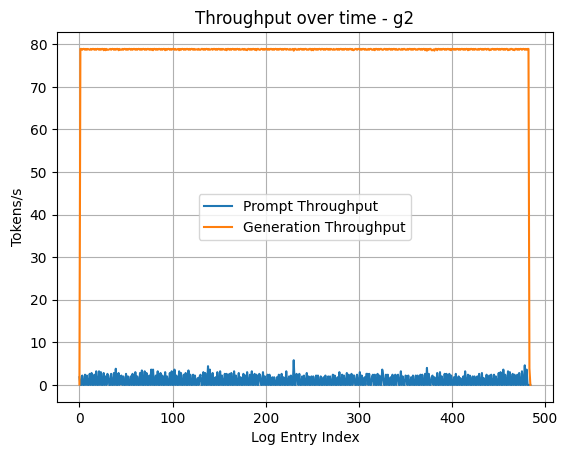

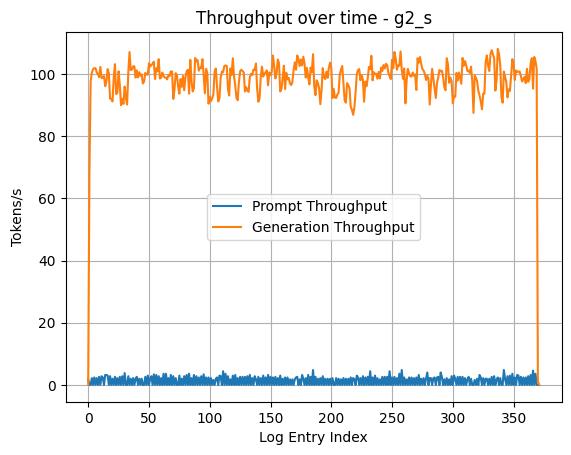

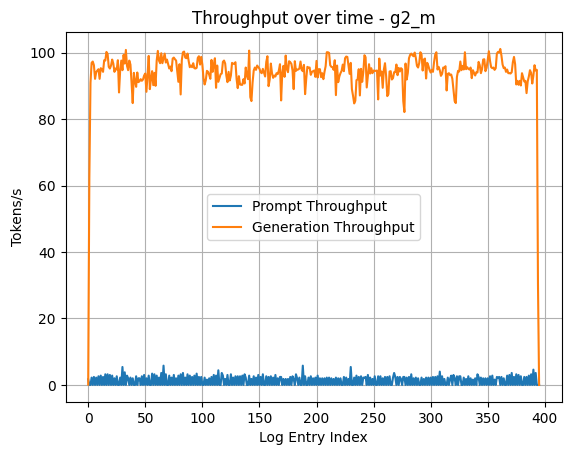

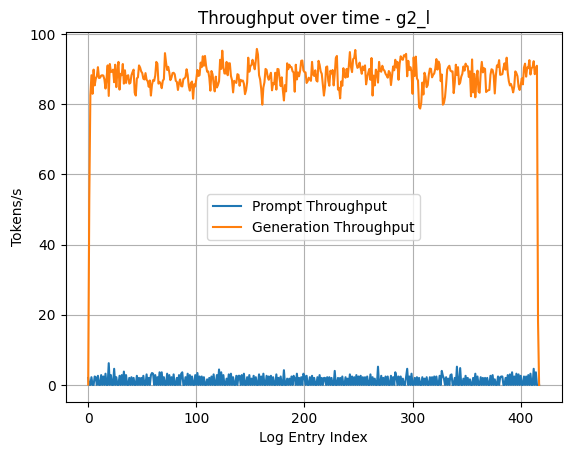

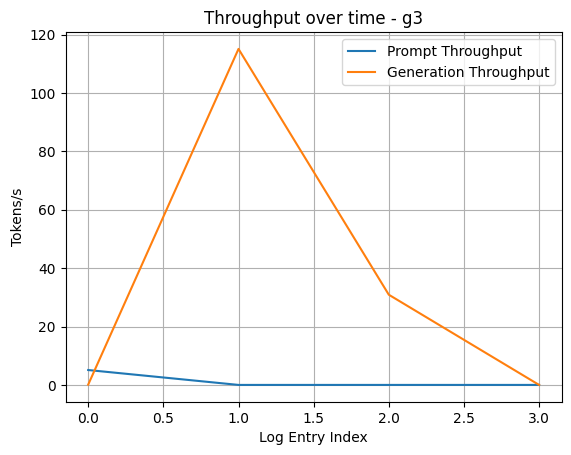

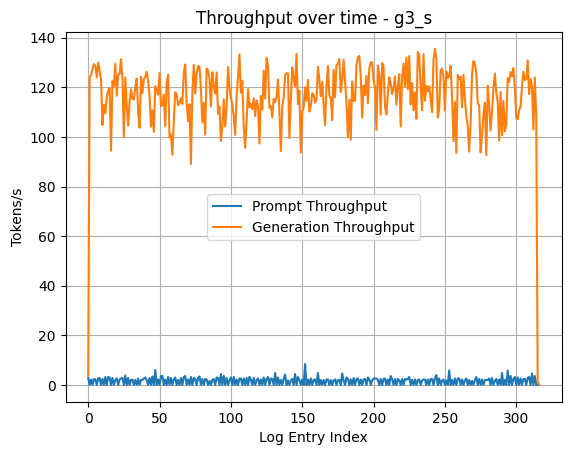

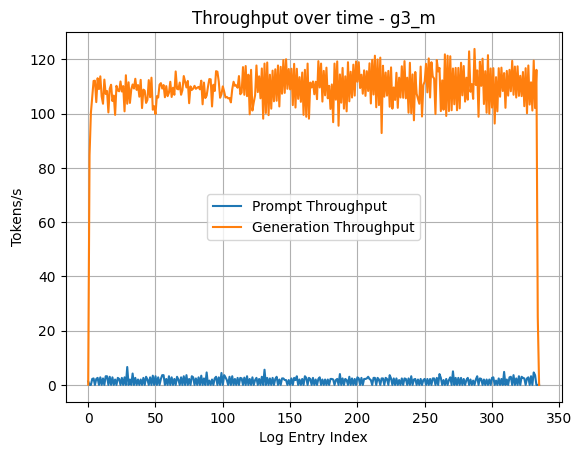

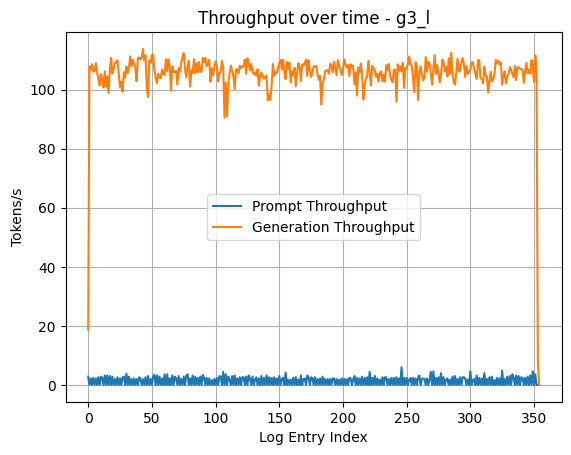

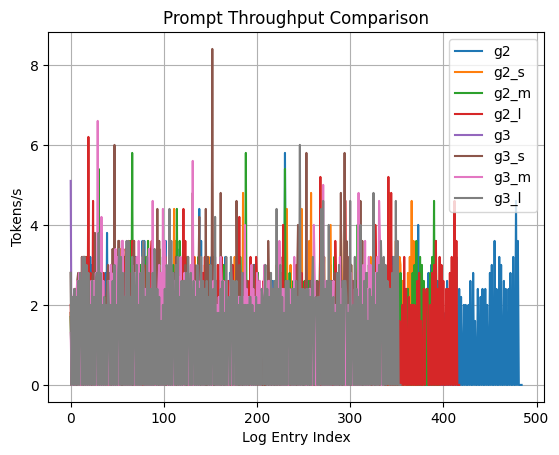

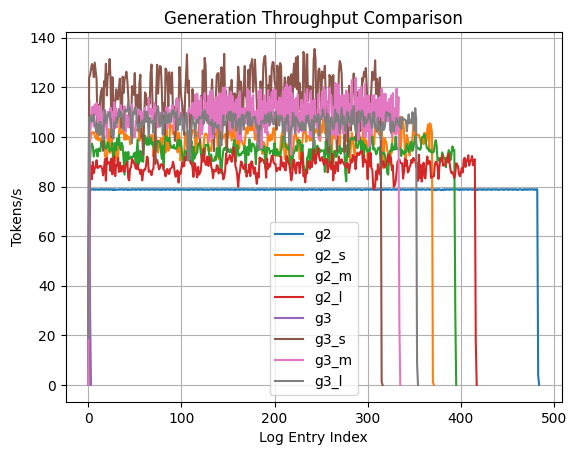

In [9]:
import re
import matplotlib.pyplot as plt



# Store all in a dict for processing
log_data = {
    "g2": g2,
    "g2_s": g2_s,
    "g2_m": g2_m, "g2_l": g2_l,
    "g3": g3, "g3_s": g3_s, "g3_m": g3_m, "g3_l": g3_l
}

pattern = re.compile(
    r"Avg prompt throughput: ([\d\.]+) tokens/s, Avg generation throughput: ([\d\.]+) tokens/s"
)

results = {}

for name, text in log_data.items():
    prompt_vals = []
    gen_vals = []

    for match in pattern.finditer(text):
        prompt_vals.append(float(match.group(1)))
        gen_vals.append(float(match.group(2)))

    if prompt_vals and gen_vals:
        results[name] = {
            "prompt_vals": prompt_vals,
            "gen_vals": gen_vals,
            "max_prompt": max(prompt_vals),
            "max_gen": max(gen_vals),
        }

# Print max values
for name, vals in results.items():
    print(f"{name}: Max Prompt Throughput = {vals['max_prompt']} tokens/s, "
          f"Max Generation Throughput = {vals['max_gen']} tokens/s")

# --- Plot individual graphs ---
for name, vals in results.items():
    plt.figure()
    plt.plot(vals["prompt_vals"], label="Prompt Throughput")
    plt.plot(vals["gen_vals"], label="Generation Throughput")
    plt.title(f"Throughput over time - {name}")
    plt.xlabel("Log Entry Index")
    plt.ylabel("Tokens/s")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Comparative plots ---
# Prompt throughput comparison
plt.figure()
for name, vals in results.items():
    plt.plot(vals["prompt_vals"], label=name)
plt.title("Prompt Throughput Comparison")
plt.xlabel("Log Entry Index")
plt.ylabel("Tokens/s")
plt.legend()
plt.grid(True)
plt.show()

# Generation throughput comparison
plt.figure()
for name, vals in results.items():
    plt.plot(vals["gen_vals"], label=name)
plt.title("Generation Throughput Comparison")
plt.xlabel("Log Entry Index")
plt.ylabel("Tokens/s")
plt.legend()
plt.grid(True)
plt.show()


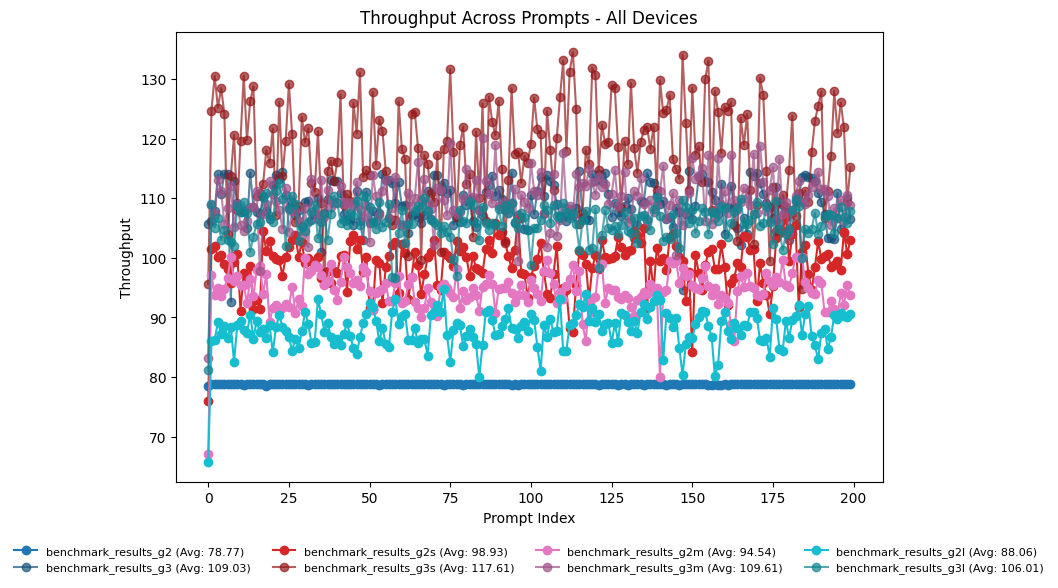

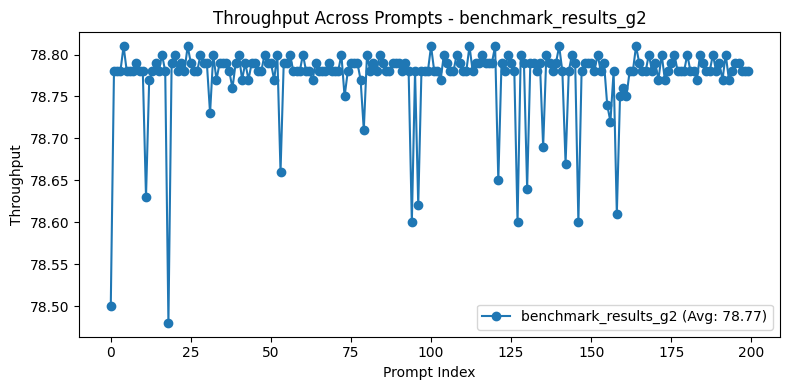

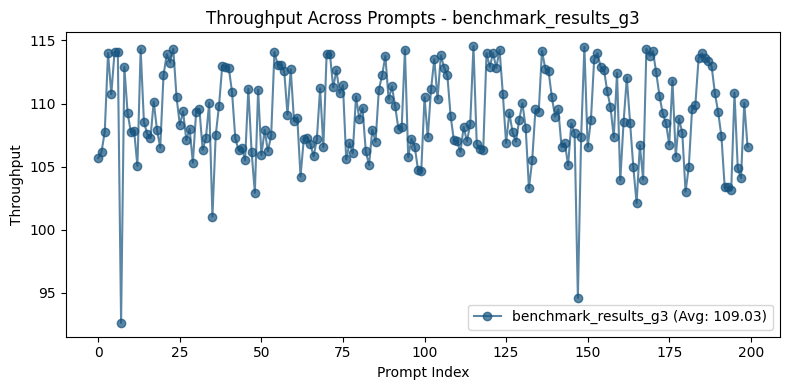

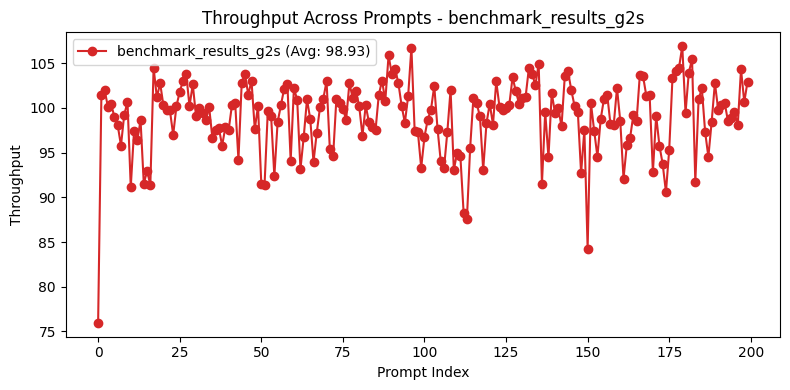

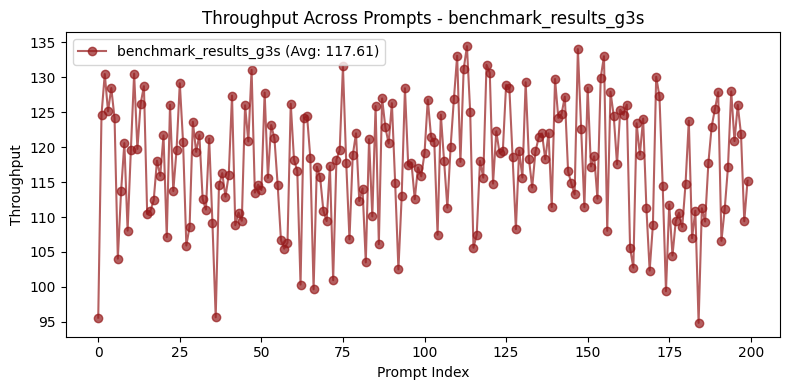

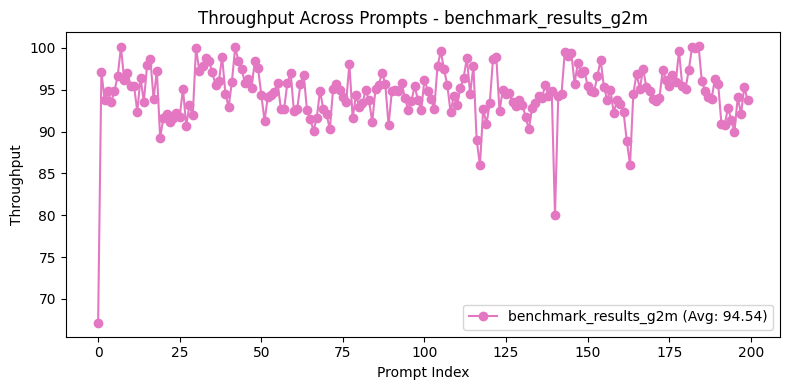

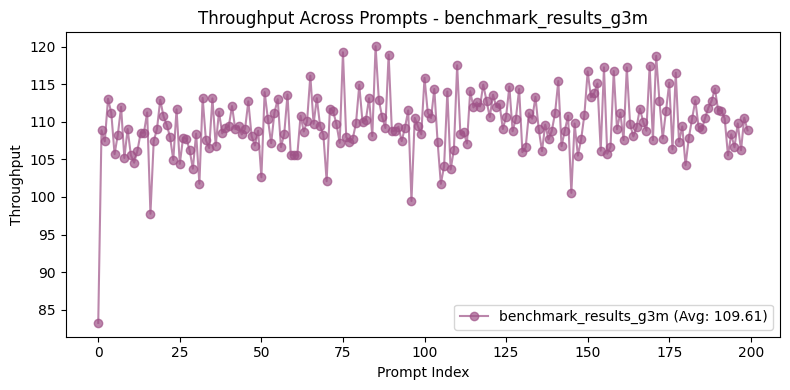

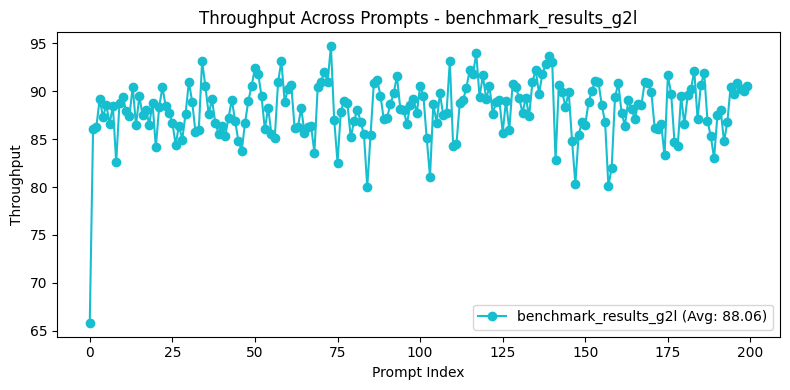

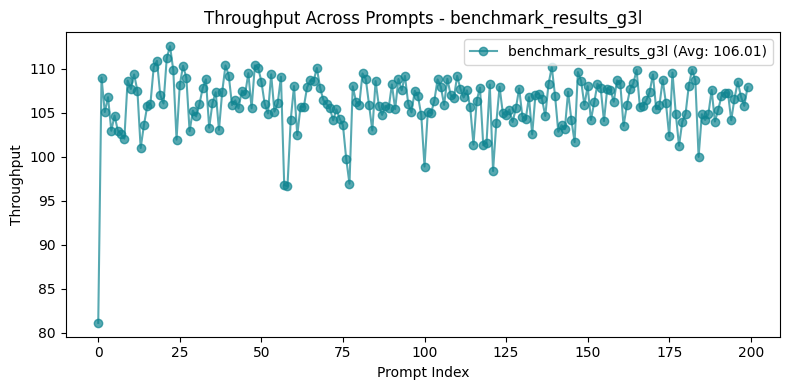

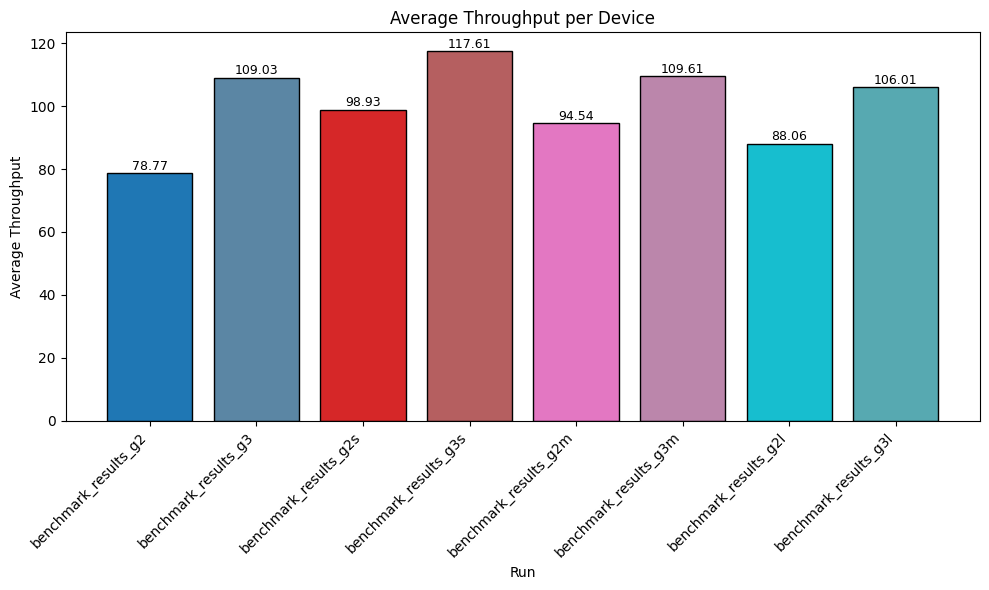

In [9]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# ===== CUSTOM ORDER FOR G2/G3 ALTERNATING =====
bench_plot_order = ["2", "3", "2s", "3s", "2m", "3m", "2l", "3l"]

def get_cfg_key(run_name):
    # Extract config like "2", "3", "2s", "3m" from filename
    return run_name.split("_")[-1].replace("g", "")  # remove "g" if present

bench_sorted_runs = sorted(
    bench_data.keys(),
    key=lambda x: bench_plot_order.index(get_cfg_key(x)) if get_cfg_key(x) in bench_plot_order else 999
)

# ===== COLOR ASSIGNMENT: SAME BASE FOR G2 & G3 =====
base_configs = ["2", "2s", "2m", "2l"]  # Only for color grouping
base_color_list = cm.tab10(np.linspace(0, 1, len(base_configs)))  # Base palette
bench_color_map = {}

for run in bench_sorted_runs:
    cfg = get_cfg_key(run)  # e.g., '2', '3', '2s', '3s'
    base_cfg = cfg.replace("3", "2")  # Map g3 variants to g2 color
    if base_cfg not in base_configs:
        base_cfg = base_configs[0]  # fallback if weird name
    base_idx = base_configs.index(base_cfg)
    if cfg.startswith("2"):
        bench_color_map[run] = base_color_list[base_idx]
    else:  # g3 variant → darker shade of same base color
        bench_color_map[run] = tuple(np.array(base_color_list[base_idx]) * 0.7)

# ===== PLOT: ALL DEVICES THROUGHPUT =====
plt.figure(figsize=(10, 6))
for run in bench_sorted_runs:
    plt.plot(
        bench_data[run],
        marker='o',
        label=f"{run} (Avg: {bench_throughput[run]:.2f})",
        color=bench_color_map[run],
        linestyle="-"
    )
plt.title("Throughput Across Prompts - All Devices")
plt.xlabel("Prompt Index")
plt.ylabel("Throughput")

# Smaller legend outside the plot
plt.legend(
    fontsize=8,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=4,
    frameon=False
)

plt.tight_layout()
plt.show()


# ===== INDIVIDUAL THROUGHPUT PLOTS =====
for run in bench_sorted_runs:
    plt.figure(figsize=(8, 4))
    plt.plot(
        bench_data[run],
        marker='o',
        color=bench_color_map[run],
        linestyle="-",
        label=f"{run} (Avg: {bench_throughput[run]:.2f})"
    )
    plt.title(f"Throughput Across Prompts - {run}")
    plt.xlabel("Prompt Index")
    plt.ylabel("Throughput")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== HISTOGRAM OF AVG THROUGHPUT =====
plt.figure(figsize=(10, 6))
bars = [bench_throughput[run] for run in bench_sorted_runs]
labels = [run for run in bench_sorted_runs]
colors = [bench_color_map[run] for run in bench_sorted_runs]

plt.bar(labels, bars, color=colors, edgecolor="black")
for i, val in enumerate(bars):
    plt.text(i, val + 0.1, f"{val:.2f}", ha="center", va="bottom", fontsize=9)
plt.title("Average Throughput per Device")
plt.xlabel("Run")
plt.ylabel("Average Throughput")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


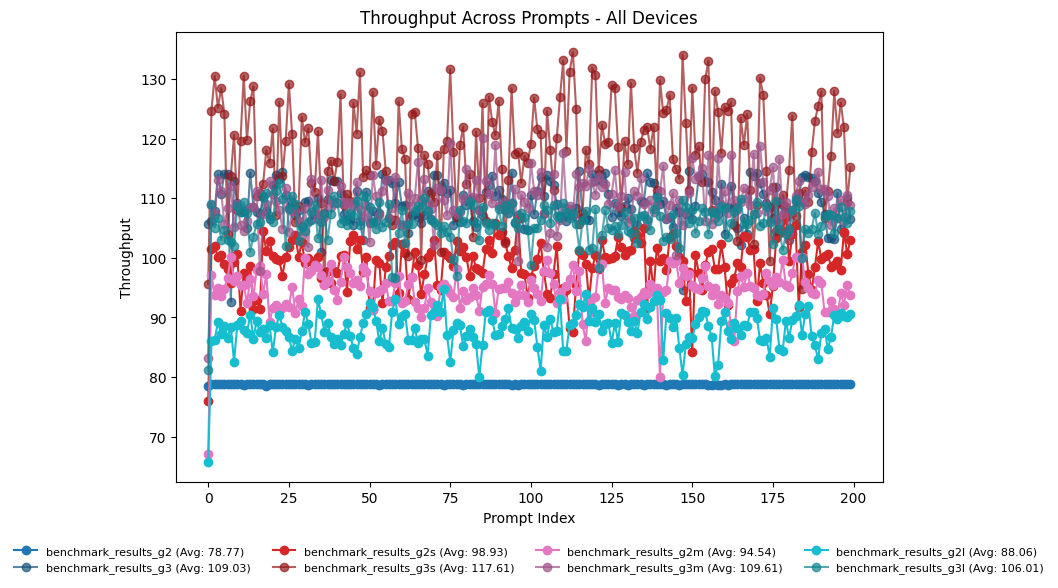

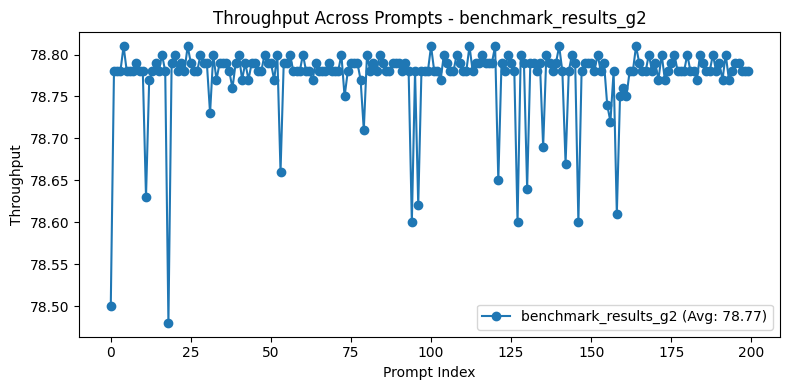

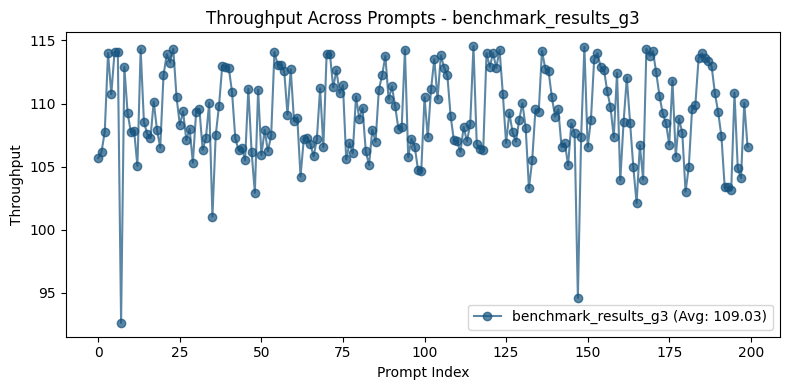

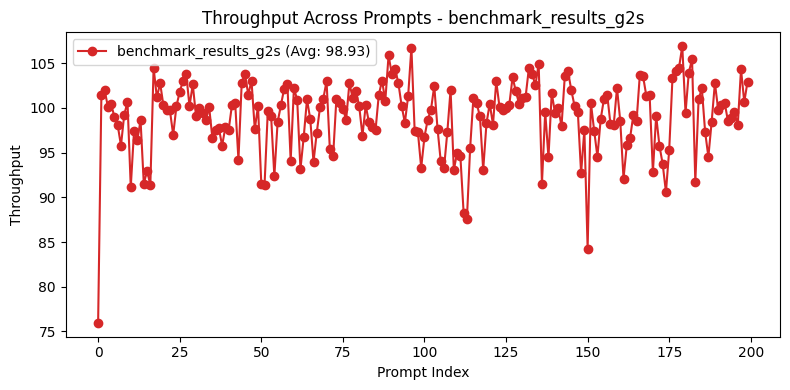

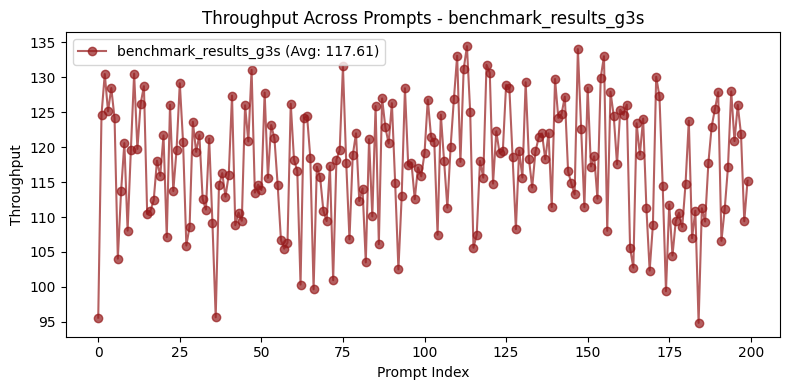

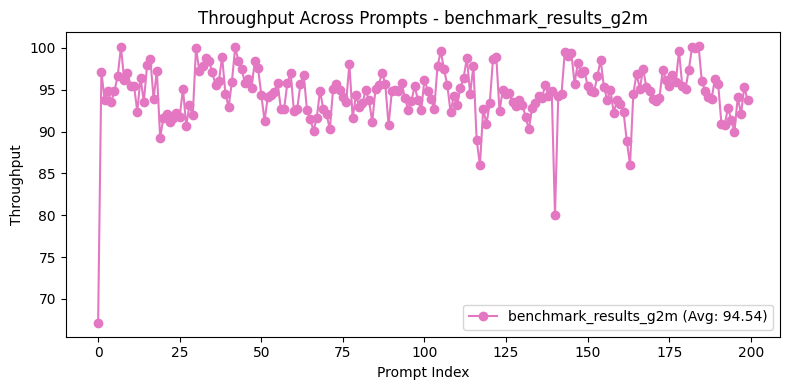

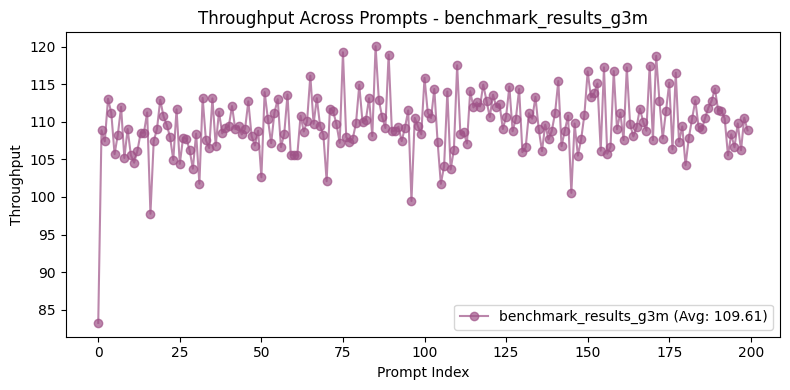

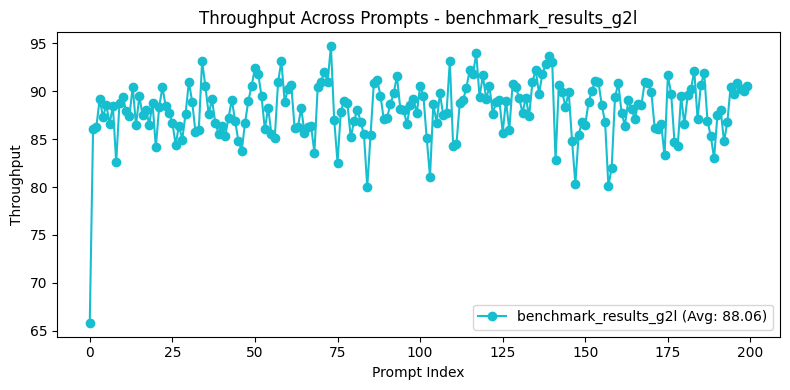

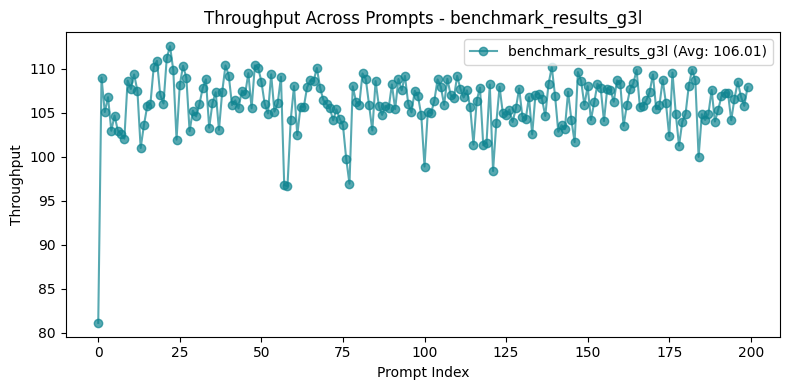

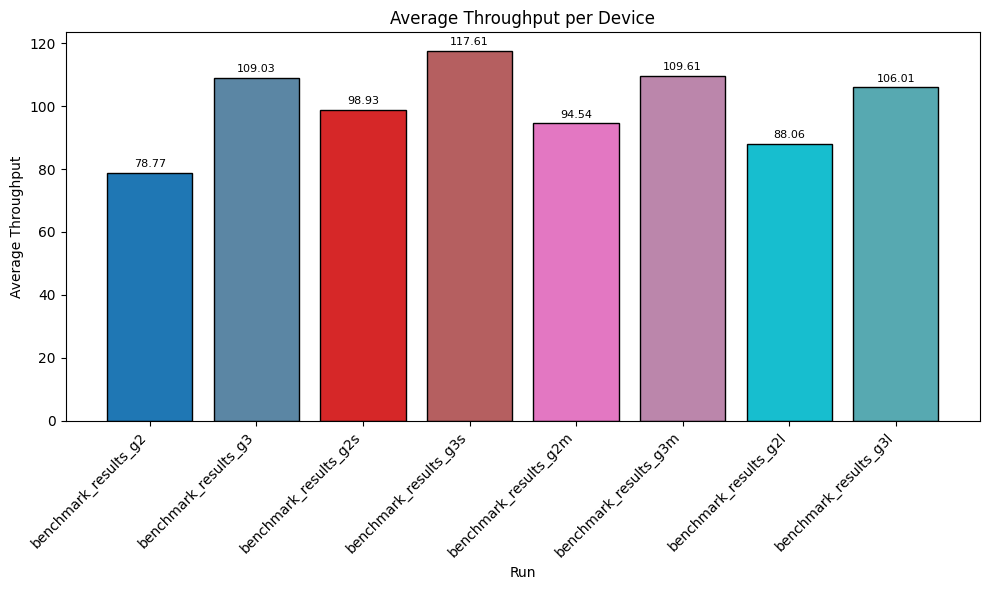

In [12]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# ===== CUSTOM ORDER FOR G2/G3 ALTERNATING =====
bench_plot_order = ["2", "3", "2s", "3s", "2m", "3m", "2l", "3l"]

def get_cfg_key(run_name):
    # Extract config like "2", "3", "2s", "3m" from filename
    return run_name.split("_")[-1].replace("g", "")  # remove "g" if present

bench_sorted_runs = sorted(
    bench_data.keys(),
    key=lambda x: bench_plot_order.index(get_cfg_key(x)) if get_cfg_key(x) in bench_plot_order else 999
)

# ===== COLOR ASSIGNMENT: SAME BASE FOR G2 & G3 =====
base_configs = ["2", "2s", "2m", "2l"]  # Only for color grouping
base_color_list = cm.tab10(np.linspace(0, 1, len(base_configs)))  # Base palette
bench_color_map = {}

for run in bench_sorted_runs:
    cfg = get_cfg_key(run)  # e.g., '2', '3', '2s', '3s'
    base_cfg = cfg.replace("3", "2")  # Map g3 variants to g2 color
    if base_cfg not in base_configs:
        base_cfg = base_configs[0]  # fallback if weird name
    base_idx = base_configs.index(base_cfg)
    if cfg.startswith("2"):
        bench_color_map[run] = base_color_list[base_idx]
    else:  # g3 variant → darker shade of same base color
        bench_color_map[run] = tuple(np.array(base_color_list[base_idx]) * 0.7)

# ===== PLOT: ALL DEVICES THROUGHPUT =====
plt.figure(figsize=(10, 6))
for run in bench_sorted_runs:
    plt.plot(
        bench_data[run],  # Use bench_data[run] directly
        marker='o',
        label=f"{run} (Avg: {bench_throughput[run]:.2f})",
        color=bench_color_map[run],
        linestyle="-"
    )
plt.title("Throughput Across Prompts - All Devices")
plt.xlabel("Prompt Index")
plt.ylabel("Throughput")
plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)
plt.tight_layout()
plt.show()

# ===== INDIVIDUAL THROUGHPUT PLOTS =====
for run in bench_sorted_runs:
    plt.figure(figsize=(8, 4))
    plt.plot(
        bench_data[run], # Use bench_data[run] directly
        marker='o',
        color=bench_color_map[run],
        linestyle="-",
        label=f"{run} (Avg: {bench_throughput[run]:.2f})"
    )
    plt.title(f"Throughput Across Prompts - {run}")
    plt.xlabel("Prompt Index")
    plt.ylabel("Throughput")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== HISTOGRAMS FOR ALL METRICS =====
# Assuming bench_data contains only throughput for now based on the error
metrics = ["throughput"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    # Use bench_throughput which already contains the average throughput
    avg_values = [bench_throughput[run] for run in bench_sorted_runs]
    plt.bar(bench_sorted_runs, avg_values, color=[bench_color_map[run] for run in bench_sorted_runs], edgecolor="black")
    for i, val in enumerate(avg_values):
        plt.text(i, val + 0.01 * max(avg_values), f"{val:.2f}", ha="center", va="bottom", fontsize=8)
    plt.title(f"Average Throughput per Device") # Updated title
    plt.xlabel("Run")
    plt.ylabel(f"Average Throughput") # Updated ylabel
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()

    plt.show()